In [2]:
#imports
import math
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm as CM
from matplotlib import mlab as ML
#for choosing the triplets
import itertools
import random

#get the vector functions
from vpython import *

#import other related files
import PeriodicOrbits as PO
import IDbraid as IDB
import TestJet as TJ 
import BraidFuncM as BF


#number of periods
n=1  

#global parameters for the Bickly Jet (units will all be in Mm,hours)
U_b = 0.06266*60*60/1000 #This is a characteristic velocity measured in Mm/hour (converted from km/s)
L_b = 1.770  #This is a characteristic length (in Mm)
r0 = 6.371   #The mean radius of Earth in Mm
k_1 = 2/r0   #the Rossby wave number k_1
k_2 = 4/r0   #the Rossby wave number k_2
k_3 = 6/r0   #the Rossby wave number k_3
#These wavenumbers are taken for a lattitude of -pi/3 (south from the equator ... -pi/2 would be south pole)
k_b = [k_1,k_2,k_3]  #the Rossby wave numbers [k_1,k_2,k_3]
c_3 = 0.4*U_b
c_2 = 0.2*U_b
#c_1 = c_3 + ((math.sqrt(5)-1)/2)*(k_b[2]/k_b[1])*(c_2-c_3)
c_1 = 0.3*U_b
c_b = [c_1,c_2,c_3]   #The Rossby wave speeds
eps_1 = 0.075   #the 1st Rossby wave amplitude
eps_2 = 0.4     #the 2nd Rossby wave amplitude
eps_3 = 0.3     #the 3st Rossby wave amplitude
eps_b = [eps_1,eps_2,eps_3]   #The Rossby wave amplitudes
paramsPhys = [U_b,L_b,k_b,c_b,eps_b]  #just repackaging the parameters to pass into the various functions


#Computational Parameters 3090
Nx = 360   #the number of initial columns to have along the x-direction
Ny = 120   #The number of initial rows to have along the y-direction
gridsize = [Nx, Ny]
r0 = 6.371
x_l = 0   #Rectangular Domain, x-range left (in Mm)
x_r = math.pi*r0   #Rectangular Domain, x-range right (in Mm) ... this works out to be about 20 Mm
y_b = -3   #Rectangular Domain, y-range bottom (in Mm)
y_t = 3   #Rectangular Domain, y-range top (in Mm)


#The total period over which the velocity field repeats (in time)
T_tot = math.pi*r0/(0.1*U_b) 
T_i = 0  #Starting time
time = 1000
T_num = time*n #The number of time-steps to take (will use equal time-step evolution for advected particles)
paramsComp = [T_i,T_tot,time]


#tranformational parameters
R_offset = 6  #to add to each y-value
xmult = 2/r0  #to multiply each x value by
paramstrans = [R_offset,xmult,r0]  #just repackaging the parameters

#bound together
paramA = [paramsPhys,paramsComp,paramstrans,n]


#other parameters
boundR = 0.4
radius = 0.00001
overalltime = T_tot*n
numRing = 150

#open the file
fileName = "jetPO1_360120.txt"
#whole list is form [time] [index] [x or y] t1:xyxyxy, t2:xyxyxy
wholeList = BF.openN(fileName)
#get the number of perio
numPO = len(wholeList[4])//2
print("DONE")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DONE


In [3]:
##functions

#write to file from a 1-D list
def writesinglelist(listNum, name):
    f = open(name, "w");
    knx = str(listNum[0])
    for x in range(1,len(listNum)):
        knx = knx+'\n'
        knx = knx+str(listNum[x])

    f.write(knx)

#get coordinates from angle
def getCfromA(init, ang, r):
    x = init[0] + math.cos(ang*math.pi)*r
    y = init[1] + math.sin(ang*math.pi)*r
    return [x,y]

#input points are in the order [index][x or y]
#return the point that is the furthest from the center
def getfur(points,center):
    #temp = [dis, [point1id, point2id]]
    temp = [0,[0,0]]
    center = center[0]
    for a in range (0,len(points)):
        #print(center)
        x = center[0] - points[a][0]
        y = center[1] - points[a][1]
        #get the distance
        dis = ((x)**2 + (y)**2)**(1/2)
        if(dis > temp[0]):
            temp = [dis, points[a]]
                
    return temp


#from integer 1 to total, choose set of num numbers
def findindex(num,total):
    stuff = list(range(total))
    indices = []
    for subset in itertools.combinations(stuff,num):
        indices.append(list(subset))
    return indices


#function to read single list file with file name
#and return a 1-D list
def readsingle(fileName):
    ls = []
    #open and record
    with open(fileName,"r") as f:
        #for each time
        for line in f:
            ls.append(float(line))
            
    return ls


#given two points, find the line passing them, and the angle with postive x axis
def pointtoangle(point):
    x, y = point
    #print("x", x)
    #print("y", y)
    x = x[0]
    ang = math.atan((x[1]-y[1])/(x[0]-y[0]))
    if(y[1]<0):
        return ang+math.pi
    
    
    return ang

#find the most stetch point
#get the start position of that point on the ring
#record the angle
#write to file
#stretch = final most separated distance/ initial radius
def getstretch(onepoint, r, params):
    #get the list of angles
    tempang = np.arange(0, 1, 0.05)
    #get a ring around the point
    ringaround = []
    for x in range (0, len(tempang)):
        ringaround.append(getCfromA(onepoint, tempang[x], r))
    #ICtoTRA
    #time dindex xy
    templist = TJ.ICtoTRA(ringaround, params)
    
    #evolve the enter
    centerend = TJ.ICtoTRA([onepoint], params)[-1]
    #get the final points
    finals = templist[-1]
    far = getfur(finals,centerend)
    
    #change to angle
    finalang = pointtoangle([centerend, far[1]])
    #get the rate
    srate = far[0]
    #return the angle and the stretch rate
    return [finalang, srate]

#get the initial angle of the largest stretch given the initial start points of all PO
def getallstr(allst, r, params):
    listang = []
    a = []
    b = []
    #go over all points
    for x in range (0, len(allst)):
        a.append(getstretch(allst[x], r, params)[0])
        b.append(getstretch(allst[x], r, params)[1])

    listang = [a,b]
    return listang

def plotRing(endposi,ss,PO):
    
    import matplotlib.pyplot as plt
    import pylab
    xcoor = []
    ycoor = []
    
    xcoorp = [PO[0]]
    ycoorp = [PO[1]]
    
    

    for x in range (0,len(endposi)):
        xcoor.append(endposi[x][0])
        ycoor.append(endposi[x][1])
    
    #plt.xlim(0.87994,0.87998)
    #plt.xlim(0.87990,0.88000)
    #sort
    x1 = min(xcoor)
    x2 = max(xcoor)
    y1 = min(ycoor)
    y2 = max(ycoor)
    
    plt.figure(figsize = (15,15))
    plt.xlim(x1,x2)
    plt.ylim(y1,y2)
    #plt.gca().set_aspect("equal")
    plt.scatter(xcoor,ycoor,s=ss)
    plt.scatter(xcoorp,ycoorp,s=2, c = "r")

    plt.show()
    print(x1,x2)
    
    
#plot
#plot
def plotF(traPO,a):
    
    plt.figure(figsize=(9,9))
    xlabel('x')
    ylabel('y')
    string = str(a)
    title(string)
    #listxxx1 = traPO[12][0]
    #listyyy1 = traPO[12][1]
    #print(traPO)
    listxxx1 = []
    listyyy1 = []
    

    for x in range(0,len(traPO)):
        listxxx1.append(traPO[x][0])
        listyyy1.append(traPO[x][1])

    plt.scatter(listxxx1, listyyy1, s=1)
    
        #print(len(traPO[0]))
    listx0 = traPO[0][0]
    listy0 = traPO[0][1]

    plt.scatter(listx0, listy0, color = "C0")
    plt.savefig(fileName+str(a)+'.png')
    
    
#plot
#plot
def plotOne(traPO,a):
    
    plt.figure(figsize=(9,9))
    xlabel('x')
    ylabel('y')
    string = str(a)
    title(string)
    #listxxx1 = traPO[12][0]
    #listyyy1 = traPO[12][1]
    #print(traPO)
    listxxx1 = []
    listyyy1 = []
    

    for x in range(0,len(traPO)):
        listxxx1.append(traPO[x][0])
        listyyy1.append(traPO[x][1])

    plt.scatter(listxxx1, listyyy1, s=1)
    
        #print(len(traPO[0]))
    listx0 = traPO[0][0]
    listy0 = traPO[0][1]

    plt.scatter(listx0, listy0, color = "C0")
    plt.savefig(fileName+str(a)+'.png')

    
#given the track of a particle,
#get the total angle it goes through with respect to point (0,0)
def totalAngle(pointtrack):
    #the input data is the form p[at which time][is x or y]
    #get the start position 
    temp = pointtrack[0]
    #initial value to accumulate
    angle = 0
    #loop to get the total angle
    for x in range (1,len(pointtrack)):
        current = pointtrack[x]
        v1 = vector(temp[0],temp[1],0)
        v2 = vector(current[0],current[1],0)
        ang = diff_angle(v1, v2)
        crossP = cross(v1,v2)
        if(crossP.z<0):
            ang = -1 * ang
            
        angle = angle + ang
        #update the former angle
        temp = pointtrack[x]
        
    return angle


#project the location data on an axis and find the time where the points match the best
#given a trajectory
#out put the axises that satisfy the standard

#find the symmetry in the time reversing way
def findAxisT(onePO, bound, axises):
    
    axisStart = []
    #for each of the axis
    for x in range (0 , len(axises)):
        
        #for each of the start time
        #for each of the starting position of the point
        #record the smallest symmetry error from all start time
        symerr = [10000, 0]
        for y in range (0,len(onePO)):
        
            #get the new ordered track
            newTrackX = reorder(y,onePO)
            trackpro = []
            #get the projection onto the axis first part
            for z in range (0, len(newTrackX)):
                
                #get the vecter for each point
                v1 = vector(newTrackX[z][0], newTrackX[z][1],0)
                
                #rotate the vector according the axis
                v3 = rotate(v1, -pi*axises[x])
                
                trackpro.append(v3)
            err = 0   
            #second part reverse the y part and add to the first part
            for p in range (0, len(newTrackX)//2):
                
                v1 = trackpro[p]
                v2 = trackpro[len(newTrackX)-1-p]
                
                v3 = vector(v2.x, -v2.y, 0)
                
                #vector sum
                
                vsum = v3 - v1
                #print(vsum)
                #add the vectors and get the magnitute
                err = err + mag(vsum)
            #if we find a smaller error
            if(err < symerr[0]):
                #record the error and the start time
                symerr = [err, y]
        
        #print(x, symerr)
        if (symerr[0]<bound):
            
            axisStart.append([axises[x],symerr])
    return axisStart


#[float(wholeList[y][2*x+1]),float(wholeList[y][2*x+2])]


#for each of the particles

#input the starting point and get the track in that order
#use the nth point as the starting point and reorder the track
#return in [time][x or y]
def reorder(index, track):
    newtrack = []
    for x in range (index, len(track)):
        newtrack.append(track[x])
        
    for y in range (0, index-1):
        newtrack.append(track[y])
        
    return newtrack
    

#define a function to find the smallest imagery part of a fast fourier transformation 
#of the trajectory and the corresponding starting point

def findStartP(onePo):
    #temp to hold the smallest 
    tempSP = onePo[0]
    tempImg = 0
    #for each of the starting position of the point
    for x in range (0,len(onePo)):
        
        #get the new ordered track
        newTrack = reorder(x,onePo)
        newTrackP = []
        #transform into polar 
        for y in range (0,len(newTrack)):
            temppolar = []
            #print(y,newTrack[y])
            temppolar = TJ.AnnTrans(newTrack[y],paramstrans)
            newTrackP.append(temppolar)
        #get the list of all the radius
    
        #transform the fourier
        a = np.fft.fft(newTrackP)
        
        #get the sum of img
        img = a.imag
        #get abs
        b = np.abs(img)
        #get the sume
        sumi = sum(b)
        #if we find the smaller one
        #replace the original
        if(sumi < tempImg):
            tempImg = sumi
            tempSP = onePo[x]
            
    return [tempImg, tempSP]


def timetopoint(wholetrack):
    newpoints = []
    #for each point
    for x in range (0, (len(wholetrack[3])-1)//2):
        oneTime = []
        #for each time slice
        for y in range (0,len(wholetrack)):
            oneTime.append([float(wholetrack[y][2*x+1]),float(wholetrack[y][2*x+2])])
        newpoints.append(oneTime)
    return newpoints
        
            
        
#plot the axis of the sym on the data
def plotAT(axis, track):
    
    #plot the track
    plt.figure(figsize=(9,9))
    xlabel('x')
    ylabel('y')
    string = str(axis)
    title(string)
    #listxxx1 = traPO[12][0]
    #listyyy1 = traPO[12][1]
    #print(traPO)
    listxxx1 = []
    listyyy1 = []
    
    maxX = -10000
    minX = 10000

    for x in range(0,len(track)):
        listxxx1.append(track[x][0])
        listyyy1.append(track[x][1])
        
        if(track[x][0] > maxX):
            maxX = track[x][0]

        elif(track[x][0] < minX):
            minX = track[x][0]
    plt.scatter(listxxx1, listyyy1, s=1)
    
    #plot the axis
    #get the range for x
    x = np.arange(minX, maxX, 0.5)
    #equation for y
    y = math.tan(math.pi*axis) * x;
    #plot
    plt.plot(x,y)
    plt.show()

 
                
print("DONE")   



DONE


In [5]:
#prepare data
#the array of different axises that goes through the origin
#the line defined by the angle from the positive x axis [0,pi]
axises100 = np.arange(0, 1, 0.01)

#get the data to list in order of points
pointslist = timetopoint(wholeList)

#symmetry list of all points
allsym = []
#for each point
for x in range (0, len(pointslist)):
    pointexp = pointslist[x]
    #test of symmetry
    axisE = findAxisT(pointexp, 60, axises100)
    #add to list
    allsym.append(axisE)
    print(len(axisE))
    #if there is an axis:
    #if(len(axisE) != 0):
        #show and save the plot
        #plotAT(axisE[0][0], pointexp)
        
symnum = []
for x in range(0, len(allsym)):
    symnum.append(len(allsym[x]))
#writesinglelist(listNum, name)
writesinglelist(symnum, "issymmnum.txt")
print("D")


#for each point
oneTime = []
for x in range (0, (len(wholeList[3])-1)//2):
    oneTime.append([float(wholeList[0][2*x+1]),float(wholeList[0][2*x+2])])
    
#start position of all PO    
stretchrate = getallstr(oneTime, 0.03, paramA)[1]

stretchdir = getallstr(oneTime, 0.03, paramA)[0]

writesinglelist(stretchrate, "stretchrate.txt")
writesinglelist(stretchdir, "stretchdir.txt")

done


In [4]:
ent = IDB.getEnt(fileName,n,numPO)
print(ent)
# test if dropping groups of unimportant points

Tolerance of  1e-09  reached after  13  Iterations 

0.0114871460868


In [92]:
print(ent*time)

11.4871460868


In [10]:
import time
t1 = time.time()
indices3 = IDB.findindex(3,numPO)
for x in range(0,255):
        IDB.getEntro(indices3[x],fileName)
        
print(time.time()-t1)

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

Tolerance of  1e-09  reached after  6  Iterations 

Tolerance of  1e-09  reached after  6  Iterations 

Tolerance of  1e-09  reached after  6  Iterations 

Tolerance of  1e-09  reached after  6  Iterations 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

Tolerance of  1e-09  reached after  6  Iterations 

Tolerance of  1e-09  reached after  7  Iterations 

Tolerance of  1e-09  reached after  6  Iterations 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

Tolerance of  1e-09 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

Tolerance of  1e-09  reached after  5  Iterations 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

Tolerance of  1e-09  reached after  5  Iterations 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value giv

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  100

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  100

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

Tolerance of  1e-09  reached after  6  Iterations 

The specified tolerance of  1e-09  was not reached after the maximum of  1000  iterations. 

The Topological Entropy value given is only an upper bound 

78.35220384597778


In [ ]:
#get the list of entropy of all POs except one
#getBestValue(indices, listW,filename)
#total entropy except one
enminus1 = []
#the contribution of that one 
en1 = []
for x in range(0,len(indices)):
        enminus1.append(IDB.getEntro(indices[x],filename))
        en1.append(ent - IDB.getEntro(indices[x],filename))


In [4]:


#get the four file names
#how many times the particle loops
fnloop = "Loop number.txt"
#if the track is symmetric
fnsymm = "issymmnum.txt"
#the largest stretch rate of a track
fnstrate = "stretchrate.txt"
#the direction of the largest stretch rate
fnstdir = "stretchdir.txt"

#read the four matadata
listloop = readsingle(fnloop)
listsymm = readsingle(fnsymm)
liststrate = readsingle(fnstrate)
liststdir = readsingle(fnstdir)

entro3 = readsingle("ent3.txt")
print("Done")



Done


In [7]:
#get all triplets indices
indices3 = IDB.findindex(3,numPO)
import random
#get the entropy
entro3 = []
features3 = []
#get random 10000 of all the triplets
listindex3 = set(np.arange(len(indices3)))
ran3 = random.sample(listindex3, 30000)
for n in range(0,len(ran3)):
    x = ran3[n]
    print(n, 30000)
    #entro3.append(IDB.getEntro(indices3[x],fileName))
    a, b, c = indices3[x]
    features3.append([listloop[a],listloop[b],listloop[c],listsymm[a],listsymm[b],listsymm[c],
                      liststrate[a],liststrate[b],liststrate[c],liststdir[a],liststdir[b],liststdir[c]])
print(entro3[45])

0 30000
1 30000
2 30000
3 30000
4 30000
5 30000
6 30000
7 30000
8 30000
9 30000
10 30000
11 30000
12 30000
13 30000
14 30000
15 30000
16 30000
17 30000
18 30000
19 30000
20 30000
21 30000
22 30000
23 30000
24 30000
25 30000
26 30000
27 30000
28 30000
29 30000
30 30000
31 30000
32 30000
33 30000
34 30000
35 30000
36 30000
37 30000
38 30000
39 30000
40 30000
41 30000
42 30000
43 30000
44 30000
45 30000
46 30000
47 30000
48 30000
49 30000
50 30000
51 30000
52 30000
53 30000
54 30000
55 30000
56 30000
57 30000
58 30000
59 30000
60 30000
61 30000
62 30000
63 30000
64 30000
65 30000
66 30000
67 30000
68 30000
69 30000
70 30000
71 30000
72 30000
73 30000
74 30000
75 30000
76 30000
77 30000
78 30000
79 30000
80 30000
81 30000
82 30000
83 30000
84 30000
85 30000
86 30000
87 30000
88 30000
89 30000
90 30000
91 30000
92 30000
93 30000
94 30000
95 30000
96 30000
97 30000
98 30000
99 30000
100 30000
101 30000
102 30000
103 30000
104 30000
105 30000
106 30000
107 30000
108 30000
109 30000
110 30000


940 30000
941 30000
942 30000
943 30000
944 30000
945 30000
946 30000
947 30000
948 30000
949 30000
950 30000
951 30000
952 30000
953 30000
954 30000
955 30000
956 30000
957 30000
958 30000
959 30000
960 30000
961 30000
962 30000
963 30000
964 30000
965 30000
966 30000
967 30000
968 30000
969 30000
970 30000
971 30000
972 30000
973 30000
974 30000
975 30000
976 30000
977 30000
978 30000
979 30000
980 30000
981 30000
982 30000
983 30000
984 30000
985 30000
986 30000
987 30000
988 30000
989 30000
990 30000
991 30000
992 30000
993 30000
994 30000
995 30000
996 30000
997 30000
998 30000
999 30000
1000 30000
1001 30000
1002 30000
1003 30000
1004 30000
1005 30000
1006 30000
1007 30000
1008 30000
1009 30000
1010 30000
1011 30000
1012 30000
1013 30000
1014 30000
1015 30000
1016 30000
1017 30000
1018 30000
1019 30000
1020 30000
1021 30000
1022 30000
1023 30000
1024 30000
1025 30000
1026 30000
1027 30000
1028 30000
1029 30000
1030 30000
1031 30000
1032 30000
1033 30000
1034 30000
1035 30000
1036

2183 30000
2184 30000
2185 30000
2186 30000
2187 30000
2188 30000
2189 30000
2190 30000
2191 30000
2192 30000
2193 30000
2194 30000
2195 30000
2196 30000
2197 30000
2198 30000
2199 30000
2200 30000
2201 30000
2202 30000
2203 30000
2204 30000
2205 30000
2206 30000
2207 30000
2208 30000
2209 30000
2210 30000
2211 30000
2212 30000
2213 30000
2214 30000
2215 30000
2216 30000
2217 30000
2218 30000
2219 30000
2220 30000
2221 30000
2222 30000
2223 30000
2224 30000
2225 30000
2226 30000
2227 30000
2228 30000
2229 30000
2230 30000
2231 30000
2232 30000
2233 30000
2234 30000
2235 30000
2236 30000
2237 30000
2238 30000
2239 30000
2240 30000
2241 30000
2242 30000
2243 30000
2244 30000
2245 30000
2246 30000
2247 30000
2248 30000
2249 30000
2250 30000
2251 30000
2252 30000
2253 30000
2254 30000
2255 30000
2256 30000
2257 30000
2258 30000
2259 30000
2260 30000
2261 30000
2262 30000
2263 30000
2264 30000
2265 30000
2266 30000
2267 30000
2268 30000
2269 30000
2270 30000
2271 30000
2272 30000
2273 30000

3692 30000
3693 30000
3694 30000
3695 30000
3696 30000
3697 30000
3698 30000
3699 30000
3700 30000
3701 30000
3702 30000
3703 30000
3704 30000
3705 30000
3706 30000
3707 30000
3708 30000
3709 30000
3710 30000
3711 30000
3712 30000
3713 30000
3714 30000
3715 30000
3716 30000
3717 30000
3718 30000
3719 30000
3720 30000
3721 30000
3722 30000
3723 30000
3724 30000
3725 30000
3726 30000
3727 30000
3728 30000
3729 30000
3730 30000
3731 30000
3732 30000
3733 30000
3734 30000
3735 30000
3736 30000
3737 30000
3738 30000
3739 30000
3740 30000
3741 30000
3742 30000
3743 30000
3744 30000
3745 30000
3746 30000
3747 30000
3748 30000
3749 30000
3750 30000
3751 30000
3752 30000
3753 30000
3754 30000
3755 30000
3756 30000
3757 30000
3758 30000
3759 30000
3760 30000
3761 30000
3762 30000
3763 30000
3764 30000
3765 30000
3766 30000
3767 30000
3768 30000
3769 30000
3770 30000
3771 30000
3772 30000
3773 30000
3774 30000
3775 30000
3776 30000
3777 30000
3778 30000
3779 30000
3780 30000
3781 30000
3782 30000

5198 30000
5199 30000
5200 30000
5201 30000
5202 30000
5203 30000
5204 30000
5205 30000
5206 30000
5207 30000
5208 30000
5209 30000
5210 30000
5211 30000
5212 30000
5213 30000
5214 30000
5215 30000
5216 30000
5217 30000
5218 30000
5219 30000
5220 30000
5221 30000
5222 30000
5223 30000
5224 30000
5225 30000
5226 30000
5227 30000
5228 30000
5229 30000
5230 30000
5231 30000
5232 30000
5233 30000
5234 30000
5235 30000
5236 30000
5237 30000
5238 30000
5239 30000
5240 30000
5241 30000
5242 30000
5243 30000
5244 30000
5245 30000
5246 30000
5247 30000
5248 30000
5249 30000
5250 30000
5251 30000
5252 30000
5253 30000
5254 30000
5255 30000
5256 30000
5257 30000
5258 30000
5259 30000
5260 30000
5261 30000
5262 30000
5263 30000
5264 30000
5265 30000
5266 30000
5267 30000
5268 30000
5269 30000
5270 30000
5271 30000
5272 30000
5273 30000
5274 30000
5275 30000
5276 30000
5277 30000
5278 30000
5279 30000
5280 30000
5281 30000
5282 30000
5283 30000
5284 30000
5285 30000
5286 30000
5287 30000
5288 30000

6694 30000
6695 30000
6696 30000
6697 30000
6698 30000
6699 30000
6700 30000
6701 30000
6702 30000
6703 30000
6704 30000
6705 30000
6706 30000
6707 30000
6708 30000
6709 30000
6710 30000
6711 30000
6712 30000
6713 30000
6714 30000
6715 30000
6716 30000
6717 30000
6718 30000
6719 30000
6720 30000
6721 30000
6722 30000
6723 30000
6724 30000
6725 30000
6726 30000
6727 30000
6728 30000
6729 30000
6730 30000
6731 30000
6732 30000
6733 30000
6734 30000
6735 30000
6736 30000
6737 30000
6738 30000
6739 30000
6740 30000
6741 30000
6742 30000
6743 30000
6744 30000
6745 30000
6746 30000
6747 30000
6748 30000
6749 30000
6750 30000
6751 30000
6752 30000
6753 30000
6754 30000
6755 30000
6756 30000
6757 30000
6758 30000
6759 30000
6760 30000
6761 30000
6762 30000
6763 30000
6764 30000
6765 30000
6766 30000
6767 30000
6768 30000
6769 30000
6770 30000
6771 30000
6772 30000
6773 30000
6774 30000
6775 30000
6776 30000
6777 30000
6778 30000
6779 30000
6780 30000
6781 30000
6782 30000
6783 30000
6784 30000

8200 30000
8201 30000
8202 30000
8203 30000
8204 30000
8205 30000
8206 30000
8207 30000
8208 30000
8209 30000
8210 30000
8211 30000
8212 30000
8213 30000
8214 30000
8215 30000
8216 30000
8217 30000
8218 30000
8219 30000
8220 30000
8221 30000
8222 30000
8223 30000
8224 30000
8225 30000
8226 30000
8227 30000
8228 30000
8229 30000
8230 30000
8231 30000
8232 30000
8233 30000
8234 30000
8235 30000
8236 30000
8237 30000
8238 30000
8239 30000
8240 30000
8241 30000
8242 30000
8243 30000
8244 30000
8245 30000
8246 30000
8247 30000
8248 30000
8249 30000
8250 30000
8251 30000
8252 30000
8253 30000
8254 30000
8255 30000
8256 30000
8257 30000
8258 30000
8259 30000
8260 30000
8261 30000
8262 30000
8263 30000
8264 30000
8265 30000
8266 30000
8267 30000
8268 30000
8269 30000
8270 30000
8271 30000
8272 30000
8273 30000
8274 30000
8275 30000
8276 30000
8277 30000
8278 30000
8279 30000
8280 30000
8281 30000
8282 30000
8283 30000
8284 30000
8285 30000
8286 30000
8287 30000
8288 30000
8289 30000
8290 30000

9712 30000
9713 30000
9714 30000
9715 30000
9716 30000
9717 30000
9718 30000
9719 30000
9720 30000
9721 30000
9722 30000
9723 30000
9724 30000
9725 30000
9726 30000
9727 30000
9728 30000
9729 30000
9730 30000
9731 30000
9732 30000
9733 30000
9734 30000
9735 30000
9736 30000
9737 30000
9738 30000
9739 30000
9740 30000
9741 30000
9742 30000
9743 30000
9744 30000
9745 30000
9746 30000
9747 30000
9748 30000
9749 30000
9750 30000
9751 30000
9752 30000
9753 30000
9754 30000
9755 30000
9756 30000
9757 30000
9758 30000
9759 30000
9760 30000
9761 30000
9762 30000
9763 30000
9764 30000
9765 30000
9766 30000
9767 30000
9768 30000
9769 30000
9770 30000
9771 30000
9772 30000
9773 30000
9774 30000
9775 30000
9776 30000
9777 30000
9778 30000
9779 30000
9780 30000
9781 30000
9782 30000
9783 30000
9784 30000
9785 30000
9786 30000
9787 30000
9788 30000
9789 30000
9790 30000
9791 30000
9792 30000
9793 30000
9794 30000
9795 30000
9796 30000
9797 30000
9798 30000
9799 30000
9800 30000
9801 30000
9802 30000

11226 30000
11227 30000
11228 30000
11229 30000
11230 30000
11231 30000
11232 30000
11233 30000
11234 30000
11235 30000
11236 30000
11237 30000
11238 30000
11239 30000
11240 30000
11241 30000
11242 30000
11243 30000
11244 30000
11245 30000
11246 30000
11247 30000
11248 30000
11249 30000
11250 30000
11251 30000
11252 30000
11253 30000
11254 30000
11255 30000
11256 30000
11257 30000
11258 30000
11259 30000
11260 30000
11261 30000
11262 30000
11263 30000
11264 30000
11265 30000
11266 30000
11267 30000
11268 30000
11269 30000
11270 30000
11271 30000
11272 30000
11273 30000
11274 30000
11275 30000
11276 30000
11277 30000
11278 30000
11279 30000
11280 30000
11281 30000
11282 30000
11283 30000
11284 30000
11285 30000
11286 30000
11287 30000
11288 30000
11289 30000
11290 30000
11291 30000
11292 30000
11293 30000
11294 30000
11295 30000
11296 30000
11297 30000
11298 30000
11299 30000
11300 30000
11301 30000
11302 30000
11303 30000
11304 30000
11305 30000
11306 30000
11307 30000
11308 30000
1130

12663 30000
12664 30000
12665 30000
12666 30000
12667 30000
12668 30000
12669 30000
12670 30000
12671 30000
12672 30000
12673 30000
12674 30000
12675 30000
12676 30000
12677 30000
12678 30000
12679 30000
12680 30000
12681 30000
12682 30000
12683 30000
12684 30000
12685 30000
12686 30000
12687 30000
12688 30000
12689 30000
12690 30000
12691 30000
12692 30000
12693 30000
12694 30000
12695 30000
12696 30000
12697 30000
12698 30000
12699 30000
12700 30000
12701 30000
12702 30000
12703 30000
12704 30000
12705 30000
12706 30000
12707 30000
12708 30000
12709 30000
12710 30000
12711 30000
12712 30000
12713 30000
12714 30000
12715 30000
12716 30000
12717 30000
12718 30000
12719 30000
12720 30000
12721 30000
12722 30000
12723 30000
12724 30000
12725 30000
12726 30000
12727 30000
12728 30000
12729 30000
12730 30000
12731 30000
12732 30000
12733 30000
12734 30000
12735 30000
12736 30000
12737 30000
12738 30000
12739 30000
12740 30000
12741 30000
12742 30000
12743 30000
12744 30000
12745 30000
1274

14104 30000
14105 30000
14106 30000
14107 30000
14108 30000
14109 30000
14110 30000
14111 30000
14112 30000
14113 30000
14114 30000
14115 30000
14116 30000
14117 30000
14118 30000
14119 30000
14120 30000
14121 30000
14122 30000
14123 30000
14124 30000
14125 30000
14126 30000
14127 30000
14128 30000
14129 30000
14130 30000
14131 30000
14132 30000
14133 30000
14134 30000
14135 30000
14136 30000
14137 30000
14138 30000
14139 30000
14140 30000
14141 30000
14142 30000
14143 30000
14144 30000
14145 30000
14146 30000
14147 30000
14148 30000
14149 30000
14150 30000
14151 30000
14152 30000
14153 30000
14154 30000
14155 30000
14156 30000
14157 30000
14158 30000
14159 30000
14160 30000
14161 30000
14162 30000
14163 30000
14164 30000
14165 30000
14166 30000
14167 30000
14168 30000
14169 30000
14170 30000
14171 30000
14172 30000
14173 30000
14174 30000
14175 30000
14176 30000
14177 30000
14178 30000
14179 30000
14180 30000
14181 30000
14182 30000
14183 30000
14184 30000
14185 30000
14186 30000
1418

15541 30000
15542 30000
15543 30000
15544 30000
15545 30000
15546 30000
15547 30000
15548 30000
15549 30000
15550 30000
15551 30000
15552 30000
15553 30000
15554 30000
15555 30000
15556 30000
15557 30000
15558 30000
15559 30000
15560 30000
15561 30000
15562 30000
15563 30000
15564 30000
15565 30000
15566 30000
15567 30000
15568 30000
15569 30000
15570 30000
15571 30000
15572 30000
15573 30000
15574 30000
15575 30000
15576 30000
15577 30000
15578 30000
15579 30000
15580 30000
15581 30000
15582 30000
15583 30000
15584 30000
15585 30000
15586 30000
15587 30000
15588 30000
15589 30000
15590 30000
15591 30000
15592 30000
15593 30000
15594 30000
15595 30000
15596 30000
15597 30000
15598 30000
15599 30000
15600 30000
15601 30000
15602 30000
15603 30000
15604 30000
15605 30000
15606 30000
15607 30000
15608 30000
15609 30000
15610 30000
15611 30000
15612 30000
15613 30000
15614 30000
15615 30000
15616 30000
15617 30000
15618 30000
15619 30000
15620 30000
15621 30000
15622 30000
15623 30000
1562

16883 30000
16884 30000
16885 30000
16886 30000
16887 30000
16888 30000
16889 30000
16890 30000
16891 30000
16892 30000
16893 30000
16894 30000
16895 30000
16896 30000
16897 30000
16898 30000
16899 30000
16900 30000
16901 30000
16902 30000
16903 30000
16904 30000
16905 30000
16906 30000
16907 30000
16908 30000
16909 30000
16910 30000
16911 30000
16912 30000
16913 30000
16914 30000
16915 30000
16916 30000
16917 30000
16918 30000
16919 30000
16920 30000
16921 30000
16922 30000
16923 30000
16924 30000
16925 30000
16926 30000
16927 30000
16928 30000
16929 30000
16930 30000
16931 30000
16932 30000
16933 30000
16934 30000
16935 30000
16936 30000
16937 30000
16938 30000
16939 30000
16940 30000
16941 30000
16942 30000
16943 30000
16944 30000
16945 30000
16946 30000
16947 30000
16948 30000
16949 30000
16950 30000
16951 30000
16952 30000
16953 30000
16954 30000
16955 30000
16956 30000
16957 30000
16958 30000
16959 30000
16960 30000
16961 30000
16962 30000
16963 30000
16964 30000
16965 30000
1696

18354 30000
18355 30000
18356 30000
18357 30000
18358 30000
18359 30000
18360 30000
18361 30000
18362 30000
18363 30000
18364 30000
18365 30000
18366 30000
18367 30000
18368 30000
18369 30000
18370 30000
18371 30000
18372 30000
18373 30000
18374 30000
18375 30000
18376 30000
18377 30000
18378 30000
18379 30000
18380 30000
18381 30000
18382 30000
18383 30000
18384 30000
18385 30000
18386 30000
18387 30000
18388 30000
18389 30000
18390 30000
18391 30000
18392 30000
18393 30000
18394 30000
18395 30000
18396 30000
18397 30000
18398 30000
18399 30000
18400 30000
18401 30000
18402 30000
18403 30000
18404 30000
18405 30000
18406 30000
18407 30000
18408 30000
18409 30000
18410 30000
18411 30000
18412 30000
18413 30000
18414 30000
18415 30000
18416 30000
18417 30000
18418 30000
18419 30000
18420 30000
18421 30000
18422 30000
18423 30000
18424 30000
18425 30000
18426 30000
18427 30000
18428 30000
18429 30000
18430 30000
18431 30000
18432 30000
18433 30000
18434 30000
18435 30000
18436 30000
1843

19741 30000
19742 30000
19743 30000
19744 30000
19745 30000
19746 30000
19747 30000
19748 30000
19749 30000
19750 30000
19751 30000
19752 30000
19753 30000
19754 30000
19755 30000
19756 30000
19757 30000
19758 30000
19759 30000
19760 30000
19761 30000
19762 30000
19763 30000
19764 30000
19765 30000
19766 30000
19767 30000
19768 30000
19769 30000
19770 30000
19771 30000
19772 30000
19773 30000
19774 30000
19775 30000
19776 30000
19777 30000
19778 30000
19779 30000
19780 30000
19781 30000
19782 30000
19783 30000
19784 30000
19785 30000
19786 30000
19787 30000
19788 30000
19789 30000
19790 30000
19791 30000
19792 30000
19793 30000
19794 30000
19795 30000
19796 30000
19797 30000
19798 30000
19799 30000
19800 30000
19801 30000
19802 30000
19803 30000
19804 30000
19805 30000
19806 30000
19807 30000
19808 30000
19809 30000
19810 30000
19811 30000
19812 30000
19813 30000
19814 30000
19815 30000
19816 30000
19817 30000
19818 30000
19819 30000
19820 30000
19821 30000
19822 30000
19823 30000
1982

21201 30000
21202 30000
21203 30000
21204 30000
21205 30000
21206 30000
21207 30000
21208 30000
21209 30000
21210 30000
21211 30000
21212 30000
21213 30000
21214 30000
21215 30000
21216 30000
21217 30000
21218 30000
21219 30000
21220 30000
21221 30000
21222 30000
21223 30000
21224 30000
21225 30000
21226 30000
21227 30000
21228 30000
21229 30000
21230 30000
21231 30000
21232 30000
21233 30000
21234 30000
21235 30000
21236 30000
21237 30000
21238 30000
21239 30000
21240 30000
21241 30000
21242 30000
21243 30000
21244 30000
21245 30000
21246 30000
21247 30000
21248 30000
21249 30000
21250 30000
21251 30000
21252 30000
21253 30000
21254 30000
21255 30000
21256 30000
21257 30000
21258 30000
21259 30000
21260 30000
21261 30000
21262 30000
21263 30000
21264 30000
21265 30000
21266 30000
21267 30000
21268 30000
21269 30000
21270 30000
21271 30000
21272 30000
21273 30000
21274 30000
21275 30000
21276 30000
21277 30000
21278 30000
21279 30000
21280 30000
21281 30000
21282 30000
21283 30000
2128

22665 30000
22666 30000
22667 30000
22668 30000
22669 30000
22670 30000
22671 30000
22672 30000
22673 30000
22674 30000
22675 30000
22676 30000
22677 30000
22678 30000
22679 30000
22680 30000
22681 30000
22682 30000
22683 30000
22684 30000
22685 30000
22686 30000
22687 30000
22688 30000
22689 30000
22690 30000
22691 30000
22692 30000
22693 30000
22694 30000
22695 30000
22696 30000
22697 30000
22698 30000
22699 30000
22700 30000
22701 30000
22702 30000
22703 30000
22704 30000
22705 30000
22706 30000
22707 30000
22708 30000
22709 30000
22710 30000
22711 30000
22712 30000
22713 30000
22714 30000
22715 30000
22716 30000
22717 30000
22718 30000
22719 30000
22720 30000
22721 30000
22722 30000
22723 30000
22724 30000
22725 30000
22726 30000
22727 30000
22728 30000
22729 30000
22730 30000
22731 30000
22732 30000
22733 30000
22734 30000
22735 30000
22736 30000
22737 30000
22738 30000
22739 30000
22740 30000
22741 30000
22742 30000
22743 30000
22744 30000
22745 30000
22746 30000
22747 30000
2274

24148 30000
24149 30000
24150 30000
24151 30000
24152 30000
24153 30000
24154 30000
24155 30000
24156 30000
24157 30000
24158 30000
24159 30000
24160 30000
24161 30000
24162 30000
24163 30000
24164 30000
24165 30000
24166 30000
24167 30000
24168 30000
24169 30000
24170 30000
24171 30000
24172 30000
24173 30000
24174 30000
24175 30000
24176 30000
24177 30000
24178 30000
24179 30000
24180 30000
24181 30000
24182 30000
24183 30000
24184 30000
24185 30000
24186 30000
24187 30000
24188 30000
24189 30000
24190 30000
24191 30000
24192 30000
24193 30000
24194 30000
24195 30000
24196 30000
24197 30000
24198 30000
24199 30000
24200 30000
24201 30000
24202 30000
24203 30000
24204 30000
24205 30000
24206 30000
24207 30000
24208 30000
24209 30000
24210 30000
24211 30000
24212 30000
24213 30000
24214 30000
24215 30000
24216 30000
24217 30000
24218 30000
24219 30000
24220 30000
24221 30000
24222 30000
24223 30000
24224 30000
24225 30000
24226 30000
24227 30000
24228 30000
24229 30000
24230 30000
2423

25628 30000
25629 30000
25630 30000
25631 30000
25632 30000
25633 30000
25634 30000
25635 30000
25636 30000
25637 30000
25638 30000
25639 30000
25640 30000
25641 30000
25642 30000
25643 30000
25644 30000
25645 30000
25646 30000
25647 30000
25648 30000
25649 30000
25650 30000
25651 30000
25652 30000
25653 30000
25654 30000
25655 30000
25656 30000
25657 30000
25658 30000
25659 30000
25660 30000
25661 30000
25662 30000
25663 30000
25664 30000
25665 30000
25666 30000
25667 30000
25668 30000
25669 30000
25670 30000
25671 30000
25672 30000
25673 30000
25674 30000
25675 30000
25676 30000
25677 30000
25678 30000
25679 30000
25680 30000
25681 30000
25682 30000
25683 30000
25684 30000
25685 30000
25686 30000
25687 30000
25688 30000
25689 30000
25690 30000
25691 30000
25692 30000
25693 30000
25694 30000
25695 30000
25696 30000
25697 30000
25698 30000
25699 30000
25700 30000
25701 30000
25702 30000
25703 30000
25704 30000
25705 30000
25706 30000
25707 30000
25708 30000
25709 30000
25710 30000
2571

27044 30000
27045 30000
27046 30000
27047 30000
27048 30000
27049 30000
27050 30000
27051 30000
27052 30000
27053 30000
27054 30000
27055 30000
27056 30000
27057 30000
27058 30000
27059 30000
27060 30000
27061 30000
27062 30000
27063 30000
27064 30000
27065 30000
27066 30000
27067 30000
27068 30000
27069 30000
27070 30000
27071 30000
27072 30000
27073 30000
27074 30000
27075 30000
27076 30000
27077 30000
27078 30000
27079 30000
27080 30000
27081 30000
27082 30000
27083 30000
27084 30000
27085 30000
27086 30000
27087 30000
27088 30000
27089 30000
27090 30000
27091 30000
27092 30000
27093 30000
27094 30000
27095 30000
27096 30000
27097 30000
27098 30000
27099 30000
27100 30000
27101 30000
27102 30000
27103 30000
27104 30000
27105 30000
27106 30000
27107 30000
27108 30000
27109 30000
27110 30000
27111 30000
27112 30000
27113 30000
27114 30000
27115 30000
27116 30000
27117 30000
27118 30000
27119 30000
27120 30000
27121 30000
27122 30000
27123 30000
27124 30000
27125 30000
27126 30000
2712

28369 30000
28370 30000
28371 30000
28372 30000
28373 30000
28374 30000
28375 30000
28376 30000
28377 30000
28378 30000
28379 30000
28380 30000
28381 30000
28382 30000
28383 30000
28384 30000
28385 30000
28386 30000
28387 30000
28388 30000
28389 30000
28390 30000
28391 30000
28392 30000
28393 30000
28394 30000
28395 30000
28396 30000
28397 30000
28398 30000
28399 30000
28400 30000
28401 30000
28402 30000
28403 30000
28404 30000
28405 30000
28406 30000
28407 30000
28408 30000
28409 30000
28410 30000
28411 30000
28412 30000
28413 30000
28414 30000
28415 30000
28416 30000
28417 30000
28418 30000
28419 30000
28420 30000
28421 30000
28422 30000
28423 30000
28424 30000
28425 30000
28426 30000
28427 30000
28428 30000
28429 30000
28430 30000
28431 30000
28432 30000
28433 30000
28434 30000
28435 30000
28436 30000
28437 30000
28438 30000
28439 30000
28440 30000
28441 30000
28442 30000
28443 30000
28444 30000
28445 30000
28446 30000
28447 30000
28448 30000
28449 30000
28450 30000
28451 30000
2845

29851 30000
29852 30000
29853 30000
29854 30000
29855 30000
29856 30000
29857 30000
29858 30000
29859 30000
29860 30000
29861 30000
29862 30000
29863 30000
29864 30000
29865 30000
29866 30000
29867 30000
29868 30000
29869 30000
29870 30000
29871 30000
29872 30000
29873 30000
29874 30000
29875 30000
29876 30000
29877 30000
29878 30000
29879 30000
29880 30000
29881 30000
29882 30000
29883 30000
29884 30000
29885 30000
29886 30000
29887 30000
29888 30000
29889 30000
29890 30000
29891 30000
29892 30000
29893 30000
29894 30000
29895 30000
29896 30000
29897 30000
29898 30000
29899 30000
29900 30000
29901 30000
29902 30000
29903 30000
29904 30000
29905 30000
29906 30000
29907 30000
29908 30000
29909 30000
29910 30000
29911 30000
29912 30000
29913 30000
29914 30000
29915 30000
29916 30000
29917 30000
29918 30000
29919 30000
29920 30000
29921 30000
29922 30000
29923 30000
29924 30000
29925 30000
29926 30000
29927 30000
29928 30000
29929 30000
29930 30000
29931 30000
29932 30000
29933 30000
2993

IndexError: list index out of range

In [25]:
for x in range (0, len(entro3)):
    if(entro3[x] != 0):
        print(entro3[x])

0.00533562665243
0.00532216839337
0.00528972508592
0.00531408914777
2.29243166955
0.00526201094347
0.00518495666325
0.00528028886595
0.00530392621429
2.29243166959
0.00533355681796
0.00534980151867
0.00531244952398
0.00532313001312
0.00495799620108
0.00531050169539
0.00533975213569
0.00491821948293
3.52549434808
0.00532514042326
0.0054378435142
2.63391579385
0.005321401828
0.00531456347046
0.00532059727515
0.0053075259458
0.00547859445722
0.00538377431077
0.00531486312474
-0.608201160107
0.00529728961662
3.08896990484
0.00531412797139
0.00539204508012
0.00533204539874
0.00514272661988
0.00540972164852
0.00531906179284
0.00533818818773
0.0053356245029
0.00581150281321
0.00520210572346
0.00534987256606
0.00589188765598
0.00528859982988
0.00532263175167
0.00576671840069
0.00533097822971
0.00530853730021
0.00533747381121
0.00532148659748
0.00533412702983
0.00530480388512
0.00535575657297
0.00517904311752
0.00525353492999
0.00583615458533
0.00528848703074
0.005299427371
0.00534418269107
0.0

0.00534841781503
0.00535691671204
0.00533347448474
0.00532309251693
0.00528799672299
3.08896990484
0.00530381295326
0.00531074905863
0.00518224570249
0.00537560344445
0.00525148579475
0.0052418592312
0.00529926156344
0.0052912117816
3.52549434808
0.00532627901328
0.00541391214517
0.00530770581674
0.00531187109377
0.00528669831223
0.00534568276816
0.00532444493165
0.00533526437571
1.76274717865
0.00537140760098
0.00531329282048
0.00511674241821
2.29243166953
0.0053166023265
0.00531783331726
0.00530503603875
0.00532656563527
0.00530454684074
0.00528689559921
2.29243166953
0.0053164922364
0.00532814303249
0.00538044878681
0.00529440727776
0.00531942692522
2.29243167011
0.00523985798179
0.00532229933476
0.00532494879118
0.0052780154427
1.76274717101
0.00530036476805
0.00529333426625
0.0053319115053
0.00537389781379
0.00517736160542
0.00532152402497
0.00531683239424
0.00524808066709
0.00533788089348
0.00530795378919
0.0053095631476
0.00531656371284
0.00528891802507
0.00534909302948
0.005336

0.00531521575209
0.00532136412268
0.00534509846065
0.00551327560207
0.00536052099126
0.00529546399875
3.52549434808
0.00532108490931
0.00529501752659
0.00533679214341
0.00531736030702
0.00527700338357
0.00534080560442
0.00526954997082
0.00530882351099
0.00535613458537
0.00530043476912
0.00543445206149
0.00527739000946
0.00532322701027
0.00522399931946
0.00529615709637
0.00507124414353
0.00530189296175
0.0052639374768
0.00532148403685
0.00522965191566
0.00528630362061
0.00529533354596
2.29243166967
0.00529922200229
0.00533171267714
0.00528818485245
0.00532293133095
0.00525730831293
0.0053908310134
0.00532572355529
0.00530788904613
2.29243166957
0.00532259488663
0.00558315158427
0.00540332598685
0.00532144736265
3.52549434808
0.00531621090403
0.00511020177604
0.00532017736431
0.00530178516721
0.00532264258571
0.00528345183122
0.00524572141125
0.00543078849414
0.00532423507459
0.00530223371106
0.00529350860651
0.00523721956562
0.00532166153956
0.00533371945405
0.0052950711981
0.0053251124

0.00531945773659
0.00529926896656
0.00529460276014
0.00532778433487
0.0053151018961
0.0051962508802
0.00531833790748
0.00533793171376
0.00530991744806
0.00522726695842
0.00536860842804
0.00529943416235
4.40657049308
0.00526807148422
0.0053520296392
0.00535524275836
0.00532569834578
0.005193031666
0.00529937766611
4.12687413779
0.00531863316417
0.00532272838073
0.00527655926964
0.00529662715199
0.00517874217543
0.00531854158348
0.00528124758485
0.00532283821405
0.00531960136896
0.00534628829357
0.00530471166322
0.00531770105322
0.00532237322808
0.00534272086384
0.00531298287244
3.52549434808
2.29243166954
0.0075528738797
0.00532205646577
0.00529977621474
0.00527599607102
0.00530136917875
0.00530780069901
0.00532849595354
0.00527859652391
0.00531377029454
0.00545421134588
0.0053271836792
0.00527807377263
0.00528220946279
0.00532876009158
0.00527674723077
0.00533122184898
0.00535745766725
1.76274717435
0.00530978180773
2.63391579385
0.0053041673544
0.00531256049663
-0.924345424463
0.00505

0.00527270624159
0.00527390798007
0.00527979442409
0.00525811503137
0.00528413090559
0.00530462211713
0.00530484978896
0.0053044129894
0.00527691981735
0.00529785467071
0.00532559989286
0.00534557015367
0.00529567090601
0.00532604298014
0.00517470872502
0.00528308731823
-0.74228166836
0.00526171226249
3.52549434808
0.00520742687333
0.00530491099532
0.00535234265251
0.00530906132553
0.00532138167676
0.00532676689828
0.00534266168416
0.00540597752477
0.00521213902948
0.00532833775441
0.00530752919561
0.00531535428084
0.00533533986327
0.00534179775526
0.00530548481234
0.00532168636154
0.00533061871459
0.00520222547543
0.00532523255219
0.0053077358751
0.00529427521185
0.00527059380496
0.00535242340242
0.00526599169152
0.00532849155623
0.00531581794325
0.0053010023975
0.00522930162249
0.00530009923098
0.00531685871025
0.00532167142392
0.00530209321168
0.00539022046239
0.00533066850511
-0.139668287462
0.00532819558099
0.0053852637368
0.00529695679224
0.00528129502123
0.0053123813292
0.005325

0.00520420399845
0.00528307526482
0.00464115662976
0.00534888162269
0.00526446106409
0.00530279697809
0.00532618595306
0.00531646370694
0.00514375484571
0.0053117819697
0.00533599207954
0.00523908326504
0.00531156349284
0.00538204859545
0.00533443651696
0.00530303079742
0.005292289863
0.00532790863636
0.00529036087706
0.00531066193318
0.00529072208937
3.52549434808
0.00529606949544
2.29243166955
0.00530122360579
0.00528951140015
0.00534493619086
0.00533295649568
0.00528314911692
0.00523687215261
0.0053119731806
0.00534049921845
0.00529003111622
0.00528562285801
0.00503809935754
0.00531883229203
0.00530434779236
0.00531257683015
0.00532260832027
0.00551911958719
0.005305784512
0.00527141988021
0.00533243360864
0.0053162636969
0.00532312116873
0.00531602626289
0.00530794642309
0.00531196588618
0.00533447158005
0.00531113769057
0.00533067963028
0.00531601443081
0.00531810352757
0.00531928279495
2.29243166956
0.00490123618764
0.00535624619735
0.00519395585461
0.00527938113978
0.00533653252

0.00632325599131
0.0051927856734
3.52549434808
0.00535709426934
0.00517591235593
0.00536108256852
0.00530901124163
0.00529606018848
0.00531578242267
0.00546721520259
0.0053198534404
0.00531244719885
0.00500247587221
0.00540776534091
0.00531260102184
0.00390724754897
0.0053265014821
0.00533064028218
0.00527724045075
0.00516715200113
0.00531140228156
0.0052964138289
0.00524816447339
0.00529484670864
0.00532681668765
0.00529509242109
0.00532388751576
0.00532478670756
0.00549245519871
2.63391579385
0.00531298745729
0.00528957743199
0.00532755873797
0.00535323000692
0.0052844668875
0.00532606934578
0.00524147544109
0.00535428402654
0.00534467949937
0.00508252562524
0.00531142161797
0.00535155649559
0.00530400127187
0.00542282388867
0.00526790927044
0.00478980863096
0.00529309375297
0.00530229961637
0.0053075153552
0.00528231653362
2.29243166949
0.00531908540814
0.00529937858609
0.00528983375279
0.00528219285118
0.00509534638779
0.00532576343194
0.00534129845797
0.00540155757286
2.2924316695

2.88727095036
0.00532009434875
0.00530550610562
2.29243166956
0.00525984032417
0.00531554667786
0.00532116796236
0.00529191844039
0.0052935866131
0.00531623897636
0.00531906130879
0.00524053331504
0.00515378838218
0.00531835554294
0.0052825455412
0.00540310585495
0.00531625374018
0.00529497850253
0.00539771901915
0.00527349588973
0.00532325298387
0.00523687433675
0.00502827830013
2.63391579385
0.00530044877596
0.00532834219546
0.00530240318742
0.00530965097596
0.00528873156932
0.00531777611955
0.00530053547345
0.00514952524051
0.00531847586028
0.00535444613397
0.00472603151821
0.00519241191365
0.00507573201509
0.00530096008733
0.00542945559058
0.00527940219596
0.0051164712295
0.005290133438
0.00584689688968
0.00533472995805
0.00529794174719
0.00541432770089
0.00531238346437
0.00526170423085
0.00531549857918
0.00528259479702
0.00533726837506
0.00530099573556
0.00531046987095
0.00528893435468
0.00532070523324
0.00527137673529
0.00530083270471
0.00531137162906
0.00532266549419
0.005328715

In [12]:

#get matadata of the triplets

#[index][feature1]...
#x input will be [first loop][first symm][][second...]
#so there will be 12 different features
#divide the data into two parts
trainx = []
trainy = []
testx = []
testy = []
import random


halflen3 = len(entro3)//2
the_list = set(np.arange(len(entro3)))
a = random.sample(the_list, halflen3)


for x in range (0, len(entro3)):
    if(x in a):
        trainx.append(features3[x])
        trainy.append(entro3[x])
    else:
        testx.append(features3[x])
        testy.append(entro3[x])


from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
ent3 = RandomForestRegressor(max_depth=10, random_state=0)
#fit the model
ent3.fit(trainx, trainy)
#predict
predy = ent3.predict(testx)
#get the accuracy
print(((testy-predy)<0.001).sum()/len(testy))

0.941895168812


In [23]:
#get all triplets indices
indices4 = IDB.findindex(4,numPO)
import random
#get the entropy
#entro4 = []
features4 = []
#get random 10000 of all the triplets
listindex4 = set(np.arange(len(indices4)))
ran4 = random.sample(listindex4, 20000)


In [24]:
features4 =[]
for n in range(0,len(ran4)):
    x = ran4[n]
    print(n, 20000)
    #entro4.append(IDB.getEntro(indices4[x],fileName))
    a, b, c, d = indices4[x]
    features4.append([listloop[a],listloop[b],listloop[c],listloop[d],listsymm[a],listsymm[b],listsymm[c],listsymm[d],
                      liststrate[a],liststrate[b],liststrate[c],liststrate[d],liststdir[a],liststdir[b],liststdir[c],liststdir[d]])
print(entro4[45])

0 20000
1 20000
2 20000
3 20000
4 20000
5 20000
6 20000
7 20000
8 20000
9 20000
10 20000
11 20000
12 20000
13 20000
14 20000
15 20000
16 20000
17 20000
18 20000
19 20000
20 20000
21 20000
22 20000
23 20000
24 20000
25 20000
26 20000
27 20000
28 20000
29 20000
30 20000
31 20000
32 20000
33 20000
34 20000
35 20000
36 20000
37 20000
38 20000
39 20000
40 20000
41 20000
42 20000
43 20000
44 20000
45 20000
46 20000
47 20000
48 20000
49 20000
50 20000
51 20000
52 20000
53 20000
54 20000
55 20000
56 20000
57 20000
58 20000
59 20000
60 20000
61 20000
62 20000
63 20000
64 20000
65 20000
66 20000
67 20000
68 20000
69 20000
70 20000
71 20000
72 20000
73 20000
74 20000
75 20000
76 20000
77 20000
78 20000
79 20000
80 20000
81 20000
82 20000
83 20000
84 20000
85 20000
86 20000
87 20000
88 20000
89 20000
90 20000
91 20000
92 20000
93 20000
94 20000
95 20000
96 20000
97 20000
98 20000
99 20000
100 20000
101 20000
102 20000
103 20000
104 20000
105 20000
106 20000
107 20000
108 20000
109 20000
110 20000


1787 20000
1788 20000
1789 20000
1790 20000
1791 20000
1792 20000
1793 20000
1794 20000
1795 20000
1796 20000
1797 20000
1798 20000
1799 20000
1800 20000
1801 20000
1802 20000
1803 20000
1804 20000
1805 20000
1806 20000
1807 20000
1808 20000
1809 20000
1810 20000
1811 20000
1812 20000
1813 20000
1814 20000
1815 20000
1816 20000
1817 20000
1818 20000
1819 20000
1820 20000
1821 20000
1822 20000
1823 20000
1824 20000
1825 20000
1826 20000
1827 20000
1828 20000
1829 20000
1830 20000
1831 20000
1832 20000
1833 20000
1834 20000
1835 20000
1836 20000
1837 20000
1838 20000
1839 20000
1840 20000
1841 20000
1842 20000
1843 20000
1844 20000
1845 20000
1846 20000
1847 20000
1848 20000
1849 20000
1850 20000
1851 20000
1852 20000
1853 20000
1854 20000
1855 20000
1856 20000
1857 20000
1858 20000
1859 20000
1860 20000
1861 20000
1862 20000
1863 20000
1864 20000
1865 20000
1866 20000
1867 20000
1868 20000
1869 20000
1870 20000
1871 20000
1872 20000
1873 20000
1874 20000
1875 20000
1876 20000
1877 20000

3221 20000
3222 20000
3223 20000
3224 20000
3225 20000
3226 20000
3227 20000
3228 20000
3229 20000
3230 20000
3231 20000
3232 20000
3233 20000
3234 20000
3235 20000
3236 20000
3237 20000
3238 20000
3239 20000
3240 20000
3241 20000
3242 20000
3243 20000
3244 20000
3245 20000
3246 20000
3247 20000
3248 20000
3249 20000
3250 20000
3251 20000
3252 20000
3253 20000
3254 20000
3255 20000
3256 20000
3257 20000
3258 20000
3259 20000
3260 20000
3261 20000
3262 20000
3263 20000
3264 20000
3265 20000
3266 20000
3267 20000
3268 20000
3269 20000
3270 20000
3271 20000
3272 20000
3273 20000
3274 20000
3275 20000
3276 20000
3277 20000
3278 20000
3279 20000
3280 20000
3281 20000
3282 20000
3283 20000
3284 20000
3285 20000
3286 20000
3287 20000
3288 20000
3289 20000
3290 20000
3291 20000
3292 20000
3293 20000
3294 20000
3295 20000
3296 20000
3297 20000
3298 20000
3299 20000
3300 20000
3301 20000
3302 20000
3303 20000
3304 20000
3305 20000
3306 20000
3307 20000
3308 20000
3309 20000
3310 20000
3311 20000

4612 20000
4613 20000
4614 20000
4615 20000
4616 20000
4617 20000
4618 20000
4619 20000
4620 20000
4621 20000
4622 20000
4623 20000
4624 20000
4625 20000
4626 20000
4627 20000
4628 20000
4629 20000
4630 20000
4631 20000
4632 20000
4633 20000
4634 20000
4635 20000
4636 20000
4637 20000
4638 20000
4639 20000
4640 20000
4641 20000
4642 20000
4643 20000
4644 20000
4645 20000
4646 20000
4647 20000
4648 20000
4649 20000
4650 20000
4651 20000
4652 20000
4653 20000
4654 20000
4655 20000
4656 20000
4657 20000
4658 20000
4659 20000
4660 20000
4661 20000
4662 20000
4663 20000
4664 20000
4665 20000
4666 20000
4667 20000
4668 20000
4669 20000
4670 20000
4671 20000
4672 20000
4673 20000
4674 20000
4675 20000
4676 20000
4677 20000
4678 20000
4679 20000
4680 20000
4681 20000
4682 20000
4683 20000
4684 20000
4685 20000
4686 20000
4687 20000
4688 20000
4689 20000
4690 20000
4691 20000
4692 20000
4693 20000
4694 20000
4695 20000
4696 20000
4697 20000
4698 20000
4699 20000
4700 20000
4701 20000
4702 20000

6023 20000
6024 20000
6025 20000
6026 20000
6027 20000
6028 20000
6029 20000
6030 20000
6031 20000
6032 20000
6033 20000
6034 20000
6035 20000
6036 20000
6037 20000
6038 20000
6039 20000
6040 20000
6041 20000
6042 20000
6043 20000
6044 20000
6045 20000
6046 20000
6047 20000
6048 20000
6049 20000
6050 20000
6051 20000
6052 20000
6053 20000
6054 20000
6055 20000
6056 20000
6057 20000
6058 20000
6059 20000
6060 20000
6061 20000
6062 20000
6063 20000
6064 20000
6065 20000
6066 20000
6067 20000
6068 20000
6069 20000
6070 20000
6071 20000
6072 20000
6073 20000
6074 20000
6075 20000
6076 20000
6077 20000
6078 20000
6079 20000
6080 20000
6081 20000
6082 20000
6083 20000
6084 20000
6085 20000
6086 20000
6087 20000
6088 20000
6089 20000
6090 20000
6091 20000
6092 20000
6093 20000
6094 20000
6095 20000
6096 20000
6097 20000
6098 20000
6099 20000
6100 20000
6101 20000
6102 20000
6103 20000
6104 20000
6105 20000
6106 20000
6107 20000
6108 20000
6109 20000
6110 20000
6111 20000
6112 20000
6113 20000

7398 20000
7399 20000
7400 20000
7401 20000
7402 20000
7403 20000
7404 20000
7405 20000
7406 20000
7407 20000
7408 20000
7409 20000
7410 20000
7411 20000
7412 20000
7413 20000
7414 20000
7415 20000
7416 20000
7417 20000
7418 20000
7419 20000
7420 20000
7421 20000
7422 20000
7423 20000
7424 20000
7425 20000
7426 20000
7427 20000
7428 20000
7429 20000
7430 20000
7431 20000
7432 20000
7433 20000
7434 20000
7435 20000
7436 20000
7437 20000
7438 20000
7439 20000
7440 20000
7441 20000
7442 20000
7443 20000
7444 20000
7445 20000
7446 20000
7447 20000
7448 20000
7449 20000
7450 20000
7451 20000
7452 20000
7453 20000
7454 20000
7455 20000
7456 20000
7457 20000
7458 20000
7459 20000
7460 20000
7461 20000
7462 20000
7463 20000
7464 20000
7465 20000
7466 20000
7467 20000
7468 20000
7469 20000
7470 20000
7471 20000
7472 20000
7473 20000
7474 20000
7475 20000
7476 20000
7477 20000
7478 20000
7479 20000
7480 20000
7481 20000
7482 20000
7483 20000
7484 20000
7485 20000
7486 20000
7487 20000
7488 20000

8786 20000
8787 20000
8788 20000
8789 20000
8790 20000
8791 20000
8792 20000
8793 20000
8794 20000
8795 20000
8796 20000
8797 20000
8798 20000
8799 20000
8800 20000
8801 20000
8802 20000
8803 20000
8804 20000
8805 20000
8806 20000
8807 20000
8808 20000
8809 20000
8810 20000
8811 20000
8812 20000
8813 20000
8814 20000
8815 20000
8816 20000
8817 20000
8818 20000
8819 20000
8820 20000
8821 20000
8822 20000
8823 20000
8824 20000
8825 20000
8826 20000
8827 20000
8828 20000
8829 20000
8830 20000
8831 20000
8832 20000
8833 20000
8834 20000
8835 20000
8836 20000
8837 20000
8838 20000
8839 20000
8840 20000
8841 20000
8842 20000
8843 20000
8844 20000
8845 20000
8846 20000
8847 20000
8848 20000
8849 20000
8850 20000
8851 20000
8852 20000
8853 20000
8854 20000
8855 20000
8856 20000
8857 20000
8858 20000
8859 20000
8860 20000
8861 20000
8862 20000
8863 20000
8864 20000
8865 20000
8866 20000
8867 20000
8868 20000
8869 20000
8870 20000
8871 20000
8872 20000
8873 20000
8874 20000
8875 20000
8876 20000

10157 20000
10158 20000
10159 20000
10160 20000
10161 20000
10162 20000
10163 20000
10164 20000
10165 20000
10166 20000
10167 20000
10168 20000
10169 20000
10170 20000
10171 20000
10172 20000
10173 20000
10174 20000
10175 20000
10176 20000
10177 20000
10178 20000
10179 20000
10180 20000
10181 20000
10182 20000
10183 20000
10184 20000
10185 20000
10186 20000
10187 20000
10188 20000
10189 20000
10190 20000
10191 20000
10192 20000
10193 20000
10194 20000
10195 20000
10196 20000
10197 20000
10198 20000
10199 20000
10200 20000
10201 20000
10202 20000
10203 20000
10204 20000
10205 20000
10206 20000
10207 20000
10208 20000
10209 20000
10210 20000
10211 20000
10212 20000
10213 20000
10214 20000
10215 20000
10216 20000
10217 20000
10218 20000
10219 20000
10220 20000
10221 20000
10222 20000
10223 20000
10224 20000
10225 20000
10226 20000
10227 20000
10228 20000
10229 20000
10230 20000
10231 20000
10232 20000
10233 20000
10234 20000
10235 20000
10236 20000
10237 20000
10238 20000
10239 20000
1024

11536 20000
11537 20000
11538 20000
11539 20000
11540 20000
11541 20000
11542 20000
11543 20000
11544 20000
11545 20000
11546 20000
11547 20000
11548 20000
11549 20000
11550 20000
11551 20000
11552 20000
11553 20000
11554 20000
11555 20000
11556 20000
11557 20000
11558 20000
11559 20000
11560 20000
11561 20000
11562 20000
11563 20000
11564 20000
11565 20000
11566 20000
11567 20000
11568 20000
11569 20000
11570 20000
11571 20000
11572 20000
11573 20000
11574 20000
11575 20000
11576 20000
11577 20000
11578 20000
11579 20000
11580 20000
11581 20000
11582 20000
11583 20000
11584 20000
11585 20000
11586 20000
11587 20000
11588 20000
11589 20000
11590 20000
11591 20000
11592 20000
11593 20000
11594 20000
11595 20000
11596 20000
11597 20000
11598 20000
11599 20000
11600 20000
11601 20000
11602 20000
11603 20000
11604 20000
11605 20000
11606 20000
11607 20000
11608 20000
11609 20000
11610 20000
11611 20000
11612 20000
11613 20000
11614 20000
11615 20000
11616 20000
11617 20000
11618 20000
1161

12784 20000
12785 20000
12786 20000
12787 20000
12788 20000
12789 20000
12790 20000
12791 20000
12792 20000
12793 20000
12794 20000
12795 20000
12796 20000
12797 20000
12798 20000
12799 20000
12800 20000
12801 20000
12802 20000
12803 20000
12804 20000
12805 20000
12806 20000
12807 20000
12808 20000
12809 20000
12810 20000
12811 20000
12812 20000
12813 20000
12814 20000
12815 20000
12816 20000
12817 20000
12818 20000
12819 20000
12820 20000
12821 20000
12822 20000
12823 20000
12824 20000
12825 20000
12826 20000
12827 20000
12828 20000
12829 20000
12830 20000
12831 20000
12832 20000
12833 20000
12834 20000
12835 20000
12836 20000
12837 20000
12838 20000
12839 20000
12840 20000
12841 20000
12842 20000
12843 20000
12844 20000
12845 20000
12846 20000
12847 20000
12848 20000
12849 20000
12850 20000
12851 20000
12852 20000
12853 20000
12854 20000
12855 20000
12856 20000
12857 20000
12858 20000
12859 20000
12860 20000
12861 20000
12862 20000
12863 20000
12864 20000
12865 20000
12866 20000
1286

14238 20000
14239 20000
14240 20000
14241 20000
14242 20000
14243 20000
14244 20000
14245 20000
14246 20000
14247 20000
14248 20000
14249 20000
14250 20000
14251 20000
14252 20000
14253 20000
14254 20000
14255 20000
14256 20000
14257 20000
14258 20000
14259 20000
14260 20000
14261 20000
14262 20000
14263 20000
14264 20000
14265 20000
14266 20000
14267 20000
14268 20000
14269 20000
14270 20000
14271 20000
14272 20000
14273 20000
14274 20000
14275 20000
14276 20000
14277 20000
14278 20000
14279 20000
14280 20000
14281 20000
14282 20000
14283 20000
14284 20000
14285 20000
14286 20000
14287 20000
14288 20000
14289 20000
14290 20000
14291 20000
14292 20000
14293 20000
14294 20000
14295 20000
14296 20000
14297 20000
14298 20000
14299 20000
14300 20000
14301 20000
14302 20000
14303 20000
14304 20000
14305 20000
14306 20000
14307 20000
14308 20000
14309 20000
14310 20000
14311 20000
14312 20000
14313 20000
14314 20000
14315 20000
14316 20000
14317 20000
14318 20000
14319 20000
14320 20000
1432

15578 20000
15579 20000
15580 20000
15581 20000
15582 20000
15583 20000
15584 20000
15585 20000
15586 20000
15587 20000
15588 20000
15589 20000
15590 20000
15591 20000
15592 20000
15593 20000
15594 20000
15595 20000
15596 20000
15597 20000
15598 20000
15599 20000
15600 20000
15601 20000
15602 20000
15603 20000
15604 20000
15605 20000
15606 20000
15607 20000
15608 20000
15609 20000
15610 20000
15611 20000
15612 20000
15613 20000
15614 20000
15615 20000
15616 20000
15617 20000
15618 20000
15619 20000
15620 20000
15621 20000
15622 20000
15623 20000
15624 20000
15625 20000
15626 20000
15627 20000
15628 20000
15629 20000
15630 20000
15631 20000
15632 20000
15633 20000
15634 20000
15635 20000
15636 20000
15637 20000
15638 20000
15639 20000
15640 20000
15641 20000
15642 20000
15643 20000
15644 20000
15645 20000
15646 20000
15647 20000
15648 20000
15649 20000
15650 20000
15651 20000
15652 20000
15653 20000
15654 20000
15655 20000
15656 20000
15657 20000
15658 20000
15659 20000
15660 20000
1566

17014 20000
17015 20000
17016 20000
17017 20000
17018 20000
17019 20000
17020 20000
17021 20000
17022 20000
17023 20000
17024 20000
17025 20000
17026 20000
17027 20000
17028 20000
17029 20000
17030 20000
17031 20000
17032 20000
17033 20000
17034 20000
17035 20000
17036 20000
17037 20000
17038 20000
17039 20000
17040 20000
17041 20000
17042 20000
17043 20000
17044 20000
17045 20000
17046 20000
17047 20000
17048 20000
17049 20000
17050 20000
17051 20000
17052 20000
17053 20000
17054 20000
17055 20000
17056 20000
17057 20000
17058 20000
17059 20000
17060 20000
17061 20000
17062 20000
17063 20000
17064 20000
17065 20000
17066 20000
17067 20000
17068 20000
17069 20000
17070 20000
17071 20000
17072 20000
17073 20000
17074 20000
17075 20000
17076 20000
17077 20000
17078 20000
17079 20000
17080 20000
17081 20000
17082 20000
17083 20000
17084 20000
17085 20000
17086 20000
17087 20000
17088 20000
17089 20000
17090 20000
17091 20000
17092 20000
17093 20000
17094 20000
17095 20000
17096 20000
1709

18318 20000
18319 20000
18320 20000
18321 20000
18322 20000
18323 20000
18324 20000
18325 20000
18326 20000
18327 20000
18328 20000
18329 20000
18330 20000
18331 20000
18332 20000
18333 20000
18334 20000
18335 20000
18336 20000
18337 20000
18338 20000
18339 20000
18340 20000
18341 20000
18342 20000
18343 20000
18344 20000
18345 20000
18346 20000
18347 20000
18348 20000
18349 20000
18350 20000
18351 20000
18352 20000
18353 20000
18354 20000
18355 20000
18356 20000
18357 20000
18358 20000
18359 20000
18360 20000
18361 20000
18362 20000
18363 20000
18364 20000
18365 20000
18366 20000
18367 20000
18368 20000
18369 20000
18370 20000
18371 20000
18372 20000
18373 20000
18374 20000
18375 20000
18376 20000
18377 20000
18378 20000
18379 20000
18380 20000
18381 20000
18382 20000
18383 20000
18384 20000
18385 20000
18386 20000
18387 20000
18388 20000
18389 20000
18390 20000
18391 20000
18392 20000
18393 20000
18394 20000
18395 20000
18396 20000
18397 20000
18398 20000
18399 20000
18400 20000
1840

19791 20000
19792 20000
19793 20000
19794 20000
19795 20000
19796 20000
19797 20000
19798 20000
19799 20000
19800 20000
19801 20000
19802 20000
19803 20000
19804 20000
19805 20000
19806 20000
19807 20000
19808 20000
19809 20000
19810 20000
19811 20000
19812 20000
19813 20000
19814 20000
19815 20000
19816 20000
19817 20000
19818 20000
19819 20000
19820 20000
19821 20000
19822 20000
19823 20000
19824 20000
19825 20000
19826 20000
19827 20000
19828 20000
19829 20000
19830 20000
19831 20000
19832 20000
19833 20000
19834 20000
19835 20000
19836 20000
19837 20000
19838 20000
19839 20000
19840 20000
19841 20000
19842 20000
19843 20000
19844 20000
19845 20000
19846 20000
19847 20000
19848 20000
19849 20000
19850 20000
19851 20000
19852 20000
19853 20000
19854 20000
19855 20000
19856 20000
19857 20000
19858 20000
19859 20000
19860 20000
19861 20000
19862 20000
19863 20000
19864 20000
19865 20000
19866 20000
19867 20000
19868 20000
19869 20000
19870 20000
19871 20000
19872 20000
19873 20000
1987

In [25]:

#get matadata of the triplets

#[index][feature1]...
#x input will be [first loop][first symm][][second...]
#so there will be 12 different features
#divide the data into two parts
trainx4 = []
trainy4 = []
testx4 = []
testy4 = []

#topological entropy of  4 strands calulated earlier
entro4 = [0.0053017257681189584, 0.0053013397620350023, 0.0053123534486241349, 0.0053308381771763457, 0.0053190432873110463, 0.0, 0.0, 0.0053045533098298884, 0.0052566764264606013, 0.0052867242112636138, 0.0053105036976238279, 0.0053308551284236508, 0.0053171959331003594, 0.0053358920403600582, 3.5254943170495787, 0.0052658075115438272, 0.0053039116293184816, 0.0053241027256907009, 2.2924317081286607, 2.2924302738196478, 3.5254942647243341, 0.0052653241730214757, 0.0053245755806531842, 0.0, 1.7627427425068374, 0.0053321290514991302, 0.00533224764225676, 0.0053141306356030869, 0.0052772136778116924, 0.0, 0.0052950732213868854, 0.0053180949029614077, 0.0053206666970400099, 0.005286226901204184, 0.0, 1.7627308056053426, 0.0051287397479371291, 0.0052056193695460889, 2.6339152752745725, 1.7627471008979052, 0.0, 0.005335470563444464, 0.005318965516772696, 0.005279930891735474, 0.0053499457213596032, 0.0052637809557582668, 0.005318616686364794, 3.8281684613260394, 0.0051444358509658535, 0.0053148711142144691, 0.0053123923664941024, 0.005262999058278219, 0.0053428977239399983, 0.0053129048684503423, 0.0052658483403340665, 0.0053201685760737314, 0.0, 0.0052045698259413544, 0.0, 0.0053138302803482128, 0.005333125787727518, 0.0, 0.0053004295398677874, 0.0053378466835131222, 0.0053290377346956515, 0.0053285693400264037, 0.0053242348565450967, 0.0053189135242632142, 2.292430779950557, 0.0049334530972120292, 0.0053154490226485791, 2.2924318164892838, 0.0053465912415752437, 0.005328654347555169, 0.0053257314079009155, 2.6339156507949895, 2.2924294199288697, 0.005321820872146785, 2.6339154788719306, 0.0053141479758504959, 0.0051906475490472309, 0.005322430500542214, 2.8872708811853345, 0.0053294982511335534, 0.0053366096284361859, 3.5254943480781726, 0.0053134474679355261, 2.3521106893566131e-16, 0.0052958378011137407, 0.0051736122372562053, 0.0053242880615212845, 0.0053177358776620469, 0.0052890363173905743, 2.2924308003797855, 0.005348059857535635, 2.8872706760029385, 0.0053244502523086129, 0.0053257148271633001, 0.005317741835039691, 0.0, 0.0, 0.0053285507198223645, 0.0053228817564023208, 2.2924299736718199, 0.0052967370175833507, 0.005334856295232262, 0.0052856177981358771, 0.0, 0.0052816907618658338, 0.0052765644859069502, 3.2566138642479996, 0.0053461165711488042, 0.0053100496908729889, 0.0052878052125416557, 0.0053163328238281134, 0.00532385522375926, 0.0052740335690793548, 2.2924308042113837, 0.0053059950474478937, 0.0, 0.0053360532812546614, 2.8872706509329031, 0.005192235972978407, 0.005079559023643398, 0.0053220558204374342, 0.0053171284045507089, 0.005318041840464055, 0.0051836186170473838, 0.0052876687819509074, 0.0051548787116971265, 0.0053257776055747608, 0.0, 0.0045240671752780365, 0.0053081584061525086, 0.0, 0.0049895284706758204, 0.0, 0.0049850092476093491, 0.005338910629693717, 0.0052685278594291592, 0.0052845100588022617, 0.0052913675295886784, 0.0, 0.0052878127304775225, 0.0052405452788425655, 0.0053130165272946431, 3.4000844010924318, 0.0052320675368908937, 0.0, 3.5254943077770622, 0.0051997909652964905, 1.7627408054720859, 0.0052692581826205807, 0.0052613521491680889, 0.0, 0.0053147269911398556, 0.0053306547760468741, 0.0052736241940408556, 0.0053602781508206472, 0.0053244591037779768, 0.0053104880869580366, 0.0052705134133956139, 0.0053252542161869032, 0.0053084528797730712, 0.0053256793760700673, 0.0053161355806169083, 0.0052932289941886512, 0.0053003355779418435, 0.00530926332855651, 0.0053531970690425734, 0.0053236779737679775, 1.7627450337725596, 0.0052917157287655434, 0.0053168338537663987, 0.0053152394103433047, 0.0053039333035302125, 3.8281684607035649, 0.0052761129913292777, 0.0053165154545027991, 2.2924313690070099, 0.005323483721447279, 0.0053014871864078541, 0.0053314977102109379, 0.0053005813136179549, 2.2924302289290077, 0.0, 0.0, 0.0053032879228243537, 0.0053072360025427185, 0.0053045150173255794, 3.5254943480781709, 0.0053165723037641183, 0.0054312394345762691, 0.0051824857341307567, 0.0053134080973337595, 0.0053199936096644581, 0.0053005584133920371, 0.0052679585527835799, 0.0052960870237727846, 0.0053405969095344829, 0.0053159975295201441, 0.0053230751958811325, 2.6645352591003757e-15, 3.0889697155891982, 0.0052124480480715916, 0.0053205778379167672, 0.0053154234876152985, 0.0052769962938630528, 0.005326607469739549, 0.005341476743537632, 0.0052751583105402743, 0.0053181402323312782, 0.0053040861232413975, 0.0, 0.0049661895355539044, 0.0052797694167924028, 0.0051106683257666095, 0.0053210992385210581, 0.0053332823083409534, 0.0053197109097880349, 3.5254943480781726, 0.0052923700912291573, 0.0053118929208294989, 0.0053328346734260899, 0.0053211671197451113, 0.0053177692808499587, 0.0052586813813601573, 0.0053347906749120714, 0.0053233706334446518, 0.0053007110189931036, 0.0053227154434734719, 0.0052535470680150475, 0.0053197807271923225, 0.0054080636597668907, 3.2566139605013689, 0.0053173328225839568, 0.0052706031821152929, 0.0053111598918223826, 2.7840492231340228, 0.0053295204251593226, 0.0053272603669713755, 0.0048750417165380009, 1.7627414836477768, 0.0053226201522370824, 0.0053311857432156188, 0.0053470267625159301, 0.0, 6.3823876390511512e-16, 0.0053296273144436326, 0.0053098385528389039, 0.0052713228633074951, 0.0053031037130273264, 0.0053210131495799512, 0.0053436313216914293, 0.0052960624900841649, 2.2924308312286943, 0.0052813593217879628, 3.256613964217002, 0.0052944534134622195, 0.0051691008624226605, 0.0052586707604453655, 0.0053203351547835703, 0.0052858301100035714, 0.005318543150075212, 0.0052178058163681994, 0.0053628960839632129, 0.0052967084523207371, 0.0051150286155590089, 0.0050899215379160059, 0.005343756040678699, 0.0053636386202977728, 0.0053240086020529291, 0.0052971834367690918, 0.0052785760055131794, 0.005279805395546195, 0.0053072549159784779, 2.2924310309645737, 0.0, 0.0053103836367624797, 0.005355794047459431, 0.0052913469049736444, 0.0053353246836769022, 1.7627455383333108, 3.5254942377702894, 0.0053127386841133667, 0.0053287957341342446, 0.0053609456319184852, 0.0052871213614637631, 0.0, 0.0053300312014431285, 0.0053475749759242068, 0.0053335485396928872, 0.0, 0.0053394223318419106, 0.0053051157257374849, 2.6339156967267376, 1.7627456395509857, 0.0052836754532817574, 0.0053292868804944871, 0.0052693726369606392, 1.7627405686668365, 0.0050197976304653105, 0.0054038195040361312, 0.005326534469498879, 0.0, 0.0053019891666045765, 0.0053156527055085237, 0.00517659834586876, 0.0053124936866513614, 0.0052874280522661786, 0.0050435405301239586, 0.0053136931552247302, 0.0, 0.0, 0.0, 0.0053432709310823048, 0.0053081119072793123, 0.0, 0.0, 0.0053068213790662729, 0.0051643192283693734, 0.0053253918207920893, 0.0053208833739895253, 0.0053119831318120918, 0.0053305768817989386, 0.0053447079031023461, 0.0, 0.00531223690882746, 0.0, 0.0, 0.0, 4.1268741214133273, 0.0053505137706251491, 0.0053042528988781418, 0.0, 0.0053411759771645655, 0.0050204212178810142, 0.0052750581929998236, 0.0053133831761490481, 0.005353781969675845, 2.2924307524735701, 0.0053388765152040055, 0.0049024178014741562, 2.2924305107822565, 0.0, 0.0, 0.0052827623260554204, 0.0052583458165221062, 0.005317247115627817, 0.0053294051815723385, 0.0053201078343364299, 0.0052424121144775196, 0.005276354122910539, 2.2924313404653907, 0.005329677836161101, 0.0052895312173357016, 0.0053220763818616328, 1.7627462737521484, 0.0, 0.0053337016024846383, 0.005339262578012754, 0.0052319961566520481, 0.0051838993152409111, 0.0053091960588613138, 0.005305004900646039, 0.0053218960356064757, 0.0, 0.005275587161918986, 0.0053210624947067822, 0.0053401379729936822, 0.00519836679017104, -0.021001799301391788, 0.0, 0.005357167139744122, 0.0053171857352541669, 0.0053078893572216027, 0.0053274536174696251, 0.0050846812656048651, 0.0, 0.0053201267430324729, 0.0053168268238553079, 0.0053195705341842333, 0.005321842377581939, 0.0053255220197260551, 0.0053470971292071054, 0.0053344024580636897, 0.0052653658252946496, 0.0053256555573229832, 0.0050177484520680781, 0.0053318787236418426, 0.0053254992145005588, 0.0052997228531416274, 0.0053372194016800137, 0.0053105700804972735, 0.0, 0.0052335695366846104, 0.0053693825267665902, 0.0053085828822816965, 0.0052872370268279636, 0.0052964375641879917, 0.0053388907023339356, 0.0053194331552500621, 0.0053234457918175764, 0.005325282871152047, 0.0037190957856794663, 0.0, 0.0053191427658671091, 0.0053140119513658849, 0.0053335284730360501, 0.0051630407106371791, 0.0053267520136884286, 0.0052960895944911919, 0.0052892563463945797, 0.0053484615049904051, 0.0, 0.0053006849310578315, 0.005304020889802758, 0.0052722295181235231, 0.0, 0.0052931613417830092, 0.0052208839994011286, 0.0, 0.0053403625214264267, 0.0051765666238136002, 0.0053228877450182911, 0.0053285198311870787, 0.0053254939111264474, 0.005177842222195821, 0.0053252843248029454, 0.0053111114873313154, 0.0051739315233809589, 0.0053313756376021648, 0.0052045017539425371, 0.0053179423592239908, 0.0053322422836935791, 0.0053034376968222113, 1.7627339553059354, 0.0, 0.005328645439369146, 0.0052908143618508822, 0.0051634369957921757, 0.0053022190966409144, 0.0053336798019855188, 2.6339152901604965, 0.0053703728779422007, 0.0053194167644674186, 0.0053229382136136044, 3.2566139061432473, 0.0053131858160320828, 0.0052942281520596945, 2.8872706437988054, 0.0053226584827211982, 0.0053406943669703829, 0.0053109651697178127, 0.0052064037743007477, 0.0053351377479747596, 0.005333002549547934, 0.0052034683073054278, 0.0051681922308628577, 0.0053297235278912678, 0.0052489727845780182, 0.0052915883422200594, 0.005328008919494494, 0.0053322386453304015, 0.0053159535132959769, 0.0053675297519068729, 0.0053268673696283088, 0.0053224157517069845, 0.0, 0.0053251421146246298, 0.0052882842813024898, 0.0052887105628364869, 0.0053382916845336045, 0.0052924350555990851, 0.0053228619149815679, 0.0053246800991564895, 0.0050951509872287854, 3.5254943514911332, 0.0052410460193077768, 0.005254793637334082, 0.0053292866429736682, 0.0053200434256995, 0.0052942684127159686, 0.0053214019416491735, 0.0052539871472431195, 0.005304115300108189, 0.0052278228740879279, 0.0052812563764806928, 0.0052833649404484808, 0.0, 0.0053031107997976133, 0.0053313141060940886, 0.0051557210378447736, 0.0053039582036062839, 0.005273895235252981, 0.0052857053869873674, 0.0, 0.005298922682344282, 0.0053449857779879631, 0.0053103805581077926, 0.0053119698699334002, 2.6339153513767553, 2.2924317617373893, 3.5254942525338664, 0.0053269657481735677, 0.0053307146889572015, 0.0052504094407613668, 0.0053411921640714351, 0.0053241992047456804, 0.00531355917252661, 0.0053132279469741816, 0.0053163049005737805, 0.0052974882776587687, 0.0053081387807453664, 0.0053168794224469334, 0.0053459246767233581, 0.0053183641970566652, 0.0053409424558978052, 0.0053031877736511987, 1.7627389188286071, 0.0053267161098991891, 0.0, 0.0053353175707210199, 0.0053065272518213651, 0.0052748024867948773, 0.0053070086696978581, 0.0, 0.0053281044163404684, 0.0, 0.0052922607764872313, 0.0053422894388341392, 0.0, 0.0053393369378287505, 3.7005409668870293, 0.0051012293210042844, 0.0053269018841499505, 0.0053084382584494402, 0.0053232629751170848, 0.0053192798750626557, 0.0053251947638219572, 0.005324358368534619, 0.0, 0.0, 0.0053325126446837606, 2.8872709215230157, 0.0, 0.0053130901802459348, 0.0, 3.5254943515725436, 0.0052669070250036636, 0.0052952781667917588, 0.0052923085331574235, 0.0050507112634281068, 0.0053263059978501167, 3.9886409345669502, 0.0053209920608014221, 0.0, 0.0053162199618443443, 0.0053199818286564756, 0.0047911256946083199, 0.0053308468419477704, 0.0053052623756051137, 2.2924300701310125, 0.0053210940219865646, 0.0054085482282998244, 0.0, 0.0053256770066816613, 0.0, 0.0053146367100739417, 2.2924302088313602, 0.0053365452063980408, 0.0, 0.0053187632264734856, 0.0052273128754393916, 0.0053198555510190933, 0.0051564034396066848, 0.005317793830547173, 0.0053236737488003855, 0.0053274481568815011, 0.0052826402180041806, 0.0053138850445970604, 0.0053310177227743347, 0.0052508927911122973, 0.005322322930776861, 0.0053200607626100963, 0.0, 0.0053210645097467556, 0.0, 0.0, 0.0053216242049858404, 0.0053381673041826491, 0.0052999577786797146, 0.0053881974580086908, 0.0, 0.0053199464896162858, 0.0053233713841946036, 0.0052402331763621614, 0.0052642223642961452, 0.0053083794752150169, 0.0053250609205583209, 0.0, 0.0053187869293697156, 0.0053302581910122391, 0.0053292657373095742, 0.0, 0.0052819932632522052, 0.0053190028239842964, 0.0052971775625061052, 0.0053011383305955175, 0.0053446933578093691, 2.2924306600420961, 0.0053540567011974328, 0.0051529754753583566, 0.0053348595734179789, 0.0053276096012300541, 2.2924310103859487, 0.0053458826637279239, 0.005327002749162966, 0.0, 4.4065704930594976, 0.0053241310823887418, 0.0050764235660633447, 0.0053285323812822987, 0.0053189144030739849, 0.0053240686673693104, 0.0053364191684308476, 0.0, 0.0053218760004441947, 0.0053230053915705473, 0.0053066750905755005, 0.0053252094820510458, 0.0051781723387635337, 0.0053189999479449062, 0.0052991017411094504, 0.0, 0.0052583770207266373, 0.0051736275848191723, 0.0053228099020765016, 0.0053203450625794986, 0.0053127351549988903, 0.0052989354409303671, 0.005326947848172961, 0.0054205791835777676, 0.0053471046296760978, 0.0053255193626196642, 0.0053766917067172701, 0.0053308877041445338, 0.005300095103150603, 0.0053108010906460085, 0.0053092568213850867, 0.0053072337819409336, 0.0, 0.0053650961773903365, 0.005287085600129332, 0.005266131920494516, 0.0053332008687788741, 0.0, 0.0053660124602741572, 0.0053218099149408577, 0.0052840183671438532, 0.005334581628510097, 0.0052895622854365852, 0.0, 0.0052825831392580005, 0.0053117568525882179, 0.005210976423643458, 0.0052925856042785498, 0.0053440031365130057, 2.2924307218450934, 0.005286198382754603, 0.0053185269801782308, 0.0053037374918999333, 0.0053266671848647695, 0.0053091936450904492, 0.0053180383295325564, 0.0053346797367201442, 0.0052611218329092404, 3.5254942599512322, 0.0053085082349111495, 0.0, 0.0053190481235431235, 0.0053165153284209041, 0.0053155019678923845, 0.0053057238982481192, 0.0052800825401000647, 0.0053110164816338552, 0.00529817347398735, 3.5254942948104269, 0.0, 0.005322013346446791, 2.2924304363236327, 0.0053282685609667311, 0.005326618552725702, 0.0053273761827533324, 0.0, 0.0052962611833334595, 0.0053297925605880411, 0.0053311804641129014, 0.0053420275707248693, 0.0051632917923081804, 0.0053127860623179961, 0.0053303553876685485, 0.0053261739089978709, 3.5254943500710212, 0.0052947111673944296, 0.0053202808097457333, 0.0052682527939860498, 0.0052959464922907049, 0.005303384115953093, 0.0053056539014225646, 2.2924315086041087, 3.5254942931680699, 0.0053317316904789285, 0.0053168500728708852, 0.0053260872406887746, 0.0, 0.0053264290701856643, 0.0052973918763257839, 0.0053133867686894877, 0.0053196187006398308, 0.005291822204941986, 0.0053147003422549383, 0.0053113613620115888, 2.2924308166130585, 0.0053217720103625387, 0.0053085671715291348, 0.0053208404405876413, 0.0, 0.0053226109696454423, 0.0053035122202247072, 0.0053084693191122051, 2.2924317948928952, 0.0051481170447048282, 0.005309603570570658, 0.0053139774177375495, 0.0053061627863907239, 0.0053425674935611784, 0.0053291093434205423, 0.0053179091308962166, 0.00531127658009946, 0.0052734296696970795, 0.0053226727668489928, 0.0051365779354674915, 0.0053114622098046505, 0.0053008596037449028, 0.0053100670531537322, 0.0053178737161042842, 0.0053371576587781053, 0.0053269349992629113, 0.0052936556586514662, 4.0146557212073501e-16, 0.0051507047346800016, 3.5254943529503096, 0.0053140805799517634, -1.1102230246251565e-15, -0.012927726225375746, 0.0053170971413023099, 0.0053296027305331489, 0.0052582014996850231, 0.0052171905191865878, 0.0053674816342420646, 3.5254943515498915, 0.005314013105982977, 0.0053139182265375231, 0.0, 0.0, 0.0, 0.0052674525570091998, 0.0047324262286016399, 0.0051108928697129559, 0.0052920941036206925, 0.0053297968813009657, 0.0, 0.0053291828929390491, 0.0051871314978289259, 2.8872709369247782, 0.0053312290063232308, 0.0053333790801286807, 0.005290146900930476, 0.0052897277753083411, 0.0052799386586250005, 0.0, 0.0052807222002459516, 0.0053274864161801591, 3.5254942706407495, 0.0, 0.0053301448813942868, 0.0053116314129784976, 0.0053370906720400443, 0.0053170794882318583, 0.0052897853641622316, 0.0053226294087174233, 1.762742850483173, 0.0053250143214011256, 0.0053226465589717806, 0.0, 0.0052041956110323523, 2.2924314298421451, 0.0052936324225520449, 0.0051981990458957409, -0.090344395484403317, 0.0, 0.0053121508389034301, 0.0052686424103315687, 0.0053194442172777717, 0.0053431129811329315, 0.0, 0.0053031600858972879, 0.0053277020238369811, 0.0053347838660018979, 0.0, 0.0053267173681742861, 0.0052330044404958805, 2.8872707985385442, 0.0053142152031260921, 0.0053179953497020623, 0.0053256504573862802, 0.0053214973626584802, 2.2924308784910528, 0.0053044376936459961, 0.0052973431178929328, 0.005330215744218882, 0.005347561539813743, 0.0053100608607991821, 0.0053459935112377729, 0.0052980970767164516, 0.0050655849017335729, 0.0053238202612024017, 0.0050616595415229199, 0.005298606388111333, 3.0889697663145257, 0.0, 0.0, 0.0052953531436964159, 0.0053549977180377979, 1.7627414763668485, 0.0049298640994810813, 0.0053107687305804464, 0.0053222122965368339, 0.0053279819337474577, 0.0053333197173078568, 0.0, 0.0053044825968541409, 0.0, 0.0053137289479307133, 0.0052952927791544155, 0.005330466324315517, 0.0, 0.0052516843722287751, 0.0053244816525746304, 0.0053232375402539039, 0.0053167349578983059, 0.0053174240099372683, 0.0053136607864899864, 0.005199498377041898, 0.0053022706060408846, 0.0053211699765193183, 3.525494264358791, 0.0053059972446101332, 0.0, 0.0053003514046588611, 0.0052853849142673725, 0.0053144414213065145, 0.0, 0.0049785665759919696, 2.8872709503576113, 0.0, 0.0053076788770617259, 3.2566138709540979, 0.0051498698517760061, 0.0053330580268011385, 0.0, 0.0053195900523999428, 0.0053128162300679488, 0.005291197026335826, 0.0052999918662215368, 0.0052808393917950502, 0.0, 0.0053158472627751968, 0.0052745921145806668, 0.005320284304527881, 0.0053237697628861057, 0.0053179818903147181, 0.0053118716662299906, 0.0052713937014806436, 0.0052669469988565979, 0.0052149049129505539, 0.005329171318800844, 0.0053218073299712183, 0.0052495186669491, 0.0053164196231232771, 0.0052497126471567944, 0.0053034065097108491, 0.0053438918506615212, 0.0052891677290671218, 0.0052639754753195829, 0.0053319439994753077, 0.0053079731989596453, 0.005320274169935549, 0.0, 0.0, 0.0053137712772439163, 0.0052932553145041313, 0.0053230695866025562, 0.0053305894014237963, 0.0053031279150757994, 0.0046783315880025494, 0.0052863739552446373, 1.7627465904830151, 0.005321228585961491, 0.0053140750237490328, 0.0052391500954151807, 0.0052570850648004375, 0.0053157870311228541, 0.005303228608137393, 0.0052915103604326726, 0.0053225504404873529, 0.0053166217396037963, 0.0052822348613758988, 0.0053212481650535366, 0.0, 0.0, 0.0053184846957722862, 3.2566138794520403, 0.0052902440565393604, 0.0052987519629890418, 0.0052653419423124995, 0.0053336499837699346, 0.005262747393813539, 0.0053154079509026286, 0.0054112621075873921, 0.0053206821085754101, 0.0052252181548150993, 0.0052942033890698943, 0.0052764904383951596, 0.0052956489774745822, 0.0053443226693554984, 0.0053230052734359557, 0.0053220973161666532, 0.0052594209616345158, 0.0053340652571380433, 2.2924308208168394, 0.0053588541238490045, 0.0053180119542879985, 0.0052950999030450824, 0.0053071220901722569, 0.0052817221277789133, 0.0053285421685170028, 0.0, 0.0052926460280323089, 0.0053293868821329155, 0.0053346023272352119, 0.0, 1.7627475624711686, 2.2924318156796737, 0.0053402545005290089, 0.0053398940724146372, 2.2924309440606478, 0.0052803668041212781, 0.0, 0.0052550598045658422, 2.2924309290734333, 0.0053132223293345764, 0.0053155570711868909, 0.0053222976167259205, 0.0052366879096479206, 0.0053110685515130873, 0.0, 0.0052663485881593655, 0.0, 0.0053167797821368247, 0.0053244974135903287, 0.005325786674859989, 0.0053249992720790836, 0.0053258598740922305, 0.0052531530232537132, 0.0046484577044977006, 0.0051998886578772619, 0.0053132562551553991, 2.2924303168949014, 0.0053479013578502056, 0.0053069985848762675, 0.0053042825581097099, 0.0053339373365114467, 0.0052816747027770172, 0.005299125565938631, 0.00532519175289524, 0.0053291064133354805, 0.0053142112778650167, 0.0052670028189989899, 0.0, 1.7627459008756692, 3.2566139657143141, 0.0053155900231783267, 0.0053148159161291366, 0.0053223197200822307, 0.0053332215705857479, 0.0053209840038601136, 0.005308151366715458, 0.0053139768130961839, 0.0053298211277021746, 0.005316210141953685, 0.0053160489741708701, 0.0053577462745452347, 0.0053248338208920802, 0.0053337313459916628, 0.0047407815316176209, 0.0053242697222631473, 0.0053434787953338843, 0.0053465533075560331, 0.0053291073390657768, 0.0, 0.0053120959040853979, 0.0053220978763719746, 0.0052865487517553805, 0.0053385389103560244, 0.005303813709669751, 0.0053139867018719318, 0.0053303153526055502, 0.0049056901714686118, 0.005307822461725409, 0.0053388159443316999, 0.0052957460559277057, 0.0053043997963822401, 0.005288156050206683, 0.0, 0.0053069911492983658, 0.0053428192826898832, 0.0053071397095142215, 0.0, 0.0, 0.0053602845051963039, 0.0052874574617123461, 3.5254942901190431, 0.0052834596400695363, 0.0053164539761326023, 0.0053079328690790011, 0.0053172441853940201, 0.0053348928185965594, 0.0052934882000836283, 2.2924297134858351, 0.0052790192372383716, 0.0, 0.0053178141425453199, 0.0053146213480517223, 0.0053077517838293845, 0.0053236210971380612, 0.0, 0.0052236260339931879, 0.0, 0.0052901824951921616, 0.0053260806513418749, 0.005330023386412675, 0.0, 0.0052784739551000829, 0.0052980606716502053, 0.0053302874227736212, 0.0053265138525565693, 0.0053225587485659183, 0.0053281062103924014, 0.00533474169337544, 3.2566138670899218, 0.00530485201075273, 1.7627455527233884, 0.0053309456790190312, 0.0, 0.0, 0.0053474701143976736, 0.0053023009627334427, 0.0053245856827578986, 0.0053103589559255118, 0.0052885748463244531, 0.00530445588067038, 2.8394699018915635, 0.0052407870856002181, 0.0045820523046124261, 0.0053052703227565549, 0.0, 0.0, 0.0053270151182378406, 0.0, 0.0053275383587938442, 0.0, 0.0053265796722270862, 0.0052887424950525015, 0.0052989662564542246, 0.005296691856596222, 2.2924305379674612, 0.0053195847025769112, 0.0053298630172464228, 0.0053231359818032105, 0.0053035508814981858, 0.005321445934713764, 0.0, 0.0053100923721426576, 0.0053311680890779688, 0.0, 0.0052916957629526636, 0.005299441110165031, 0.0053240683024314926, 0.004996731159175702, 0.0, 0.005259806856714129, 0.0052547066801309546, 0.0052634301336573494, 0.0053209880390757604, 0.0053099130883892511, 0.0053128301394727087, 0.0053136167890911485, 0.0052266480437456412, 3.5254942895045227, 0.0053279302273833056, 0.0, 0.0053039491314821234, 0.0053049292399025708, 0.0053241167270424395, 0.0052762057744426185, 0.0053070339394681526, 0.0053249142402345337, 0.0, 0.0, 0.0053031485181524425, 0.0052141495595594738, 0.0053422243553746694, 0.0053712741366993659, 0.0053111963431350185, 0.0053017458830032366, 0.0, 0.0053290893680149297, 0.0052791801815471094, 0.0050421402948523375, 0.0051565179436751487, 0.0052862558586600729, 0.0052851120808652839, 0.0052886395905409819, 0.0, 0.0, 0.0053043494478214985, 0.005316517047639348, 0.0052150987139790187, 0.0, 3.2566138084118852, 0.0053351010170437207, 0.0053380296277848209, 2.2924304439790779, 0.0053393091307979545, 1.7627324823672599, 0.0053477123533773154, 0.0053102296090044836, 0.0053243564971131802, 0.0053182163405506785, 0.0051936781974678183, 0.0, 2.2924302696475998, 0.0053131522083032443, 0.0053078482562493607, 0.0052486169123447703, 0.0053317771629797749, 0.005315955405588847, 0.0052677653394949658, 3.5254942592948058, 0.0, 2.2924311211552193, 2.8872709799816518, 0.0053228012649495227, 0.0052828040713978472, 2.2924302291063703, 2.2924309831367808, 2.2924301377856802, 0.0053095944314894535, 0.0052943099863914057, 0.00529209839779582, 0.0053054754285880345, 0.0052963051475613315, 0.0053311513764649219, 0.005314805439682632, 0.005291338654911968, 0.0053228347791051452, 0.0053070900084436446, 0.00531915477886305, 3.2566138577875217, 0.0052876887756747358, 0.0053274033253131528, 0.0, 0.0053142434362226888, 0.0053083648283981898, 1.7627412894008958, 0.0053234855542199323, 0.0049600583754601602, 0.0053442944724295584, 2.292430101425325, 0.0053053864396329304, 0.0053007162222398919, 0.0, 0.0053120124585655194, 0.0053074840802494038, 0.0053018675667345586, 0.0053335887335917596, 0.0053015860669940089, 0.0052087109659861497, 0.0053141010686626041, 0.0053193613958399709, 0.0053256983902136568, 0.0053317777798663609, 0.0053212604324678614, 0.0053027190949964161, 0.0053190920507120492, 0.0052792448040430186, 0.0052690611171985324, 1.7627475117549654, 0.0053272491024666602, 0.0053176720188670501, 0.0052828725279562734, 2.2924305110999779, 0.0053271326819510885, 0.0053502793554173226, 0.0051735425237517249, 0.0053196807487198372, 0.0054246830963723229, 0.0052811149643718263, 2.2924302658517264, 0.0053158376694808019, 0.0053091571315594327, 0.0052989307533056161, 0.0052478052591157795, 0.0052928675169939283, 0.0052486727721945924, 0.0053218134561310174, 0.0053237205560795484, 3.0889699187711375, 0.0052942752002390981, 0.0053149510195489406, 0.0053258927403810183, 0.005329368182266982, 0.0, 0.0053277270959021491, 0.0053267582948061101, 0.0053230418537565261, 0.0053348693276553047, 2.2204460492503131e-16, 4.4065704886176267, 0.0053041141945147962, 0.0053193655563772433, 0.0052996967378437006, 0.0053080446456516073, 0.0053303435211584293, 0.0053024634477700132, 0.0053228813552851145, 0.0053379180409305971, 0.0053280031976276889, 0.0, 0.0053128887562922094, 0.0053216859505186512, 0.0053205027854025264, 0.0053434556919726359, 0.0, 0.0053181809515810072, 0.0053168428672463386, 0.0053244398977251419, 0.0053919562853921178, 0.0053325147144933499, 0.0051380061192647314, 0.0053371235325393816, 0.0, 0.005341151604736011, 0.0053250331324897595, 0.0052852569998864882, 0.0053307633139627296, 0.0053176323570644848, 0.0053149253738084476, 0.0053208950218500035, 0.0053096788996094321, 0.0053349373019345074, 0.0053176144444964345, 0.0053278499512327947, 0.0050706381478278738, 0.0052868829571977929, 0.00512712441406431, 3.9723744842669966, 0.0053150554346210049, 2.2924316920605947, 0.0052381985086669015, 0.0053043717632810334, 0.0053304462295275992, 3.5254942786284329, 0.0053004984537532848, 0.0052532558612707683, 4.4065704860783788, 0.0053120918889648155, 4.1181516630962207, 0.0052623741237902404, 0.0050972552268229105, 0.0053455596292650643, 0.0052897893202289723, 0.0052901951586162522, 0.0052987518026480843, 0.0052949730090160211, 0.0052722565430245189, 0.0052385824249914018, 0.0052620461160024093, 0.005317199585880162, 0.0053286915632431535, 0.0053474769108099052, 0.0053153818598460001, 0.0053269234493761161, 0.0, 0.0053345285109166187, 3.5254942662839972, 0.0053139293867621321, 1.5543122344752192e-15, 3.088969552838853, 0.0052623298872569212, 0.0052959565849756843, 3.5254943245015227, 0.0, 0.0053044572849083914, 0.0053026590008447717, 0.0053284702430364305, 0.0053159236883549062, 0.0052808230345786676, 0.0053085579151984511, 0.0053302265749900959, 1.7627463452098622, 2.2924316406499776, 2.292430244817119, 3.5254942992372711, 0.005313397494729582, 3.5254943052656054, 0.005242268542970452, 0.0, 0.0, 0.0053406971862774936, 0.0053192297200891766, 0.0053225634244160611, 2.2924305642098681, 0.0053015628043249045, 0.0, 0.0053150381823994196, 0.0053097345916997794, 0.0052904285950020153, 0.005333168418624433, 2.292430043289214, 0.0, 0.0052686089337521773, 0.0052924678852390855, 0.0, 0.0050671760671212015, 0.0053206189337022553, 0.0, 0.0052568459696335553, 0.0052995053086820083, 0.005307272984685721, 2.6339155647824657, 0.0052945981137905674, 0.0053542595005225792, 0.005319612713086899, 0.0052440334163670428, 0.0, 0.0, 0.0053244950805385926, 0.0053106775254340875, 2.6339153042269823, 3.0571418548913365, 0.005310618662331709, 4.4065704930649421, 2.2924302249641033, 0.0052907701977726058, 0.005310108701215753, 0.0053234939866511561, 0.0052907597747610937, 0.0052824829319676973, 0.0051561087641666462, 0.005335532004013435, 0.0052915334712050725, 0.0052474862160764761, 0.0053116924277399301, 0.0055391016693538834, 3.5254942956138988, 0.0, 0.0052810525115458556, 0.0053009521629887582, 0.0053244614505925233, 0.0053263384272938851, 0.0053133933654409254, 0.0053305889857362659, 0.0053147059388784076, 0.0053154239285969542, 0.0053179509724967889, 0.0, 0.0053349170001198007, 4.40657048919714, 0.0051342258004408673, 0.0053354167203250391, 0.0053228727849169754, 0.0053350877626851829, 0.0053162968111867947, 0.0053211638839578525, 0.0053158489026066775, 0.0053320341830191157, 0.0052674237501191112, 0.0052959803456347643, 0.0053109283228683721, 0.0053283262210681642, 0.0053251737014967616, 0.0053367458195487773, 0.0053233153281096726, 2.2924309842336772, 3.5254942947684609, 0.0052227092270528972, 0.0052776715942422607, 0.0053297588876684843, 0.0051357542348741897, 0.0053282644093863183, 0.005233262637730325, 0.0053209194013759927, 0.0053126603323919962, 0.0053289481174981362, 0.0053030203134042031, 0.0049961387146971225, 0.0053221603495900646, 3.525494343924199, 0.0052685699597832961, 0.0052841549389865388, 0.0053081598228296766, 3.8532238366179707, 0.0, 0.0053027873860588418, 0.0, 0.0052928118613660641, 0.0052531919583755282, 0.0052773814967626564, 2.292430548461502, 0.0053277477209738924, 2.2924314233604535, 0.0, 0.005128208434558558, 0.0053057364247146152, 0.0052019296127183588, 0.0053196556433478207, 0.0052152556054198248, 0.0053382338730869131, 0.0053636241148637513, 0.0053099496407073314, 0.0053144382612355275, 0.0053146482227744542, 0.0053248606163997705, 0.0053093457486825873, 0.0053367805335309808, 0.0053374769068896804, 0.0052658524366483005, 0.0, 0.0053280433365996893, 2.292429615826427, 0.0053022497931600656, 0.0053227802279873313, 0.005322752761868845, 0.0053126413223909793, 0.0052687387607393606, 0.0053179939053790409, 0.0053378834729988535, 0.0, 0.0053067604841262597, 0.0053352310763291576, 0.0052879263181285982, 0.005321269796950143, 0.0053049178251233934, -6.6613381477509392e-16, 0.005290566176211698, 0.0053072333519042347, 0.0053164343412460636, 0.0053052469407465349, 0.005309546758532689, 0.0053690488686480619, 0.0053229892771518043, 0.005309198598999346, 1.7627422546002107, 0.0053013437005337335, 0.005322062503387094, 0.0, 0.0053331683746932392, 0.0053163028477078598, 0.0053174700181901702, 0.0050639318673748098, 0.0052293144900386022, 0.0050353153780664491, 0.0053117781080000061, 0.005290538494984811, 0.005349395887213333, 0.0053469237879490402, 2.8872709691179441, 2.2924302380240582, 0.0053260303643012522, 0.0052820513514768184, 0.005297184347127064, 0.0052370732833832813, 0.0053044946172771381, 0.0053151081409069725, 0.005372530373045018, 0.0052181824250969898, 0.0052635116228233973, 1.7627475175511362, 0.0053146324657180194, 0.005319360333566692, 0.0052672474650860062, 0.0053038071476733508, 0.0053013793557659681, -2.2204460492503131e-16, 0.0, 0.0053013533555124042, 0.0053198118280310975, 0.0053235612254785829, 2.8872710692967685, 0.0052824724853172047, 0.0053581463084820639, 0.0, 0.0052795868808214663, 0.0053202190737282476, 0.0053209877081092823, 0.0052915439553513658, 0.0053512181887631323, 0.0052821816045565849, 0.0, 0.0, 0.0053272851674916613, 0.0052843205607792628, 0.0053235748286033719, 0.0, 0.0053272605540143026, 0.0053104442689058968, 0.005321106404454632, 0.0053277323486756794, 0.0052727787120781669, 0.0053138156536890538, 0.005329813484352834, 0.005296289021526763, 0.0053415847384366633, 0.0052204453394718063, 0.0, 0.0053169676089836705, 0.005321056516653864, 2.553373831584465, 0.0053157600114341662, 0.0053048338971660959, 0.00531836979225869, 0.0054579684729221751, 3.0889697233944293, 0.0053151496930435678, 0.0, 0.005267789233731327, 0.0053237162958387207, 0.0052769339959398238, 0.0053237083011091991, 0.005311660392439803, 0.0052792529227345805, 0.0053298076754570685, 2.2924305700645711, 0.0, 0.0051754863568040151, 0.005300678678353008, 1.7627471746779548, 0.0, 0.0053209449636828724, 0.0053227852092377357, 0.0053341783047767405, 0.0053250223966167598, 0.0053130790723736922, 0.0052666938385051145, 0.0052981577109548639, 0.0053060027000307727, 0.0052015443574987908, 0.005412838335541484, 0.0053178319117383049, 0.0053180542715770022, 1.7627424666715703, 2.2924304179311275, 0.0052961973995305387, 0.0052931178240822772, 0.0, 0.0052590471596248509, 0.0053226091784631304, 0.0, 0.0053181641621622517, 0.0, 0.0053004678716395432, 1.762746679206098, 0.0052811061173842627, 3.1235240931217696, 0.0046384706041287882, 0.0052948450084257942, 0.0053273667834947813, 3.5254942961268547, 1.7627350697996653, 0.0052828258791599919, 0.0053306804652728974, 0.0052980615303030512, 0.0053703822882342662, 0.0053164830728534068, 0.0053231855510680213, 0.005216216413972216, 3.2566139070652427, 0.0053232453154083443, 0.0, 0.005322533288309202, 0.0053141367514672839, 0.005330004558349981, 0.0052807975464872542, 0.0053259404309759046, 0.0052823550010109768, 0.0053494376831600462, 0.0053287345229658181, 0.0053355301507121396, 1.7627333131157126, 0.0052535798213581581, 0.0053067384459742932, 3.5254942637791635, 0.0, 0.0052662874907300995, 0.005273387512012377, 0.0053174417026316083, 0.0053254624303471039, 0.0053318291949666311, 0.0053331720482040906, 0.00530253912806439, 0.0053274455820220591, 0.0053148214125331942, 0.005303343405459301, 2.6339153062126299, 0.0053045318073882347, 0.0053328152749802134, 0.0053335289850549106, 0.0053115434773941105, 3.525494301152015, 0.0, 0.0053261234811069541, 0.005317508580676646, 0.0, 0.0, 2.2924301860134628, 0.0052202306194551957, 0.0053271233408481262, 0.0053611761138815236, 3.2566139061143868, 0.0053350400414908751, 0.0052773669472134209, 0.0053356590598468432, 0.0053348840907245882, 0.0053163806273196735, 0.0052947257618837047, 0.0051867339447124244, 0.0053062026966492898, 0.0052991168205699648, 0.0053114583535439526, 0.0053132212099391441, 4.2482910977522064, 0.005313556108302888, 0.0053354959995600562, 0.0052971473070813815, 0.0053258337050885625, 0.0053281748720589188, 0.0052968266336453915, 0.0053273541587085579, 0.0053138940825309972, 0.0053486124636280847, 0.0, 0.0053173111672531661, 1.7627425560106831, 0.0052885388238501268, 2.2924310852413301, -4.4408920985006262e-16, 0.0052993677267510683, 0.0053068529618766737, 0.0052922828959927502, 0.0053171233132425794, 0.0051188098046337852, 3.5254942712365498, 0.005324337867188395, 0.0053164191378237318, 0.005291107078871404, 2.292429538837947, 0.005338109440345567, 0.0, 0.0053275851309090259, 0.0053097888535844039, 0.005264616426680347, 0.0052415097773425108, 0.0053358973646742899, 2.8872705665377589, 0.0053247209140826878, 0.0053333145551930933, 0.0053000743197018606, 0.0053174236139941584, 0.0053230797368629219, 0.0052838588778623893, 0.0053300344448347567, 0.00501112987878468, 0.0053405788143853286, 0.0053287610886855793, 0.0052984012931073885, 0.0053321103758017718, 2.8872706957103502, 0.0, 0.0052929877951392425, 0.005328259656403888, 0.0053264361144396031, 2.292431549420316, 0.005323154757203733, 0.0, 0.0053036729821829259, 0.0053122776358627988, -4.4408920985006262e-16, 0.0052746902144534492, 0.0053118406881035351, 0.0, 0.0053341268900608087, 0.0053212761022284356, 0.0053467415680570948, 0.0052922400870108145, 0.0053178859782576872, 0.0052512446622105637, 2.292430979011113, 0.005316069928802244, 0.005185253319914233, 0.0053026557743955901, 0.0053038674133975257, 0.0053029562606435061, 0.0053303253207389809, 0.0053275287491564042, 2.2924305811171966, 0.0053016376453299116, 0.0053003681498504851, 0.0053265211030848053, 0.0053028122987762967, 0.0052876973204311574, 0.0053161486772269053, 0.0053197544082008866, 0.0052839147148972931, 0.0052501275164410395, 0.0052961169791097976, 0.0053248226088577462, 0.0, 2.2924304629676624, 0.0052766103802011789, 2.2924316236076887, 0.005294122224380091, 0.0, 0.005317909292108805, 0.00530380980953767, 0.005331901421432605, 0.0051770235835418739, 0.005328342142249985, 0.0054191597232226326, 0.0053746255062951716, 0.0053258114022584164, 0.005319885943957282, 0.0, 0.0053224268261183394, 0.0050677719971849089, 0.0052823213166825313, 0.00515541697871071, 0.0053264492605123647, 0.0053441622535686968, 0.0053096299435284608, 0.005310158975413452, 0.0053265167336919248, 3.0889697693194669, 0.0053344839191018564, 0.0053375679536313706, 0.0053366345756494108, 0.0052830411524196468, 0.0, 0.0053302748744011048, 0.0053209474105646911, 0.0052796735978031676, 2.8872708220619279, 0.005306289843743258, 0.0052679849268459132, 2.2924321110001862, 0.0053219179426623594, 0.0053224794768862854, 0.0, 0.0053332990465442751, 0.0052346361115540724, 0.0052395697283171561, 0.0052123133111934717, 0.0050444875271477823, 0.0053388410197489859, 0.005327795258634342, 0.0053358765779883827, 0.0, -2.2204460492503131e-16, 0.0053292515611781197, 0.0053214012416284264, 0.0052087516580649994, 0.005324172700065204, 0.0053201798561359334, 0.005277737056138319, 2.8872706614284631, 0.0053034644372328184, 0.0053380933843245179, 0.0053033045346257378, 0.0053612985757057101, 0.0052371594075613769, 0.0052451957403469472, 4.4065704889719584, 0.005324945683078103, 3.088969822771586, 0.005310554139897946, 0.0053231184605300732, 0.0, 0.0053124500585971382, 0.0053307189091485289, 0.0053208286956325903, 0.005329456652187271, 0.005300900741475067, 3.2566138685068853, 0.0053247520203035144, 0.0053063905638193031, 1.7627368574569289, 0.0053340920436116364, 0.005309721126648047, 0.0053594760072058593, 0.0053305168518769904, 0.0053115204228774988, 0.0052940613593808993, 0.0, 0.0053257878584133779, 0.0053275701368450841, 0.0049713817424217616, 0.0053418057123764276, 0.0053098498317711842, 0.0053155597874994225, 3.0889699116336455, 0.0053226198154311365, 3.5254943379817378, 2.2924303404261974, 0.0053353119097868367, 2.2924302783852495, 0.0053213912569530022, 0.0053231125135585495, 0.005311116986958438, 0.0, 3.0889699012975171, 0.0053246093671441572, 0.0053235899296535452, 0.0053317463442048869, 0.0052949925354568656, 2.2924306660671685, 0.0053372480721629997, 0.005351802602019738, 0.005278897840729554, 0.0, 0.0053261428051708803, 2.2924317369908662, 0.0053165415464706692, 0.0053188162362377851, 0.0053333246799912443, 0.005273387853968475, 0.0052391689559349161, 0.0053374116679811706, 0.0, 0.0053205431810317751, 0.0052943797015111245, 0.0053357329955511243, 0.0052958430993470052, 0.0052447778838724674, 0.005321556126522858, 0.0053232152902536623, 0.0053194566873761813, 0.0053279762045539613, 0.0053304195583499274, 0.0, 0.0053116731715383784, 0.0053161684125954513, 0.0052211604010558793, 0.0053166140003609794, 0.0053006640163699307, 0.0053292878782387988, 0.0053270110845060085, 0.0, 0.0, 0.0053087014423213582, 0.0053154348974872902, 3.088969725282908, 0.0053169660335351705, 0.005313719309078202, 0.0053362022999411274, 0.0053171183431848451, 0.0052435604006775063, 0.0053088004874304933, 0.0053118653759013524, 0.0053392527914199748, 0.0052926503653326655, 2.8872707143481953, 0.0052860778490047122, 0.0052500948971756587, 0.0053552268446638591, 0.0053162777734621419, 0.0052982415720602867, 0.0053574727310450381, 6.6613381477509392e-16, 3.52549429188758, 0.0052951693179660482, 0.0053136929488425732, 3.2566137934381172, 0.0053523446068480659, 0.0053021260097293067, 0.0052381575042937589, 0.0053006502705669123, 0.005319029745869959, 0.0052730486345874614, 0.0051645068983076905, 0.005314803301864326, 0.0053229511210930299, 0.005283483807542501, 0.0053263454314870923, 0.0053562480439174201, 0.0053230442912965267, 0.005320810150226148, 0.0053166399062607823, 0.0053228863648202979, 3.5254943485192598, 0.0053348467134205794, 0.0052940324184682684, 0.0053098503186803821, 0.0050885997259132836, 0.0053036394823318617, 0.0053308350653157137, 1.7627450973596002, 0.0041933585748443461, 0.0053007013057437919, 0.0053138051138275876, 0.005304671084309656, 3.6806584868133783, 0.0053095602437464176, 0.0052612099011301143, 0.0053031438673368887, 1.7627326920384732, 0.0053374940292944643, 0.0052794237210422269, 0.0053180761890177907, 0.0, 0.0053003626832602308, 0.0053138835124823449, 0.0, 0.0053145829041096639, 0.0, 0.0053235644152022686, 0.0053083460550090202, 0.0052813281060368374, 0.0053066132313243008, 0.0053121574968584022, 0.0053245714800128257, 0.0052118978240050361, 0.0052740465165038832, 0.0053063035392448858, 0.0052686615630615557, 0.0053219730443367511, 0.0052988220223479481, 0.0, 0.0052890941290347823, 0.005305458958845718, 0.0053312527501190553, 0.0053260726570671033, 0.0053064358756968475, 0.005308719489150765, 0.0053242160831915549, 0.0052977410030032191, 0.005325867124597772, 0.0053001497045137864, 0.0053174826884888476, 0.0052583591715512834, 0.0052807858268976143, 0.0053220232401260427, 0.0053223798068266839, 0.0053063123893113528, 0.0053065795446490234, 0.0053226995663087648, 0.0051620166676903797, 3.5254942818460058, 0.0050445601634823822, 0.0053274462757597384, 0.0053103684857163623, 1.7627473057015559, 0.005334077376781844, 1.7627410990535941, 0.0053273581307533985, 0.0053044941572665703, 2.2924308666010154, 0.0053183073441223534, 0.0053316099038803275, 0.0053011915878928241, 0.0053312301066269991, 0.0053092450843523287, 0.005318854103712232, 0.0052983715245838959, 0.0053600928611246719, 0.0052860980015060986, 0.0053321939104323665, 0.0053122431249265486, 0.0053415231389690229, 0.0052997211935842678, 0.0053559187779021449, 0.0052842741341740159, 0.0053149064616094203, 0.0053489495147356894, 0.0052764755363011182, 0.0053333435977981052, 0.0053148657542247636, 0.0053112882003329802, 0.0053452759978461807, 0.0053231661326623731, 0.0052977277622431197, 0.0053270549968281854, 0.0052666040099713521, 0.0052950302338985377, 0.0053275151313167948, 0.0052900738368477501, 0.005322666052033017, 0.005297969106485164, 0.0053136431402464549, 0.0053204274207113581, 0.0052826535165184773, 0.0053352722980035587, 0.0, 0.0053459487150341071, 0.0053164853858317703, 0.0053246120014876488, 0.005317234238474652, 0.0052677432026669926, 0.0051960643972110828, 0.0053261690209924226, 0.0052004791914200439, 0.005323913514994446, 0.0053060592848974582, 0.0052831224540771113, 0.00530015528509331, 0.0053177180904716405, 0.0052699405505940494, 0.0053336462241158292, 0.0053265872579201408, 2.292431036680783, 0.0, 0.0053287146130892582, 0.0052477998663153155, 0.0053092429137638116, 0.0053333110888039055, 0.005310070284977827, 0.0053028300975088809, 0.0053178378967484998, 0.0053296340074722075, 0.0, 1.7627207753070064, 0.0053076675556432314, 0.0052898606268440788, 0.0053550236246112954, 2.2924302160159251, 2.2924301447092179, 0.0, 0.0053314595333587081, 0.0, 0.0052658311768241971, 0.005345918532039598, 0.0, 2.2924305820811348, 0.0053293332090437054, 0.0053150723259775424, 0.0, 0.0053176613653486606, 2.2924296894048197, 0.0052769729298791446, 0.0, 0.0053392115001753794, 0.0053611547010458845, 0.0053233119714114182, 0.005328652958169121, 0.0052665385447190922, 0.0, 0.0053203580281150527, 0.0053156890437344624, 0.0, 0.0053492563110232481, 0.0053359253328077632, 0.0053293770793714935, 5.5120620519078126e-17, 0.0053239079801117428, 0.0, -2.2204460492503131e-16, 0.0052914909667935483, 0.0053036873916143422, 0.0052848294717803938, 0.0053225666103548872, 0.0, 0.0053099077832617515, 0.0053259314916418582, 0.0053189451147931839, 0.0053048860034157052, 0.0053335383925637667, 0.0053439722668788738, 0.0052922742630692778, 0.0052774714737704098, 1.762737030243003, 0.0053169000652506741, 0.0053063601405581419, 0.0053101482097767305, 0.0, 0.0053101501052417047, 0.0053203926034287724, 0.0053217846982364838, 0.0052628813693060576, 0.0053140249009980042, 0.0051033829051324942, 6.6948122087949142e-16, 2.292430309772191, 0.0053229814758247529, 0.0052819776495086406, 0.0052137370647194689, 0.0, 0.005324324123058782, 0.005312248470065381, 0.0053045024441461947, 0.0053391394564757909, 0.0053273686286104405, 0.0053154602803385624, 0.0053729957834881496, 0.0, 0.0053229364205247308, 0.0053214900301385652, 0.0053295941760376064, 0.0053169294084103999, 0.0052836198050863255, 0.0053194705567012248, 0.0053105551995729274, 0.0052891047279559102, 0.0052837127379674262, 0.0053181423589660727, 0.0052937195745247816, 0.0053260462969674802, 0.0051824715442742118, 0.0, 0.0052282640886075578, 0.0053086847245052433, 0.0052091100066029251, 0.0053266485710946974, 0.0053169827210910554, 0.0052903785503996817, 0.0053003537758178811, 0.0053150840210494281, 0.0053063660603550706, 0.0, 0.0053107506804548725, 0.0053443448395206683, 0.0052853640881261156, 0.0053583010600065832, 0.0052145157560803245, 0.005330026343306888, 2.8872705228240263, 0.0053273487707499855, 0.0053336213733929843, 0.0, 0.0053222860938015914, 3.5254943544057924, 0.0053354053159977806, 0.0053204465812199172, 0.0052756941119201052, 0.0052875215618117455, 0.0053297387541202737, 0.0053611339940185226, 0.0053450855950331819, 0.0053192455638723622, 0.0053249263671787906, 0.0053152623336009033, 0.0053143022168017934, 0.0051263043427543162, 0.0053062429182488373, 0.0, 0.0053115665680457877, 0.0053350862478723903, 0.0053267473107511858, 0.0053217210761624554, 0.0, 0.0052884048191597999, 0.0052860046276635257, 0.0053321673100997693, 0.0053025822954699247, 0.0053312597893143219, 0.0, 0.0052686528209193121, 0.0053250883648043512, 0.0053194186723689143, 0.005316898880472814, 3.5254943438572175, 0.0053068323940745222, 0.0053005044998482541, 0.0053337596803298935, 0.0, 0.0051384861708950796, 0.0044285859793530176, 0.0, 0.0, 0.0053223735523736547, 0.0051171704987827355, 2.2924318046627814, 0.0053210053380063679, 0.0052964068787068391, 0.0052674816864476982, 0.0, 0.0053437645425931189, 0.0, 0.005337973413258452, 0.005331424971871751, 3.0889698127631036, 3.2566138500139288, 0.0053105262142384953, 0.0053076858267095683, 0.0052731114951471616, 3.5254943480781726, 0.0, 0.0053322524392248848, 0.0053086014123053232, 0.0053142300529999686, 2.2924300852170472, 0.0051593334090671373, 0.0053223504820126303, 0.0053251907582955865, 0.0053111447164767671, 0.0053159296792122702, 0.0051356031378349681, 0.0052917270186620177, 0.0053260152412939249, 0.0053059469437518395, 3.5254942876236073, 0.0, 0.0053148125069145524, 1.7627410268543096, 0.0053223364547974406, 0.0053205803662290784, 3.5254943276310726, 0.0053021518680469101, 0.0053108137923753955, 0.0053205479274671614, 0.0, 1.7627392790538983, 0.0052975502255613455, 0.005283721551122199, 0.0, 0.0053195077588656398, 0.0, 0.0, 0.0052961033531969178, 0.0, 3.3124644133461603, 0.005329259719771229, 0.0053749123321091405, 0.0053288823627674464, 0.005317364646873152, 0.0053000626857049307, 0.0053345625492598886, 0.0053256975655432311, 0.0053237988429899298, 0.0, 0.0053338021782669441, 0.0053303063592743368, 0.0053052940299672512, 0.005294070411670404, 0.005291313662335078, 0.0053256930099811924, 0.0053551769151658516, 0.0, 0.0053214228953713007, 0.0053042972555182233, 0.0051998857976825992, 2.2924300308978216, 0.0053563664454934256, 0.0053196333782544293, 0.005315554834879309, 3.5254943152389511, 0.0053211410857615018, 0.0052879482324071862, 2.8872708331166339, 0.0053301627106127009, 0.0053167487456404995, 0.0052988426330751251, 0.0052694608025860715, 0.0053224668634703773, 0.0053309458517650102, 0.0053107787228118047, 0.0053152760498068365, 0.004740861327014595, 0.0053123777437968566, 0.0, 0.0, 0.0052965446657517699, 0.0, 2.2924315744132473, 0.0053356302740819447, 0.0052456707285008604, 0.0053237724986392324, 0.0052973366541951795, 0.00530942119898767, 0.0052953445807159974, 0.0051599380921806149, 0.0053272684045579874, 0.0053166656860242183, 0.0, 0.0051720007360759991, 0.0053165743071531381, 0.0053033959046909877, 0.0053507451393905239, 0.0053061050060483252, 0.0052758240346441974, 0.0053253177655695969, 0.0053356683121090305, 0.0052509125785902399, 2.6339157705185903, 0.0053368390938271131, 1.7627350711396013, 0.0, 0.0053226399261566311, 0.0053086606872691667, 0.0053234358694329541, 0.0051475265656517775, 0.0053810829058596604, 3.5254942509421507, 0.0053153638401897069, 0.005273949727707246, 0.0053336930189441774, 0.0050806395603951579, 0.0053133176095453635, 0.0053268741957930065, 0.0053292772400796986, 0.0053316973010033592, 0.0041062568336820001, 0.0053547827835122462, 0.0052862990768514683, 0.0051885865162424535, 0.0, 0.0052493739901353469, 0.0053251754167168309, 2.2924298197642323, 6.6613381477509392e-16, 0.0053143916251925617, 0.0, 0.0053185686817347521, 0.0053204553538312143, 0.0051605887617105165, 0.0, 0.0052934508375008351, 0.0053204188483649854, 0.0053444817317327871, 0.0053253605487528109, 0.0053088624437104149, 0.0052720702173082142, 4.6371952420693852, 0.0053210108288673187, 0.0052870483643945873, 0.0, 0.0053335949008407203, 1.7627328495592998, 0.0, 0.0053154523429832573, 0.0053325484352836341, 0.0052989879961333145, 0.0053137026437059661, 0.0053278203866520346, 0.0053269169237810414, 0.0053336575169115148, 0.0053137983887492635, 0.0053090197362229679, 0.0053256321028742745, 0.0, 0.0053221219776417219, 0.0, 0.0052962636468080063, 0.0053266404066012749, 0.005330414694752649, 0.0053260557276913981, 0.0053160583945559342, 0.0053407848392104567, 0.0053265040494141725, 0.0, 0.0053160109266191611, 0.0053057437832143214, 0.0053275324540185444, 0.0053238524860675642, 2.2924297238393723, 0.0053316331039926128, 0.0053050011123575184, 0.0053224490451851863, 0.0053106979639888823, 0.0, 0.0053298333927466017, 2.2924311384042571, 0.0, 2.5217125986460843e-16, 0.0053383141714107253, 0.0053190707488812924, 0.0053286011110338163, 0.0, 0.0053049058496264668, 0.0053193154676941384, 0.0053223884388764083, 0.0052957927640155033, 0.0052651903320991818, 0.0053279129747578436, 0.0052883562354427444, 2.2924313225061237, 0.0053281497506390803, 0.0053183692018231544, 0.0053276656102228623, 2.2924317339791287, 0.0052911989490852258, 0.005337791323033505, 0.0053207775674112426, 0.0053252132696944791, 0.0053375828796657478, 0.0053237143052586233, 0.005261982387615387, 0.0053006837070192908, 0.0053303582054897609, 0.0053250777338223615, 0.0, 0.0053281585733693333, 0.0, 0.0052968418717523674, 0.0054110599251186988, 0.0053307165641650637, 0.0, 0.0052980521984758366, 0.0053917561049120549, 0.0053295011653688553, 0.0052938628732925735, 0.0045172564871277044, 0.005331755297269195, 0.0052963648080802568, 0.005352143226725981, 3.2566138097853621, 0.0053257718107989488, 0.0053183561502888914, 0.0053473694165965683, 0.0052964662166703428, 0.0052810126071375111, 0.005323884763576937, 0.00530759544153567, 0.0052876861159330364, 0.005169267733856074, 0.0053233029804828063, 0.0053006613078309863, 0.0053075086100468384, 0.0053340738089724558, 0.0053331783287401792, 0.0050472421423395069, 0.0053414349705148811, 0.0053349039104983479, 0.0, 0.005285086251644114, 0.0053707044592131038, 0.0053519662427571283, 0.0053229328464761078, 2.6339154003818686, 0.0053122295050818695, 0.0053439315561722659, 0.0052088079633063672, 0.0053390540578694759, 0.0053224235901336049, 0.0053006446648161025, 0.0053214838482861576, 0.0053155805069625044, 3.9116227440833375, 0.0052547921785372131, 0.0052175580390914425, 0.0052026874887225018, 0.0053279004186569884, 0.0053133486624133289, 0.0053239256145245946, 0.0053185129094755236, 0.0053316501139362826, 0.00532249241321765, 0.0053274980196212603, 0.0047838850534391531, 0.0052924364933622783, 0.0052945085550439924, 3.5254943406253814, 0.0053026923346545423, 0.0053177374317503008, 0.0053177344175211047, 0.0, 0.0, 0.0, 0.0052718953100384736, 0.0053693030429960049, 0.005337507596600323, 0.0053362662485449928, 0.0053107994232176638, 0.0053139885112224935, 2.8872708373458389, 0.0, 0.0053186017311478914, 0.0053134714270290677, 0.005312311541683652, 0.0053685061004775164, 0.0053409864888347355, 3.2566138327163912, 0.0053191017896246258, 0.0052955108747087627, 0.0053464715001029714, 0.0053260030164468388, 0.0053167280587408149, 0.0053255969201196716, 0.0053062707602121433, 0.0052312664303601287, 0.0052675088807751661, 0.0053301302864429637, 3.4000844456267898, 0.0, 0.0052749035179149445, 3.5254942792466655, 0.0053371602801322035, 0.0052328992149114411, 0.0, 2.6339152821645748, 0.0053068243806624277, 0.0052974273040723293, 0.0, 0.0053093813679043252, 0.0051658638957208704, 0.0053300817637193859, 0.0052283423204473973, 0.0052926677281949497, 0.0052982951356993655, 0.0053340096834713132, 0.0053161340182820739, 0.0053031435022948695, 0.005269552118650273, 0.0052942911117442662, 0.0053118576829951168, 0.0053150000491416537, 0.0053178863110036508, 0.0052963982889113583, 0.0053231164564713314, 0.0053279991804666338, -0.072840644286376766, 0.0, 0.0, 0.0053352845504341679, 0.0052897655918007543, 0.0053081072546170473, 1.7627446516445711, 0.0052883294748281798, 0.0053511768813387338, 1.7627430248995464, 0.00531047806635315, 0.0053217426948209846, 0.0052971735550610853, 0.0, 0.0052682990616415354, -0.026110079896542571, 0.0053155488432432823, 0.0053200951298550602, 0.0052945950985624742, 2.2924301649432524, 0.0052983653452747621, 0.0053154544519212, 0.0053197666551514549, 0.0053201378705459452, 0.0053481314819352217, 0.0053232603239971353, 0.0053313414886564572, 3.5254943448218548, 0.0053375336839810847, 0.005305947946362675, 0.0052749489671814007, 0.0053037710567105699, 0.0, 0.0, -4.4408920985006262e-16, 0.0053497660864154943, 0.00532439958595442, 0.0053431455749465579, 0.0, 0.0053059288217089853, 0.005336089585909351, 0.0053262413610496015, 0.0051497700034326861, 0.0053182398723990209, 0.005329115199196429, 0.0053097891042330541, 0.0053185467346189962, 0.0053229348133021675, 0.0053231264531700701, 0.0053268705308770819, 0.0, 0.0053350723232354225, 0.0053295369139288217, 0.0052828311769661596, 0.0053148635183858347, 0.0053068146847474488, 0.0052940801015675665, 0.0053293953826279101, 0.005306904049881352, 0.0053190599514966351, 0.0053085965668410902, 0.005295457444209185, 0.0053158717312024361, 0.0052983859047142749, 0.0, 0.0053454613638337931, 0.00534947349102953, 0.0052841891270388039, 0.0053064750281509648, 0.0053146358215478695, 0.0053165517066345981, 0.0053304104431717335, 0.0053219712312188236, 0.0053138913002545281, 0.0052938498273476355, 0.0053251662270491383, 0.0053096948022465472, 2.2924316695545288, 0.0050381505929343266, 0.0053334470845345797, 0.0053185632560018145, 0.0053089016639479856, 0.0053314059726749744, 0.0053247536650178305, 0.0051728639552915982, 3.2566138932370734, 0.0053237431186039371, 0.0053452366817791485, 0.0053400123953523436, 0.0053414576844951463, 0.0052752727851552291, 0.0052824635073871282, 0.0051032737089141003, 3.2566139354734998, 0.0053192537045512849, 0.0053260825528379154, 0.0053096157161605911, 0.0053199568314697392, 2.292430562038791, 0.005320072919179678, 0.0053181934929691903, 0.0053415419673087028, 2.633915383746221, 0.0037587954911522058, 0.0053116600482848051, 0.0, 0.0053027319331547737, 0.0052657372423499495, 0.005278758940656607, 0.0053147545651795721, 0.0053179829089594621, 0.0053005783921484017, 0.0053049353280511134, 0.0053452620643173491, 0.0052613296038318443, 0.0, 0.0053388444230202271, 0.0052881174541852764, 3.0889693405044842, 0.005323782470100338, 0.0052936830074716973, 2.2924306351818826, 0.0053183033993939371, 4.4065704931767637, 0.0053057540381702796, 0.0051812125969266411, 0.0053196061792717781, 0.0053221607168417963, 0.005334547518329096, 0.0052117651808304861, 0.0053155423118885848, 0.0053232034053613897, 2.2924311895809382, 0.0053115010726489829, 1.7627472651520186, 0.0054714802370624182, 0.0052952934045502713, 0.0, 0.0052941578786217533, 0.0053216846848080741, 0.0052712286941407312, 0.0052998547798623957, 0.0052787385024956213, 0.0053311219449749181, 0.00526939512274841, 0.0053318073845265226, 0.0051918041034962207, 0.0052430364861830187, 0.0051490437164674521, 0.005279887555493158, 0.0, 0.0053156382185597971, 0.0, 0.0, 0.0053033601340443997, 0.0052826334026849931, 0.0053145666559916383, 0.0053180346721137502, 0.0052699885273050006, 0.0, 0.0053304295674370585, 0.0052949101893724222, 0.0052917870831863858, 0.0052970010656449565, 0.0052878019140331052, 0.0053194085657576407, 0.0050276626471175813, 0.0, 0.005300224887437515, 0.0052885972291712817, 0.005342025334233981, 0.0053343317573378499, 0.0052297252660097908, 3.5254943168273156, 1.762742698480527, 0.005309966321665009, 0.0053215974733104802, 0.0052693126091419348, 0.0053017424392110294, 0.005302586422255849, 0.0, 0.0053352740418905788, 0.0053171086517928923, 0.0053195159873251647, 0.0053149665364763043, 2.2924301321358591, 0.0053242978887354441, 0.0052292381704973773, 0.0052842635498882469, 0.0053209407524451033, 0.0, 0.0053103654904594448, 0.0052910876363060728, 0.0053108269078042548, 0.005331796514504261, 3.088969744298772, 0.0053221312343019614, 0.0, 0.0053283392599934795, 0.0053270920472210676, 0.0051820584731044747, 0.0052786841082813757, 0.0053023582821688699, 0.0052791514171715379, 0.0053249573736564903, 0.0053139180228530302, 3.5254943508348995, 0.0053337517553643903, 0.0053282863906508873, 0.0053122200830574206, 0.0053596911976923813, 0.005331613823071713, 0.0053283978025997015, 0.0053204102059129371, 0.0053180678122521138, 0.0053174774379664228, 0.0052271256093600867, 0.0, 0.005297996777355719, 0.0053239055856758519, 3.0889696956867065, 0.0053251878178537625, 3.5254943354302402, 0.0, 0.0053274917148954824, 2.2924302564915195, 0.0053486625033489369, 0.0053165616657041177, 0.0053095203807056405, 0.0, 0.0, 0.005319221024985157, 0.0052747017223525984, 0.0, 0.0053038354047156332, 0.0, 3.5627189801506929, 0.0053092034308634293, 0.0053258141959953761, 0.0053041717959548661, 3.0889698104134808, 0.0053263272216971507, 0.005226155340737967, 0.0054082298172088237, 0.0052566399407743434, 0.0053255315078408593, 0.0, 0.0, 0.0053227313185194424, 0.0, 0.0053452625055721388, 0.0053129929713917282, 0.0053245247684665107, 0.0052972596323971749, 0.0053434884261706192, 0.0, 3.0889697701858467, 0.0053571583464652782, 0.0053216022316503386, 4.4065704930668854, 0.0053242549527082522, 0.0051871233855197143, 0.0, 0.0053210601989844668, 0.0053151056025136012, 0.0053170542573226015, 0.0053018631184165018, 0.0053159191653423914, 0.0053118498896811842, 2.2924309086247776, 0.0053255847804838073, 0.0, 0.005298193304926372, 2.2924308738955395, 0.0051477874966750778, 0.0, 0.0053100015073006615, 0.0052679632383427913, 0.0053080773013111085, 0.0053158044886179989, 0.0, 0.0053231926487568287, 0.0052884531245740258, 0.0053257472757249425, 0.0053213548872115572, 0.0053164413543566741, 0.0053199292445967909, 0.0052962292801116695, 0.0053192404755955675, 0.0053185988961047597, 0.0, 0.0053052538031215296, 0.0, 0.0052755902747618193, 0.0053194060770243336, 0.0053562673867970645, 0.0052982667402965431, 0.0052843535620787198, 0.0052986388067349363, 0.0049362826769121793, 0.0053285271772763338, 0.0052990039818994698, 2.2924313801657559, 0.0052890670678391021, 0.005316278075048606, 0.0053382516444087352, 0.0053138599463897129, 0.0053086481765835126, 0.005290260687153746, 0.0053008223762563917, 0.0053223570084698878, 3.5254942540351775, 3.525494298142009, 0.0053242600983412214, 0.0053321057378767746, 0.0053096074352051888, 0.005341836278265762, 0.0052790968381854139, 0.0052946033867998666, 0.0053130819300231946, 0.0053173601178174235, 0.0053087071637881664, 0.0051472113072801228, 0.0053226129827810068, 0.0, 0.0, 0.0053189431251016352, 0.0, 0.0052761191538588832, 0.0, 0.0053188968205304431, 0.0053043070245256882, 0.0052733984467209713, 0.0053273228327646999, 0.0052857972765359721, 0.005322966055190859, 0.0, 0.0053141737189168455, 0.0, 0.0053456174181259891, 0.0052815963522512537, 0.0052360453367394635, 2.2924311333700125, 0.005265522194979241, 0.005304306139791339, 0.005308857687286379, 0.0053041981637080189, 0.0053115775549693479, 0.0053310894027134778, 0.0052890397392705308, 0.0053057546101312764, 0.0050475087948395423, 0.0, -4.4408920985006262e-16, 0.0052280218687832383, 0.0051614015046067777, 0.0052851662849314109, 0.0049854173135378526, 0.0053221938664366579, 0.0052814759670517363, 0.0052631886418706376, 0.0053078472916918513, 0.0051881289537912163, 0.005302959510933106, 3.6368929165625854, 0.0, 0.005289956654162797, 1.7627241598592347, 0.0053363060228307701, 1.7627292675994741, 0.00527938638891813, 0.0053277890887727716, 0.0053895059681183808, 0.0053283808495066818, 0.005310730266460304, 0.0053139073502903268, 0.0053080742592346367, 0.0053269567386289175, 0.0053445828573016642, 0.0, 0.0, 0.0053241694028897139, 0.0053028279761194791, 0.005289023730369667, 0.0052993269023874426, 0.0053492337349872621, 0.0, 0.0052879792235265835, 0.0052536501837858159, 0.0053055399981384813, 0.0, 0.0053113478788932144, 0.0053196160595184909, 0.0, 3.5254942978910915, 0.0053165448817002366, 0.0052890158590637283, 0.0053566599028290959, 0.005324041617876119, 2.2924303929386802, 0.0051437725845762984, 3.5254943060368618, 0.0053052852176805288, 0.0053384614674902445, 0.0053090471516915091, 0.0052663257121762915, 0.005306089068899021, 0.0053372295095220701, 0.0053229104227338194, 0.0052852923240594785, 0.0053224685125685582, 0.0053311142249754537, 0.0053221564130718716, 0.0052536196736038942, 0.0053216748018545803, 0.0052938461595104618, 0.0053077408250081738, 0.0053275921897158601, 0.0053165630055411256, 0.0053317545366869529, 0.0053234794895521218, 0.005286749621428782, 2.6339142243181035, 0.0052717792815459913, 0.0053248019825153405, 0.0053076957510622301, 0.0053170059240427343, 0.0053241593664678155, 0.0, 0.0052363840601526261, 0.0053281510639557874, 0.0053255085627856961, 0.0051545249671813001, 0.0053277893324222229, 0.0, 0.0051746754450804214, 0.0053339820588486847, 0.0053254003395602593, 0.0053146564762973792, 0.0053473189320015994, 0.005341908591081421, 0.0053298605108523826, 0.0053184907930164654, 0.0, 0.0, 0.0053038742153357884, 0.0053227177232716043, 0.0053411729248412157, 0.0053257394015270021, 0.0053087974300617723, 0.005290735016085216, 0.0053131686109164676, 0.0052907706352653752, 0.0052850053606644147, 0.0053035370128520394, 0.0052012638624012652, 0.0052977145155580314, 2.887270969517898, 0.0, 3.0889697929846376, 0.0052241168666890547, 0.0053185275538960965, 0.0, 0.005305096009521856, 0.0052883414302513782, 0.0, 0.0052787641543765897, 0.0053383635342556784, 0.0050759366720922435, 0.0053021077488485373, 0.0053408782365283675, 0.0053011538123676665, 1.7627183766896102, 0.0053241956349627823, 0.005309266548737244, 0.0053157016068591202, 0.0053236210510309015, 3.5398980691969597, 0.0052875354331874619, 0.0053117487377911474, 0.005314630281421746, 3.2566139548000521, 2.8872707322382234, 0.0053292118627548315, 0.0053515625640700145, 0.0053196036649155402, 0.0053263667004594725, 0.0053175163322729995, 0.0053196920337754711, 0.0053233045099353353, 0.0050843462081459553, 0.0053287542018032822, 0.0053004491416747878, 0.0053167380314921506, 0.0053249043842755681, 0.0052898773856384623, 0.0053222071534857933, 0.0052747267663988979, 0.0052921999747388192, 0.0053096379079888975, 0.0053504094998362145, 0.0052931288705983463, 0.0053224590119103025, 0.0, 0.0053054369056982353, 0.0053243567661582772, 0.0052809504553313442, 0.005325016130235569, 0.0052965280856517834, 0.0053272724607479572, 0.0053393157184371447, 0.005275689800529693, 2.292431669569015, 0.005325233283846242, 0.0050164142186951777, 0.0053169456834083759, 0.0052760122514401734, 0.0053202340934441431, 1.7627417494487709, 0.0053314060603735815, 0.0053126314269755573, 0.0052406174689716371, 0.0052245601279385075, 0.0053314352536337406, 0.0054711407079328254, 0.0052871485134912957, 0.0053006833145052131, 0.0052980123954969299, 0.005361068251210699, -0.021874311389029621, 0.0052858645391437873, 0.0, 0.0052622435815597142, 0.0053339083376518345, 2.292430655649548, 2.2924307454805581, 0.0, 0.0053367427087176612, 2.2204460492503131e-16, 0.0052853323015531186, 0.0053294490149854348, 0.005306526917084194, 0.0052928371375918328, 0.0053283455256313171, 0.0051128307799896732, 0.0, 0.005316152638906637, 2.292431388245344, 0.0050751328323658737, 0.0052983302434410151, 0.0, 0.0053256620149718555, 0.0052941508148271997, 0.0053177116865150845, 0.0052459877446800517, 0.0053150243402429838, 0.0053122470643641754, 0.0, 0.0053412673798313116, 0.0053168034884359776, 3.5254942224497632, 0.0053073485492129311, 0.0053057405542947383, 0.0053219295005178932, 0.0053347028309982643, 0.0053294413990916624, 0.0, 0.0052762128243172245, 0.0053655422816720451, 0.0052663635255038987, 0.0052437514053840844, 0.005291539975167521, 0.0, 0.005285303704273831, 3.2566139092979989, 0.0053025505828219006, 0.0, 0.00532246305947447, 0.0053157285341143765, 0.0, 0.0053213129457231664, 0.0, 0.0053031793073740714, 0.0053020393699771745, 0.005303343100550085, 0.0053099984708408453, 0.0053164806864925244, 0.0052896626430756549, 0.0053282246715435268, 3.0889698961721179, 0.0052454746294075, 0.0053145735650596037, 0.0053263451720928501, 0.0, 0.0053038723262518479, 0.0052970217729508594, 0.0, 0.0, 0.0053262302789528941, 0.005189540735034831, 0.0053411797660409656, 0.0053030651458076689, 0.0053252201664043273, -2.2204460492503131e-16, 0.0052530444137426748, 0.0053029519292574212, 0.0053203491327123266, 0.005325265238423256, 0.0052903745592658537, 0.0053025833713780408, 0.0, 0.0, 0.0053136180498717829, 0.0052748421869256044, 0.0053928214690970719, 0.0053044233408946085, 0.005315417066646384, 0.0053479150042950781, 0.0052743212791485135, 0.0052934203336069676, 0.0053186280233538811, 0.0053080486447242749, 0.0053414641607199874, 0.0053556742156989157, 0.0050035060872460511, 0.0053165008302791606, 0.005326027169774707, 0.0, 0.0, 0.0050020149861880981, 0.0053332212500501837, 0.0053338744132843743, 0.0053141187260005718, 0.0053341158226680278, 0.0053411204551990386, 0.0053170100447247374, 0.0053479912996638153, 0.0053238400424639801, 0.005313086568022176, 0.0053023531259792228, 0.0050322431978894666, 0.0053385149105170627, 0.0053258113580586268, 0.0052961108853053687, 0.0053140108283861748, 0.0054144698748451433, 0.0053022038313669251, 0.0053137211454175855, 0.0, 0.0052068679575317739, 0.0053059286430625343, 0.0053007775846758759, 0.0053178443626831304, 0.0053064334912601898, 0.0053104033900183648, 0.0053280973217914888, 0.0053247736919429375, 0.0053033339678961082, -4.4408920985006262e-16, 0.0, 0.0053162212359894549, 0.0053229583225980178, 0.0052891897465744547, 0.0053331802559301519, 0.0052639356172990304, 0.0053207255850340352, 0.0052017340301614952, 0.0053193577788496951, 2.2924307862574524, 0.0053219344603919524, 0.0053265281585665354, 0.0050709234727549599, 0.0, 0.0053329645541515813, 0.0053020608881658715, 0.0053307320421302137, 0.005321198700572652, 0.0053212732338743006, 0.0, 0.0053077304444037821, 0.0052340251390199759, 0.0053130229745483428, 0.0, 3.5254943317322791, 0.0052953701866786801, 0.0053197163761738468, 0.0053194339679285179, 0.0, 0.0053254482671685408, 0.0052860681957737797, 0.0053071077475885095, 0.0053315782660534102, 0.005319694902393265, 0.0052912937490655421, 0.0053168243688449506, 0.0053252878441013953, 0.005309754414007114, 0.0, 0.0053192415889056367, 0.0052014685635551668, 0.0053042420254505833, 0.0053237495634424524, 0.0052904104680029521, 0.005265032409325205, 0.0052883926448847292, 0.0053327433563441599, 0.0053572613905075389, 0.0050896980865303533, 0.0052701567762738558, 0.0052896893913589394, 0.0053125219122300707, 0.0051838029656315638, 0.0052359283669691425, 0.0, 0.0053214329647610324, 0.0052999011491043123, 0.0053260036139384757, 0.0053370086813743205, 0.0052864981048386219, 0.0053182168516142346, 0.0053702884982829062, 0.0, 0.0053603807922207262, 0.0053195273481923154, 0.0, 0.005327476174133523, 0.0053143667805003771, 0.005349291094309587, 0.0052457408990537295, 0.0053192949254392821, 0.0, 1.7627467251357252, 0.0, 0.0053201137138277257, 0.0, 0.0052911369445013505, 0.0052839930589954516, 0.0053300020453150672, 0.0052480159507367853, 0.0, 1.5576596405796166e-16, 0.0053321529397135688, 0.0053293360324304677, -1.1102230246251565e-16, 0.0, 1.762745552118864, 2.2924297906069948, 0.0053191162944582499, 0.0053215880843070591, 0.00530009543414388, 0.0053235163799450844, 0.005350972145468748, 0.0053068818450146714, 2.2924304326979783, 0.0053255965160395428, 0.0052754763311628266, 0.0052768379500878438, 0.005312198018114403, 0.0053170384887014097, 0.0052953489562672408, 0.0053218477224503289, 0.0, 0.0051677799633531186, 0.005313093329024297, 0.0053263876236686863, 0.0053357202438223464, 0.0052955771069077432, 0.0052979201590531997, 0.0053096390100148116, 0.0, 2.6339156149475489, 0.0052825135195076348, 0.00511936262835112, 0.0053317208733030816, 0.0052900542352092442, 3.0889696805143996, 0.0053234385926610719, 0.0053145669837520101, 0.0052795175515629204, 0.0053261269262584688, 0.0053471143155303753, 2.2924304173511767, 0.0053182992514278155, 0.0053019764495800493, 0.0053101827673954953, 0.0053297552891224823, 0.0, 1.7627402429854671, 0.0053111772529686845, 0.0052989467153731059, 0.0053373574018336159, 0.0053156556499413185, 0.0053660839594345013, 0.0052901406912002459, 0.0052946700539174925, 0.0053360989184560456, 0.0053237061960552286, 0.0, 0.0053418551136054562, 0.0053213320357040888, 0.0053204754875596037, 0.0053370777465474289, 0.0052925820314161038, 0.0053109694774110669, 0.0053201538843014517, 0.0052936631927635895, 0.0, 2.2924305815896848, 0.0, 0.0, 0.0053036163235674694, 0.0053208543298075622, 0.0051056759673089713, 0.00474780918912581, 0.0053251211744820464, 0.0052763860938999912, 0.0, 0.0053283160418308795, 0.0, 0.0053267118698512661, 0.0053323625102336325, 0.0052636962820819568, 2.2924309950154913, 3.5254942852140898, 0.0, 0.0052979992063797174, 1.762740231488062, 0.0053079231962040174, 0.0052603550740559718, 0.0053273857008046405, 0.0053294265727834196, 0.0053228210609800901, 0.0052858540513092741, 0.0052059137249488496, 0.0052962165343369309, 0.0, 0.0, 0.0052886442994731723, 0.0053062108190572053, 0.0053228501484278608, 0.005296775069989026, 0.0052916300373537003, 0.0053259691318050363, 0.0053162326031413916, 0.005331155545469677, 0.0053227932808285645, 0.0053086603297091209, 0.0052821170044590037, -1.3322676295501878e-15, 0.0053190554681434863, 0.0051457045784453134, 0.0049374509575110075, 0.0053095705895311344, 0.0052894627594857035, 0.0053313855423188861, 0.0053166250629118001, 0.0053279849134237837, 0.0053149473117803459, 0.0053138820390235247, 2.2924297523813437, 0.0053550300550649303, 0.0052808057303358139, 0.0, 0.0053058259424994198, 0.0, 0.0, 0.0053012531451761035, 0.0053355016864048716, 0.0, 0.0052833588984324865, 0.0053159210256078426, 0.0053916906298782626, 0.0, 0.0053022673277235118, 0.0053461465699377268, 0.0053160600622410336, 0.0053179649103513305, 0.0053384969230658207, 0.0053181281227564978, 0.0053423080318223005, 0.0053549010464940122, 0.0051284187111541972, 2.2924309518386004, 0.0051645136478023421, 0.0053274610178505113, 0.005309028063853233, 0.0051150164564988812, 2.2924310778098271, 0.0053438516806651598, 3.5254942664882321, 0.005271690509292562, 0.005324682819811577, 0.0053613883374618795, 0.0052928358812952868, 3.5254942732102026, 0.0053109894007346932, 0.0052575040558713541, 0.0053020129413878896, 0.0053237714244956866, 0.0053234194652745509, 0.0, 0.0053202489024346787, 0.0052634209798008346, 0.0053453559479941836, 0.0051884053606445855, 0.0053221533489391758, 2.2924295927595768, 0.0051624446132588018, 0.0053192910985510131, 0.0053105060731897299, 0.0053418017360251915, 0.0055495840584855695, 3.6368929059436885, 0.0, 0.0053550498685366399, 3.4165858305550044e-16, 0.0052862322647746077, 0.0, 0.0053271561037567606, 0.0, 0.0053166543360184263, 0.0053201460598462568, 0.0053472148953237382, 0.0052585206654025092, 0.0053052079504501398, 0.0051360810293216404, 0.0052646963356605854, 0.0052053739109352978, 0.0053070955015066968, 0.0052898273100242558, 0.0053541737186303881, 0.0052988527146864599, 2.6339152841483675, 0.0, 0.0053099884844247987, 0.0053169725954455649, 0.0052869633588270145, 3.9723744833006194, 3.525494259136766, 0.0048639942562450963, 0.0053223260649121673, 0.0, 0.0053163280625678766, 0.0051035078152818726, 0.0053208760195934081, 0.0053003412015847308, 0.0053085798575277943, 0.005320465453552148, 0.0052957374253663463, 3.2566139463110089, 0.0053241450505911603, 0.0, 1.7627298141081815, 0.0053421693152523129, 0.0053107737864092905, 0.0053278534505798733, 0.005302786606427602, 0.0053412367631900182, 0.0053449644416187249, 0.0, 0.0053302267443845362, 0.00531471510657103, 0.0053354939141204661, 0.0053258296352220805, 0.0053300097603946736, 0.0053233123407665454, 3.5254943243162948, 0.0053341459347021137, 0.0053514744639262491, 0.0053257864189369163, 0.0053199399664018215, 0.0, 0.0053452069969139471, 0.0053265483676284879, 0.0053332802207642707, 2.2924307824522443, 0.0052914435914599347, 3.2566139552063991, 0.005304504091736848, 1.7627341893788908, 0.0053172839940901001, 0.0052496304363947744, 1.7627471740691334, 0.0053143761689065571, 1.7627462473377413, 0.0053112883300499691, 0.0052573632954146946, 0.0053302318867306554, 0.0051583349606894053, 0.0052595742397278022, 0.0052884786715966942, 0.005271124120689686, 0.0052992725468723953, 0.0053197386878683309, 0.0053072544331273161, 0.0053534228626235638, 0.0053132784975239112, 0.0053186889710874407, 0.0053490626574818362, 2.2924309162684322, 0.005300320895563271, 0.0053096691190408687, 0.005293411022256703, 0.0, 0.0053219498765463219, 0.0053289507479313625, 0.0053299990816232231, 0.0053013138220099993, 0.0053434524312436114, 0.0053367953395957648, 0.0052805546495387377, 0.0053474012299646731, 0.0, 0.00526123006678339, 0.0053281225166251812, 0.0053204424787654707, 0.0053080326921642138, 0.005327543413220474, 0.0052097127405818407, 0.0, 0.0053076765529245645, 0.0052893393321733068, 0.0, 0.0052832846045326575, 0.0053175413195259121, 0.0053224138275554363, 0.0052015814090721245, 0.005111247224397957, 3.5254942937890386, 1.7627410920327531, 0.0053100175080252722, 0.0053072082065430577, 0.0052682007712773283, 0.0052557047869700299, 0.0053388532162780486, 0.0052780157484821977, 0.0, 0.0, 0.0053414624723118849, 0.0052064373607277371, 0.0053204383693013406, 0.0053381675907306428, 3.5254942948782846, 0.0053033601665082508, 0.0052929324493677724, 0.0048689311277475989, 0.0053256971724525348, 0.0053187075260178619, 0.0052573775687756591, 0.0053474178774416967, 0.0053086752430725878, 0.0053215140243407484, 0.0053292830311232027, 0.0, 0.0053270587297618863, 0.0050438501227546033, 0.0053201751694082347, 0.0052055329151649765, 0.005325713944009095, 0.0052990551176682384, 0.0053406926817326904, 0.0053215782950515513, 0.0053234522001408902, 0.0051938572573849116, 3.0889694965329753, 2.8872707388259791, 0.0052999839673495142, 0.0053300077272660212, 0.0053142106831626122, 0.0052511746719503382, 0.0053275238357171958, 0.0053201307241811614, 0.0052804297830197234, 0.0, 0.0, 0.0, 0.0, 0.005323085170239817, 0.005302371881834661, 0.0053249483155625157, 0.0052823076452837422, 0.0052123648032722921, 0.0053249431676639907, 0.005319232090204051, 1.7627432397341192, 0.0052170738742335996, 0.0, 0.0053361613052153372, 0.0, 0.0053232353280792599, 0.0052979004585161438, 2.2924287387056226, 0.0052213180757545823, 0.0, 0.0053080284540218906, 0.0052977225287263131, 0.0052253635759744402, 3.4000844093773019, 0.0, 0.0, 0.0053299100363171812, 0.0, 0.0053289084979084769, 0.0052773955296684695, 0.0053175657029793221, 0.0051182998113954549, 0.0053362348038756297, 0.0053329963595398515, 0.005256413937034827, 0.0, 2.2924307260882082, 0.0, 0.0053284706881779375, 0.0053316481229229622, 0.0052916024802167208, 0.005325097332731038, 0.0, 0.0052451088238789972, 0.0053298441131819935, 0.0053525703648446953, 0.0052895993686626428, 2.5533736762040982, 0.0052229930832229992, 0.0053490303034069049, 0.0053138751092534379, 0.0052917816340840905, 0.0053229509839821136, 0.0053223635681888745, 2.2924304588523343, 0.0053224010144882969, 0.0053243299717714368, 0.0053031487388418347, 0.005321188081498303, 0.0053105645448743369, 0.0052747400412410037, 0.0053118578896344812, 0.0053036755586285496, 0.0053228138242682561, 0.0053318948429825676, 0.0, 0.0053236912919465825, 0.0053077712331967642, 0.0053681640614343358, 0.0053225607277439992, 0.0053189490136471996, 0.0053035341428484947, 0.0, 7.2259339773593099e-16, 0.0053178776653892632, 0.0053218071360553757, 0.0053237043788843114, 0.0053421883770142899, 0.0053197693625665647, 0.0053510315236623869, 0.0, 0.005363907560151579, 0.0053210964730074977, 0.0053247907102711937, 3.2566139548000521, 2.6339156414049771, 0.0053236567599801218, 0.0053515463231622777, 0.005271327033080201, 0.0052984732017141946, 0.005323036772922821, 0.005313554768159528, 0.0052279217795846303, 0.0, 0.0054026981334585906, 0.005380309790468548, 0.0053248670141260359, 0.0053129040956458404, 0.0053168228624182606, 0.0052679199406697264, 0.0053276850084053489, 0.0, 0.0053395014409475207, 0.0053116653834984241, 0.005307886140349727, 2.2204460492503131e-16, 0.0053024406603044659, 0.0053047738546676704, 0.0053367586116268989, 0.0, 0.0, 0.0052214699489514082, 0.0053205331931776385, 0.0053182885384026792, 0.005261196868847233, 0.0052966947049139981, 0.0053203754397364916, 0.0050703864503277253, 0.0053188219448110467, 0.0052572339548634045, 0.0053281669957111928, 0.0052949239508954683, 0.0052996060291116915, 0.0, 0.0053087626586835295, 0.0052983934953325087, 0.0053496203697608186, 2.6339156412497471, 0.0053279836202735206, 0.0053224760206337053, 0.0053077781693793838, 0.0052741570506553426, 0.0053557655585735192, 0.0052915045799977935, 0.0053277252605404288, 0.0052628436749076832, 0.0053627631424772327, 0.0053099784092724119, 0.0053122424455448441, 0.0053238291239424713, 0.0052729477786232449, 0.0053119884183007683, 0.005326320759186016, 0.0, 0.0052311692466266929, 0.0053094871280430049, 0.0053232361580461494, 2.6339156061951958, 0.0053178424837055848, 0.0052907305758551322, 0.0052785956652740915, 0.0053114330391238543, 0.0053269608700466948, 0.0052956181685824694, 0.005288347977815082, 0.0053010795203412547, 0.005294951038369234, 0.0053084086875206452, 0.00532860945431718, 0.0053658204905299781, 0.0052773568445367933, 0.0053197544900671035, 0.0048789048097521645, 0.0, 0.0052766299812942374, 0.0053051762541953115, 0.0052746670767369434, 0.0, 0.0053178170890286385, 3.0889696641915902, 0.0053169086529816206, 0.0053004658628522288, 0.0053265285720836709, 0.0053268618247301856, 1.7627435545627033, 2.2924318636769576, 0.0052605840999788269, 0.0053226404646527139, 0.0, 0.0053123633156219319, 0.0053142621302497755, 0.0052899840303107697, 0.0, 0.0053166405143493687, 0.0052667923751017788, 0.0053415555476134099, 0.0052052790365243054, 0.0052766599064198528, 1.7627390727737153, 0.0053024396686417305, 0.0052465710181863129, 0.0053137020976025667, 3.525494351787394, 0.0053082257893594092, 0.0053331584963732786, 0.0053317105247717425, 3.400084411683709, 0.0053263580702565174, 0.0053307636007951173, 0.0053150191016996702, 0.0052562404648253758, 2.2924303057643463, 0.005321171323288602, 2.292429400904628, 0.0053012739635202207, 0.0053066071000280393, 0.0053480958864920896, 0.0052944914425294967, 0.0053229098591000461, 2.2924296051935147, 0.0052822954764620914, 0.0053011761729759039, 0.0053276212191574737, 3.0889697896803532, 0.0052984622984638876, 0.0053155814154158734, 0.0053158103524434319, 0.0053288245075094271, 0.005320381744386914, 0.0052790465647063909, 0.0051760180091105926, 0.005279742345990864, 0.0053494691254255588, 0.0052911181662903158, 0.0, 0.0052719380773614726, 0.0053235700444433133, 0.0053394235589851466, 0.0053104380173005609, 0.0053229175363393522, 0.0053316148961591505, 0.0053032017415520294, 3.6368928885663379, 0.0, 0.0053304342595361306, 0.0052908561574959148, 0.0051726966676553529, 0.0053416867568874737, 0.0, 0.0053453703648787682, 0.0051496321201234836, 0.0053294205550203019, 0.0053103092194430757, 0.0053182826331623781, 0.005318399910308697, 0.0051586378680742008, 0.0053231155183411259, 0.0053222537584658065, 0.0047753280471989857, 0.0053367703197345889, 0.005291545177485024, 0.0053374891664566566, 0.0, 0.0053106033414863224, 0.005272269558084906, 0.0052908447383376699, 0.0052989025046276108, 0.0053242194847607305, 0.0, 0.0052946764369249041, 0.0053263879897950863, 0.0048497910941916918, 0.0053326960142117737, 0.0053059664213781126, 1.7627435664375199, 0.0053357889537741275, 0.0053354620691908206, 0.0053380713972806205, 0.0051467186614259589, 0.0053251568032239432, 0.0052897542614553554, 0.0053333556638249183, 0.0, 0.0053062861782007522, 0.0053078803604410477, 0.0053061941937364828, 0.0, 0.0053169321899283343, 0.0053137848726518121, 0.0052374720039941288, 0.0052085627308697934, 0.0052952003696018126, 3.6368929188589991, 2.2924317863547126, 0.0053274971530226367, 0.0, 0.0053220535339978964, 0.0052988120200186672, 0.0052974900749113161, 0.0, 0.0053234505567808753, 0.0053410593228792862, 0.0053112591890113652, 0.0053073938754624106, 0.0053194512704296372, 0.0053355217482851528, 0.0053373248407075037, 0.0053298969708798372, 0.0052870419217053537, 0.0053218588807369517, 0.005319255793504468, 0.0053216360946534294, 0.005249435812618667, 0.0053230594101395731, 0.0053004071173865294, 0.0053156723834254897, 0.0, 0.0053174777578471324, 0.0053218587084339726, 0.0052885925948249115, 0.0053257629566113834, 0.0051607141276026605, 0.0, 0.005307193413384907, 0.0053321874388890158, 0.0053292919003280672, 0.0053309276857673614, 0.0, 0.0, 0.0051935761790346006, 0.005337858725877968, 0.0052376439648241652, 0.0053606510241254127, 2.6339156172716565, 0.0053012351526134727, 3.6368928932136519, 0.0053182624757637216, 0.0053360457667017127, 0.0053283302383544283, 0.0053514962277610234, 0.0053004816487505074, 0.0053080460079943156, 3.4000852620697355, 0.0053263636683014287, 0.0053262586484986319, 0.0053205931880691395, 0.0052805857416180881, 0.0052927984728993833, 0.0051202891326881748, 0.0053225232854461416, 0.0053298884186572353, 0.0, 0.0053190658658683184, 0.0053001880054901734, 0.0053319714966565592, 2.887270588533406, 0.0, 0.0052442188535470197, 0.0051934574898453364, 0.0053201050595313663, 1.7627439150935644, 3.2566139500686133, 0.0053028800124173704, 0.0052531595019862523, 0.0052454988031739183, 0.0052046301206773804, 0.0052615508116483408, 0.0053290376691958212, 0.0053214667537667248, 0.0052857268661375733, 0.0053239630519025727, 0.0053188955239567961, 0.0053169766832841386, 0.005330968526284818, 0.0052645199025682845, 0.0053042045959262717, 0.0052903933007620117, 0.0053296329008415081, 0.0053127833613524841, 0.0052964996483425278, 0.0053170723618370967, 0.005334145811107702, 0.0, 3.5254943490267721, 0.0053597957429099658, 0.0052165952672221325, 0.0053173383726214472, 0.0053025693599776788, 0.0052700539667689603, 0.0052033011660826325, 0.0052892443119738428, 0.0053229579588173074, 0.0053346528465781301, 2.2924301051202072, 0.005218221714576054, 0.0053076058542290928, 0.0052955126726056782, 0.0053192975678221155, 0.0053320996323563017, 0.0053120236074350492, 0.0053129142701320783, 0.0050768468180239848, 0.0053334716657013797, 0.0053099587287003241, 0.0053611907010744086, 1.8924002510193623e-16, 0.0, 0.0053328900744594367, 0.0053180828275749218, 0.0053231278648455393, 0.0053323520097625383, 0.0053106624078345342, 0.0053234493895832529, 0.0052516548743243383, 0.0052953386950356143, 0.0052810305599812115, 0.0053320037649469991, 0.0053211868922285431, 0.0053257440787682422, 0.0052630333714736334, 0.0053481614935640279, 0.0053372364276969651, 0.0053216725518655536, -6.6613381477509392e-16, 0.0053158460376289173, 0.0052897011362083796, 0.0053311970923942999, 0.0052943555748695007, 2.2924305761882766, 0.0050342507014860469, 0.0053084409877605003, 0.0052932807308582975, 0.0053196844115389972, 0.005319921250821362, 0.0053225978784806902, 0.0053328400695192542, 0.0053214221866946581, 0.0052840687213508084, 0.0053095380875671453, 0.0053290197709247771, 0.0053091294305824491, 0.0, 0.0053407469607113347, 0.0053235771861365961, 0.0052915703283230526, 0.0053293023090057725, 0.0053038754952840035, 0.0053035720332527672, 0.0053166018190368061, 0.0052576500110587251, 0.0051291216033377777, 0.0052805839837758812, 0.0053253712948336702, 0.005313264545329946, 0.0053219577065123378, 0.0052979905705478813, 0.0053396473356670414, 0.00530342506817602, 0.0052791912167402489, 0.0053340777690446487, 0.0053431676545417292, 0.0, 0.0053214362743923245, 2.2924311319193773, 0.0, 0.0053083314162850927, 0.0, 0.0053324756611760494, 0.0052964956357714407, 0.0052886142945072637, 0.005299592463739275, 0.0053273551499117729, 0.0053227748657675008, 3.2566138903976851, 0.0053153702091803048, 0.0053394571062421285, 0.0053419467569562661, 0.0052940497985464819, 0.0053227477024270159, 0.0052606647090203008, 0.0053335529648288072, 0.0053137842523274179, 0.0053420776136729881, 0.0053335191577798622, 0.0052557420092381544, 0.0053198462066215545, 0.0, 0.0052818484764554745, 0.0052645094783388535, 3.2566138615740852, 0.005279941137595362, 0.0, 0.0053459725669190656, -2.2204460492503131e-16, 2.8872704860653164, 0.0053168114796862944, 0.0052839952234313469, 0.0053041233335298131, 0.0053238034167360747, 0.005314996482358331, 0.0052475186665197592, 0.0053043192141064973, 0.0052950687510628638, 0.0053191956799602041, 0.0050817101540117241, 0.0053186736241747218, 0.0053233498303421993, 0.0, 0.0053270337896520175, 0.0051837059116054476, 0.0053254138655759375, 0.0052734768090318416, 0.0053176584504454104, 0.00531150274161242, 0.0053314071322650034, 0.005133696502966802, 0.0053197708952140849, 2.2924304349436841, 0.0053198925291923528, 0.0053148216368272281, 0.0053061368951418022, 0.0053161823145264396, 0.0053225588204670084, 0.0, 0.0052935761213540478, 0.0052010405133658469, 0.0, 0.0053248797845665803, 2.8872706948290014, 0.0, 0.0053129180368947666, 3.5254942798704696, 0.0050771992840035508, 0.0053242911282530897, 0.0053129291792534065, 0.0051497923070501104, 2.2924307379478286, 0.0053263779533418423, 0.0053217791444729141, 0.0052829823994629673, 0.0053009748955601945, 0.0053195946602883851, 0.0053188501815546125, 2.633915058218955, 0.0053160189344524768, 3.2566138137801248, 3.0889698939459307, 0.0052938421372155427, 0.0053135809379089224, 2.2924302245708845, -4.4408920985006262e-16, 0.0053270290934900148, 0.0, 0.0053123992681931818, 0.0053166287387786323, 0.0052871496687237098, 0.005124650312427312, 0.0053229104929197711, 3.525494285353139, 0.0053226734554915386, 3.52549428258917, 0.0053248446394588266, 0.0053021015172808293, 0.0052608169794139533, 2.2924311688743946, 0.0051536755926095603, 0.005265141471950118, 0.0053040881142091736, 0.0053029124729294507, 4.4065704931133336, 0.0052582015735479761, 0.0053204289027540584, 0.0, 4.4065704893843423, 0.0053173279509002606, 0.0050429089422019185, 0.0053065297176936744, 0.0053279231752152755, 0.0, 0.0053132221349356289, 0.0053204770264736138, 0.0052854846398844709, 0.0052734094110294697, 0.005275115818631825, 0.0, 0.0052946094182167351, 0.0052358506027022963, 0.0053011257126475593, 0.0053274369037557947, 3.1547201884696876, 0.0, 0.0053155519391327568, 0.0053388758071832645, 0.0053223382315629019, 0.0053503688173653762, 0.0053099607788052372, 0.0053013024198484311, 0.0052514907628806564, 0.0050284399356988604, 0.005346387298799102, 0.0052900004934298616, 0.0053716073996315904, 0.0, 0.0053040628661687921, 0.0, 0.0, 0.005312251532854132, 0.0052906009151910283, 0.0053037115194819236, 0.0053232562889338553, 2.2924304577551293, 0.0053001811668180916, 0.0053257637720194291, 4.4065704931040131, 0.0053116298303207037, 0.0052737323140190761, 0.0, 0.0053241194720616194, 0.0053280096298100573, 0.0, 0.0, 0.0052616898474396991, 0.0053078418399467924, 0.0053203098874987469, 0.005352014422004555, 0.0052016989454806107, 0.0053275150298528343, 0.0052839537169586418, 0.0053153380814667068, 0.0051595614109990811, 0.0052939386290439278, 0.0052866481807523026, 0.005319741609268039, 0.0, 0.0053103541454564227, 0.0052690787759301031, 0.0053264738705622932, 0.0, 0.0053444191549057276, 0.0053244966291436267, 0.0052980967928051605, 0.0052877610204209282, 0.0052994098611697715, 0.005345063805363163, 0.0, 0.0053263113413445119, 0.0053395191529192034, 0.0053277750890662768, 0.0052990053461072122, 0.0052999455824976321, 0.0053344444983124606, 0.0053062251446679637, 0.0051876327753493144, 0.0052856479951096267, 0.0053033850293165126, 0.0053227798129103594, 0.0053194249876512781, 0.0053040077126258432, 0.0053136293606665568, 0.0, 0.0052666474794411926, 0.0053291162057903345, 2.2924315651473388, 0.0053452368476536918, 0.0053293313052308377, 0.0053096814029973006, 0.0052621456074131183, 0.0, 1.7627441042319485, 2.2924309208594758, 0.0051320298735781618, 0.0053051356724765058, 0.0, 0.0052886446795835824, 0.0052623942284905799, 0.0053170014361651466, 0.0053242787593194511, 0.0053158124861950925, 0.0053387917279268133, 0.00530639322220297, 3.400084410770281, 0.0, 0.00532252872900312, 0.0053067268005689457, 0.0053154474046640176, 0.0, 0.0053088586343873947, 0.0, 0.0053056882184226379, 0.0053112046915176235, 0.0053307711448092043, 0.0052199833099569309, 0.0053106786409755653, 0.0053170149759835554, 0.0053282899717398543, 0.0053233053195582032, 0.005300543723713403, 0.0053229897516851683, 0.0, 0.0053228791073911602, 0.005323032467039252, 0.0047624549735294603, 0.0053281274120062965, 0.0053076536844827516, 0.0053331357915361206, 0.0053390933209306437, 0.0053580033024576371, 0.0053121165989732438, 0.0053290439877555842, 0.0052872276629909549, 0.0053327191323322594, 0.0053191457582049103, 2.29243070783264, 0.0053281423554882327, 0.0053213916201947384, 0.0053262123987807188, 0.0051674473020818287, 0.0053061232977723305, 0.0053015266475469345, 0.0052834221425831817, 0.0050881118096624371, 0.005317290526975051, 0.0, 0.0053540110035011365, 0.005315268826242169, 0.0053227200721853397, 0.0053257853496171846, 0.0053517504642536864, 0.0053205246012778852, 0.0052884468662056242, 0.0052767191018044226, 0.0053144320750753132, 0.0053295304660225442, 0.0052477241959370162, 0.0053119410631556029, 0.0053163256530331139, 0.0053262506911556425, 0.0053455776618590318, 1.7627379922077859, 0.0053060747243085307, 0.005029224663180989, 1.7627450948924195, 0.0, 0.0, 0.0051344687887080482, 0.0053018241677376928, 0.0053346797134932213, 0.0, 0.0052744527217489547, 0.0053251659589517138, 0.0053206496125194564, 0.0053309870604003632, 0.0053349671865975052, 0.0053007808522325967, 0.0053065313954188051, 0.0052794581436557981, 0.0053464666351045629, 0.0052979064947091216, 0.0053113210035213142, 0.0053213039355708824, 0.0052735940654262793, 0.0053213153915748932, 0.0051325739443475746, 0.0053255887516092081, 0.0053266820264797699, 0.0053146937182573213, 0.005324980157415316, 0.005289685858724507, 0.0053308989621184376, 0.0053121511158468375, 0.005312347550751724, 0.0053000937268234058, 0.0053125338097086269, 0.0053183799164111872, 0.0053059655476370444, 0.0053040045051168175, 2.2924301610658744, 1.7627386515344519, 3.5254942299833298, 0.005325524564677611, 0.0, 0.0051280466399301972, 3.5254943502871594, 0.0052963864393915676, 0.004963357183250877, 0.0053428297556943737, 0.005312527845184177, 0.0053496714376925344, 0.0053386380933367452, 0.0052439607035534705, 0.0053149893337222738, 0.0, 0.0053225418269060463, 0.0051582835808483361, 3.2566138346486788, 0.0053248487322570225, 0.0053186863444987234, 0.0053286143358483636, 0.0053023143453807325, 0.0053129206576944229, 2.2924306682114763, 0.0, 0.0, 0.0, 0.005312441041706935, 0.0053197195624291333, 0.0053312705215930178, 0.0052862684095922432, 0.0053039424598469278, 0.0053209673114136893, 0.0, 0.0052325429269839902, 0.0053233980275811874, 0.0053249784524740341, 0.0051971259758894764, 2.2924304933644932, 0.0053090949470545011, 2.2924300823026624, 0.0052758146007985986, 0.0052898404148766388, 0.0053269729501169063, 0.0053153404737251598, 0.0052985017385860306, 0.0, 0.0053191819474929852, 0.0052683394518968788, 0.005325824995194739, 0.00534670338366514, 0.0053092983663717477, 0.0, 0.0053205186949482723, 0.00532826594742139, 2.8872709503576495, 0.0053161255051750308, 0.0052306939444077619, 0.0053089310200147323, 0.0052666049186084691, 0.0053132351183991068, 2.8872705660058151, 0.0053323186745828643, 0.0053320806511443332, 0.0052733383201438444, 0.0053498678723895819, 0.0053186590488732517, 0.0053277779642277165, 0.0, 0.0053145026490951739, 0.0053361368640807436, 0.0051341242389699249, 0.0053114954947431773, 0.0, 0.0051895808008052321, 0.0052700356533546188, 0.0053163173575574482, 0.0053133906589361013, 0.0042243702295876829, 0.0053547198204704624, 0.0053093467624766699, 0.0053014238991504602, 0.0053259156580047233, 0.0053134557724596959, 0.0053334695333617371, 0.0053249795042657876, 0.0053244455434686153, 0.0, 0.0, 0.0052814897125419459, 0.0053123606330612895, 0.0053241899550227206, 0.0053080760787296098, 0.0052945043671554868, 0.0053334635039561052, 0.0053134243345334614, 0.0053138377955137496, 0.0, 0.0053374867053354817, 0.0053146518971870097, 0.0053231479329949247, 2.2924303558771282, 2.2924303174774896, 0.0, 0.0052084346117041514, 0.0053179249199333594, 2.887270343695798, 0.005297824618380651, 0.005326541795088382, 0.0052991552100630857, 0.0053274880361891402, 0.0052258894446812762, 0.0, 0.0052841321905800669, 0.0053114892306676273, 0.0053336524350560584, 0.0052628243408997123, 0.0053232996833532118, 0.0053173926430347598, 0.0052821387595765636, 3.2566139589698735, 0.0053232747339253253, 0.0053281685741355346, 0.0053014428761346813, 0.0053230797933426603, 0.0053224566673429246, 0.0051427143563052367, 0.0, 0.0053298505832088342, 0.0053332855319040513, 0.0, 0.0052938533348083645, 0.0052841512711429431, 0.0053077892371389485, 0.0053184281833456018, 0.0053072799874933161, 2.2924306278689959, 0.0053152144484100473, 0.0053953074118198189, 0.0053126271440964903, 0.0053482984547699279, 0.0053221141720898174, 0.0053232485004821176, 0.0053130164071534553, 0.0053426274053538459, 0.0, 0.0053416558249977427, 0.0052111593974758343, 0.0053109299966032841, 0.0053041312613303767, 0.0, 0.0053320131666179634, 0.0053015158174972753, 3.525494097483068, 0.0053002437758923274, 0.005298901393443075, 0.0, 0.0, 2.6339146219902458, 0.0, 0.0053565224747606647, 0.0053304897472029288, 0.0053072460602851439, 0.0053270251656125523, 0.0, 3.2566138138820988, 4.4065704894664908, 0.0053207554436095327, 0.0053340321772015033, 0.0, 0.0053194756040511066, 0.0053269857669920343, 0.0053284234361089871, 0.0053153226112790455, 0.0053018567964321249, 0.0053049095361053303, 0.0053230480012982535, 0.0052424909837420694, 0.0053201757223594213, 0.0052896174332138631, 2.6339155281687936, 0.0052838609115869028, 0.0, 0.0053443965428259816, 0.0052807362023892766, 0.0052676646397545115, 0.0052995970852604633, 0.0, 0.0053339941983559019, 0.005326522896933447, 0.005286601519800589, 0.0051658530105155595, 0.0053170009239842204, 0.0053249463799753469, 2.2924312943563376, 0.0053671474015727413, 0.0053227883182754435, 0.0053191299793023299, 0.0053117634880534541, 0.005426613015075109, 0.0053195594985907058, 0.0053444719802604318, 0.0053359589172366816, 0.0052790739848626164, 0.005334953675888222, 0.0053440463666224024, 0.0053362752679153701, 0.0053129318801587557, 0.0053350069798233533, 0.0052991038227534308, 0.0053405320815995772, 0.0053269165790334845, 0.0052942515845641816, 0.0052863162094834845, 3.5254942660980864, 0.0052887711752862667, 0.0053554941141431269, 0.0053083676208431976, 0.0052216242882242555, 0.0053285502452448154, 0.0053347096972007641, 0.0053370434086448121, 0.0052853843242070039, 0.0052895830646323434, 0.0053294127241001995, 0.0053058582795194624, 6.6613381477509392e-16, 0.0052755213624887292, 0.0053007679733442625, 0.0052777906767907494, 0.0052925144507462397, 0.0053262108902220433, 0.0052958937159180951, 0.0053020429498942395, 0.0053225810591785586, 0.0052230444695293551, 0.0053155859726004406, 0.0053290606970338049, 0.0053064450371713831, 0.0052821765066609792, 0.0053371800551650535, 0.0053283013083564095, 0.0053280471185345223, 0.005286615457717558, 0.005319202161323683, 2.7840492433650263, 0.0053299812969301022, 0.0052590409405283804, 0.0053277076013885554, 0.0053284227190074978, 0.005317656700664886, 0.0, 0.005320768341332844, 0.0053158046175965576, 0.0052580292929720997, 2.6339152154700667, 0.0052771554575334534, 0.0052916750117165635, 0.0053130529385166493, 0.0052776745802261688, 0.0053183079135240285, 0.0053073687432464, 0.0, 0.0052951766898566973, 1.7627424525650042, 0.0052968677761587443, 0.0053150359681308412, 3.2566139457487999, 2.1639864662894761e-15, 0.0, 0.0, 0.005336346888065043, 0.0, 0.0053203417656543057, 0.0, 0.0052322021876355096, 0.0053337922559193842, 0.0053005643161682572, 0.0053234053242512437, 0.0053168881220817601, 0.0053102715442874156, 0.005292208375969258, 0.0053085847662335496, 0.0053017718920207631, 0.0051511384414885293, 0.0053464962212040326, 0.0053149762965718729, 0.0, 0.005276560159464809, 0.005341308205282295, 0.0052953893695627009, 0.005320480740966178, 0.0053203371365403871, 1.7627455136871584, 0.0052837198128592947, 0.0053235021971717016, 0.0053162969875043447, 0.0052991151500523647, 0.0053061807212084122, 0.005306047803634778, 3.2566139622261217, 0.0053287373128165158, 0.0053122802996103981, 0.005342746212668904, 0.0052565986264541537, 0.0052963743143946323, 0.0052808008116961925, 0.0053127634460628905, 0.0051459192667277394, 2.292430730120012, 0.0053024786921252965, 0.0053139147841118201, 0.0053195061886087561, 3.5254943191757246, 0.0052762796495463378, 0.0053027957855735289, 0.0053133662219886262, 0.0053150562582336535, 0.0051762500373462366, 0.0052632791083710292, 0.0052646010879767906, 0.0053032706741315437, 3.25661394198004, 0.0053035375482666167, 0.0053828448820497079, 0.0053123244783842682, 1.762732443813755, 0.0053559328130304883, 0.0053258537618118169, 0.0053309567894321485, 0.0053191167292084346, 0.0053045781582938033, 0.0053188982581035254, 0.0053334602477472272, 0.0052599287833553811, 0.0053082180613869354, 0.0, 0.0053299197437611861, 0.0053765565736766966, 0.00533053292828785, 0.0053090688640660263, 0.0053175457353282513, 0.0053217232051929542, 0.0, 0.0053244325776319245, 0.0051625936938137053, 2.2924301780305418, 0.0052599570827269494, 0.0053290731999765355, 0.0, 0.0053443095324767912, 0.0053054494242695677, 0.0053185077626756571, 0.0052538691513339337, 0.0052897397539138011, 0.0052687178578967727, 0.0053379419406452272, 0.0053725131168165267, 3.2566139640020362, 0.0053221110461272357, 0.0053174658927271851, 3.2566138276243559, 2.2924316183422495, 0.0053060038803632572, 0.0053367589547112385, 0.0052997811357407085, 2.2924296864856486, 0.0052964626521458304, 0.0, 0.0052649217755376745, 0.0053011858573415891, 0.005288428711516642, 0.0052969140829273635, 0.0053277569703781653, 0.0052866652325991026, 0.0053235776756371932, 2.2924309277015551, 0.0052973494979863742, 0.0053009705299999314, 0.0053358914375983869, 0.0053281198459728639, 0.0053223794527564126, 0.0053359315554845563, 0.0053265890744738304, 0.0052940530587592127, 2.2924306535677261, 0.0053353530875418116, 0.00531963497288746, 0.0052748739987749241, 0.0053227089702426412, 0.005334878656330734, 0.0053376232653637628, 0.0053170076089549909, 0.0052990388485907531, 0.0053048454006946908, 0.0053270478803416725, 0.0053187102432658917, 0.005292959682188029, 0.0053207042799176592, 2.2924316696948059, 2.6339157789390604, 0.0053462330723627396, 0.0053267395831575201, 0.0053123611881602173, 0.0, 0.0053157729955948113, 0.0052799498951233599, 0.0053287406860453848, 0.0053222378025473988, 2.6339155012080466, 0.0052704211253037231, 0.0, 0.0053272511894077749, 0.0052806063701810943, 0.0052706949542636579, 0.0, 0.0053184151411974096, 0.0, 0.0053245681294249161, 0.0052954465791818896, 0.0053184605048762637, 0.0053294156962290099, 0.0053035444113111426, 0.0053628954809540668, 0.0053576754197211373, 0.0053217302013481788, 0.0053066358436010489, 0.0053108329148741354, 0.0052974468052486784, 0.0052933388443919208, 0.0053095918085112629, 0.0052541602382123907, 0.0052293718574804018, 0.0053151122888416566, 0.0053259753317370911, 0.0, 0.0053124955086926795, 2.292428029310313, 0.0053466205783926487, 0.0053108955708141056, 0.0053414788775837793, 0.0, 0.0053023891381429608, 1.7627435440984307, 0.0053234038591475838, 2.2924309618544472, 0.0052800175396964365, 0.005331057648500585, 0.0, 0.0, 0.0053170029398319054, 0.0053192069303583008, 0.0052804844848386651, 0.0052841747818258462, 0.0053278887329541343, 0.0053253961037215206, 0.0053055830120949552, 0.0, 0.0053195451816952328, 0.0052313040833696983, 0.0052993027745059564, 0.0053302020644902439, 0.0052907943529061311, 0.0052906860997216044, 0.0052739573316348742, 0.0052949734891084635, 0.0053219498252940721, 0.0053230689485962669, 3.0889698819232159, 0.0052266681947019155, 0.0053083751151616933, 0.0052774217332419923, 0.0052894184042020388, 0.0053316105680049214, 0.0053036789265948295, 0.0052892228769637478, 0.0053168535378974799, 0.005328879657766363, 2.2924314992784693, 0.0053270235336373125, 3.2566139417956022, 0.0053384286036152603, 0.0, 0.005291498941394232, 0.0052801995114456395, 0.0053247658379936861, 0.0, 0.0053071616405964851, 0.005281129719273382, 0.0053228048029014098, 0.0052925199289429745, 0.005304814322224502, 0.0053219906986318637, 0.005339610388721678, 0.0052958242319937334, 0.0053094149956758032, 0.005233180811338777, 0.0052529223482572929, 0.0053750237903816165, 0.0, 0.0051547268266068161, 2.2924305578015209, 0.0052495211430698312, 0.0053206625338264018, 3.5254942854245144, 0.0, 0.0053245126754413183, 2.2924309263024814, 0.0052952778316408605, 0.0053484436212896799, 0.0053155331962011576, 0.0053103427518541588, 0.0053222716748584174, 0.0053241645419680496, 0.0053289120634708925, 0.0053404021604565215, 0.0053177100185285648, 0.005136259201454209, 0.0052584920405085766, 0.0053366696228972247, 0.0053266077582340716, 0.0053197302075418144, 0.0052731620191130025, 0.0053305694641461879, 0.0053073166432656936, 0.0053311481537553947, 0.0053084733481102882, 0.005275068954066515, 0.0052526214568887342, 0.0053256561925734639, 0.0053266745976535985, 0.0053286069309164885, 2.2924303225567906, 0.0050750406525249883, 0.0052984343604961428, 0.0053050314557783213, 0.0053192873849304805, 0.0053105718051724001, 0.0053023393737783491, 0.0053288649928868673, 0.0, 0.0053236995519644458, 0.0053077329825244107, 0.0051887400494148193, 0.0052689882765214729, 0.0053333339947140741, 0.0053152255832551844, 0.0053282220620997529, 0.005323583544766696, 0.0053406383471761949, 0.0053333453180595897, 0.0052999671492518861, 0.0053063443547100167, 0.0053173095969656766, 0.0053485234895840218, 0.0053081105952333899, 0.0053250496185622484, 0.0053360366340797303, 0.0053033172632684618, 1.7627380435513138, 0.0053163098170276226, 0.0053094820923864396, 0.0, 0.0053183690007677, 0.00534414766670596, 3.2566138686149166, -4.4408920985006262e-16, 0.0053111405362095852, 0.0053241008167415746, 0.0053257127575718896, 0.0053327537969963855, 0.005306023504145687, 0.0053250079953812285, 0.0053006563295489306, 0.0052755616297542425, 0.0052827695246387913, 3.5254942784677352, 0.0053135011393967866, 0.0052624351343660471, 0.0052924581950160674, 0.0052789428333139274, 0.0053205705323801297, 0.005297039586240615, 0.0053017423895100552, 0.0053285263738587331, 0.0053426171567769959, 0.005310806154117974, 0.0052722398589247071, 0.0053156151375192088, 0.0053235014918426009, 0.0053216576759111235, 3.5254942788737926, 0.0054306800793512975, 0.0053048425311036885, 0.0053056730322684313, 3.0889698176750375, 0.0053124054619928061, 0.0053236883175933787, 0.0053110032646571321, 0.0053210519812265785, 0.0053112480022344897, 0.005310768431134062, 0.0053235571077700676, 0.0053092883302585806, 0.0053255702098973755, 0.0053248421461443221, 0.0053071946569459181, 0.0053255523984724589, 0.0053039853004882478, 0.0, 3.2566138513587197, 0.0053837423485776125, 0.0053420848169624382, 0.0053269438074715807, 0.0052879477375131099, 0.0, 0.0053241545513864723, 0.0053294187494870105, 0.0053085217412051798, -2.2204460492503131e-16, 0.0053340961278720523, 0.0051680715644125096, 0.0053183002474640854, 0.0053269866691823707, 0.0053157133249552352, 0.0053289372062913475, 0.0053088761048664581, 0.0052234672391095749, 0.0052600289939190312, 0.005333333665069202, 0.0052311119923048183, 3.5254943480781726, 0.0, 0.005249632223827648, 3.256613947338634, 0.0053415219749737399, 0.0052609802787676411, 0.0052963436449039256, 0.005380332171089958, 0.0052984515398009722, 0.0053228368608412013, 0.0053244022290595732, 0.0054204853492257144, 0.0053025647205127173, 0.0051357316480350624, 0.0, 0.0053028393500385634, 0.0053125311130451779, 0.0052876179034502995, 0.0052561865487380103, 0.0, 0.0052972422460160744, 0.0053204745998526358, 0.0053352963252101667, 0.00533011197444936, 0.0053344733193760258, 0.0053282805106355255, 0.0052918746732216332, 0.005331161782857737, 0.005296286327419332, 0.0052711656167329195, 0.0053159470086557824, 0.0051158687919926494, 0.0053093387662007099, 0.0053123300785298169, 0.0053219611714331811, 0.0053145764807706426, 0.0053572588640478057, 0.0052660965104794682, 0.0053057559523760839, 0.0053382315119032131, 0.0051733483058724467, 0.0053168392103595278, 0.0053229935162397895, 0.0053202613215490458, 0.0052717677662796293, 0.0053138806756510507, 0.0052645974994953038, 3.5254942960749434, 0.0053296894374308297, 0.0053491961327260659, 0.0052108775994823883, 0.0053109100927383234, 2.2924308438558043, 0.0052732659578985661, 0.005324165708664382, 0.0, 0.0053185837902034842, 0.0053437424778761304, 0.0053109175845485546, 0.0050957914223228621, 0.0052860366303782826, 0.0053225962187939844, 0.005310591070452177, 0.0053044832510256365, 0.005284564801690257, 0.0053320579444726497, 0.0052965516207195565, 0.0053031990327737618, 3.5254942926518007, 0.0053215350538117429, 0.0053322541640136783, 0.0052063452713216095, 0.0053380696802528861, 0.0053273901161266886, 0.0, 0.0053228127719997494, 0.0, 0.0049563078962869475, 0.0053256551568075542, 0.0052676575915240262, 0.0053376447638660831, 2.2924301443297401, 0.0053344496360603162, 3.636892863876823, 0.0052888354312853195, 0.0053226289502199802, 0.0053051371048947671, 2.6339155888910089, 0.0053217289369092233, 0.0053282847669420992, 0.0052955440587962197, 0.0053287533276214546, 0.0052928526562293562, 0.0052959237507939367, 0.0053275802645521087, 2.2924307998578031, 0.0, 0.005294076645213969, 0.005358180434934255, 0.0053752663909021683, 0.0053135243290617683, 0.0053114641233016563, 3.0889698913890453, 0.0052271982658066186, 0.005301051338401982, 0.0052640783530115021, 0.0052835985150935863, 0.0053186486502909257, 0.0053241565033498219, 0.0053069289296738707, 0.0, 0.0053074103108918845, 0.0052085421319505738, 0.0053097147453690565, 0.0, 0.0053146178447630033, 0.0053353958294539766, 0.0053206499157620506, 0.0053245196243692124, 0.0053003646168034331, 0.0053068844820694907, 0.0, 0.0053236885341137628, 0.0053001836037157527, 0.0053117538815511608, 0.0053078163289560264, 0.0053307648742884871, 2.2924307672923696, 2.2924301590833855, 0.0053318441398908806, 0.0053038085964354983, 0.0053103235036078746, 0.0051021195625690803, 0.0053233555925567061, 2.2924302887937644, 0.0, 0.0053148879295628121, 0.0053022869899158115, 0.0, 0.0052960898352706013, 0.0050215982815041459, 0.0053024432954047037, 0.0052201920596431101, 1.7627322963250831, 0.0052584322991668713, 2.2924314444535061, 0.0, 3.5254943497176363, 0.0053307189176810743, 0.0053228842996229445, 0.0, 0.0052874417830116429, 0.0052864003819589264, 0.0053222390514313161, 0.005285916839409965, 1.7627455934965275, 0.0051546748526831044, 0.0053355604796143669, 0.0053141337884298461, 0.0, 0.0053010613361680007, 0.0, 0.0052366048940719672, 4.4065704901193872, 0.005345655947554739, 0.0053108480725500458, 0.0053185455904411413, 0.0052733998345470719, 0.0053299644794513124, 0.005303718878421489, 0.0053259137541813587, 0.0053237731224832028, 0.0053126482583358845, 0.0052792108613456748, 0.0053493404006496152, 0.0053012161700691602, 0.0053397072937696986, 0.0053336155453706183, 0.0, 0.0052987221832729529, 0.0052806192798101181, 3.2566139537396932, 0.0053059428349668909, 0.0053170229567939238, 0.0053314369195478278, 0.0053652941517842541, 0.0053333584868569131, 0.0052986591009500129, 0.005309206920809802, 0.0053138015676044833, 0.0049945203311113646, 0.0053201796206949594, 0.0, 0.005648360258259451, 0.00532284563406339, 0.0053190737301694472, 0.0053036170938451791, 0.0053197845580558152, 0.0053178323420135796, 0.0053444257457667017, 0.0053326975528394625, 0.005332102550822177, 0.0053345600929244237, 0.0052747239241439084, 0.0053247652042363721, 0.0052984932268649153, 0.005312912478544771, 0.0051540783722814941, 0.0053245949055099441, 0.0, 0.0052979301962600405, 0.0052007967754106529, 0.0053111769225408076, 0.0053265613588856188, 3.2566139289709919, 0.0, 0.0053405357149603648, 0.0051025720189074274, 0.0051354867365668655, 0.0053160246256286677, 0.0052524893963382382, 0.0052673836059953603, 0.005281174850787977, 0.0, 0.0053327401644209516, 0.0053344563620774197, 0.0052882578014000498, 0.0053164044324232164, 0.0053176770931929202, 3.2566138130867572, 0.0053194045145776008, 0.0053232095975371888, 0.0053266941620060031, 0.0053145992265847854, 0.00529533089861744, 3.5254943430271077, 0.0053072043732882296, 0.0051761736820365115, 0.0052917392176002505, 0.0, 0.0053323776761954825, 0.0053341719393184082, 0.0053298555509326282, 0.0, 0.0051198639439981831, 0.0053234082683436754, 0.0052666524058075977, 0.0052853708103814791, 0.0053720594265097383, 0.0051990214172758127, 0.0053535289349548217, 0.0052815123176760794, 0.0052629498294907229, 0.0053429193702518203, 0.0053298989488324792, 0.005341101715005946, 0.0053245029706730871, 0.005335460719630313, 0.0053331568300146095, 0.0053016373151423546, 0.0052619856436915561, 0.0053227708544434892, 2.2924308128632087, 0.0, 0.005337842256044942, 0.0053046658702984549, 0.0, 0.0052999693643847644, 0.0053069582637561468, 0.0053027867073933378, 0.0052945119039103381, 0.0053125957255616071, 0.0052997436423810017, 0.0053285194196581072, 0.0053353626095344235, 0.0036939393258612761, 0.0053272599387428447, 2.2924301378531693, 0.0053010393004891904, 0.0053078472098304083, 0.0053108025570033062, 0.0053086727065108424, 0.0052737977976089227, 5.4406507216806664e-16, 0.0053114277555823802, 0.0052780287746694108, 0.0053374677811106634, 0.0053323926820487361, 0.0053445512473970329, 0.0053323390914198632, 0.0, 0.0053116949230951234, 0.0052930355377204608, 0.0053250949442986218, 0.0052974157656287242, 0.0051188748157384662, 0.0053305915674307525, 0.005317848086957064, 0.0052762226470420837, 0.0052803305364148975, 0.0053146856413686496, 0.005328438673133035, 0.0053391334094216774, 0.0053186450806279473, 0.0053316818498534589, 0.0053328935097668798, 0.0053497281297197512, 3.5254943512073034, 0.0053276841807315088, 0.0053068811330721846, 3.0889698091216937, 0.0053075775418400216, 0.0052830594369556684, 0.0052909644877272054, 0.005162354164243683, 0.0053315759372699551, 0.0053176068153173509, 0.0053248731795394509, 0.0052957500970869592, 0.0052698018158839751, 0.0053328022890909614, 0.0053570109480364616, 0.0052940888462308785, 0.0053451463238446588, 3.4000844081793193, 3.5398980714605095, 0.0053220314747288132, 0.0053359390672312306, 0.0053336387539610723, 0.0053238411464478531, 0.0053181657190807096, 0.0053149117364659918, 0.0053235792825078671, 0.0053340765383815261, -6.6613381477509392e-16, 0.0051676508671560347, 0.0052733365842321635, 0.0053305187596057188, 0.0052980607362765669, 0.005334576924822719, 0.0053152933800936488, 0.0, 0.0052994370777625921, 0.0053697716565177835, 0.0053363039406066496, 0.0, 0.0050258018891777938, 0.0, 0.0053015914043701099, 0.0053094445744352988, 0.0, 0.0053173421907597345, 0.0051152655684674501, 0.0053381398762938764, 0.0052538340544808632, 0.005322489131606903, 0.0, 0.0053017805161869021, 3.5254942995822613, 0.0, 0.0053346382088147641, 0.0053209195408918421, 0.0052897993584202661, 0.0, 0.0, 0.0053012502079449238, 0.0052374445448889091, 0.0053238642899750442, 0.0053221506467151765, 0.0053426519287611976, 0.0053319580568187731, 0.005159299232481109, 0.0052069173618790304, 0.0053222399724471275, 0.005305190022129585, 0.0052551730691978689, 0.005265851715399005, 0.0052183561656723842, 0.0052925698542183076, 0.0051992252752336935, 0.0053313406165700454, 0.0052866717734325877, 0.0053325231950278711, 0.005318847088083248, 0.0052975593578344646, 0.005318593711436545, 0.0053309411367211462, 0.0053366688178959074, 0.0053069095236642997, 0.0053354481263483376, 0.00539656758020073, 0.0053013498877042464, 0.0053224914411773528, 0.0052876673418622002, 0.0053130338406153733, 0.0053280722168531774, 0.0052993846393677106, 0.0051739656723178273, 0.0053232404486835772, 0.0053246769606929605, 3.525494318225491, 0.0050542415135943486, 0.0, 0.0053017595173423518, 0.0053100798787559097, 0.0053183195544177359, 0.0052644243619568596, 0.005316519414018438, 0.0053346557417433627, 0.0053202060193909264, 0.0046802669861778527, 0.0052997598236956657, 0.0, 0.0053323206116089152, 0.0053206361997787067, 0.0053222717838399746, 0.0052920776868726248, 0.0052292531476317138, 0.0053231102028424614, 0.005254685140433763, 0.0053023221023209693, 0.0053437297115274084, 0.0053181925246544425, 0.0, 0.0053238818461634986, 0.0053297571881868906, 0.0053249178650600316, 3.4000844068774088, 0.0053127911751830927, 0.005341189809727415, 0.0050975568558576188, 0.0, 0.0, 0.0, 0.0, 0.005297319536659224, 0.0053098047427869149, 0.0, 0.0053323879539728079, 2.2924312909343505, 0.0053370623805924179, 0.0053257284497494452, 0.0053268332545462344, 0.0053163778524488369, 0.0052555342698546717, 0.0053029799658335869, 0.0052926963986448458, 2.2924304895332908, 0.0053075283710665496, 0.0053443267529770947, 0.005287321759171037, 0.0053221961926784118, 2.6339156084459225, 0.0053202574867257761, 0.0053407217673350771, 3.0889698709320021, 0.0053087364260383822, 0.0050119399367199056, 0.0053082330778487915, 0.0051303144541078706, 0.0052268676010689755, 0.0052972607690261238, 0.0052058610010819774, 0.005274606684211907, 0.0053264482470984711, 0.0053081990824690528, 0.0053237303870128493, 0.0053130583564858303, 0.0053129970264799084, 0.0053062330957915124, 0.0052811434661727292, 0.0052207975263987233, 0.0052693281954113167, 0.005079304552862221, 0.0053148559083102016, 0.0, 0.0053165145301903322, 0.0, 0.00523880882610384, 0.005264824616553517, 0.0053342745349874814, 0.0053862177735918958, 0.0053045595423038905, 0.0053089399016955094, 0.0053095127327077831, 0.0053275661348101064, 0.0051864739738845516, 0.0053168631959305667, 0.0053385039750839611, 0.0053196596192799919, 0.0053087900610172493, 0.0, 0.0053905447935654015, 0.0053419660767346881, 0.0052626095713187108, 2.839469881047775, 3.5254943485865891, 0.0053038470135874285, 0.005310519728725269, 2.29243099756019, 0.0053174613609083118, 0.0052861062806717788, 3.2566138322355207, 0.005323708205246927, 0.0053151058415738901, 0.0053172319061340753, 0.0053221595181119725, 0.0052881536242510114, 0.0053039005590024271, 0.0053245127926772017, 0.0053527499685649344, 0.0053417893273231161, 1.7627472556856278, 0.0052688512861650098, 0.0052928372228702144, 0.0053177666832950792, 0.0053413599517655886, 0.0053142622661085642, 0.0053238009326312162, 0.0053295018417244978, 0.0053279034096791961, 0.0053364010998165319, 0.0052854154630973251, 0.0053182655271378542, 0.0052882083014276857, 0.0051373373691139543, 0.0053076067822637393, 0.005318222407073565, 0.005291957808336226, 0.0053076047878821506, 0.0053114912893470444, 0.0053214847296320028, 0.0052874591648201224, 0.0052998132367719159, 0.0052940132497583409, 0.005313590565249683, 0.0053283139731133203, 0.005333530842332436, 0.0053215761521447601, 0.0053518058014005842, 3.5254943079803032, 0.0053254936770991178, 0.0053176900108217228, 0.0052865546671371777, 0.0053098654958478684, 0.0053313479103423026, 0.0052761518710644712, 0.0053141585290245206, 0.0053225951403393507, 0.0053315059687706976, 0.0052920717285985649, 3.2566139039846385, 0.0053292784352423099, 3.2566139637585314, 0.0053238053154626075, 0.0052918873659157147, 2.6339155539313377, 0.0, 0.0052628523815892152, 0.0053139232670083207, 0.005327890937264804, 0.0053056024040769416, 0.0053044283960532413, 0.0053357091963824798, 0.0, 0.0053508435935617658, 0.0, 0.0052563880533160251, 0.0054292184010958843, 0.0053169731362596832, 0.0053292298239587428, 0.005319402363358333, 0.005299793567287118, 0.0053183019956182945, 0.0053154035210368168, 0.0052908617536858793, 0.0053438169707738393, 0.0053166368566870759, 0.0053154822152121691, 0.0053034581261312518, 0.0053285611183889175, 0.0053233109421749313, 0.0, 0.0, 0.0053275806621030037, 0.0053041120526497038, 0.0053074996172330809, 1.7627434558431425, 0.0053362985263749911, 0.0053223550434321363, 0.00530464538238917, 0.0053163392145012906, 0.0053376632485982343, 0.0053103186233051068, 2.292430382451474, 0.0053046339149458157, 0.0052734440945893038, 0.0053035377414897989, 0.0053275457027616747, 0.0053007472644333127, 2.2924304708504124, 0.0052991709687421973, 0.0053248491552454428, 0.0052533004332119644, 0.0053012109826691923, 0.0053155035233139322, 2.8872705622595647, 0.0053213678442358232, 0.0053354806032407534, 0.0052773894220884687, 0.0052947179100854462, 2.292430560405363, 0.0053068830455516632, 3.0889697003814591, 0.0053069005295012447, 0.0053241984786968153, 0.0050406113742830494, 0.0053264779148978507, 0.0053318542269281443, 0.0053360208519967894, 0.0052605607259140564, 0.0052860537264134274, 0.0052500331339447029, 0.005306873251469028, 0.0053314348718415542, 0.0053116100282273922, 0.0052964502549770684, 0.005318639663269867, 0.0053078848689051402, 0.0053469373433571461, 0.0053229937339007915, 0.0051816133129955547, 0.0052971591828922032, 0.0052842912307780069, 0.005333676879625048, 0.0053096899414043757, 0.0053243037657653347, 0.0053111875175772495, 0.0051023709164985352, 0.0053214545973450517, 0.0053142220283637189, 0.0053507194469192788, 0.0053196356249485587, 0.0053003351673637043, 0.0053312329899285887, 3.2566138955609887, 0.0053161805199169699, 0.0, 0.0053297437651986289, 0.005323698062005059, 0.0053393437378005948, 0.0053265169662297081, 0.0052716517976241226, 0.0052868318643339504, 0.0053611729754446946, 0.0053020741755001937, 0.0052998469575321304, 0.0, 0.0053373432156774477, 0.0052991231822614301, 0.0053184385547550735, 0.0053138906363813026, 0.0053128526960186471, 1.7627459940722139, 0.0050724296713134361, 0.0, 0.005281936112706536, 0.0052829737432268384, 0.0053228996801415931, 0.0053148977339037727, 0.0052033454394222328, 0.0052687641974251791, 0.0053384622564329577, 0.0053187634457807515, 0.0, 0.0052904014830775321, 0.0053158383077170791, 3.5254943286793439, 0.005322459608255622, 0.0053188295172962325, 0.0053130548430915577, 0.0053213121080741953, 0.0, 0.0052596446806108784, 0.0053152830824008002, 0.0053043965333135967, 0.005303822267474557, 0.0, 0.0052838425231501555, 0.005329839366519787, 0.0053159048226477839, 0.005326129188015419, 0.0053223308372812254, 0.0053359612939674885, 0.0053133278884151033, 0.0053313506409216564, 0.0, 0.0053297061506827328, 0.0053160656749859257, 0.0053400127658885113, 0.0053038441176340434, 0.0052536676294813456, 0.0053013924989280198, 0.0053124695185211152, 0.0054771640891315213, 0.0053350694228792165, 0.0053138205637684264, 0.0053468813848606593, 0.0, 0.0053298706770018509, 0.0052847984227321516, 0.0053234664007066265, 0.0053226031218649881, 0.0052980634417814252, 0.0052990439483226008, 0.0053045865548025381, 0.0053100623993466, 0.0, 0.00528764344445671, 0.0050935458709219133, 0.0, 1.762732472446169, 0.005298648833692382, 0.005324782899696413, 0.0053366235700132766, 2.2924308761358487, 0.0053148994563357813, 0.0, 0.0053242257575432661, 0.0051932350544359636, 0.0053623423711259425, 0.0053396099486038495, 0.0053138537794180192, -4.4408920985006262e-16, 0.0, 0.0053281613262188398, 0.005303055645411908, 0.0052554740436034945, 0.0, 0.0053084699015782241, 0.0053623208433224599, 0.0053167100030604153, 0.0052837423213873535, 0.0052540526066937564, 0.0053394330242201443, 0.0053104091439536323, 0.0053085364014952468, 0.0053200724721043178, 0.0052683268562190863, 3.2338433435691649, 0.0052892736119849832, 0.0052759752215751979, 0.0051926975476866005, 0.0053135632852902145, 0.0053391047497008872, 0.0053257816778987848, 0.0053230024732750956, 0.0052964889789180094, 0.0052962728301377583, 0.0050082799237000757, 0.0053354400630235797, 0.005164244773794578, 0.005298893761427878, 0.0, 0.0053341268631234623, 3.4778909208501778, 0.0, 0.0052889477408597924, 0.0053121146132642585, 0.0, 2.2924305195431729, 0.0052586142661020119, 0.0053317763115595376, 0.0053072806223130225, 0.0053073156499294167, 0.0052805468611775985, 0.0053505737633449783, 0.0053122386324539446, 0.005340166787097457, 1.7627462050665901, 0.0053201481399305839, 0.0053368836537984014, 0.0053062219810268534, 0.0053037116565856747, 0.0053737922561772856, 0.0, 0.0052939886189716234, 0.0053150857190140547, 0.004924653919942735, 0.0, 0.0052019882365344477, 0.0053334771459527842, 0.0052572838850835938, 0.0052465196313984047, 0.0053031884237763997, 0.0053247857861685212, 0.0053256888954052372, 0.0, 0.0052958135448928816, 0.0053127429356899895, 0.00529845618177758, 0.005333807049832503, 0.0053111818857650272, 0.0053237526912233669, 0.0053466596569997048, 0.0053165850877469516, 0.0053257351790594347, 0.0053641264530107369, 0.0053131822652062125, 0.0053242273505777126, 3.5254942766788475, 0.0052019105672174264, 0.0052930374987130539, 3.2566139428682424, 0.0053587625856585898, 0.0053339887501083726, 3.5254943480781709, 0.005338464430009719, 0.0053162235981715541, 0.0053215965949370567, 0.0052749886157083562, 0.0, 0.0053251489978996969, 0.0053824753992579855, 0.0053184563826254782, 0.0053770263093141238, 0.0052855622643661337, 0.0053093465338496489, 0.0053255525816762305, 0.0052969896780873634, 0.0053182838592866939, 0.005329135049731786, 0.0053225150987825307, 0.0053120161785655444, 0.0053060560472227994, 0.0052148916462780096, 0.0053197196159111238, 0.005344515107665297, 0.0053151634914704472, 1.7627476289353372, 0.0052966900536672145, 0.0053259166048280479, 0.0053671132266500865, 0.0053214659805072215, 0.0053022488828786268, -5.9211894646675012e-16, 0.0053098157265010762, 0.0053083434104045698, 0.0053089628978587895, 0.0053310361302112818, 0.0053341518541373378, 0.005294189887173977, 0.0052748062510936866, 0.005325331328289354, 0.0052138060084364413, 0.0053202466279859929, 0.0053129060061829761, 0.0053396316524020222, 0.0053164121118968862, 2.2924307016442933, 0.0053547545015163196, 0.0051219642733923865, 0.0052256379849661, 0.0053143263279746148, 0.0053047276946426303, 0.0053245230308985921, 0.0053163050675241524, 0.0052908953391133219, 0.00529743615440177, 0.00534321897268454, 0.0052707480122688305, 0.0053275666732870586, 0.0053014258324757847, 0.0053278775764084201, 0.0, 0.0051356312093243824, 0.0, 0.0053124639006947964, 0.005311058495220307, 0.0053222802181722298, 0.0053096633178420305, 0.0053091526571496786, 0.0053114038097082884, 0.0053091224079805091, 0.005346991841949947, 0.0053184046107595554, 0.0053233558231193722, 0.005314005814994611, 0.0052986198382245081, 0.0052664694265842369, 0.0053126175301180167, 0.0053298445618035961, 0.0052722847182143521, 0.0052957633127541761, 0.0053196547360660458, 0.005335950669175661, 0.0053268525289895622, 0.0053027156780867703, 0.0053299150798678191, 3.5254942803331786, 0.0053275117434906085, 0.0053125199319510067, 0.0052942379906995565, 0.0053259614075669513, 2.2924309888521806, 0.0053197254239050846, 0.0052958479203134871, 0.0053161019533719657, 0.0052814708806053828, 0.0053047937676540874, 0.005269978737490166, 0.0053050617857209707, 0.0, 0.0053196019089168474, 0.0053260432093186127, 0.0052722731453079185, 3.0889697494849568, 0.0053452653703851011, 0.0053234816338960517, 0.0053188739381019702, 0.0050086207208020058, 0.0053173053737299442, 0.0053235368201854502, 4.4065704930658605, 0.0051554267339560108, 0.0053032016985870446, 0.0053367200655813941, 2.2924318013201037, 0.0052797963483250865, 0.0052660382120172464, 0.0053103394987010517, 0.0053243962483851921, 0.0052943346100243673, 0.0053081051333564696, 0.0053068833518068216, 0.0053015186685365177, 0.0053162140065893398, 0.0053307486931025872, 0.0053088710292669133, 0.0053000635250782463, 0.0053402682037527547, 2.6339151518454051, 0.005311117332699896, 0.0053194821322518375, 0.0053165516076355921, 0.0053148346322835762, 0.0053240007745834622, 0.005325096573447769, 0.0053074475923082128, 0.0053233057896337208, 0.0053187391023627791, 0.0053312987530589563, 0.0053073908115360228, 0.0053441272548115613, 0.0053193715331749771, 0.0053264599921405897, 0.0053333188579922919, 0.0053135229883794072, 0.0, 0.0052953058571103724, 0.0052987630599940173, 0.0053351955322227468, 0.0053417399625889468, 0.005298204293779734, 0.0, 0.0053012511591513404, 0.0053331146039750279, 0.0053143246947423067, 0.004965497833680662, 0.005197002757179223, 0.0045973975123560027, 0.0052238872774648063, 0.0052891825171808996, 0.00530108022880114, 0.0053346671670004547, 0.0052940526112299543, 3.6368929021396355, 0.005325041374818304, 1.7627449758545155, 0.0053145810204834939, 0.0053136622516813063, 2.8872709805623877, 0.0053222455307540394, 0.0053095998012142494, 0.0053256423511525239, 0.0051443617584667695, 0.0053243671725888148, 0.0053315195963618235, 0.0, 0.0053117999927513497, 0.005335303940420655, 3.0889697853997542, 0.0, 0.0052179555548426309, 0.0053006198479655358, 0.0053336785814604021, 0.0, -2.2204460492503131e-16, 0.0052944307595224858, 0.005323274223483678, 0.0052869219448019823, 0.00531050419994722, 0.0, 0.0052973622064732611, 0.0053131186291323507, 0.0053198004173881912, 0.0052893413518265266, 0.0053070939058360786, 0.0052784248967123549, 3.0889698330791666, 0.0052972489339666948, 0.0053209450235654262, 0.0053015526093379275, 3.5254943056844001, 0.0051942822751569846, 0.0053234777249513004, 0.0, 0.005324153870269909, 0.0, 3.525494305042459, 0.0053003042139999788, 0.0053417236670418207, 0.0053342089673733906, 0.0053096806036010266, 2.2924301762391601, 0.0, 0.0053450484013294313, 0.0052867224819115721, 0.0053197163224740314, 0.0052748626492701697, 2.2924313626471053, 0.0, 0.0049282595498334886, 0.0053097999973495411, 0.0, 0.0053028575130835255, 0.0053294653691776019, 0.0052567205021336744, 0.0053031076981144322, 3.088969904844622, 0.0052912042542169122, 0.005304659748215217, 0.0053199491111712406, 0.0, 0.0053102140368996281, 0.0053212586260213838, 0.0052940204287730145, 0.0053338785708243082, 0.0, 0.0053262996562359203, 0.005317950578971233, 0.0053047483874145811, 0.0053291809445102402, 0.0, 0.0052820490467224718, 0.0052644509953789376, 2.2924300716309136, 0.005316317367800776, 0.0053000327551189462, 0.0053401002472773258, 0.0053516689299261712, 0.0053107578454758995, 0.0053294294946661953, 0.0053265851966961342, 0.0053928591365032192, 0.0052840600703349897, 0.0052893632161339068, 0.0053235404483177413, 0.0053212967479759603, 0.0, 0.0053212471926140457, 0.0, 0.0052921536732690559, 0.0053393781524238562, 0.0053384139819016192, 0.0, 0.0053099744794616703, 0.0052885289009588828, 0.0053231693423363823, 0.0052212777717135245, 0.0053264350403797638, 0.0053125488338923764, 0.0053124696276803359, 0.0052566065434130147, 2.8872706847897165, 0.0052724843887947516, 0.0053042556013858108, 0.0053199740499899296, 0.0, 0.0053515152113021887, 0.0052619384897529846, 2.6339157216259541, 0.0053358777581894463, 0.005313400141263162, 0.0, 0.0052950096553605617, 0.0053090236375225655, 0.0053294620290789052, 0.0053202743037415083, 0.0049933717838364818, 0.0, 0.0052565212781424441, 0.0, 3.4000843858974248, 0.0053281923766266394, 3.5254942759039265, 0.0053252991858466362, 0.0053008108925880872, 0.0053052900050580831, 0.0053307869303300713, 0.0052989838983675749, 0.0052258300006043706, 0.0, 0.0053110274677991764, 0.0052848464134585714, 0.0053138506448746903, 0.0053257010953949762, 0.0053310983738213301, 0.0053203077436752245, 0.0048783336233342292, 0.0052770213656586568, 0.0053085379693595608, 0.0053224081621034078, 3.5254943519513895, 0.0052827620055596273, 1.76274064946187, 0.0053484466557584213, 0.0052244596878884284, 0.0053456507677296494, 0.0053391037281159274, 0.005351692349983477, 0.005323001741776961, 0.0052559754122917073, 0.0052796181636691033, 0.0053064794366639162, 0.0053197441770877294, 0.0052969716697690563, 0.0054031231859469637, 0.0052576319907634552, 0.0, 0.0052647765348147572, 0.0053227756006106386, 0.0052925168668140517, 0.0052609674877023681, 0.0053374269449431265, 0.0051063307428777759, 0.0052828854557066384, 4.30388242796678, 0.0052165207962346916, 0.0053675366051266615, 0.0053223265236899261, 0.0, 0.0053308695102352111, 0.0052897473718358304, 0.0052318782725221825, 0.0052775103733882587, 0.0053138548067706267, 0.004946913272023918, 2.292430467514071, 0.0052783691424158306, 0.0053138225524087769, 0.0052693139410016684, 0.0053262645970341459, 0.005171601118405751, 3.4000844197115518, 0.0052937806019314583, 0.0, 0.0053022592310327443, 0.0053447231760484935, 0.0052976117618513804, 3.5254942747368236, 0.0053249540665336551, 0.0042743629804028347, 0.0053263054268816194, 0.0053054179003545233, 0.0053661925267207431, 0.0053276981041283887, 0.0053242942814425145, 0.0052684481618306177, 0.0053205940998173138, 0.0053340458617545774, 0.0053281227887460808, 0.0053073976005061614, 0.0052801350427226371, 0.0053188425358182446, 0.0053077463235700929, 0.0053265553770868515, 0.0051639530999078621, 0.0053152974805225064, 0.0053087173349582063, 0.0053130657236573993, 0.0053249965931704748, 0.0052836062164772326, 0.0053016369202235529, 0.0052915603850402643, 0.0052938969882223488, 0.0052482007685750462, 0.0053066235811548975, 7.3486722011872175e-16, 0.0053111803690884234, 0.005306676979150925, 0.0, 0.0054134774713632278, 0.0052949849605845433, -1.3322676295501878e-15, 0.0052943204631016438, 4.4408920985006262e-16, 0.005289885378929886, 0.0052936328085862079, 0.0053092143144149347, 0.0053182686141433344, 0.0, 0.0051727812587940092, 0.0052738829348741335, 0.0053244101542139358, 0.0053240858189452824, 0.0053299442687485691, 0.0, 0.0052975649689314345, 0.0053137568198876068, 0.0, 0.0052542889413183316, 0.0053384650880360989, 0.0053154730033857381, 2.2924316694218767, 0.0053199005325056392, 3.5254943246303436, 0.0, 0.0, 0.0053590338714987569, 1.762746411688741, 0.0052384875318411874, 1.7627377355419496, 0.0052594591467251955, 3.6368929168984767, 0.0053112772717396964, 0.0053051107029895165, 2.8872706770135652, 0.0, 0.0053391878886867132, 0.0052604173569612122, 0.004990637541109717, 0.0053351640565036385, 0.0, 0.0053051226612377093, 0.005294829316889591, 0.0053218179811795798, 0.0053093460873531919, 0.0053416809815575754, 0.0, 0.0053100144475544189, 0.0053097276546898251, 3.0889699048445838, 0.0053206182714670008, 0.0053593528421937596, 0.0053087322782984425, 0.0053277155482112631, 0.0052906750364852826, 0.0053265503206052917, 2.2924304589035724, 0.0053112782580951529, 0.0053317844162721869, 0.0053146108138056296, 0.005292327423448818, 3.0889697712422315, 0.0053359284342242132, 0.0, 0.0, 0.0053151884550283433, 0.0053177718375577911, 0.0053295205473417335, 0.0052913731370672276, 0.0052763158984853228, 0.0053137454991755081, 0.0052614903620795414, 0.0053133846468413739, 0.0052987954073589931, 1.7627474388854545, 0.0053124890733360335, 0.0053050136289510708, 0.0053006228139749695, 0.0053355093469289218, 0.0053188480722310937, 0.0052330591914224412, 0.0051059260207650392, 0.0053099770166172558, 0.0053244935828592075, 0.005313320090500979, 0.0053210906723667704, 0.0053197365403470269, 0.0052134463716324471, 0.0053029954539264854, 0.0052779378636222882, 0.0052408799328830108, 0.0053111504722089722, 0.0052717229155608402, 0.0052956109164797828, 0.0053039548412269566, 0.0052830054120694362, 0.0053125918590333204, 0.0053091106608416198, 0.005308980332648182, 3.6368929090248914, 0.0052069333435282644, 3.2566137579975201, 0.0052709823680443949, 0.0052862054863692482, 0.0053084922859959263, 0.0050282297993618184, 0.0053079878349989789, 0.0053438246468373906, 0.0051636924619670836, 0.0, 0.0052994993065381066, 0.0052497737302931906, 0.0, 0.0053205864186640708, 0.005336713529189332, 0.0053020821893042117, 0.0052700184169451507, 3.5254942411758883, 0.0053370279158497808, 0.005346859394298401, 0.005326166743687525, 1.7627454668314844, 0.0053205538123713451, 0.0053279764764425372, 0.0053395379100539542, 0.0052426466551621165, 0.005330506889882812, 0.0053096493441334514, 0.0054670145899397334, 0.0053173057693217665, 0.0053143524275189678, 0.0053170725285508315, 0.0053215761316001376, 0.0053383943887384986, 0.0053285264255746485, 0.0, 0.005287615381974582, 3.5254943110859216, 0.0053336225059983488, 0.0053282153501738013, 0.005322957883300357, 0.0053351077506098091, 0.0053280176995202291, 0.0052648017132463365, 0.0053370640797088531, 0.0, 2.2924308499322517, 0.0053295139991901648, 0.0052274004932877857, 0.0053406450960502734, 0.0053300789585083103, 0.0053232181356541097, 0.0, 0.0053186742384216971, 0.0051776063682197988, 0.0053044059376711611, 0.0047979297257979758, 0.0053369448102117949, 0.0053268535497688089, 0.0052811250831737442, 0.0053115512522168276, 2.2924310478986585, 0.0053299456970760748, 2.292429790030925, 0.0053386483150205943, 0.0053168084974394491, 0.005300944042365187, 0.0052985636155556603, 0.0, 0.0053004103962860302, 0.0052984293149462812, 0.0053354815836920552, 0.0052968350788962825, 0.0053073734711054955, 0.0054377348729304324, 0.0, 3.0889699128056223, 0.0053233694559710523, 0.0053158620115197593, 0.005312999409412396, 0.0, 3.2566138455256284, 2.6339151516131438, 0.0053133588629210166, 0.0053707899521113099, 0.0053009704510259192, 0.0053429988441700211, 0.0052647407962151263, 0.0, 0.0052554299753686841, 0.0053495863322764112, 0.0046891482374859465, 0.0052995407791888802, 0.0053189357125953607, 0.00530360339248375, 0.0, 0.0053152926481584029, 1.7627419008290168, 0.0053269690742532971, 0.0053161524400639707, 0.0, 0.005321972760567846, 0.0052717092578934196, 0.0050460856115655392, 0.0053293583162898192, 0.0052474149812502275, 0.0053202227096525601, 0.0052986367233630706, 0.0053140318150246011, 0.005287912653676733, 0.0053219816319673673, 0.0053147271366681872, 0.0052929035721279039, 0.0, 0.0053136972288250293, 0.0053614037508241206, 0.0042788976074295687, 0.0051216449478939906, 0.0053293532778947907, 4.4065704930768277, 0.0053115298719996068, 0.0053150919079552701, 0.0053272583060714534, 0.0052062450957458713, 0.0053138336336971369, 0.0051768003599937237, 0.0053379122871622846, 0.0052904248947611126, 0.0052959553934033878, 0.0053321942329257275, 0.0052911140783822447, 0.003964549025764927, 0.0053205470821358182, 0.0053126728444110758, 0.0053154023219795709, 0.0053499058724599449, 0.0053200297541787858, 0.0053152978155188652, 0.0, 0.0053080037432260922, 2.8872705742189342, 0.0052993039191298634, 0.0053061169172144871, 0.0053073503568813914, 0.0053271284739163571, 0.0053352823832063202, 0.005322113127547057, 0.0053142155351018766, 0.0053437273781886804, 0.0, 0.0, 0.0053108570361863382, 0.0054642637045941231, 3.2566138434695335, 0.005331188221466907, 0.0052999955405997742, 0.0053122836789655922, 0.0, 0.0052924739018211922, 0.0053177364973328728, 0.0052209080887921531, 0.0053100178896800824, 0.0053155512307201452, 0.0053315044826519782, 0.0052987788394445751, 0.0053216206748580939, 0.0051818487881129189, 0.0, 2.2924302600127575, 0.0053266724858371051, 0.0053270200833110395, 0.0053132653524999261, 3.5254942486088043, 0.0053084194323538411, 0.0053278118379043882, 0.0053260093402945725, 0.0053240225046305755, 0.0, 0.0052452925541736709, 0.0053332546635936574, 0.0052990701804697012, 0.0052676742062578935, 0.0053656274136853876, 0.0053019099942657666, 0.0053101855565395577, 0.0052961963553745202, 0.0052891894661900342, 0.0053587483548587249, 0.0, 0.0052532960609863334, 0.0053358781693003867, 0.0053248771226272812, 0.0053044143913037146, 0.0052668578712829657, 0.0053186634072419038, 0.0053138592355166745, 0.0053514572637116901, 2.6339154311024462, 0.0053307506483392456, 0.0, 0.0053087964107577865, 0.0053054961217396278, 0.0, 0.0053195761847135235, 0.0053176356075196867, 4.406570493069081, 0.0051848543929855131, 0.0053300736296205513, 0.0053183053620281372, 0.0, 0.0, 0.0053728769706966511, 0.0053275878607565823, 0.0, 0.0053163827648852564, 0.0053250723936589849, 4.4065704846890972, 0.0052729165027529537, 0.0049923581213264226, 0.0053088309244452318, 0.0052872699320389953, 0.0053129244071554631, 0.0053238394153385799, 0.0052923458244915171, 0.0053436749837710339, 0.0053473916665157488, 0.0052932605623152683, 0.0053323983191424836, 0.0053199066752095828, 0.0053222991143856545, 0.0052270186305354077, 0.0, 0.0051655487543147529, 0.0053179034955349704, 0.0, 0.0053240181223064131, 0.0052893956717250555, 0.0053261274540229806, 0.0052931821215120092, 0.0053344315617539478, 0.0053006289220117733, 0.005332222855892515, 0.0, 0.005308531559082539, 0.0052217726492689289, 0.0052811078250506139, 0.0053201011673646844, 0.0053193540438519656, 0.005344609380782228, 0.0052911054255220177, 0.0051746594869909075, 0.0053295903000685233, 1.7627454806284726, 0.0053414089379698647, 0.005332059953867244, 3.4000844108642609, 0.0052627641160589798, 2.7225569649099316e-16, 0.0053235968557627817, 2.6645352591003757e-15, 0.0053676268902284538, 0.0053452870488404428, 0.0053460334024803642, 0.0053040487052405209, 0.0053204215741129548, 3.2566138156530124, 0.0052980040159236498, 0.0052986245923430063, 0.0052145465989938558, 0.0, 0.0053106961757534597, 0.0053351917910453173, 0.0052139245184630997, 3.2566139533765845, 3.2566137639102553, 0.0053221713292691533, 0.0053132116121064384, 0.0053174988103101327, 0.0052782474173575546, 0.0053563765121415682, 0.0053413921351198991, 0.0053317231319256145, 0.0046812046409530784, 0.0053490768584180809, 0.0053051679380785449, 0.0052807104915861859, 0.0052994971180175326, 0.0053044981760255148, 0.0, 0.0053303615071774672, 0.0053282224220850341, 4.4065704855415442, 0.0053074783817484159, 0.0053115380254402187, 0.0053180752466063597, 0.005344981759486723, 0.005322436408054786, 3.525494293823825, 0.0053561205142360954, 0.005315013363330524, 0.0, 0.0052760773014065634, 0.0052798407853040233, 0.0053497914532516042, 0.0, 0.005317547804316921, 0.0, 0.0052611990536906537, 0.0053216135813095406, 0.0, 0.0, 0.0051824153129708238, 0.0053310763270409192, 0.0052889860766505902, 0.0053269739030639323, 0.0, -2.2204460492503131e-16, 1.7627436936174781, 0.0053305227903594618, 0.0053622522137371587, 0.0052607331925709939, 0.0053401342305852183, 0.0053268688714147583, 0.0053017812501363415, 0.005328327060171072, 0.0053016547143807666, 0.0, 0.0053234521554559955, 0.0053115001999433113, 0.0053333415405388742, 0.0053165559861959224, 0.0052467808701518806, 0.0053232946494464264, 0.0052452129455069279, 3.525494212006465, 0.0053108040106095442, 0.0, 0.0053160642427745484, 0.0053295539754003541, 0.005326619037519716, 0.0, 0.0053355258089554563, 0.0053259363278688621, 0.0052987304090255424, 0.0053306277156300015, 0.0053159352785307409, 0.0053011208310307341, 0.005310984537981572, 0.0053274002920131441, 0.0053322353823914061, 0.0052300430304617991, 0.0053126378534193832, 3.4000844120126938, 0.0049452090543154721, 0.0053300037397155699, 0.0053862152128856195, 0.0051608722222706033, 0.005321640869960966, 0.0053387847203313528, 0.0053612843173402496, 0.0053142991224287509, 0.005326001402438843, 0.0, 0.0053365639336860711, 0.0052972077946357582, 0.0053217574080555189, 0.0053351459567045527, 0.005289125372274865, 0.0053379119458161874, 0.0053184974062555823, 0.0053092627683799035, 0.0053342196447282563, 0.0053164234327741098, 0.0053247503146292129, 0.0053434057133492831, 8.8817841970012523e-16, 3.4000844091249292, 3.6368929188805286, 0.0053117007307576861, 0.0053210924275002352, 3.5254943092681694, 0.0, 0.0053150977783355969, 0.0053009656968661268, 0.0053294147864582251, 0.0049639146553111871, 0.0053070503900769271, 0.0053072236537174923, 0.0052672104888221057, 0.0, 4.4065704931238638, 0.0052868743813987481, 0.0053422636509922591, 0.0053374743649669057, 0.0053511867180948405, 0.0053068038064724293, 0.0053126035182515484, 0.0053055325128297049, 0.0053392871462595295, 0.0053183852656783137, 0.0053080384278801455, 0.005317785080663039, 0.0053114220376774312, 0.0053283759924865077, 0.0052824196620285041, 0.0052704258626160606, 0.0052938680198093462, 0.005318361507754648, 0.0053224260376344007, 2.2924299635325456, 0.005296451501433039, 0.0052652285977953022, 0.0, 0.0053265025866223222, 0.0, 0.0053272511179769267, 0.0053288953938740013, 3.5254943423244711, 0.0053558429668871844, 0.0053508628561674508, 0.0052300579392994774, 0.0053032180710373958, 0.0053087572551957091, 0.0053170960545220495, 0.0053245343958903003, 0.0053213545081338505, 0.0052906271209916854, 0.0053304826355318009, 0.0053368716308430722, 0.0052257371672313072, 2.2924302399950882, 0.0053184177892141348, 0.0053213588233623366, 0.0053208098916765669, 0.0053164068449520719, 2.2924306636320324, 0.0053481135440777072, 3.2566139493093074, 2.2924303061268145, 0.0048362113376109921, 0.0053197245812434905, 0.0053519363682236866, 0.0, 0.00535400395135822, 0.0052792306076730536, 0.0053144362203337266, 2.2924316695833822, 0.0053136690570976929, 2.2924310341012504, 0.0053038284213712417, 0.005316939446600096, 3.5254943181912055, 2.292431093238378, 0.0053137669133267521, 0.0, 2.8872709503576468, 0.0053267286525498355, 0.0053297717089115298, 0.0049414432712361622, 0.0053175878357592911, 0.0, 0.0053140010930061848, 0.0053286978367537447, 0.0, 0.0053198266875027662, 0.0052976234091519098, 0.0053005692415582662, 0.0052675866021783587, 0.0053085649356559763, 0.0053173927020494878, 0.0053225113994550153, 0.0, 0.0053108953520867967, 0.0053102074317469741, 0.005245191174754713, 0.0053234938773052739, 0.0053210331628125674, 0.005216319224801003, 3.0889698842937503, 0.0, 0.0052604195890220825, 0.0052742413971229828, 3.525494294461947, 0.0052215190872490118, 0.0052844871747504945, 0.0053300295748065782, 0.0052842255996307531, 0.0, 0.0053641736824110555, 0.0053256890235996628, 0.0053196989102285265, 0.0053274642384079571, 0.0052678576360366113, 0.0053110670710892899, 0.0053040773810484991, 0.0053024858559515987, 2.2924313488252825, 0.0053340592548066831, 0.0053261373945976027, 0.0053229476947977174, 0.005344117328625087, 0.0, 0.0049421865772407017, 0.0, 0.0053055177012746113, 0.0053415735655474557, 0.0053254877559128153, 0.0052732139779449252, 0.0052870945770742564, 0.0050613152308915926, 0.0052678447076269621, 0.0053663338812977779, 0.0053037749079601487, 0.0052729520188876085, 3.5254942798371185, 0.0053354355856134721, 0.0053300431520390094, 0.0053257783018872389, 0.0052607192139902401, 0.0052970514573019416, 0.0053273599805911103, 0.005303705036122504, 0.0052931509699873864, 0.0053328071533044006, 0.005306759727070634, 0.0052937254412803577, 3.2566138292885363, 0.0052994530745125402, 0.0, 2.6339156209219996, 0.0052920856127916457, 0.0053785539449272357, 0.0053262106291279317, 0.0, 0.0053100150843091044, 0.0053327657908652636, 3.2566138326982403, 0.0053286032721842572, 0.0053280795508037666, 0.0051494387445178954, 0.0053085794349428343, 0.0053261989897920052, 0.0053094854159019701, 0.0053162302003831796, 0.0052598022174445615, 0.00530844863526235, 0.0052890032079175586, 0.0052869858882312369, 0.0053203424554434291, 0.0053259371057061203, 4.4065704931037271, 2.2924306659045559, 0.0053064666960793054, 2.8872706302227358, 0.0053219321652580795, 0.0053185086808193918, 0.0053263376147571441, 0.0053437776692254286, 0.0053253381362545881, 0.0053460530877867613, 0.0053173846263252769, 0.0053302419913382037, 0.0053175278089333949, 3.0889696330792686, 0.005316777846670717, 0.0, 0.0053361918171777661, 1.7627475054195498, 0.0053163376792953057, 0.0053092673764897763, 0.0053652202458327886, 0.0052831221798987039, 0.0053113768556942668, 0.0053364588649565271, 0.0053290830259876279, 0.0053206886991305335, 3.0889699248098985, 0.0053776402846156413, 0.0, 3.8532236631322085, 0.0052883129588054958, 0.0, 0.0, 0.0, 0.0051698628405175539, 0.0053148346393965306, 0.005196838960719965, 0.0053490237951780567, 0.0053192000215308063, 0.0052827614108142424, 0.0052547975405945555, 0.0, 0.0053039752607095146, 0.0053213670628119401, 0.0053023336663721877, 0.0053206495804517372, 0.0053402599720542713, 2.2924309906631191, 2.2924306044535547, 3.5254942795637758, 0.0, 0.0053236789160971158, 0.0053449864694025771, 0.0, 0.0053594595490660275, 0.0053354001598067153, 0.0051714046183816923, 0.0053439857773644904, 0.0053021825378113752, 3.5254942613339773, 0.0053352495504709963, 0.0052866087431599302, 0.0053466722113028773, 0.0053364565464018862, 0.0053160595811736246, 0.0052461452724432986, 0.0053148643829507517, -2.2204460492503131e-16, 0.0052801609685407605, 0.0052804858501644151, 3.4000844151328913, 0.005218683758015214, 0.0, 0.0053017264672355954, 0.0, 0.0052917470710161212, 0.0052991446361135156, 0.0053507528886420561, 0.005329838599918129, 0.0053122834278418437, 0.005330464139891483, 0.0053721255229074033, -4.4408920985006262e-16, 0.0053232835319876612, 0.0053238733881088001, 0.0053077796549620493, 0.005345725235718273, 0.0052589517801258385, 0.0053244852922088295, 0.0053100369974880303, 0.0, 0.0053228977853539911, 0.0053190826047166745, 0.0050871240729650101, 0.0053192215121820865, 0.0053124909001716937, 0.0053208902163222032, 2.8872706289317414, 0.0053038514761603239, 3.0889695598891573, 0.0053361757628647682, 2.2924313369277725, -2.2204460492503131e-16, 0.0, 1.7627439984647251, 0.0053118314639447059, 0.0053297103897117183, 0.0053110897883870533, 0.0053206656922695434, 0.0053094625982017642, 0.0053220378482867065, 0.0052971159666038185, 0.0053167040108234248, 0.0053161170619479793, 0.0053314484816910116, 0.0053166114996345973, 0.0053216791454480314, 0.0041475117677904974, 0.0053242609985903249, 0.0053197184097147441, 0.0053203044536968011, 0.0053210390182113964, 0.0053204842449341653, 0.005282128755588574, 0.0053127143999874829, 0.0053114963520896714, 0.0, 3.4000843077710239, 0.0, 0.0052741159511556883, 0.0053179002801583891, 0.0052651331581709893, 0.005101201427650596, 0.0053035835098337002, 0.005297151858681153, 0.0052695139069257463, 0.0053637266217954433, 0.0052887104724291482, 0.0052067135165186238, 1.762745945895686, 0.0052935129593207966, 0.0053125477139606761, 0.0052403082667581658, 0.0053145623514435835, 0.0053221371398377995, 0.005307319174201343, 0.005305953084767983, 0.0, 3.5254942791747901, 2.2924303801346522, 0.0052885319643273063, 0.0053405029293486376, 0.0052686600168446555, 0.0053316859266799004, 0.0053174330244370478, 0.0053386266940339266, 0.0053619232312830181, 0.0, 0.0053158827659868712, 1.7627423529149044, 0.0052954813227405933, 0.0052954999789031447, 0.0, 0.0052740685502384232, 0.0053107947853150627, 0.0053058458582426844, 3.2566139090473727, 0.0053189483779318807, 0.0053210945384438973, 0.0052759981041923532, 0.0053204781002715671, 0.0, 3.2566139341039535, 0.0053255806906430383, 0.0053429497617616178, 0.0051830777093073805, 0.0053235042921743001, 0.0052866338583550413, 0.0053181177115807898, 0.0053031192853128647, 0.0052866726720991186, 0.0052978602824891481, 0.0052457965062824531, 0.0050217657228532574, -2.2204460492503131e-16, 0.0053245776731634656, 0.0053370379715885936, 0.0053237159636877092, 0.0053225576052447644, 0.0052918404991490102, 0.0051815786913413818, 0.0, 0.0053341865272321176, 0.0053267547051959862, 0.0053241760799173001, 0.0, 0.0053257107674457337, 0.005325559212246078, 0.0050843766067687557, -2.2204460492503131e-16, 0.0053024256401257011, 0.0052845287056661481, 0.0052820581883525619, 0.0053218313822360214, 0.0053065155621274205, 0.0053412176124946874, 0.0053291936172742164, 0.0053221453140485627, 3.2566139706175372, 0.0050789807700212389, 0.0053146326593375669, 0.0052516242484750364, 0.005312396803487913, 0.0053053587570968692, 3.5254943478243046, 0.0053257476832887932, 0.0052990224605929505, 1.7627459136676233, 0.0053008055959242514, 0.005321422278556729, 0.0051976687360784368, 0.0053205805706753135, 0.0, 0.0053044775433413105, 0.0052820126289307139, -2.2204460492503131e-16, 0.0053361794698745602, 0.0053046860189724437, 3.5254943480781726, 0.0053239020284235822, 0.0053202415148342567, 0.005325729973705175, 0.005314937790054184, 0.0053468793054902109, 0.0053185275870995677, 0.0053201216648880315, 0.0052875809880591901, 0.0052810873705072007, 0.0053084465452114035, 0.0053313125585780184, 1.765198819052259e-16, 0.0053201724748767948, 0.0, 0.0053144535863192113, 0.0053616414665729525, 0.0053087402927493206, 0.0, 0.0053078198008207952, 0.0052993908230182102, 0.0051886036317391861, 0.0053071120672648266, 0.005288063581671271, 0.0053034615253475664, 0.0, 0.005040673050719491, 0.005137868191001157, 1.762719757790667, 3.2003962207452061, 0.005312873396219951, 0.0051791135593539641, 0.0, 0.0053230368825578573, 0.005328273288636845, 0.0052937555332195074, 0.0053250918962614137, 0.0, 0.0049022976485105898, 0.0053161432471179691, 0.0052865859684979154, 0.0053655820375471831, 0.0053010118584678285, 0.0053037469716288466, 0.0053229021651838302, 0.0053253079379726393, 0.0053479853501756007, 0.0053141834938204239, 2.8872707893832379, 0.0052966176347946509, 0.0053208870010064543, 0.0051872609124533073, 0.0, 0.0052550806784601722, 0.0053317422501297515, 0.0053204223206980263, 0.0, 0.0, 2.2924303911279158, 0.0, 0.0053228093164151211, 0.0052582225651409201, 0.0053797130812616245, 0.0053051774631705691, 0.0050813278238166894, 0.0052693074523541819, 2.292431301672702, 0.0052919446694679444, 0.0, 0.0051845752687392221, 0.0052693215438671913, 0.0, 0.005278359684251558, 0.0, 0.0053011051071044932, 0.0053187658074965241, 0.0053042326812007433, 2.2924300987838686, 0.0, 0.0, 0.0051839916931101246, 0.0052910771044964965, 0.0047008224512445742, 3.2566139572787964, 0.0, 0.0051752217841570655, 0.0050831226294075051, 0.0053161956289151987, 0.0053060304048672307, 0.005326199954454088, 0.0053433214058465611, 0.0053124723617974118, 0.0052706984448479639, 0.005323091595809383, 0.0053213724650049681, 0.0053106926521377905, 0.004863077500682142, 0.0, 0.0053070081237616791, 0.0053329279383996647, 0.0053166173434333244, 0.0053057098075068318, 0.005319817241854769, 0.0, 0.0, 0.0053157745943598084, 0.0053768053119412386, 0.0, 0.0053389948153388473, 0.0052493030478907767, 0.0, 0.0053196625674462412, 4.4065704900337535, 0.0053342183905245076, 0.0053318389426609721, 0.0053455928744206311, 0.0052925958069399495, 2.6339155980599287, 0.0, 0.0053212225320169526, 0.0, 0.0053096871563170864, 0.0052560825106743817, 0.0053292930615069286, 0.0053209641140286503, 0.0053116042150292636, 0.0051720480869502476, 0.0053224925556994394, 0.0052994888783411348, 0.0053245730180026722, 0.005327571032669347, 3.0889697681670025, 0.0053213147830801864, 0.0048973375725091164, 0.0053182929708945536, 0.0052675297293208832, 0.0052912616109591741, 0.0052962273580485462, 0.005310076601076145, 0.0050771083731322546, 0.0053333026416917152, 0.0, 3.2566139564249141, 2.292431787001199, 0.0053240798228120995, 0.0053236732160809137, 0.0, 0.0053126874731119428, 0.0053115100260738559, 2.633915550508648, 0.0052968034364161923, 0.0053315906984412716, 0.0051383492667605021, 0.0053196695902765177, 0.0053023488451729205, 0.0053126228523745775, 0.0053564621796513287, 0.0053356059173941869, 0.0053164957302597972, 0.0053109033657082784, 0.0050917711004397296, 0.0053248969479959673, 0.00532281950325758, 0.0051743148667903385, 1.7627447997136738, 0.0053120315475484745, 2.2924309726061565, 3.5398980689160808, 0.0053121938755298541, 0.0051981024227968553, 0.0053337076879624084, 0.0053007715129833955, 0.0053025266989605128, 0.0053147529435845281, 0.005263928894124136, 0.0053295980071851922, 0.0052866915419016855, 0.005304275697015538, 3.5254943040766791, 0.0053035394506229117, 0.0051958326573333154, 0.0047077358269306162, 0.0053263171988890117, 0.0054343299401318048, 0.0, 2.2924307135142872, 0.0052428047468505703, 0.0053604903448442659, 0.0053038302282258634, 0.0053202657814123483, 0.0053358911683489361, 0.0, 0.0052806767538132581, 0.0, 0.00532346907856464, 0.0053275821673610616, 0.0053153733770827808, 0.0052625072448947794, 0.0053480111908975562, 0.0030226641413395234, 0.0052888765471568048, 0.0052996587665334232, 0.0053349095828457167, 0.0052890642704271689, 0.005322517120146167, 3.5254943471122324, 0.0052414486062039179, 0.0, 0.0052779185420430237, 2.2924304513023386, 0.0053165481494866912, 0.0053072778558840451, 0.0052809511777767359, 0.0053059705134512547, 0.0053041642439835375, 0.0053313383790686208, 0.0053001504980288439, 0.0052964119291715036, 0.005344176356350816, 0.0053345444350644394, 0.0052973613823229905, 0.0053085594865195599, 0.0053051981826120085, 0.0, 0.0, 0.0053121236586558514, 0.0052284092053828694, 0.0053787009092399916, 3.680658487973357, 0.0053010022588194997, 2.2924306280289, 0.0053218593604939923, 0.0053264176720621134, 0.0052639928394911401, 0.0052306225836192162, 0.0051537405091752397, 0.0052908294710843707, 0.0053166769282495738, 0.0053405997743523528, 0.0053320739793636732, 0.0053214347384766434, 0.0053274408749590229, 0.0053323324100409842, 0.0053213637216786795, 0.0053220902563586615, 0.0052560664554866928, 1.7627428790293063, 0.0, 0.0053246748326678216, 0.0053279272448766186, 0.0, 0.0053166039237926158, 0.0052520958555441252, 0.0, 0.0053396547763814297, 0.0053131514423053168, 0.0052423865926336079, 0.0053238396075737963, 0.0053082378241395183, 0.0053214053245077188, 0.0053007266276214647, 0.0053517034481070811, 0.0052992002386205916, 0.0052139818398455077, 0.0052920947281184412, 0.0053047518669312342, 0.0, 0.0053309589980641767, 0.0052860787250953454, 1.7627331925045202, 0.0053585048698775312, 0.0053060081359432212, 0.0055603369772353811, 0.0052913520546753814, 0.0053258906421977531, 0.0053163983713357061, 0.0053041606442204934, 0.0053079441174145765, 0.0053430981114089482, 0.0052827546173173315, 0.0052632201561324671, 0.0052714472129565832, 0.0052523765773641049, 0.0052990508025329078, 0.0053321287294219666, 0.0051903014458404796, 0.0053288701888664601, 0.0052647403965164772, 0.0053253613302337317, 0.0053214144963234095, 2.2924303183139951, 0.0053264384195195833, 0.0053381777075948468, 0.0052484593018956374, 0.005289538370169951, 0.0, 0.0, 2.2924311993824174, 0.0053385332269130737, 0.0, 3.2566138334745305, 0.0053171880541951185, 0.0052407823691678424, 2.2924303900309608, 0.0053134121002418903, 0.0053153010181322602, 3.828168464636363, 0.0052978478031651269, 0.0053050834461897097, 0.0053160040346054462, 0.0053219356774699819, 1.7627457148835664, 0.0053148244259142788, 0.00530988561355949, 0.0052973699277235678, 0.0053326226704871141, 0.0053281978066067794, 0.0053024944645555299, 0.0053160977643380734, 0.0052978165917932016, 0.0052386954753826081, 0.0053086244476315842, 0.0, 0.0053163623454980657, 0.0053017183708815594, 0.005322289916936407, 0.0052059931651069471, 0.0053458509092588966, 0.0052918443136506978, 0.0053035231022672937, 0.0052803108909570901, 0.0052939697098289369, 0.0, 0.0052950645305662345, 0.005319485072242309, 0.005326192782458725, 0.0053257778782760876, -8.8817841970012523e-16, 0.0053445201648988543, 0.0053251168255565879, 0.0, 0.0051742075690058998, 0.0053330809448329103, 0.0053240087873975767, 0.0053076720241702355, 0.0053216893239729137, 0.0053118858833185005, 0.0053079086532577978, 0.0053091480408513593, 0.0, 0.0053424053891138476, 0.0053245111252059477, 0.0, 0.0053196900467066812, 0.0053120106719880362, 0.0, 0.0053435311362970148, 0.0052968882585380924, 0.0053162328998025456, 0.0053430877490828589, 0.0052906289989019554, 0.0052934843481166702, 1.762740601906341, 3.2566139000440208, 0.0053053801978539625, 0.005270129021366126, 0.0053237358185560532, 0.0053087114543958949, 0.0053390307773904253, 0.0053337625828098478, 0.0053289009248062751, 0.0053120682490189319, 0.0, 0.0053074490341621225, 1.7627477052327065, 0.0052998039969034839, 0.0052948228040821709, 0.0052415089620952435, 0.0052722206186822324, 0.0052974360071884035, 0.0053022340131277266, 0.0052988604536608344, 0.005342853294269102, 0.0053214901550628158, 0.0, 0.0053354470726903738, 0.0053300798894921793, 0.0052870912688358718, 0.0053355782089090763, 0.0, 0.0051728600724425238, 0.0053274114032421556, 2.2924308330258452, 0.005279098267293344, 0.0051083725580790022, 0.0052993332542801575, 0.0043678415297876251, 0.0053013817817521118, 0.0052855538510706854, 2.2204460492503131e-16, 0.0052629113132769021, 0.0053242784336086117, 0.0052996612314318891, 0.0052645511118662378, 0.0053508386053244305, 0.0053150115721298683, 0.0054442921127573389, 0.0053068696926690945, 0.0053294077418636525, 0.0, 2.2924316695589351, 0.005313312570529697, 0.0053216153833928817, 0.0053071783114438985, 0.0, 0.0053127477936541836, 0.0053056119178817073, 0.0053216623204955047, 0.0053243089247024516, 0.0053219025515150453, 0.0052935409906787797, 0.0052815625246314156, 0.0053199292204979967, 0.0053260279842495912, 0.0053270952478308197, 0.005301898975545013, 0.0, 0.0052454055944639658, 0.0052972010816199188, 0.0052761097856891745, 0.0053702027213466527, 0.0053056372325322402, 0.0, 0.0053206092870331026, 0.0053229889282225802, 0.0, 0.0052444770473547885, 0.0053278368063493205, 0.0052957161093397731, 0.005323739527184821, 0.0053295857246144773, 0.0052267728179405393, 0.0053214574703897531, 0.0, 0.0052816351319959652, 0.0052943755422522627, 0.0053132327185743131, 0.0053223484334330023, 0.0053488730273040241, 0.0053259487607421061, 0.0052619400096524209, 0.0053297888060419452, 0.0053191718340852671, 0.0052946775092392196, 0.0053083693449917377, 0.0, 0.0053385415075248828, 0.0053194594034304361, 0.0053084289636294128, 0.0053184457653099116, 0.0053023948176693777, 0.0053111736693512357, 0.0053151849286308984, 0.0053407733915003851, 0.005333857693422147, 0.0051208798557523926, 0.0053221821476784328, 0.0053306197805149183, 0.0053248020253190914, 0.005145043387432117, 3.5254942756094971, 0.005347777861025341, 0.0053490220579757415, 0.0053008292170498095, 0.0053245390575937784, 0.005257852983364601, 0.0053428081187926607, 0.0053570249280638898, 0.0052801435472799143, 0.0053208993318006811, 0.0052907286902539267, 2.8872709574294881, 0.0053329954777097694, 0.0053255158659119509, 0.0052572865295412519, 0.0, 0.0053358657800042352, 0.0053282792716304022, 0.0052846765797529283, 2.2924316695741949, 0.0053296300864146438, 0.0052010060329097307, 0.0053595824211664159, 0.0, 0.0053172270969458453, 0.0052773311767882391, 0.0, 2.8872708181524089, 0.0053242405687632241, 0.0, 0.0052962486829086497, 0.0052777561234568253, 2.2924309378263739, 0.0052931977074255421, 0.0053171330300016938, 2.6339153600941403, 0.0052904859546754916, 0.0053136069540334063, 0.0053130881927738148, 0.005307710150100016, 0.0052816710331821011, 0.0053205464327007318, 0.0, 0.0053365081352756173, 0.0053298425231668332, 0.0052963866531518869, 2.2924301856183216, -4.4408920985006262e-16, 0.0053408084086918562, 0.005301539679412705, 2.633915431324632, 0.0053430584923637985, 0.0053213320728447847, 0.0053260013736586374, 0.0, 0.0, 0.005287791519016807, 0.005326136637807081, 0.0053564205909110308, 0.0053438710864038138, 0.0, 0.0053289174544930307, 1.7627352098364204, 0.0052959902357127987, 0.0053245749195008621, 0.0052997194017274729, 2.2924315665852082, 0.0053619153443309493, 0.0051877941562365453, 0.0052963643885162778, 0.0053355514380208557, 0.005320979053235796, 0.0051295461370235535, 0.0053134717652028414, 0.0052915349453340182, 0.0053213954011315963, 0.0053111387699294726, 1.76274284118376, 0.0051630299014752811, 0.0053182011440698375, 0.0053170469086528619, 0.005318682321561765, 0.0053174756935555441, 0.0052040573496836377, 4.0291295981096535, 0.005327475277988135, 0.0053280255437802961, 0.00532437450603009, 0.0053295673345540636, 0.0053002491789460237, 0.0052992272812323188, 0.0049431934773676899, 0.0053371469051488665, 0.0052883476337055955, 0.0053164925463359105, 0.0053403775196032548, 0.0053311678585555907, 0.0053318372421107775, 0.0053618648376272454, 0.0053539700189134815, 0.0052801055927540197, 0.0, 0.005326833920365163, 0.0053211495451668221, 3.5254942820925286, 0.0053212814042055351, 0.0053087213453640826, 0.0051156666817482295, 0.0053016244673108103, 0.0052410195405681861, 0.0053483687394236257, 0.0053488615208784184, 0.0052348256043842573, 3.2566138883727973, 0.0053257040369271078, 0.0053128183364419936, 0.0053265713262314867, 1.7627410630479197, 0.0053169429659394194, 2.2924312054694367, 3.2566138520052395, 0.0052964600389852979, 0.0053192719261677826, 0.0053002216037290944, 0.0053017444402661401, 0.0052907098727002968, 0.0053274504069268204, 0.0052916142619677886, 0.0052887959935383772, 0.0052626609490935639, 0.0053210982231129056, 0.0053012259993746383, 0.0053055812182439075, 0.0052281078311915193, 0.0053143976640319321, 0.0053550261921752407, 0.0053267853742980688, 0.0052801364822746217, 0.003846640409590053, 0.0053275594359002473, 0.005366392877881215, 0.0053253853329939416, 0.0053052671536152306, 0.0053057828781325469, 0.0053063273349284101, 0.0053542070544914302, 0.005315414643779417, 0.0052888583240430845, 0.0053211265583315639, 0.0053113820718086336, 0.0053272311405157232, 0.0053400700231604221, 0.0053396237598313098, 0.0052918516287135632, 0.0053136670594941624, 0.0053271381812975364, 0.0053248805026306746, 0.0053114795334646319, 0.0053170082200004829, 0.0053236879592908643, 0.0, 0.0052855634593516922, 0.0053300737929508233, 0.0052320080557179465, 0.0053053287062890626, 0.0052999638914136161, 0.0053017518977028898, 0.0053039101469631615, 0.0052907253024857626, 0.0053278784721961384, 2.2924306571888602, 0.0053073109085287696, 0.0053932168221590424, 0.0053134034896652228, 0.0053184446276149759, 0.005266767781923541, 0.0, 0.0053235468982249946, 0.0053229743000030513, 0.0051969910245756928, 0.0053303137206130655, 0.005340018676984545, 0.0053328479122868224, 0.0053211299777221055, 0.005285606468160715, 2.8872707808060225, 4.1268741215278935, 0.0053303766050383852, 0.0051943308677109218, 0.0053360674768525712, 0.005313245478205263, 0.0053042339129870239, 0.0053112099969122046, 0.0053289213784101291, 2.2924306622783872, 0.0053258868213903717, 0.0053007200372424228, 0.0052350083020845772, 0.0053243090308582415, 0.0053009609342816342, 3.4000843316996461, 0.0052900008184075436, 0.005311121447370842, 0.0052774716038002933, 2.2924305560643488, 0.0053170743360657843, 0.0053306179174602841, 0.0053264427096691505, 0.0053307072986455116, 0.0053295672343545162, 0.0053016748731043476, 0.0052778590338181794, 0.0053243058322023327, 0.0053051658945793044, 0.0053233533892196186, 0.00531836465095821, 0.0053520543782895431, 0.0053238514549407805, 0.0052809235594775752, 0.0052274737911623455, 0.0052906594652734739, 0.0053111315931778282, 0.005308857390505739, 0.0052681580921022748, 0.005298246475547861, 0.0053219043873145733, 0.0053222961161924339, 0.0053191766108658641, 0.0052600233967971238, 0.0052766676606346092, 0.005302647732147483, 0.0052366353534198046, 0.005298696567766964, 0.0053303148339014297, 0.0053268135177891836, 0.0053161016879284947, 0.0, 0.005326332342077765, 0.0052984861736760733, 0.0052764177396203548, 0.0052734182479638918, 0.0053177146102636784, 0.0052960724360915949, 0.005314416045614466, 0.0052508316287070544, 2.2924314235935404, 0.0053209967423818675, 0.0053313663117848095, 0.0052939019105686822, 0.0054857095932984356, 0.0053144957077513313, 0.0053201945303057874, 0.0053505068592439994, 3.5254942931625739, 0.005313982546281671, 0.0053057123092115372, -2.2204460492503131e-16, 0.0053077984153566049, 2.2924299452389114, 0.0, 0.0052617801269706482, 0.0, 0.0053463623656266196, 0.0048766528630642758, 0.0053201982567275324, 0.0052926641906875923, 0.0052862661766954425, 0.0053131666255717197, 2.2924310010538882, 0.0053225322422717032, 1.7627463066260225, 0.0053224412753183998, 0.0053289514151458536, 4.248291097938635, 0.0053147085140307689, 0.0052526724472212486, 0.0053165012237904657, 0.0053012931022182654, 0.0053426377947508111, 2.2924306129037038, 0.0053241471822717936, 0.0053334844714656351, 0.005306739833360369, 0.0053065956961383023, 0.0052917617677690366, 0.0049877351781591412, 0.005299729863210186, 0.0, 0.0, 0.0053116817039027099, 0.0047902312782816146, 0.0, 0.0053279857695727826, 0.0053256695233271558, 0.0053134981333909448, 0.0052442482370941958, 3.5254942855955607, 0.0053241167403472369, 0.005322515357389453, 0.0053312703471088364, 0.0052881605192359364, 0.0052810159589961238, 0.0, 0.0053171160068217942, 0.0053112694147582308, 0.0053324005128701545, 0.0053242191405487522, 2.2924311547871232, 3.525494302810348, 0.0053174106191837475, 0.0053058779305281203, 0.0053245787524258169, 0.0053319105802704598, 0.0053615035846743949, 0.0053500963136418386, 3.5254943468067399, 0.0053337605417903651, 0.0053594236597191373, 0.0053375785180292115, 0.0053398998993713148, 0.005338864187415371, 0.0052725762970057197, 0.0053054464361583587, 0.005268703706472859, 0.005317194755723331, 0.0053145708248230278, 0.0053133071082524233, 0.0053708236506134557, 0.0053223175881823952, 2.2924307006085467, 0.0052921034866036153, 0.0052970597659990756, 0.0, 0.0053448374402856784, 0.0052981154783792814, 0.0053077207485210014, 0.0053272455323399373, 0.0, 0.0053066648543979742, 0.0, 0.0053003856534139847, 0.0053341913372847265, 0.0053263166094796848, 0.0052743871098266176, 0.0053157670513847635, 0.0052610193240863702, 2.2924300320301834, 0.005320069200497878, 0.0053096107558354873, 0.0053196230765824729, 0.0053479279916988417, 0.0053417168417089394, 0.0053063668492335896, 0.0053267546071843076, 0.0052503595765742489, 0.0053289151875300731, 0.005355616368232387, 0.0, 0.0053296744957275393, 0.0053145392351934551, 0.0053276651837975818, 0.0053205528790330487, 0.0053186477680687832, 0.0053026872722228783, 0.0053143218653740098, 0.0052240570743066223, 0.0, 0.0053010954216926431, 0.0053122246865768118, 0.0053189714086602311, 0.0053375802610608949, 7.2727976628208751e-16, 0.0052970548431632535, 3.4000844174991975, 0.0052934308405734615, 0.0053173324459190232, 0.0052365741876353169, 0.0052848035259833847, 0.0053070365954029875, 0.0054120197686155181, 0.0052147137904790955, 0.0053083149268269656, 0.005330403939977503, 2.2924207955232943, 0.0053211365555889617, 0.0053526694759586302, 0.0053349179838516085, -4.4408920985006262e-16, 0.0026923649319645238, 0.0053126420274217934, 0.0053209121982694075, 0.005304036880342834, 0.0053254424588135077, 0.0, 0.0052815057648081306, 0.0053721701512969696, 0.0051618319904943337, 0.0053664840276828486, 2.8394698716996971, 0.0052975423359896603, 0.005321670962365274, 1.7627426994816322, 0.0053108645406740145, 0.0, 0.0053117317873244045, 0.0053175391014423489, 0.0053098270739475473, 0.0053015809991233797, 0.0052660526213657828, 0.0051558124546636419, 0.0052791678061658064, 0.0053175573427860232, 0.0053210455823898125, 0.0053446104414517628, 0.0053180094092355207, 0.0052618648165380878, 0.005305989759817162, 0.0053297575954462158, 0.0053240671575499315, 0.0057357564311725038, 0.0053012322434068367, 0.0, 0.0053336359963929054, 0.0051171807215266985, 0.0053280990993092737, 0.0051123428321339795, 0.0052799933809490399, 0.0053203804013905714, 0.0053236892990281837, 0.0, 0.0053191590447062408, 0.0053242632000660463, 0.0053409795901083251, 0.0053199366166394695, 0.0052590380608459886, 3.0889699115164895, 0.0053259483193705288, 0.0053345584942035467, 0.0053163586771679244, 0.0, 0.0053286405122713607, 0.0053519771673362854, 0.0052918799421173236, 0.0053541007166911792, 2.2924303372818846, 0.0053083455340469663, 0.0053107718721505928, 0.0053198358570972579, 0.0053186309922702768, 0.0053704536801703843, 0.0052086957861971492, 0.0053160350105363801, 0.0052944270238877685, 0.0053420155086610624, 0.0052688990428469409, 0.0053311206591860599, 0.005334079929542909, 0.0052706908051062531, 0.0053508205388276952, 2.2924306821326899, 0.0053457290166460253, 2.2924298877109233, 0.0051564980214357271, 0.0053913957142949116, 0.0053318897632219121, 0.0052995681426131801, 0.0053148354448661894, 0.0053216949822787775, 0.0053143018881970372, 0.005312709440458069, 0.0053091232806165593, 0.0053261001253762678, 0.0053804088958577436, 0.0053066642380644562, 0.0053246405888500445, 0.0053317916061109763, 0.0053137559759727226, 0.005260979187190807, 0.0053191226380394667, 0.0053195677350002038, 0.0053167275581580478, 0.0052932925786025606, 0.0053492948740304436, 0.0053258828872895349, 0.0052761358055492692, 0.005327468525815132, 0.005322650904076783, 2.6339156251600522, 0.0052308222614267132, 0.0052420329477913027, 0.0, 0.0053490124113199514, 0.0052975359588142588, 0.0053256128134718589, 0.0053622275975798318, 2.2924314749807264, 0.0053482943071397442, 0.0053348504766344996, 0.005299372754029882, 0.00530612238468307, 0.0, 0.0053207980973343314, 0.0053137232678656483, -2.2204460492503131e-16, 0.0053072066247073606, 0.0053217809334304743, 2.6339156209518126, 0.0, 0.0053208464121633544, 0.0053463526493691691, 0.005310889353602668, 0.0, 0.0053388808349787388, 0.0053164970835422208, 0.0052578581243412637, 0.0052815317700423883, 0.0052951467902560088, 0.0, 0.0054457257497388086, 0.0053131033213197447, 0.005330853144454948, 0.005243991388938136, 0.0053017905873579295, 1.7627411300710103, 0.0052073602509975572, 0.0053234944448441145, 0.0051790436751814927, 0.005296576357744256, 0.0, 0.0053495281152128923, 0.0053441673444750547, 0.0, 3.525494299117891, 0.0053246931771872997, 0.0052941018274581236, 0.0053043252078883744, 0.0, 0.005324034212685725, 0.0053217326753377285, 1.762744588199127, 0.0053389306699022218, 0.0, 0.0053047104947448152, 0.0, 0.0, 0.0053226944417965362, 3.5254942999444703, 0.0053401850986480497, 0.0053273876001321803, 0.0, 0.0053212966759109423, 0.0053498618997219697, 0.0052835547738347829, 0.005322986957999677, 0.0053123720166159457, 0.0053092592460987301, 0.0053274424499128864, 0.0053098987920002123, 0.0053334201664268117, 0.0053209149091072543, 0.0053234575017300674, 0.0053048113454918985, 0.0052791894513955174, 0.0052042764566454947, 0.0052637264484971568, 0.0053033565701305317, 0.0053069726961009599, 0.0053197108643809783, 0.0053170329439044513, 0.0053226593417632978, 0.0, 0.0053259707647071528, 0.0051055590241002105, 0.0053132094272990661, 0.0053063700741761257, 0.0053151972787372579, 2.292431630100384, 0.005332955027346124, 0.0052474023402813734, 0.0053155130347752027, 3.2566138870006083, 0.0053238667029077563, 0.0, 0.0045690453029756549, 0.0053107610937224489, 0.0053336614615980323, 0.0053178955270883309, 0.0053341197091933776, 0.0053077754329134775, 0.0053193781545083745, 0.0053184131383133756, 0.005337983536223021, 0.0052793247606430973, 0.0053224534286538047, 0.0052628374837129501, 0.0053085276821000817, 0.0053245484714329076, 0.0, 0.0, 2.8872706120945137, 0.0052847367634548713, 0.0053305590345716514, 0.0053354242542924517, 0.0053120236454666115, 0.0, 0.0, 3.0889698009569067, 0.0052702751865223319, 0.0053270061811911225, 1.7627392379714404, 0.0052646937521456461, 0.0052913138226577568, 0.0053033445143049994, 0.0053498442492014783, 2.2924311933843482, 0.0053065830891632672, 0.0, 0.0053345145942105812, 0.005319915206825866, 0.0052343175771157636, 0.0053287101380149297, 0.0053088975928870276, 0.0, 0.0053068094442847514, 0.0, 0.0, 0.0, 0.0053128203059581748, 0.0053282684410658372, 0.0053244180799125245, 0.0052771520738726938, 0.0053260925838581174, 0.0052820117072224781, 0.0053083224058089558, 0.0052226938528343618, 0.0053199504125688961, 0.0052956718889318587, 0.0053071307912692118, 0.0053084757547181916, 2.553373715546194, 0.0053312474467512409, 0.0053272008841319706, 0.0053253695370186283, 0.0052834380876071252, 0.0049430261314625063, 0.0053225822843607721, 0.0053002359467435034, 2.2924305505392675, 0.0053213944665766412, 2.8872707612229926, 0.0052562679468961477, 1.7627471769980343, 0.0052976722154507022, 0.0, 0.0, 0.0053074127722031548, 0.0050156758351624841, 0.0, 0.0051381916338807954, 0.0053291673488099489, 2.2924314392858305, 0.0053488148111155076, 0.0, 1.7627332490672583, 0.0053452022732752439, 0.0053211742673317996, 0.0053031968477646983, 0.0, 0.0053064988714454711, 0.0052604303401699451, 0.0053382612140715317, 0.0053130012708005724, 0.0053101323532011328, 0.0053179435247578373, 0.0052738153289847833, 1.7627436904148486, 0.0, 0.0053202044229945181, 0.0053198259074295042, 0.005281353739114477, -6.6613381477509392e-16, 0.0, 0.0053119597901349269, 0.0053385722702357381, 0.0052503103083209029, 0.0052821809857156949, 0.0053286662144923199, 0.0053035681288375533, 2.2924294987495397, 0.0, 0.0, 0.0050633174670022775, 0.0052213272360597286, 0.0053255214485566785, 0.0053189354323029975, 0.0053736503870802617, 0.005326564646570265, 0.0052769305900389699, 0.0053258864875777977, 0.0053177134193622411, 0.005330144114206241, 0.0053239228176809846, 0.0053194426841134167, 0.0053443561169231281, 0.0053280930528423675, 1.7627420080379439, 2.2924314666975381, 0.005312701885479559, 0.0053197454709776291, 0.0052411977347686526, 0.0053141771456386901, 0.005325653106889653, 0.0053053937511057109, 0.0052893919065934748, 0.0053320983434235322, 0.0052963949706846449, 0.0053020710985535423, 0.0052493488701972285, 0.0053354741197008358, 0.0, 3.6368928936031457, 0.0053222799266101212, 0.0052983291748784113, 0.0053204081677902578, 0.0053169135222897986, 0.0053364533874824286, 0.0053006552439084234, 1.7627404691896296, 0.0052382765224171365, 2.292430544590002, 2.6339157799993815, 0.0052896730718440402, 0.0052609988780940135, 0.005325693255140933, 0.0053110396312893108, 0.0052847272725916805, 0.005306724928650493, 0.0053372152881865356, 0.0055149919305080113, 0.0053405875469662491, 0.0051746287074040135, 0.0, 0.0053287759761601284, 0.005237362854218928, 0.0053230645681878351, 0.0053249953756007223, 0.0053014484166251574, 0.005334159475902398, 2.2924307613623118, 0.0053073036176640173, 0.0051860754721321373, 0.0049688304549666542, 0.0053079945981483918, 0.0052364154548588731, 0.0053027391154488743, 0.0053366065322626834, 0.0053004850381582428, 0.00532458575273602, 0.00535669888041637, 0.0, 3.2566138580921833, 0.0053189885068410069, 0.0052563447435282906, 0.0053217876145181964, 0.0053220591011787404, 0.0, 3.525494269080113, 0.0053006442501852373, 0.005335769565640169, 0.0052723264177226151, 0.0051346459066944142, 0.0053134147154070529, 0.0053323202095977009, 0.0053232937790897075, 0.0, 0.0, 0.005249757507638393, 0.0052496257834106401, 3.5254943447409404, 0.0052928162666706592, 0.0052166391495190121, 0.0051824347412316044, 0.0053198650404292737, 0.0052091872023542277, 0.0053084248399874225, 0.005256966387065163, 0.0053132926239386861, 0.0053315732764268849, 0.0053184245705969217, 0.0052975462697906284, 0.0053057814241149089, 0.0053138598783264261, 0.0, 0.0052922760273109602, 0.0053132364378094855, 0.0053185027797228107, 0.0053230875855633884, 0.0, 0.0052971421702149822, 0.0052812433202618402, 0.0053020143800650973, 0.0052688384608313918, 0.0053008248314363711, 0.0, 0.0053089097436566594, 0.0053451288638108069, 1.7627473845311354, 0.0053332143031339227, 0.0, 0.0053227105733787937, 0.0053217861695289302, 0.0052851027427746871, 0.0, 0.0, 0.0053270894863663943, 0.0053115514908197011, 0.0, 1.7627407942323365, 1.7627132792851063, 0.0053354186938774344, 0.0053326558076955827, 2.2924303836193758, 0.0053228242715029558, 0.0053178872205682445, 0.0053166071971719091, 0.0052720488722283838, 0.0053216488445030144, 0.0050990847501010675, 2.2924310212438068, 0.0052937057889101699, 0.0053305407225796705, 0.0053118788974339144, 0.0053145983515100444, 3.5254942927447321, 0.0, 0.00532047391600937, 0.0052362657824068567, 0.0, 0.0053238379792286466, 0.0053304827317152692, 0.0, 0.0053066136262854965, 0.0053149326551158007, 0.0052887202346015901, 0.005343683828454935, 0.0052657855989615967, 0.0053294326602051842, 0.0048228407224884112, 0.0053162785077087854, 0.0052993973919242309, 0.0053309311256153182, 2.292431282295746, 0.0053261911046972163, 0.0053275461739744597, 0.0048638171508067242, 0.0053055866855686818, 0.0053367571261319158, 0.0053177748005917682, 0.005324308935072351, 0.0053188751366281019, 0.0053397398348127966, 0.0, 0.005288921203728922, 0.0053292540467612479, 0.0052988913074515183, 0.0, 0.0053238029980188983, 0.0, 0.0, 4.1181516685697241, 0.0053138082910417659, 0.0052426948364229639, 0.0052984945702480458, 0.0053349288488614569, 0.0053068082427942878, 0.0053397538186959592, 0.0052746604412202518, 0.0053191025322152502, 0.0053170916303972556, 0.0053323690247382158, 0.0053340677674512445, 0.0, 0.0053118950562861741, 0.0053135872575245328, 0.0053300524121705209, 0.0053345977720110106, 0.0, 0.0053337140357328358, 0.0053310877425774153, 0.0053138160047002617, 0.0053285213414081233, 0.0053348473711523868, 0.0052615783151675226, 0.005306193522065468, 0.0053110623975435641, 2.2924306795597484, 0.0053337651333394461, 0.0053202071133961809, 0.0053222995722716692, 0.0053229727230505383, 0.0053204678499009462, 0.0053344294533587532, 0.0053227280341482455, 0.0052443868348989765, 0.0, 0.0053348825591322604, 0.0053385658432685886, 0.0, 0.0053096673135166125, 0.0052823939354236108, 0.0053226151943097976, 0.0053144317982012365, 0.0053309824814540665, 0.0, 0.0053399541149428643, 0.0, 0.0053263928683377404, 2.8872706891696471, 0.0053027198580188218, 0.005327784756869334, 0.0052830085838487381, 0.0053316392313884188, 3.2566138856067877, 0.0034254475186606503, 0.0053338263080377523, 0.0051820014838719636, 0.0052755135644798595, 0.0, 0.0053205900825660799, 3.5254943347876, 0.0, 0.0, 2.2924311096867562, 0.0053103386381893004, 0.0053256177737457389, 0.0053361550445969784, 0.0053179074856947442, 0.0053020508107580544, 0.0053261219574936422, 0.0052574236370379708, 0.0053175921054396816, 0.0053200890367361663, 0.0053090371551629606, 3.2566139617730041, 0.0053373402980025492, 0.0053280621628807381, 0.0053137704953322273, 0.0052470362613292638, 2.2924299513206208, 0.0052994261209390421, 0.0053235817103361189, 2.6339154544808099, 0.0, 0.0052590762961876392, 0.0053110755488236464, 0.0053251015918791608, 0.0, 0.0052994618212130465, 0.0, 0.0053208157552767062, 0.0053223050381242479, 3.5254943436801347, 0.0052433628653088815, 0.0, 0.0, 0.005295993275598267, 3.5254943515885859, 0.005293447337579942, 1.7627458644796714, 0.0053177980934759322, 3.525494315773479, 0.0053156596209551826, 0.0053087637626828155, 0.0, 0.0053167187755029915, 0.0053278483233084647, 0.0053167646201540686, 0.0053219151255798494, 0.0, 0.0052786671855853656, 0.0, 0.0053178828141256258, 0.0052422236830259481, 0.0053206572705848301, 0.0053256297954990661, 0.0, 0.005326465213041854, 0.0052411153379826794, 0.0053068713963289483, 0.0053180247372488429, 0.005295934729441773, 0.0053182277997438094, 0.0053321034333691612, 0.0053620745455558276, 0.0, 0.0052998988799370832, 2.2924299698890609, 0.0053215358601270447, 2.2924305647027752, 0.0053088075450206653, 0.0053380582766882744, 0.00532199547574098, 2.6339154015185029, 0.0053076776713273767, 0.0053274015273156146, 3.2566139797779967, 0.0, 0.0045606340718429466, 0.0052941238851149982, 0.0052958724593227553, 0.0053178487650797183, 0.0053581936317743106, 0.0, 1.7627374861478213, 0.0053248975560879642, 3.2566138462115246, 1.7627467446001679, 0.0053264828130250279, 0.0053263635190402975, 0.0052914560147360231, 0.005322544850566175, 0.0052175681038408627, 0.0053252706546318487, 3.5254942510289271, 0.0052876567900843729, 0.005337757672094135, 0.0, 0.0052977952953835693, 0.0051591038017821588, 3.2338433185843343, 0.0, 0.0053224520354568606, 0.0052942380341248121, 0.00533915105951398, 0.0, 0.0053170132516818002, 0.0052087603457322794, 0.0053321656681134273, 1.7627451204098123, 0.0052984535394612923, 0.0053362775819560653, 0.0052943677154452199, 3.0889699529872918, 0.0, 0.0049927441267906304, 0.0053368468194981145, 0.0053013550619489726, 0.005299204429102259, 0.0052859568736051436, 0.0053131391199859254, 3.5254942826298126, -0.023866989801454741, 0.0053503842405512427, 0.005316433784166635, 0.0053194672177509844, 0.0, 0.0052905459754332296, 0.0052906253667881825, 0.0053040540795730807, 0.0052448348799457416, 0.0, 0.0053075639028362298, 0.0053022421764627797, 0.005338442635176203, 0.005342346908653697, 0.0, 0.0051657037790523233, 0.0053164335014370175, 0.0051935684289096049, 0.0052947663178749462, 0.0053439381155367584, 0.0053120118353347304, 0.0053193844956935452, 0.005342655357113116, 0.0053302451929436775, 0.0053448493227979425, 0.0053106062629739445, 0.0053214606656160242, 0.0053183361262841003, 0.005318473854202658, 2.2924307209031816, 0.0052905126412822545, 0.0053045585367084208, 0.0053035406446006383, 0.005324625841740727, 2.6339153136510451, 0.005320201534692915, 1.7627457240990687, 0.0053103589895891591, 0.0053317694030588824, 0.0052672375713220211, 0.0053383437309181218, 0.0052761136991131743, 0.0052922245366955108, 0.005347029616419299, 0.0052992585970766349, 0.0052987462972352174, 0.0053050415540700823, 0.0053216796538984703, 0.0053198756766309214, 0.00530857828511216, 0.0053183278497050826, 0.0052184040096046307, 0.0052873379798171853, 0.0052988609933635467, 0.0053289357520624261, 0.0052380138003015131, 0.0052559118877104263, 0.0, 0.0052959339506488002, 0.0052943975783534139, 0.0, 0.0052872299284451958, 2.2924307857412978, 0.0053137975276569584, 0.0053039073140758843, 0.0053125441082408579, 0.0, 0.005330717430878951, 2.517004632058812, 0.005291303161677979, 0.0053114407226136319, 0.0052831700474584471, 0.0, 0.0053213152436804283, 0.0, 0.0, 0.0053006777137673206, 0.0052518027719324917, 0.0053260159587362752, 0.0053370899787232879, 0.0052889056277818439, 0.0053156234346008486, 0.0053518459313311815, 0.0052891696343108641, 0.0, 0.0053312799652255934, 0.0049327324784817642, 0.0, 0.0053512998841109575, 0.0053631810356546041, 0.0053124680276510046, 0.0053214964184351106, 0.0053476794167675659, 0.0, 0.005211593395658784, 0.0053112126487374449, 0.0053081547597934277, 0.0051745321670451441, 0.0048776311169584138, 0.005330387393397586, 0.0053512222121602695, 0.0052760204131065648, 0.0052952582860301967, 3.5254943108487837, 0.0053276594771816546, 0.005275274416266215, 0.0, 0.0, 0.0053236174632011433, 0.0051913962074477569, 0.0051941783201147158, 0.0053274228913349321, 0.0052953337690569684, 0.0053195945972970334, 0.0053368120116383498, 0.0052857027812476948, 0.0053134527555746278, 0.0, 0.0053275569833780654, 0.0052621048873046743, 0.005295403094346147, 2.2204460492503131e-16, 0.0053460027072024475, 1.7627463816948825, 0.0053357982880671406, 0.0053270084930696748, 0.0053294924877485801, 3.2566138175974135, 0.0053299703532944318, 0.0053239499170230267, 0.0051930823370415239, 0.0053011564761362212, 0.0052681951309886382, 0.0053120264081715617, 0.0053007637390444229, 0.0, 0.0053323420040481719, 0.0053189773430442795, 0.0053056399148708848, 0.0052817180730558447, 0.0053313645906046953, 0.0054103838993254287, 0.0, 0.0, 4.8977841036058525, 0.0053209963786007113, 0.0, 0.0052760885731068189, 0.0052936809655061883, 0.0, 0.0052626737886100061, 0.0053533328169245963, 0.0053049096225630497, 0.0053416370570400929, 0.0053562416025704903, 0.0050832515589467782, 0.0052652862971824723, 0.0052280269884553005, 0.0, 0.0053164787966268872, 0.0053148349610170863, 0.00526272518567135, 0.0052855790475790825, 0.0053393560488061787, 0.0053193919844045931, 0.0053334730290787577, 0.0053271278857199757, 0.0052417272558309682, 0.0052937241817788893, 0.0053039467028943819, 0.0053211994428075133, 0.0053105847743625196, 0.0, 0.0053075678357589256, 0.0052856513643198743, 0.0053082165567882823, 0.0053160182502978107, 0.0053284228664159192, 0.0052845688915785418, 0.005324202726941161, 0.0053390132298389414, 3.5254942418549229, 0.005025407318308946, 0.0052980079019543554, 0.0053430630039820251, 0.0053284662486981979, 0.0053331634868240916, 0.0052930525966928942, 0.0053290261969860314, 0.0053083959266877713, 3.5254942393887845, 0.0052794309311094256, 0.0053111302211701888, 0.0053241192183429249, 0.005307892428502021, -2.2204460492503131e-16, 0.005352469520173991, 0.0053282233991072334, 2.2924307841273137, 0.0053269457952842686, 0.0053184304161411639, 0.0053206613387757696, 0.0052916447351585329, 0.0053270731101728195, 0.0053154052847317248, 0.0053373980891969677, 0.0, 0.0052926057471584954, 2.8872706973012843, 0.0051559382478569447, 0.0053189804400930862, 0.0053189466803284539, 0.0053182193302888665, -0.0021229168555143563, 3.5254942568586651, 0.0053467295842163772, 0.0052273625869427168, 0.0053493766545430919, 0.0053245814474150496, 0.0053151320120668434, 0.0053175867084254017, 0.0053300161407196529, 0.0053238709812175686, 3.5254942353863012, 0.0052978349127780862, 0.0053219450309540629, 0.0053509072889693634, 0.0053337696846834674, 0.0053148507203479075, 0.0052783231993344679, 0.0053321348296907585, 0.0053236686158066098, 1.7627339584868296, -1.1102230246251565e-15, 4.4065704918889672, 0.005316326503974407, 0.0053151222397032046, 0.0053080454111157837, 0.0053356351179063054, 0.0051064476687849147, 0.0053167288217163492, 0.0052777385108383175, 0.0053339564797814116, 0.0, 0.005322994308514092, 3.2566139548000503, 0.0053171785570887073, 0.0053117305522112235, 0.0053225848363178717, 0.0053274902892654378, 3.5254943443857787, 0.0053268932282699447, 0.0, 0.0053246535803985863, 0.00536625788460467, 0.005313860442927097, 0.0053323843689765645, 0.0053309919925796749, 0.0053318190594437934, 0.0053001894204747716, 0.0052852246350656882, 0.0, 0.0053066411430096111, 0.0054124895939335763, 0.0053205829573789139, 0.0052960656042652966, 0.0, 0.0053188665082265661, 0.0053122381765211817, 1.7627452985139667, 2.8872706978971356, 0.0053062378992609089, 0.0053631254327530971, 0.0052919318547853377, 0.0053121152820607255, 0.0, 3.5254942520039707, 0.0053175856019680784, 0.0052283737590016746, 1.7627468377182003, 1.7627423710754824, 0.0, 0.0053241959850551584, 0.0052341477168614562, 0.0051079752117227468, 0.0053169169256384822, 0.0, 0.0053186998380011525, 0.0053210583316287393, 0.0053215550994440714, 0.0053270761037361352, 0.0051788816232046222, 0.0053250140587974082, 0.0053489959082290124, 0.0048026278846643828, 0.0053225935794191919, 0.0052800605980622573, 0.0053438671387055943, 0.0052146367776359365, 0.0053324762855963713, 0.0053260517650970248, 0.0, 0.0053064151792160839, 0.0053158731176939488, 0.0053200487739805515, 0.0052969201639153484, 2.6339154934755737, -4.4408920985006262e-16, 2.2924307754961353, 0.0053105091280133488, 0.0053399608150301141, 0.005297802378774902, 0.0053116448892518752, 0.0, 0.0053163396348379034, 0.005292467858627887, 0.0053089563281633291, 0.0044131581971264631, 0.0053264056286467859, 0.005338459153989698, 0.0053354195427308465, 0.0053538120387514676, 0.0053207203070221205, 1.7627450098612736, 0.0053275828852151685, 0.0053242379063183978, 0.0053156239287414026, 0.0053283774247441362, 0.0053198855273251097, 0.0053281898917527026, 2.8872707545974197, 0.0053337199550910347, 0.0053093257173455529, 0.0053082286175489338, 0.0053303796653870698, 3.5254943439327078, 0.005344859207850371, 0.0053238253730951632, 3.8764026477744733, 0.0052942353412247711, 0.0053073347387179049, 0.0053225597012707343, 0.0053324405028600773, 0.0052899856911665247, 0.0053288362858044652, 0.0053052900491264718, 0.0053381518664836689, 0.0046376947221606971, 0.0053282556298742956, 0.0053260490010059915, 0.0052751732319021643, 0.0053159993337924495, 0.0053178432727285663, 0.0052329931007053512, 0.005320853003349538, 0.0053324605112642027, 0.0052953511496238569, 0.0053228120138096042, 0.0053032518210722112, 0.0053466461703135237, 0.0053135857464545527, 0.0053207072697068402, 0.005301171739002645, 0.0053316629490253497, 0.0053136652640864016, 0.0052866838751237464, 0.0053323856298775696, 0.0, 0.0053143790697761728, 0.0052870342266161221, 0.0053254207219850117, 0.0053194639552406435, 0.005330273354839747, 0.0051881907767739486, 0.0053346273623078025, 0.0053429653589728704, 0.0053120386757901051, 0.005293684950771536, 0.0053020416513281446, 0.0051696789289354932, 0.0053017106836357004, 0.0052965762723438739, 0.0053258987299257127, 0.0053479196855983685, 0.0, 0.0053375740996731997, 0.0052603573695384946, 0.0053456851709186197, 0.0, 0.0053123701136933033, 0.0053294711076944685, 0.0, 0.0, 0.0053203266660662865, 0.0053230090815348128, 0.0053208397117069529, 0.0052170911225430522, 0.0053284912593221491, 0.0053260153130632515, 0.0053354737648914881, 0.0, 0.0053244148558382193, 0.0052956831942999249, 0.0051639256898259132, 0.0053372669219714083, 2.2924299726024766, 0.0051778770806693341, 0.0053067936219145986, 0.0053176647415063916, 0.005301310355886382, 0.0053645103084878102, 0.0053389602102133921, 0.0053147195448733234, 0.0053172994760210934, 0.0053171139301180659, 0.0053044929978632582, 2.2924301947991661, 0.0051705447560381245, 0.0052903491010908108, 0.0053293908161238879, 0.0053341100625550917, -6.6613381477509392e-16, 2.2924310577094347, 0.0053365473213355975, 3.5254942716890363, 0.0052925779194810786, 0.0053063187535401365, 0.0053063977707992665, 0.0, 0.0, 0.0052108607717738847, 0.0053186963316662599, 0.0053026619469112033, 0.0053253996313480665, 0.0053090914632498301, 0.0053394065089306308, 0.0052335803914177557, 0.0053340343776653153, 2.2924312159089113, 0.005301021438387267, 0.0053068690711357974, 0.005314416815962647, 0.0053246696482772485, 0.0053243498746319727, 0.0053282239908847397, 0.0053349953117929364, 0.0053204147422210354, 0.0053088081253992413, 0.0053307164254615827, 0.0053494429718425928, 0.0, 0.0053635135971984195, 0.0053111803295329552, 0.005318439454651905, 0.0053247640932946785, 0.0053242350347345686, 0.0053214390154868495, 0.0052850228281804152, 0.0053078413297748522, 0.0053198876550942902, 0.0053862670051036702, 0.0052452557812991286, 0.0053284584804153103, 0.0053262893856600791, 0.0052744900633764748, 0.005313366791716673, 0.0, 0.0053055930141030754, 0.0053806672502302475, 0.0051079732688105242, 0.0, 0.0053229036118405942, 0.0, 0.0053024244663248832, 0.0052415929680568792, 0.0, 0.0053202362856464951, 2.2924314127670176, 0.0052951121926566869, 2.8872709201023405, 0.0053109450351177204, 0.0053190277335411285, 0.0049126893947570149, 0.0053260409635519056, 0.0, 0.0052770648898484212, 0.0053289341640694642, 0.0053187437715814384, 3.2566138268894584, 0.0052864670743916148, 0.0052793615336034954, 0.0052904256470347327, 0.005310516073420592, 2.2924315649634526, 0.0053269155093169382, 0.0052791419679248559, 0.0, 0.0049691005815121819, 3.2566139548000521, 0.0052961879506031534, 0.0053328880941216576, 0.0053364239874953371, 2.8872707604871031, 0.0053106560489669177, 0.0053347823714666211, 0.0053010766017560947, 0.0052935745763389511, 0.0053241278238064507, 0.0053246862659006057, 0.0053284244393016975, 0.0053243915389295281, 0.0052807414584550242, 0.0053259936570291041, 0.0053206950399129664, 0.0053008162528252892, 0.0052691431389571041, 0.0053150655068681966, 0.0053151436612457669, 0.0, 0.0053063543441916319, 2.2924317793913374, 0.0052946255344086647, 0.0053140395287265023, 2.8872708664161242, 0.0, 0.0052643411779855287, 0.0053188937716324054, 0.0, 0.0052836989781171236, 0.0053254025057732123, 0.0053170099514213967, 0.0053122790474484805, 0.0053099461328238564, 0.0053252081885600839, 0.0, 0.0053244872962247844, 0.005313331287890269, 0.0053017732952036377, 1.7627444135492201, 0.0053215374618834849, -2.2204460492503131e-16, 0.0053313383355976631, 0.005285527817398307, 0.0053315913650007467, 0.0, 0.005308246211310542, 0.0053307971065009599, 0.0053686212907039371, 0.0, 0.0053319389427819762, 0.005265184545166628, 0.0053265458370661909, 0.0053151240574331156, 0.0053216718905962843, 0.005317765563354975, 0.0053291040156430089, 0.0053138788777960825, 0.005324783750928967, 0.0053129113878391185, 0.0052335384254161539, 2.2924306049403063, 0.005283550345003659, 0.0052233333038028441, 0.0053125589876483505, 0.0, 0.0053259461164421457, 0.0051809407312368126, 0.0053406523531490261, 0.0053389237694548954, 0.0053146334776071873, 4.406570492086832, 0.0052958237076894572, 0.0053193434925564598, 0.0053189615047445618, 0.0053183838482469097, 0.0051237682671119045, 0.0, 0.0053378146131703033, 0.0053139645854174324, 0.0053378297370224705, 0.0053378388649432864, 0.0053175071684568821, 0.0052929956797665668, 2.2924304826857265, 2.6339156588636898, 0.0052942676893400591, 3.2566139699912049, 0.0053216200575810536, 0.005252950575490337, 0.0053117718491207224, 0.005295715045628536, 0.0053092106258011418, 0.0, 3.2566138468883059, 2.2924309747658316, 0.0052771174310129532, 2.292430485946948, 0.0053304749179392801, 0.0053132573289096062, 1.7627473987530586, 0.0052703682455933617, 1.76272241952968, 0.0053039746218973257, 0.0053178315353401302, 0.0053207750153565119, 0.0053096908075426089, 0.00518867405302553, 0.0053354613078839498, 0.0053226225259777726, 0.0053289301146233412, 0.0053173309727868991, 0.0053195217180572697, 2.2924300972938454, 0.0053257808187017822, 1.7627421044293636, 0.005291447220334952, 0.0053156492861336155, 0.0051771056779348745, 0.0053234751837891109, 0.0053160835183930976, 0.0053273107864424719, 0.005312772202242644, 3.5254943453039984, 0.0053215809302099033, 0.004954491986828723, 0.0053174714190468535, 0.0053077899272228777, 0.0053318716522494482, 0.0053101849230614753, 0.0053136941036615957, 0.0053299787291664503, 0.0053264242249620895, 0.0052971489832897975, 0.0052964514879550303, 2.2924316711281261, 0.0052743342863284309, 0.0, 0.0, 0.0053100530457032835, 0.0052117698572567862, 0.0, 0.0053137115734208313, 0.0053248531678469638, 0.0053117605621523798, 0.0053402446827266114, 0.0053270169087966815, 0.0053167071059113122, 0.0053285409119637932, 0.0053017161707058485, 1.762740915881936, 0.0053191743243951838, 0.0053132396284814674, 0.0053162594537465666, 0.0053257990589468326, 0.0053241875320707791, 0.0053287627471897111, 0.0, 0.005286069454920354, 1.7627464793838441, 0.0053316494413804824, 0.0053284227396500385, 0.0053411059075631397, 0.0, 0.0053717733630689419, 0.0053168123752675624, 0.0053155675484766463, 0.0052878915425889341, 0.0053167395249406621, 0.0053282198680895529, 0.0052790156725480647, 0.0052865563949633593, 0.0053029625947069265, 0.0053216935242496348, 0.0052801780095136502, 0.0053452300484421031, 2.292431006332464, 2.2924309514338623, 0.0, 0.0052988380198661124, 0.0053267157202924117, 0.0053176606573630833, 0.0052975327054024237, 0.0, 0.0053302806440326542, 0.0050538515347575341, 0.005280695590131816, 0.0051679396868912694, 0.0053278598179812738, 0.0053014224846708131, 1.7627407953025627, 1.7627412983488915, 0.0, 0.0053177022488027454, 1.7627457574266507, 0.0053114218648052094, 0.0053343301880604856, 0.0053072868110471665, 0.0053155378524629071, 0.0053241145533392351, 0.0053202689524597668, 0.0053298904096846789, 0.004980915317653635, 3.4000844116883489, 0.0053103963642468742, 0.0050861433715763248, 0.0052840205201227803, 0.0052995831327566998, 0.0055299531065864478, 0.0053330695781110713, 3.5254942581430688, 0.0053126279002495237, 0.0050634511428674488, 0.0053103836932262933, 0.0052875605689279145, 0.0053472384838906531, 0.0049606847326147448, 0.0052994613854856843, 0.0053141259819570099, 0.0052387338950851568, 0.0053147195698290831, 2.6339148603030398, 0.0053089421766651613, 0.0053225582955778528, 0.0053370711505265032, 0.0052987832748333475, 0.0053373555760850211, 0.0053201560756018472, 0.0052835950700534911, 0.0053243162360193013, 0.0051365917103163633, 0.0053297506181428523, 0.0053068610537699281, 0.0052937385067345971, 0.0053189122236572102, 0.0053052318999768366, 0.0052928586186936598, 0.0052111774115543297, 0.0051385146999920923, 0.0053236024724849932, 0.0053172619444625691, 0.0, 0.0, 0.0, 0.0, 0.0052953851395958476, 0.005285383741454471, 0.0052540104963675182, 0.0, 0.0052782648302643637, 0.0053330064705474686, 0.0053273734197047222, 0.0053538956824397254, 0.0053304719486896987, 0.0052900843043054528, 0.0052182983132202602, 0.0052985727547699459, 0.0053227817993839128, 0.0, 0.0, 0.0053263349860347585, 0.0053143467069829463, 0.0052916225892811666, 2.8872706456830208, 0.0048347498932484363, 0.005199112882144306, 0.0051950568955761479, 0.0053216113942668765, 0.0053215853925109987, 0.0053000485577224523, 0.0053227991779349311, 3.2566138949153611, 0.0052633321920058417, 0.0053474390420602345, 2.2924301881477316, 0.0053289976035579781, 0.0052904991485730269, 0.0052634003413631978, 0.0053236962054931973, 0.0053330393738893478, 0.0053289316453841058, 0.0052865888847361603, 0.0, 0.0050893755130130419, 0.005353189884906409, 0.0053268475216881207, 0.0053282490355700185, 0.0053445207431670073, 0.0053104699010187309, 0.0053330389694439713, 0.0052380005690275911, 0.0053117679172657159, 0.0053599841320247782, 5.3844740201237418, 0.0, 0.0053655857494835542, 0.0053229408290190097, 0.0053349257711520536, 0.0052900970599239743, 0.0053112722696135456, 0.0050435903959008405, 0.0052986107417466984, 0.0053382614432121783, 0.005304597778455775, 0.0053267984341671386, 0.0, 0.0051866526244961787, 0.0, 0.0053045573809796841, 3.6964877159827525, 0.0053191856398400227, 0.0, 0.0053515230313705489, 3.5254942962827927, 0.005260942665463818, 0.0053271927169237796, 0.0052240780143466949, 0.0052910851263675649, 0.0053132116633156801, 0.0053490162903769272, 0.0053176735528395816, 2.2924313099217177, 2.6339155922103568, 0.0053195927617009538, 2.2924318545044886, 0.0053161892340569863, 0.0053359585460607036, 0.005375484713604552, 2.2204460492503131e-16, 0.0053203441289645598, 1.7627415989765463, 0.0053005311303524379, 0.0053231913094614492, 0.0052974342690110974, 1.7627454922025303, 0.0052487258120185948, 0.0053306953046252277, 0.0053059858440576771, 0.0053239352256214357, 0.0051870043746636901, 0.0053170235369944373, 0.0052875284490029031, 0.0053021235800496868, 0.0053250672999552067, 0.0043314619885319854, 0.0053108596969108765, 0.0053636114953399538, 0.0, 0.0053176042561732129, 0.0053105179856176221, 0.0053548203850781956, 0.0055089476389761464, 0.0050517534600346085, 3.4000843507338394, 0.0052780923006047042, 0.0053312271792146431, 1.7627355196019328, 0.005230898957336411, 0.0052029430529872273, 0.0053257607088507729, 0.0053489933954981826, 1.7627331653308358, 1.7627395927342613, 0.0053255266337850242, 0.0053575807377142454, 0.0053187005695155701, 0.0053019428195554491, 0.0053112748487121461, 0.0053216090114421855, 0.0052550455305030675, 0.0050604344369492901, 0.005145202316439423, 0.0, 0.0052323934883622657, 0.005287633487694508, 0.0052999564454580088, 0.0053088134451332652, 0.0052755171576552747, 0.0053060465824032819, 0.0053244045567087594, 3.5254942890398411, 0.0053324795362343046, 0.0053002241631909548, 0.0052693700650594871, 0.0051186854431828415, 0.0053292677482066593, 0.005337127482700774, 0.0052993412762765086, 0.0053394372551802717, 0.0053251249737537708, 0.0053127848953461124, 0.0052728628935996263, -1.1102230246251565e-15, 6.7349810820476838e-16, 0.005340719402974258, 0.0053278227276270032, 0.0053105139043561518, 0.0, 0.0052643643224733238, 0.0052859258984697807, 0.0053016167583028505, 0.0, 0.0053019911172971466, 3.612565901663547, 0.0053229616427036535, 0.0053243305690953164, 0.0052971131458651082, 0.0052486349956933336, 0.0053185537121570401, 0.005302803143911931, 0.0052825736604182483, 3.6368929193236674, 0.0052975329088194951, 0.0053494963197967399, 0.0, 0.0053191796938905633, 0.0054057716833824845, 0.0053347227218805519, 0.0053335454796220047, 0.0053520391849011823, 0.0052886381963634299, 0.0053125390540984131, 0.0, 0.0052374940149579304, 0.0053167776368371542, 0.0, 0.0053346373669558456, 0.0052831796727146113, 0.0053163605943964383, 0.0053317114534866088, 0.0052742535739470041, 0.0040736329344939577, 0.0, 0.0053127532462944925, 0.0053081656435010807, 0.0052838560948541471, 0.0, 0.0053036514147867106, 0.0053215644628491661, 3.5254943456231302, 0.0052783676196895687, 0.0, 0.0051518170240622413, 0.0053187245084440416, 0.0051236674274588983, 0.005251331137160491, 0.0052130953869093553, 0.005223970361998299, 0.0, 0.0053229298551645109, 0.0053264944260272449, 0.0, 0.0053217693909572436, 0.0, 0.0, 0.0053109682784084683, 2.6339155118192208, 0.005330220631176886, 0.005267219405582774, 0.0053185284794612072, 0.0053883807547262458, 0.0053299839834499135, 0.0052376535571009124, 0.0053240801642013931, 0.0053524070168728738, 0.0053204009847530849, 0.0053639362232349537, 3.5398980722898887, 0.0053189236935077275, 0.0053167354292327938, 0.0052747884112392266, 0.0053278325037565983, 0.0, 0.0, 4.1268741377911216, 0.0053286219642234281, 0.0053238170856931121, 0.0052954292082593802, 0.0, 0.005293431570351702, 0.0, 0.0052285602357144949, 0.0, 0.0052955755039483009, 0.0053086856753005096, 0.0053159646784393605, 0.0053245078851747443, 0.0052640321921623512, 0.0053193133880900809, 0.0053033193858500263, 0.0053069465358735581, 0.0053293160521408929, 3.5254943004893233, 0.0053310982962306913, 0.0, 0.0053092958077772499, 0.0050367136577258572, 0.0053081892726014055, 0.0053593802260242969, 0.0053263418882794596, 0.0053386003146579748, 0.0053091824269903233, 0.0053344782155084437, 0.0052923758448999245, 0.0017951967336081295, 0.0053388728893331485, 0.0052963098966061131, 0.0053221520606663878, 0.005302252938660869, 0.0, 0.0053077879260149084, 0.0053424541096931018, 0.0053067859894594862, 0.0053237874939307331, 0.005327343231596538, 0.0053142432468692713, 0.0, 0.0, 0.0052735609211978151, 0.0053038346860889776, 3.2566138751591298, 0.0053192444585591766, 0.0051634429418534649, 0.0052994975153009775, 0.0053068940836359189, 0.0053521631621483981, 0.0053230753907383853, 0.0053190900279348223, 0.0052818907345574748, 0.0053031019069559098, 0.0053427274971158427, 0.0052869689475816342, 0.0052912661936732547, 0.005290125467450656, 0.0053349500479188874, 0.0053222743734035148, 0.0053010957516289765, 0.0053153275027211502, 0.0052858870393910594, 0.0053150187564707622, 0.0053340042310186971, 0.0052937489972092796, 0.005289205934694073, 0.0053083157678181165, 0.0053485374176299432, 0.0052650072231847115, 3.5254943274806778, 0.0052853283732095767, 0.0053477917169932635, 0.0053164380461200615, 0.0052676502282983338, 0.0053171322089824741, 0.0053225101204413825, 0.0053004955062216528, 0.00530713241054084, 3.5796408141521376, 0.005327542804988426, 0.0053144103927517125, 0.0053303392700469899, 0.0053188890105117931, 0.0052856452854536931, 0.0052953722893857432, 0.005334351892793081, 0.0, 0.0052747579025136842, 0.0053498135849335644, 0.0053502015063803393, 0.0053193795841421018, 0.0049904856149057021, 0.0052826291825287496, 0.0053750938787063838, 0.0053177856110208184, 0.0053315050130200064, 0.0053273582859679107, 0.0053208385884685972, 3.0889698394706095, 0.0, 0.0053200431007322203, 0.0052594801136507351, 0.0052736480236160602, 0.0, 3.2566139612301077, 3.5254943040763203, 0.0053279285059745583, 3.0889697897298971, 0.0052877942843741164, 2.9390225596609669e-16, 0.0053363087257502348, 0.005333056938470475, 0.0052743014946389482, 3.088969761389706, 0.005283189575983345, 3.0889699021496622, 0.0053222848347628396, 0.0053166507952699168, 0.0052956889978569566, 0.005318345350005426, 0.0053413363073344863, 0.0053048096816329217, 0.0052978204403895737, 2.6339157531905224, 0.005318012231714621, 1.7627457859591678, 0.0, 0.0052989304654767399, 0.0053065267339233065, 0.0052891314745538345, 0.0053016816344954101, 0.0053282898849891756, 0.0053365555836819498, 0.0053214272230437901, 0.0052932063126479006, 0.0051659507408021088, 0.0053355996777115083, 0.0053162561475193293, 0.005326155636961781, 0.0051814562313053985, 2.2924316525564281, 0.0051877645071921842, 2.2924315742865704, 0.0053012345076350696, 0.0053239183449602604, 0.0053041781057615025, 0.0053635035824888145, 0.0052889434955931047, 0.0052661712659767684, 0.0052820797843495309, 0.0053416727590655183, 2.8872706785328659, 0.0, 0.005320490656859727, 0.0053181514066935861, 0.0052090544839340659, 0.0052979820973221969, 0.0, 0.0052987313804280702, 0.0053198784429188189, 0.0052907507914361444, 0.0, 0.0051721635838064021, 0.0053366036981129881, 0.0, 0.0052738128627878803, 0.0053282342892753843, 0.0052846163884087962, 0.0, 0.0048209120914626527, 0.0053184739728558816, 0.0053107612043198724, 0.0053363505890584332, 0.0052956504346647528, 0.0053245480786122549, 0.0053431245589033354, 0.0053410254958668017, 0.0053208722585558754, 0.0053102804029019372, 0.0050417005195847473, 0.0053223936155702362, 1.7627347922735987, 0.0, 4.4065704823083864, 0.0052966740604970348, 0.0053174077057896755, 0.0053094211235851126, 3.2566139438859163, 0.0053020745294325962, 2.2924316695239604, 2.2924307679493237, 0.0053242884679507918, 0.0050454144376696607, 0.0053210397014803604, 0.0053234883534396477, 0.0053627026367591979, 0.0053402237222399049, 0.0, 0.005348435062956622, 0.0053022535838902537, 0.0053134905755945188, 0.0053054049151080983, 0.0052962165857813508, 0.0053328173243565886, 0.0052895307806416735, 0.0052677968105121009, 0.0053008684618896518, 0.0052423861371321268, 0.0053002627416191984, 0.0053125206815812171, 3.5254943281445561, 0.0053355075936394342, 2.292431060909915, 0.0, 0.0053156762556468848, 0.0, 0.0, 0.0053223793308526798, 0.0053003678411010589, 0.0052929654133246525, 0.0054399176510697509, 0.0052194581988115095, 0.0053067880933855734, 0.0053409134541645559, 0.0051108678899939031, 0.0052224842044836994, 0.005273681119445703, 0.0053254358231688672, 0.0053218988657990386, 0.0052865979623777717, 0.0053075662702002915, 0.0052699414266481094, 0.0052810030816203548, 2.5533737825729275, 0.0052974604952315697, 0.0053395766292703688, 0.005310786660070798, 0.005321955127509638, 0.0053377072198783479, 0.0053092677054588002, 3.2566138627339232, 0.0053389144583438769, 0.0053400781855201329, 0.0053152345857175485, 0.0053157473998945775, 0.0051499416535628634, 0.005204754757168817, 0.0053412762940352396, 0.0053199626182676577, 2.2924315820931622, 0.0053009525129089829, 0.0051729615767741139, 0.0, 0.0052760019780060188, 0.0053239026273975741, 0.0053222309765133856, 0.0, 0.0053178533187700303, 3.5398980721181434, 1.7627445423250905, 3.2566138111236129, 2.2924308780075937, 0.0053281142323303582, 0.0053151222093691976, 0.0053261664320044533, 0.0053012180202970816, 0.0052974104834564283, 0.0052666283417383691, 0.0053232856614018401, 0.0, 0.0051771159290526537, 0.0053295237063182409, 0.0, 0.0053148639138552072, 0.0053173652727777588, 0.0053392480742825701, 0.0, 0.0050778219121043718, 0.0, 0.0053235456566908847, 0.0053241417864179352, 0.0, 0.0053047918887148956, 0.0053199185056128006, 0.0053358425240128075, 0.0053234048888241067, 0.0053015568692538926, 0.0052182594267441646, 0.0052020651405479453, 3.5254942871700665, 0.0052599303429752909, 0.0052974071822402382, 0.0053269302317234509, 0.0053097449797363484, 0.0053208115070203536, 2.2924306591623829, 0.0051733272566124814, 0.005286308846483052, 0.0052879267138050681, 0.0053166711774633932, 0.0, 0.0053164221448010291, 0.0053203252191044046, 0.0051143542559592518, 0.0053334914336414215, 0.0053106341883146354, 0.0053294815581680036, 0.0053315206777135998, 0.0053067456622258157, 0.0053355751399677331, 0.0052638020733687257, 3.525494292087028, 0.0, 0.0052959004243214843, 0.0052795337263991833, 2.2924301326966376, 0.0053105958571387718, 0.0053164370506419293, 0.0053123955631474941, 0.0053273350772692117, 0.0053037229819882844, 0.0053529028050040188, 0.0050540861251396505, 0.00530947107880875, 0.0, 0.0053116894387799226, 2.6339151218968162, 0.0, 0.0053078438465083699, 3.0889698128966492, 0.0053312755616300124, 0.0, 2.88727078406562, 0.0051450814179775945, 0.0053499677889330037, 0.0053332694663598031, 0.0052928602872596544, 0.0, 0.0053576040714372894, 0.0, 0.0053122953271295377, 0.0053663345350072377, 0.0, 1.7627470577278312, 0.0, 0.0, 0.0053238076638344291, 0.0049416466496116059, 0.0053388970764274343, 0.0053219060506733478, 0.005055720899642519, 0.0051918833190337374, 0.0053418240137731712, 0.0, 0.0050614988079443115, 0.0051666930476126759, 0.0, 0.0052466796019705825, 0.0053442777902999086, 0.0053023092739415828, 0.0052977196192749657, 0.0053302654008180799, 0.0053271645890417916, 0.005301799796664358, 0.0053182683208935566, 0.0, 0.0053365731070426931, 0.0053258686575580185, 1.1599877953771987e-15, 0.0053251837059441042, 0.0, 0.0053316107408611767, 0.0053291423170411852, 3.5254942862875893, 0.0053098970815246187, 0.005324805403575065, 0.0053476287750420445, 0.0052432974983750583, 0.0053227136529275425, 0.0053006809049510294, 0.0052351342372690358, 0.0, 0.0053142527786507777, 0.005323214047921433, 1.7627476342129667, 0.0053712558778562045, 0.0053085608982156108, 0.0053235070334816783, 0.0053543781271511402, 0.0053099071769456448, 0.0053150222732901388, 0.0052804807096307861, 0.0, 0.0, 0.0053246515749414726, 0.0052983213130842364, 0.0053135783498297964, 0.0052607855534068052, 0.005318178179619543, 0.0053186506535773557, 0.0053297069349901669, 0.0, 0.0052256153547845796, 0.0049158348338714433, 2.2924302309104743, 0.0052933452251040323, 0.0053550233191392979, 0.0052930037392670513, 6.9224358238939414e-16, 3.0889695658825382, 0.0052702686080705269, 0.0, 0.0051788446734722937, 0.0052723810705393431, 0.0052937831782174033, 0.0053151561028399125, 2.2924308571367171, 0.0053181042266242312, 0.0053212271165240755, 0.005309016432266246, 0.0, 0.0052713994812863402, 0.0052905069283977063, 0.0052797187595410144, 0.0053101260922511096, 0.0051972478456488733, 0.0053181081637760363, 0.0052397375630892518, 0.0053175106324431752, 0.0053337817467946766, 0.0053227098522091549, 0.005338574670929048, 0.0, 0.0052837155981347904, 0.0053293128373728092, 0.0053062846205487223, 0.0053029004665946285, 0.0053572875376090732, 0.0053194955906393088, 0.0053183332291103468, 0.005310170156791639, 0.0043849633402384481, 0.0053113525746190729, 0.0053345664842224944, 0.0053045894504164803, 0.0053152114208163542, 0.0053204523828786886, 0.0, 0.0053302852544484247, 0.0051267521843014682, 0.005233624141662379, 0.0053380986310348454, 0.0, 2.2924316695669535, 0.0052969255910918934, 0.0049564001807855555, 0.0053236278126033536, 0.0053025797255285279, 0.0, 2.2924317265019747, 0.0052759761141317647, 0.0053028537412626578, 0.0052967047854987279, 0.0053430889109574269, 0.0053168871429521798, 0.0, 0.0050889195577452865, 0.004964796830738881, 0.0052319800295974744, 0.0052971993803855128, 0.0053175434535348816, 0.0053251505194006126, 0.0053215357718538244, 0.0053079474105453411, 0.0, 0.0053352209311055172, 0.0, 0.0050446661718204664, 0.0052833192367497195, 0.0053312327595930057, 0.0053300954416466567, 0.005352687052487053, 0.0053083144388375312, 0.0053196699421355345, 0.0053005775187873793, 0.0053302881897976714, 0.0053179193704986152, 0.0053196926955305871, 0.0052901809636763802, 0.0052952172283234266, 0.0053070273210485989, 0.0051307942432964569, 0.0053401697309195442, 0.0053302106289927946, 0.0053192597486801906, 0.0053335077275757752, 0.0053049140196585569, 2.2924309251879591, 0.0, 0.0053094671672504054, 0.0052817097960973225, 3.5254942638296476, 3.2566139358704165, 0.0053272323588659841, 0.0053183164896253151, 0.0053160688415836051, 0.0053867003085272458, 3.4000844135363533, 2.292430414760712, 0.0053281298181951627, 0.0052873757628198242, 0.0053118204011695048, 0.0053141039507077614, 0.0053037931420746951, 0.0053138156132008386, 0.0053286825134089043, 0.0053827136997907626, 0.005312236828702863, 0.00543816695024253, 1.7627395713393743, 0.0053213711837704217, 0.005289721689166694, 0.0052707273420449698, 0.0053310271875032043, 0.0053153384308037635, 0.00530631320864265, 0.0053186701098304765, 0.0052894768568675574, 0.0053715807259493474, 0.0053127877252650757, 0.0052932342938174799, 0.0051882684065870325, 0.0053359478159524304, 0.0, 0.0, 0.0, 0.0052689601310764358, 0.0053326433929426452, 0.0053326373300030859, 0.0053194732681570841, 0.0053099684293904832, 0.0053225648698170822, 0.005282939649616394, 2.2924313464021764, 0.0053117620532277237, 3.400084412882336, 0.005322319651872345, 0.0, 0.0052966561532615192, 0.0052254307099190087, 0.0053313208264606114, 0.0, 0.005312538294993, 0.0053463261835077647, 0.0053211761983222574, 0.0053345733949012233, 0.0052707063419963193, 0.0053123067547479448, 0.0053317527672324394, 0.0053253263488151677, 1.7627402765167177, 0.0053209454598836378, 0.005321115663828333, 0.0053203953154411007, 0.0053192737197388686, 2.2924316324048051, 0.005147499717052707, 0.0053251038642174418, 0.0053325637006754502, 0.0053230211228935008, 0.0052012084764300696, 0.005311307799709503, 0.0051505609897868317, 0.0052026842067722243, 3.5254942675767897, 0.0053406975372122393, 0.0, 0.005225213769608006, 0.0053080172401067278, 0.0052948183986549161, 0.0053076512746843482, 0.0053214964422134119, 0.005320067676894415, 2.8872707318535995, 0.0051410408238774007, 0.0053468885991030529, 0.0052483993028984675, 0.0053103424248290704, 0.0052416958772768885, 0.0053224446464899995, 0.0051298927347580856, 0.0052565779770035537, 0.0053225316946299284, 0.0, 0.0053427216950508831, 0.0053358001376299828, 0.0052880262967978211, 0.0053281694174080272, 0.0053189706532756117, 0.0053240361939534617, 0.0053186632519664568, 0.0052864200023361434, 0.0053152249412743661, 0.0053223126977947569, 0.0, 0.0050798865706486252, 0.005297438676433083, 0.0053246927361681106, 0.0052871827751970954, 2.2924304815615804, 0.0053018207091343767, 0.005298792332419186, 0.0053166729870288872, 0.0052218102980529967, 0.0053391938909021072, 0.0053367866306638393, 0.0053123332945606656, 0.005330676720802896, 0.0, 0.0053231163572498375, 3.5254943417755218, 0.0052986270804698723, 1.7627415276431617, 0.0053176434364233891, 0.0053003496490462874, 0.0053215763681806446, 0.0, 0.0053059527855140506, 0.0053046495217708937, 0.0, 0.005318590804444751, 3.4000843727422185, 0.0052758156934716929, 0.0053109134849514154, 0.0051491239521616276, 0.0053334955718533335, 0.0052886572480237998, 0.0053278434643571496, 0.0, 0.0053182136322290517, 0.0052614273988848097, 0.0053388730547385237, 3.2566138743733046, 0.0053055782031929382, 0.0053100580565059435, 0.0051988116721344577, 0.0053252681772007733, 0.0, 0.0, 0.0053331044305212506, 0.0052768355439898537, 0.0054732171641729711, 0.0053133614044280596, 1.4155064613462046e-15, 0.0050686029866898264, 0.0053404299263005968, 0.0053398408893269526, 0.0, 0.0, 0.0053104210866248749, 0.0053140905769128114, 0.005323357112598159, 0.0053113988698226811, 0.0053222136593345359, 0.0052742759884781909, 2.2924308299594136, 0.0, 0.0053214896171376617, 0.0053197817608240123, 0.0053853751270885736, 0.0052471399451622085, 0.0051908633357139258, 0.0, 0.0052955106544078012, 0.0052315467373669064, 0.0053035641690261882, 0.0052337532820498321, 0.0, 0.0053255245293553945, 0.0053154217487688593, 0.0053145686938749969, 0.0049967754968944997, 0.0053216139117325334, 1.7627267292175133, 0.0052998591945094464, 0.0053165812174566915, 0.0052450454610787284, 0.005319852558480013, 2.2924307879864476, 3.2566139485924523, 0.0053622726157447204, 0.0053256963841379823, 0.0, 0.0052852916429940314, 0.0053202424037758142, 0.0, 0.0053211860608905689, 0.005315378855812518, 0.0, 0.005310848870299565, 0.0, 0.0053227643614995835, 2.2924312951313048, -2.2204460492503131e-16, 0.0052667064215404166, 0.0053429830752645948, 0.0052899950498298222, 0.0052613894705039483, 0.0053243499649473268, 0.0053355426385491237, 0.0053165746430947746, 2.2924299193526627, 0.0052002165228323335, 0.0053085523771774813, 0.0053216352016551864, 0.0051965036445844508, 0.0053390082609470245, 0.0052932925059366118, 0.0052977541410797547, 2.2924306360018503, 0.005319005608939103, 0.0053096184733635058, 0.0052918079995797705, 0.0048794764977544295, 0.0053069807600230699, 0.0051784423136646152, 0.0052439624105917156, 0.0053220045842765074, 0.0, 0.0053265872342874825, 0.0, 0.0052803536706346093, 3.5254942753271559, 0.0052955305154142639, 0.0053225134103881584, 0.0053138986964525172, 0.0053293323452707634, 2.6339151764078186, 0.0, 0.0052980225191425626, 0.0053362371935465067, 0.0053243311414331099, 0.005327117604486893, 0.0053114989248090605, 0.0053301796485403733, 0.005326070969865971, 0.0053366335507104542, 0.005289657398514243, 0.0, 0.0053339450175144939, 0.0053104702006721276, 0.0052998351993162555, 0.0053406847291729981, 0.0051236811592226478, 0.005319509476352945, 0.0, 0.0053002957126865253, 0.0051951708776225404, 0.005306208997918619, 0.0053145163241247019, 0.0053171332569274523, 0.0053168816848880975, 0.0053353019853791019, 0.0053218614157352732, 2.292429979658368, 0.0053295274682524131, 0.0052699589001703583, 0.0053118574206848243, 0.0052534887553775935, 0.0052009395376555242, 0.0053267252118592576, 0.0049338326648077843, 2.2924303369513974, 0.0053215183520330797, 0.0053243218486038173, 0.0053274408711490653, 0.0052346787527553984, 0.0, 0.0052614038839488555, 0.0053236250444628095, 0.0053060346143686161, 0.0053198539234520139, 0.0, 0.0053186171498911129, 0.0053062347874119889, 0.0053187727388195162, 0.0053271755917690296, 0.0052563790947188693, 0.0052624933154106161, 4.0555138296763271, 0.0052576398655943832, 0.0, 0.0052945647340236967, 0.0053239476973632001, 0.0053085603115141525, 0.005309724967951155, 0.0053278005259166311, 0.0, 0.0053264424011291184, 0.0052913015112931788, 0.0053312703354919319, 0.005321678284249543, 0.005305825462789052, 0.0, 0.0052719273628843294, 0.0053169102460529196, 0.00529222305901205, 0.0053029430281471166, 0.0053145755587426626, 0.0052873165415563582, 0.0052998289041518215, 0.0053170352182509888, 0.0052947445791890913, 0.0053377386339297627, 0.0053497341743585641, 0.0053255256536437843, 1.7627420418792876, 0.0, 0.0052975911193231086, 0.0049857673152434766, 0.0052649053123317502, 0.0052972072961408358, 0.0053171151469383632, 0.0053014783439084209, 0.0052961134459230804, 0.0053082448819454942, 0.0052755319519381897, 0.0051992311731623286, 0.0052778380603590112, 0.0053261461524278268, 0.0053278292034294071, 0.0052969252012534437, 0.005307659663262224, 0.0053191851423352605, 0.00531987390675476, 0.0052743860842656212, 0.0053419314673338386, 0.0053209551312520158, 0.0052917729436156779, 0.0053274414158685224, 0.0, 0.0053234687415874516, 0.0053021181963000654, 0.0053170217472012487, 0.0053177720007466138, 0.0051463818817620195, 0.005298832205190584, 0.0053199012099900359, 0.0, 0.0053277818878370437, 0.0052870042012885757, 0.0052805183264127194, 0.005296750612304931, 0.0053024511174493754, 1.7627458446407263, 0.0053121448497633417, 2.887270864338952, 0.0053318690102189207, 3.972374484555008, 0.004960834115757669, 0.0053364138594994134, 0.0053200378322654602, 0.0053102922907857343, 3.2566137639586938, 0.0053146315117472767, 0.0053149076635138964, 0.0053063406518127935, 0.0053347666243940481, 0.0053152224586894316, 0.0049246732099276335, 3.2566137883147119, 0.0053143543749072011, 0.0053634669340843428, 0.0053327888803810482, 0.0053343442373785738, 3.4000844086943172, 0.0053260835572018607, 0.0053196469494051083, 0.0053108399701056134, 3.4686490326556338, 3.6806584873609882, 2.2924305740434119, 0.0, 0.0053074378484161723, 0.0053202258141400883, 0.0053206206019352359, 2.29243150565939, 0.005317032805555743, 0.0053047984554912934, 0.0053053701366599162, 0.0, 0.0053130403317706324, 0.0052567222687325936, 0.0053271201754279147, 0.0053229562654425371, 0.0053031326212488634, 0.0051336212117156369, 0.0053259287272297909, 0.0053312628511262266, 0.0053319533797936865, 0.0052494421126128114, 0.0053313294318921437, 0.0052730240437301673, 0.005306003269649434, 0.0053012691779366758, 0.0053187709026339004, 0.0052647935139541252, 0.0053024583009545741, 0.0053165485638031942, 0.0053143201272844156, 2.2924311764068523, 0.0053108445117089672, 0.0053015808013099309, 0.0053115397047783352, 0.0053114861301706076, 0.0053094915775934257, 0.0053545290239499959, 1.762732331407834, 0.0052984022711712701, 0.0053073955974918532, 0.0053123504794683777, 0.0052999731163204554, 0.0053347071490758039, 0.0052733127782801145, 0.0052353735218300312, 0.0053152701953577703, 0.0053291813110930338, 2.8872706383658722, 0.0, 0.0053230874466825145, 0.0052812206423013064, 0.0053415362485171383, 0.0051262710953032167, 2.8872710122031946, 0.0053003105637805204, 0.0, 0.0052982790161551123, 5.2678315876992645, 0.0053261285118430639, 0.0, 0.0053070528159291606, 0.0053342320156252445, 0.0052723867481674668, 0.0052847916380727826, 0.0052605780977126974, 0.005293004574633095, 0.005305636127006623, 0.0053299638074793274, 0.0, 0.0053386898080366443, 0.0053015372572033067, 0.0053051214384482624, 0.0053119906908690086, 0.0053166813351792023, 0.0053266194158689438, 0.0, 0.0053451017160499525, 0.0053161977502617589, 0.0053452004203462522, 0.0052891446689107184, 0.0053288503324441421, 0.0053266837995473272, 0.0052658048021770659, 0.005295423388198512, 0.0053232018646466768, 0.0, 0.0052993410737829701, 0.0052524087756077873, 0.0053050238687648611, 0.0053443019609058324, 0.0053147374944917921, 1.7627382840335486, 0.0, 0.0053232504342843089, 0.0052648398436430646, 0.005301638776614285, 0.0053363045490555242, 0.0052426736505437627, 0.0, 0.005208607808880431, 0.0053294749752447216, 0.0053266321892015585, 0.0053293547349533505, 0.0053238740341878324, 0.0053195453553982171, 0.0053240572842680103, 0.0053179602182227108, 0.0053334567117444701, 0.0, 0.0052915623409162471, 0.0052525769711882732, 0.0, 0.0053257688794273311, 0.0053096602729089757, 0.0053415965806141363, 0.0052451572134667645, 0.0052880456724270523, 0.0053026931193293188, 0.0053136620046252553, 2.2204460492503131e-16, 0.005333920532977262, 0.0052887099416730702, 0.0052914720805609652, 0.0053121194167533945, 4.1268741377143527, 0.0053216547060450942, 0.0053103160263545165, 0.0053103742857881558, 0.0053064532524711057, 4.4065704934035477, 0.0053218803771839327, 0.0053221334880222048, 0.0053270775184154863, 0.0053182623460699685, 0.0, 0.0053156805606725793, 0.0053494975081160318, 0.0, 0.0053146367272997276, 0.0052749184495930685, 0.0053173871107045096, 3.2566138035650698, 3.5254941789564116, 0.0053300522206792423, 0.005346937719540105, 0.0051707058865684179, 0.0053424929438692526, 0.0050888692486281964, 0.0, 0.0, 0.0053259539140799892, 0.0053008511774138897, 0.0053353739597766453, 0.0053292520596196847, 0.0053125160414047188, 0.0053246800011800882, 0.0053254920796363663, 0.0052937673194768413, 0.0053340107647991946, 0.0053080974581255092, 0.0053211552339284636, 3.5254942983187272, 0.0051859110885013682, 0.0053102529226782364, 0.0053097282870112703, 0.0053117147191440849, 0.0053243689930062583, 0.0053794718779843461, 0.0, 0.0051115515756011681, 0.0053208165595304341, 0.0053493056508839096, 0.005172086409624117, 0.0053010254206641702, 0.0053209729671255691, 0.0053284107775843836, 0.0053145298332742969, 0.0052936088527966276, 0.005335477366195893, 0.0053127222767354191, 0.0, 0.0052994547855663076, 0.0053310557019674749, 0.0053196833655025358, 0.0052807561422825947, 0.0050954280929961073, 0.0053166524322016137, 0.0053055295997730297, 0.0053213834095280112, 0.0052942436704242323, 0.0053087483769630938, 0.005332295698293214, 0.0053311684595865085, 0.005391324637707166, 0.0053081898722616818, 4.4065704930947245, 0.0053342739613033187, 3.088969793209309, 0.0053537929384662609, 0.0053175234084350534, 2.2924303330239368, 0.0053037224412249059, 0.0052809408866877176, 2.2924308467860413, 0.0053328608664613992, 0.0052547252518229288, 0.0, 0.0053008538790090924, 0.0053232374401594685, 0.005321688131749892, 0.0052681460546968343, 2.2924315867628047, 0.0053511136728001257, 0.0053215055985902492, 0.0052651845054192707, 0.0, 0.0053159026875824033, 3.5254943072189064, 0.0, 0.0052703542555129655, 3.2566138375589042, 2.2924317441672208, 0.0053468111050385446, 0.005309446905760678, 0.005307509359333923, 0.0053451748427575003, 0.0, 0.0053320970818454272, 3.2566138995771543, 0.0053436640152982658, 0.0052637241870297641, 0.0053558780943694052, 0.005296966859490276, 0.0052989605743881778, 0.0, 0.0052537044880563164, 2.6339160051689849, 0.0053218598364833565, 0.0, 0.005323868368039197, 0.0053261919972086205, 0.0053183544698039579, 0.0052489369529736263, 0.0053619681912669007, 0.0053193476741369801, 0.0, 0.0053117386809533951, 0.0, 0.0, 0.0052703431777743242, 0.0053025107162623739, 0.0053298567480188691, 0.0053099135955377349, 0.0053095772227163248, 0.0053273544453180241, 0.0053220706539271537, 1.7627464818380958, 3.2566138756986738, 0.0053131488212922245, 0.0053052907492332673, 0.00533726394320854, 0.0053012753293422733, 0.0053159961900470492, 0.0053463914730818452, 0.0052598316662835088, 8.4310001749423947e-16, 0.0, 2.2924302989114036, 0.0052756726118099529, 0.0053259473642273533, 0.0052900601219367108, 0.0049821121051355482, 0.0052682385907119158, 0.005346725562135262, 0.0053374352032558477, 0.0053203458033756288, 0.0053501419564262239, 0.0053110154481525234, 0.0052844815038212336, 0.0053249262998272965, 0.0053111984545225113, 0.005234711777370179, 0.0052620328033700821, 0.0, 0.0053585044087536022, 2.2924309455412026, 0.0053360157931093052, 2.2924304200360903, 0.0052788829827476692, 2.2924286920440413, 0.0053322078635467552, 0.0053346529089508491, 0.0053105781961557529, 0.0053453050779698067, 0.0052606593468911842, 0.0, 0.0051912777994010777, 0.0052920049039782589, 0.0053420687274953298, 0.0, 0.0053027541116430679, 0.0053539292616966126, 1.7627474231390996, 0.0053236728208234316, 0.0, 0.0052542672355797883, 0.0053195012355350575, 0.0052906173377557817, 0.005325879163895925, 0.0053241008445397637, 0.0053474752663763316, 0.0053069956787878576, 0.0, 0.0053158351750152971, 0.0053314831654466292, 0.005408190255102978, 0.0053147809882894007, 0.0053360089447414723, 0.0, 0.0053030113280474467, 0.0, 0.0053083044440559186, 0.0, 0.0053135969961430815, 0.0052465046925797097, 8.5024115051695409e-17, 0.0053407750802231969, 0.0047085458645680671, 0.0053093164516112854, 0.0053355374349477866, 0.0053295576453284803, 0.0053383993919552484, 0.0052868486130410635, 0.0053264654788381469, 0.0053206260209372087, 0.0052278216459337419, 0.0053356567633225885, 0.0053044069272350875, 0.0, 0.0053373096576608443, 0.0052608856112012639, 0.0, 0.0053047804709241003, 0.0053380075786133739, 0.0053002280448427872, 0.0053240899042742594, 0.0052056794250413168, 3.5254941673060474, 1.76274188538651, 0.0053211116120561574, 0.0, 0.0052984912412661865, 0.0052727448945797221, 0.0053096473362718383, 0.0052981357704414327, 0.0, 0.0, 0.0052579272557596295, 0.0053442964848224375, 0.0, 0.0053062212361770075, 0.0053113447479901845, 0.0050231982697843403, 0.0053137968835797354, 0.0053153164268784888, 0.0053064648468501363, 3.2566139199958428, 0.0052940259336218248, 0.0053002539329463274, 0.0053210369091513752, 0.0049717023218532851, 0.0053177147732864621, 0.0, 3.2566139055765273, 0.0053107229323361687, 0.0053123920037396978, 2.292430866306137, 0.0052883464036847638, 0.0053472861400457117, 3.2566139079167962, 0.0053520457250592277, 0.0053275882640211871, 0.0052967225175665012, 0.0053464816407329417, 0.0053167259694451661, 0.0, 0.0052670129205373813, 0.0053430547879559434, 0.0052062038320539322, 0.0052956339666590394, 0.0, 0.0, 0.0053223041977052063, 0.0052495107700685035, 3.2566139020628899, 0.0053244434246181322, 0.0, 0.0053019074508576305, 0.0052103083966707677, 0.0053061658215720862, 0.0052931960367233397, 0.0, 0.0053184592450160328, 0.0053304046846943147, 0.0052878580273449469, 0.0053259653347384637, 0.005186235981428448, 0.0052673658173843282, 0.0, 0.0053185398577075792, 0.0053169310341433544, 0.0053186590046495176, 0.005326707839851284, 0.0053266571071349279, 0.0, 2.2924306819585678, 0.0052544578955860443, 0.0053039807170999001, 0.005307088142774038, 0.0053128323035893116, 0.0053127533741955633, 0.0052623609677439013, 0.005327199860985057, 0.0052566370316591308, 0.0053201820898143752, 0.0053462232025366582, 0.0053287572928882466, 0.0053231817911674369, 0.0053368248737234465, 0.0053243763351408045, 0.0053375945705348609, 0.005329462902244916, 0.0, 0.005317746432003034, 0.0053290249546995684, 0.0, 0.0052318450065046351, 0.0053510785148075096, 0.0053250680007727157, 0.0053011559473026739, 2.6339153434812594, 2.887270696231496, 0.0052992953781171174, 0.005283297630629593, 0.0052800534643878275, 0.0053143635006524647, 0.0052638807886640892, 0.0053722458481321915, 0.0053155785715143589, 0.0052713330923247299, 0.0, 0.0053149728254620644, 0.0053258643860051953, 0.0049862754136832796, 0.0053160054193486525, 0.0053330823134253554, 0.0053093154068530515, 2.2924307582635031, 0.0053292989487917922, 0.0052995895312869046, 3.4686490438766544, 0.0052811117105655576, 0.0053284577926980157, 0.0, 0.0050592427075993726, 0.0053207050168937713, 0.0053303415779430447, 0.0053178821723774451, 0.0053460327667431496, 0.0052375091231670742, 0.0052909307778194739, 0.0051167824460663716, 3.5254942865485752, 0.0053352966567821953, 0.0053112154285905712, 0.0053201875106546111, 0.0053188563877051061, 0.0053053464749077961, 0.0053252749358894073, 0.0052676061232269167, 2.2924317437969473, 0.0, 0.0052702339201000899, 3.2566139366377227, 0.0052998502915641349, 0.0052985683374314127, 0.0052933157589696951, 0.0053334876674507254, 0.004853479395581433, 0.0052903319444242624, 0.0052767163924335551, 0.005326541449875908, 0.0053079650107417716, 0.0, 0.0053547409033476287, 0.0053162179882039681, 0.0053079303527009767, 1.7627462917694843, 0.0, 0.0, 2.2924311234656831, 3.6368928593067564, 0.0053207538852325436, 2.8872707524974084, 0.0053229185115105737, 0.0053159937702351497, 0.0053189934525313884, 0.0053084749053852465, 0.0053295328154946784, 0.0053171532053093596, 0.0, 0.0053253250158639635, 0.0, 0.0053249644174504689, 0.0, 0.0052745295844833862, 0.0052683524203369879, 0.0052927988276851058, 0.0053135098929721529, 0.005314992828739715, 0.0053041703200742783, 0.0051640524609094778, 0.0053192252272196887, 0.0, 0.0048935539448769858, 0.0053355867184347802, 0.0053288604522673056, 0.005312067420056776, 0.0053268671585436096, 0.005106117591475846, 0.0052969198326033064, 0.0053189201439797912, 0.0053372646289344891, 0.0052827179624676084, 0.0052985607615191749, 0.0053729318288595028, 0.0053422387992663094, 0.0, 0.0053110859141872902, 0.0052306677149342546, 0.0053157223084999853, 0.0052977393206000258, 0.005219827037643847, 0.0, 0.0053094854739883183, 0.0053195524783674966, 0.0052528232748466864, 0.0053113225052643714, 0.0, 0.005309594095668912, 0.0053935946950721811, -4.8849813083506888e-15, 0.0053244119289597176, 0.005261612496878787, 0.0052813855299786942, 0.0053124228263623837, 0.0053150415106890418, 0.0, 0.0053247846051941803, 0.0052275858384644653, 0.0, 0.0, 0.0052905559631537362, 0.0053075167179542429, 0.0046119811168699601, 0.0052399964175756635, 0.0053324730242201709, 0.0050017851827554782, 0.0053460087316619907, 0.0053515505175711579, 0.0052930302975543672, 0.0051048118569246822, 0.0053382493467672779, 0.0053391976198672456, 0.0052776430424862674, 0.0052936973090102332, 0.005366444555658002, 0.0053267661446382225, 0.0053189375810647962, 0.0044076365643638512, 0.0053295703268349381, 0.0053019818515722891, 0.00530485666899285, 0.0028563398304789021, 2.2924317397552252, 0.005354925493254668, 0.0053506837614353715, 0.0, 0.0053349261795838333, 0.0052855367685445478, 0.0, 3.5254943234957663, 0.0052980439722064903, 0.005306963420621519, 0.005285718250770924, 0.0050055165312413458, 0.0053516021548922271, 0.0053251233177951107, 3.5254942812977745, 0.0, 0.005283137805170755, 0.0053196275552159023, 0.005331535597180837, 0.0053231262754029384, 0.0, 0.0053455526098453244, 0.0053135523497566117, 0.0, 0.0053360863046882819, 0.0, 0.0052968237191831739, 3.4000844118961311, 0.0053161114930049677, 0.0052185828544507457, 0.0, 2.2924302530839089, 0.0050981679944841372, 0.0053361724817283691, 2.2924317127448299, 0.0053450911515548812, 0.0053394753028113114, 0.0052771572921558084, 0.0053231733366745854, 0.0053279655046097104, 0.0052852011618154168, 0.0053462298155791026, 0.0053295176246728792, 0.0053083478854665141, 0.0052587140373558374, 0.004840358610295842, 0.0053162580066359261, 0.005343920943518936, 0.005268161601302784, 0.0052110833835269368, 0.0053231599746857115, 0.0052656319867519846, 0.0053306331354410269, 0.0053254960689440908, 0.0053256323199471012, 2.2924300096301335, 0.0051366559994178206, 3.9723744843637974, 0.0053653824953387788, 0.005255891087275635, 0.0053006570680829658, 0.0053184971013410191, 0.0053267762920310739, 0.0053287181221890693, 0.0, 0.0053014186748758137, 0.0054158293631994241, 0.0052653003119324474, 0.0, 0.0, 0.0053241232331186225, 0.0053416875733158049, 0.0053060984580574032, 0.005299003271391275, 0.0, -2.2204460492503131e-16, 0.0052734872628290947, 0.0053131674088216811, 0.0053332439254397054, 0.0052491325556494311, 0.005293820018681946, 0.0052662845965979962, 0.005337614174858606, 0.0053159024166529248, 0.0053137150834699021, 2.2924316695667715, 0.0, 0.0052633089276676358, 0.0053030442820146961, 0.0, 0.0053223631559735545, 0.0, 0.0053192849953858931, 0.0053163561886471851, 2.2924303142293829, 0.0053057076493479736, 2.2924316695862075, 0.0052793864295632466, 0.0053083976739198447, 0.0053232030186094754, 0.0053266954513909526, 0.0053035242200757966, 0.0053473795197266092, 0.0053254620707697022, 0.0052707848178420594, 0.0053222031529636593, 0.0053226248085076078, 0.0053205204982945224, 0.0053215765924540985, 0.0053240739604367747, 0.005210135940803968, 0.0052948530195192894, 0.0052121038445292469, 0.0, 0.0, 0.0053165214070708799, 0.0051717972570488645, 0.0053282977292841245, 0.0053101947147630793, 0.0053521479967477328, 0.0053173279476592377, 0.0052956224014547495, 0.0049763906200246339, 0.0, 0.0053279169825234552, 0.0053051228696394566, 0.005268051611279286, 0.0053256529452862279, 0.0053393999973756386, 0.0053253221361053591, 0.0053179362601871918, 0.0053019493778764179, 0.0053002647418185465, 0.0053103510412961484, 0.005191973208534535, 0.0053149228107372852, 3.5254942888090581, 0.0051689343357690558, 0.0053259923502619894, 0.005312676088297795, 0.0052777084514651516, 0.0052859386364151129, 0.005194960836427784, 0.0053041654242390705, 0.0051555642526757255, 0.0053455905135787931, 0.0053517500779063009, 0.0053006989577920431, 2.2924306717562497, 4.5848633390683116, 0.0053200193211580702, 0.0053411309164945299, 0.0053230362496559354, 0.0049767760849721088, 0.0052636113961615719, 0.0, 0.0053186639370526216, 3.4000843829219849, 0.0053190345498018562, 0.0053154539766384025, 0.0052874757090206528, 0.0053176872502442348, 0.0053265953334928444, 0.0053264021240405383, 0.0052891511779166551, 0.0053427205779583726, 0.005326374275834168, 0.0053198002394855975, 1.7627241571915564, 0.005436230484198939, 0.0053252021206030981, 0.0053048020420344566, 0.0052990348096930776, 0.0, 0.0052039922666357033, 0.0053124325898340754, 2.2924311237046231, 0.005325280372046182, 0.005327667999658019, 0.0053017311010094157, 0.005299107333139025, 0.0, 0.005233743912213042, 0.0053244842464819286, 0.0053011026962368809, 0.0049856565670946618, 0.0053135961336610955, 0.0052326523420892839, 0.005327389463075519, 0.0053491959971639687, 0.0052507593668674434, 0.0053206223769151975, 0.0050838391453105758, 0.0050769195540727539, 0.0053089930569371864, 0.005320215640910694, 0.0053244956661174748, 3.8281684381552923, 0.0053038720760262446, 0.005318851952319523, 0.005317519707567402, 0.0, 3.5254942137810983, 0.0052243296978342494, 3.4000843779270089, 0.0053398205756591743, 2.6339157460690696, 0.005321942448502562, 0.0, 0.0052179425908265966, 0.0053181886461800259, 0.0052704634691350524, 0.0053194842758191004, 0.0053383269960641227, 0.0053362007378705157, 0.0053061035247548146, 0.005290337159405278, 0.0053201430876681525, 0.0052955371869360711, 0.0053022187145028354, 0.005299634582314354, 0.0053281532979082757, 0.0053293474879376555, 0.0053269261197908596, 0.0053403549594830202, 0.0052574289008700033, 0.0053229449349065962, 0.0052701415243287799, 0.0052975020687547275, 0.0052761350392336055, 3.5254943025222301, 0.0053020161632484171, 0.0053190652020712404, 0.0053132147647462196, 0.0051823363944366952, 0.0, 0.0053396191210786223, 0.0053098936403464456, 0.0040426160867839409, 0.0053117123424578179, 3.5254942751384704, 0.0053123400247745509, 0.0053337011710296658, 0.0053065053612596129, 0.0053061340849362938, 0.0, 0.0052935519628942501, 0.005258209471872128, 0.0, 0.0, 0.0052596441506522849, 0.0, 0.00519981819111509, 0.0053454949822837996, 0.0053066146079521186, 0.0053255975296374906, 0.0053175181295683363, 0.0053440392532975514, 0.005332781387064698, 0.0052966770000119441, 1.762745843446194, 3.5254942829799623, 0.005300692943203779, 0.0052919791513517597, 0.0053005783567237515, 0.00533257805437221, 0.0053309775263190437, 0.0053066648226286492, 1.7627437007486098, 0.0053176843516540319, 0.0, 0.0052652785141277256, 0.0053073531081313623, 3.5254943481595848, 0.0053221727541602768, 0.0053324358641197453, 0.0053267688063999424, 0.0053611516197081431, 0.0, 3.5254942802762614, 0.0053362890006397688, 0.0053174438250364452, 0.0053057578183262726, 0.005372584265900684, 0.0053276586871651337, 0.0052116543552218949, 0.0052973303836430083, 0.0053244334098577675, 0.0052756415581383135, 0.0052779267347400514, 0.0053277826373492468, 0.0052244124598239752, 0.0052153179646463313, 0.0053841622190038772, 0.0053030363870374096, 0.0053216852668282874, 0.0053151602834292247, 0.0053268950222007949, 0.0052955151966643877, 0.0, 0.0053296012247192178, 0.0, 0.0053348318411046676, 0.0053187835675780693, 0.0053094211528521484, 0.005332682241142161, 0.0053032157318808233, 0.005332359951199738, 0.005330668887162892, 0.0053159588827564417, 0.0, 3.5254942390317794, 0.005395859411286427, 0.0, 0.0053030290460877707, 0.0048926079908162071, 0.0052973962872031252, 0.0053207039606894772, 0.0053130442943429687, 0.0053262627275300128, 0.0052918448688601526, 0.0053418269910418389, 0.0053112480183740603, 0.0052626781375657867, 0.0052888003553389316, 0.0053282071503141064, 0.0052682008935539303, 2.6339154245496275, 0.0053311579142249141, 0.0053338052901094821, 0.0, 0.0053198102648159343, 0.0053590310919308277, 0.0053321559585464903, 2.2924314715313439, 3.5254943479217928, 2.2924300603943077, 0.005326981141131313, 0.0052544616692177908, 0.0052934401509230665, 0.0053124775039562174, 0.0052095729373167485, 0.005310511985145169, 0.0052876391054634429, 0.0053073515961963103, 0.0052861578636416839, 0.005247170097154457, 0.0, 0.0053174724660074125, 0.0052922158744727167, 0.0053226678512765576, 0.0052844502669746945, 0.0053160052723108817, 0.0053025314226172581, 0.0053249159838528425, 0.0053219154655235216, 0.0053214126168496488, 3.5254943480781709, 0.0053082866157446555, 0.0053035712333719797, 0.0053214159851508302, 0.0053280457606466351, 0.0053125041382729929, 0.0053217966850501366, 3.5254942658509028, 0.0053347605382642674, 0.0053233189799241016, 0.0052949440116453212, 0.0053181458888537985, 0.0053245570391344853, 0.0053085800164481313, 0.0053063308927791897, 0.0053400179591611514, 0.0, 0.0053205448562360482, 0.0053453560469445679, 4.4065704932329552, 0.0053699624848409962, 0.0053183887174226875, 0.0053205618039423386, 0.0053626881470048527, 0.0052263675802691617, 0.005321103290851505, 2.2924318256886851, 0.0053044243486953455, 0.0053211658780810134, 0.0053138240375202603, 0.0052575586898099599, 0.0053396381091110334, 0.0053169631726954257, 0.0053166177557431929, 0.0053232449306657255, 0.0053253221859964357, 0.0053350187463603602, 2.2924310638661236, 0.0052918504873991148, 1.7627443755378789, 0.0052671050384931421, 3.6368929198201911, 0.005320349329883383, 0.0052577686769701001, 0.0052808047061488304, 0.005301231416874868, 0.0053022568639264599, 3.5398980654732028, 0.0052674973455069159, 0.005331291846270899, 0.0, 0.0053258653201664046, 0.005322095277414971, 0.0053253409176932942, 0.0053441917444429048, 0.0052996456094773058, 0.0053217134540979516, 0.0053088164264745129, 0.0052964574897816016, 0.0, 0.0052811553029466453, 0.00530664540241695, 0.0053195875486943753, 0.0053109970586962228, 0.005331459499627573, 0.0053131518899039538, 0.0053111945513357106, 0.005329495896700817, 0.0053117048818442291, 0.0053159575109926836, 0.0053097431305756939, 0.0053069964203870468, 0.0053249439559677272, 0.0053186408819169391, 0.0053237530688801243, 0.0, 0.0053235082179497514, 0.0052547657917188916, 0.0053597804510452807, 2.2924309194781354, 0.0053232159800519043, 0.005311104782186638, 0.0, 0.0053039751971793369, 0.0053073161683815755, 0.0053071290337366071, 0.0053034738517678901, 0.0050418133047969065, 0.0053312559393935048, 0.0053220868496955103, 0.0053117399898147347, 0.005321037769697729, 0.00519946758484475, 0.0053249224304854426, 0.0053247580827292971, 0.0052983264081558042, 0.0053270473539329373, 2.8872709503576477, 0.0053171815976917535, 1.7627457083323064, 0.0053097610615857188, 0.0053129611296232407, 0.0053051546593907142, 0.0054409101399957019, 0.0, 0.0, 0.005309719697649015, 0.0053016727708833115, 0.0053650774096051287, 0.0053293593397266094, 0.0, 0.0, 0.0053026845530339149, 2.2924308864138618, 2.798431503276274e-16, 0.0055174901154354328, 3.9886409212479883, 0.0, 0.0053277300162865998, 2.2924299897802296, 0.0053033442040522228, 3.088969831947042, 0.0053217916042297038, 2.9932227112808567, 0.0053158392648379712, 0.0, 0.0053255325843870292, 0.0053286332812056397, 0.0053029958144490928, 0.0053122495562300557, 0.0, 0.005239511269213383, 0.0053435416594850935, 0.0052903145350265005, 0.0051673340171143126, 1.7627466921983956, 0.0053498043260657479, 0.0052538759544860916, 0.0053042084535793212, 0.0053578317737726583, 0.0, 2.6339155907339822, 2.8872706542513993, 0.0053404267400307187, 0.0053280663275539781, 0.0053093213199155841, 0.0053184660812803184, 0.0, 0.0053192879405373084, 2.2924298703568335, 0.0052838703966949117, 0.0052738675027495033, 0.0051696704858115302, 0.0053493066290466809, 2.2924297877080941, 0.0053177668812834488, 0.0052952065477372681, 0.0052705391767997201, 3.525494309425357, 0.0053237457777447015, 0.0052989654940658638, 0.0053462535879074602, 0.0053165379287998448, 0.0052384171029603898, 0.0053225979143767177, 0.0052823764271408046, 0.0, 0.0051428451008916102, 3.5254943442956113, 0.0053301835509585111, 0.0053411823556505107, 0.0053127718252750315, 0.0053021522165641218, 0.0053398601750140806, 0.0053132217802593805, 0.0053017537640128974, 0.005345708220554345, 0.0053249518057073503, 0.0052582143450378011, 0.0053474217902198806, 0.0053352631802734479, 0.0, 0.0053176901810957676, 0.0053034338171098075, 0.0, 0.0052990305581076197, 0.0053299341315665326, 0.0053132790888889463, 0.005300847333728112, 0.0053362500669362212, 0.0053488200085422171, 0.0052955192365127411, 0.0053384227580280811, 0.0053114733904545616, 0.0053238738270763091, 0.0053092536187851922, 0.0, 0.005325377760607551, 0.0053298030499846086, 0.0053191934019201715, 0.0053241048725722892, 0.0053289519120905456, 0.0053201230638222881, 0.0053002347521087026, 0.0051929518224528206, 0.0053682523344422851, 0.0052780782720659508, 0.0053248479353614235, 0.0053088647985452125, 0.0053309260129190744, 0.0053122794136878232, 0.0053313010251677178, 0.0053268192949078126, 2.2924294862387331, 0.0053067640024723741, 0.0053119275648417768, 0.0053095562005181967, 0.0, 0.0053663636662121331, 0.0, 0.0052856176942866371, 0.0053195907894841854, 0.0053191044002504741, 0.0053298144632073531, 0.0053237040438352101, 0.0, 0.0053142709862994296, 0.0052840057681454427, 0.0051280341939884616, 0.0053150269851448889, 0.0052755819097443681, 0.0053185100815669037, 0.0053621168568854221, 0.0053290603877252651, 0.0052434866994023731, 0.0051328065554848154, 0.0053413489153413063, 0.0053138137060646309, 0.0053132924236063295, 0.0053357881610251014, 0.0036677829186221363, 0.0053001139019963079, 0.0050412527703872388, 0.005277546474387382, 0.0053210235399816707, 0.0053240973011287615, 0.0053268486043773428, 0.0053277256748656488, 0.0053335174530712943, 0.0052825296191831095, 2.8872707470320043, 0.0053231595852463046, 0.0052805974681342151, 0.0, 0.0053063263432884117, 0.0053291802528358826, 0.0052777329295084201, 0.0053294970264234649, 0.0051444809363096443, 0.0053286465121421024, 0.0053030527120951311, 0.005305565375168594, 1.7627308836386977, 0.0053255884494185935, 0.0053196982481605853, 0.0054331152702041521, 0.0052922616146897873, 0.005275827231291606, 0.0052836360756022853, 0.0053214461386775769, 0.0053244035816537695, 0.0052940680838485018, 0.0053400301897700651, 2.2924315692371966, 0.005339057087987863, 3.5254942787753176, 0.0053424874600305934, 0.0053311208041679535, 0.0051160803559855573, 0.0053407143323455242, 0.0053135611939510432, 0.0052913226850386883, 0.0052703629636818893, 0.0053205191178325537, 0.0053279997056054273, 0.0053034243063835411, 0.005336552774263011, 0.0053074898277513617, 0.0053209174178001804, 0.0052921858221436652, 0.0053004773499657981, 0.0053247946048671727, 0.0053212312662705534, 0.0052677637215026987, 0.0053106561315343455, 0.0052890516654458142, 0.0053428503747644848, 0.0053313351181795846, 0.0053086442331343317, 0.0, 0.0051442884190206709, 0.0, 0.0053198030848949735, 0.0053105715459650787, 0.0053224846011782571, 0.0052558087625423806, 0.0053334624684751638, 0.005316637388828622, 2.2924308395044624, 0.0053301436359768067, 0.005322478815107729, 0.0053180184414548569, 0.0053032341430102161, 0.0053181191535309515, 0.0053478038603614626, 0.0052957562728206823, 0.0053205187860777469, 0.0, 0.0053141270178249126, 0.0052604385537685363, 0.0, 2.2924308649147385, 0.0, 0.0053324653840806542, 0.0053187754178278535, 0.0052913572005016301, 0.0049750000474151667, 0.0053074724180153972, 2.2924311957607597, 0.0053198909944169323, 0.005322170003273498, 0.0053104371176634739, 0.005319161752299322, 0.0, 2.2924318487206032, 0.0053120137409410437, 2.1225499047479977, 0.0053211993634999554, 0.0049298633013221665, 0.0053052877962959065, 0.005302200333439153, 0.0053453090083901787, 0.0052004912172730578, 0.0052868154351622849, 0.0052908966737015423, 0.0053355645988426752, 0.0051726177640014498, 0.0052917671355269197, 0.0052954585550296536, 0.0053222232132665269, 0.0, 0.0052993701657864265, 0.0053193910141219334, 0.0053249808091439185, 0.0053277726514664083, 0.0053108113614493309, 0.0053007302586721115, 0.0053365702332319343, 0.0053256535230779599, 0.0052071163445962243, 0.005173794713745225, 0.0051904099682472957, 0.0053030192773021014, 0.0053534469360098326, 0.0053094075867037944, 0.0, 0.0, 0.0, 0.0052310890344119702, 0.005318696241706956, 0.0053235465126082139, 0.0053270781981289879, 0.0052993608106176584, 0.0052821503569205003, 0.0053097394938547071, 0.0053217882589757688, 0.005302132533962221, 0.0, 2.292430554156871, 0.0053714497776953469, 0.0052760496369653725, 0.0053215445053146912, 0.0052872495047636111, 1.7627444874863334, 0.0053252236858010917, 0.0053063421675110505, 0.005277976821282445, 0.0052209873086891574, 3.0889698246938671, 0.0053060276272383806, 0.0053176207477569357, 0.0053425917293097045, 1.762746141867126, 2.292430784410878, 0.0052716696167332353, 0.0053299045629039933, 0.0053041702565245269, 0.0053294827891926721, 0.0053227057785524791, 0.0, 0.0053239489081612903, 0.0053434210054220197, 0.005292249854105981, 1.7627461583467712, 0.0053186443804121401, 0.0053316668780941431, 2.2924290863369525, 2.8872706131256218, 0.0, 0.0053658940293431429, 0.0053151955599127828, 0.0053337213277984494, 0.0053128494183803431, 0.005317583402504939, 0.0052720089703523565, 0.0, 7.9132680307955882e-16, 0.0, 0.0053216018202278271, 0.0053338548338091067, 0.0, 0.0053611360242954856, 0.0052535577705893751, 0.0053038338428058216, 0.0053279573606953593, 0.0053146692106291983, 0.0053286104517145123, 0.0053385291994392913, 0.0053455804744977162, 0.0051184655113693609, 0.0, 0.0052793639976876994, 0.0052715308256529427, 0.0053116597067988077, 0.0053358387806042695, 0.0053145103854196751, 0.0053082168002419093, 0.0052377395126753604, 0.0052677283913358753, 0.0053173341935381681, 0.0052886978629749322, 0.0053031234888886482, 0.0053737331362696894, 0.0053250803815001321, 0.0053435166456179692, 0.0, 0.0053292960820457338, 0.005381458676019934, 0.0053276348953655807, 2.2924308062311534, 0.0053414677131198582, 0.0053415860001064354, 0.0053079070432671396, 3.0889697684841555, 0.0053239427388136083, 0.0053030306335961012, 0.0, 2.292431255847855, 0.0052677659329905769, 0.005265666539431983, 0.0053165062589484811, 0.003845379846613844, 0.0053238676749441036, 0.0, 0.0053015801704797572, 0.00534550424482214, 0.0, 2.2924306374569241, 0.0054127552698067134, 0.0052132836142805084, 0.0053186479478030246, 0.0053016461769474317, 0.0053154830600461254, 0.0053428449864327066, 0.0053367449624120503, 0.0053005585876849653, 0.004933812242638844, 0.0052813893831478035, 0.0053150760277551664, 0.0051584636444760995, 0.0053826749338556608, 0.005226770522646652, 0.0052954204037803116, 0.0052870920308741446, 0.0053051010569309673, 0.0053084975512461838, 0.0052991704216090608, 0.0053237771169344587, 0.0052927810450127902, 0.0053471303577355359, 0.0053377139427326376, 0.0053352001743479528, 0.0053265009773573709, 0.0053165007823857188, 0.0051432697194622543, 0.0050913335511897683, 3.2566139432879844, 0.0052996926169138854, 0.0051854831744156055, 0.0053069706896291535, 3.5254943460048906, 0.0052886936750149308, 0.0052970699955967888, 0.0052670432756745421, 0.0052836215087893922, 0.005188700826342132, 0.0053071300490318499, 0.0, 3.256613878384639, 0.0053575325352728711, 0.0053319856151980557, 0.0052645402583608135, 0.0053084990715547434, 0.0053235066125066734, 0.005305173211265341, 0.005240535418030802, 0.0052632161460706237, 0.0053388289472682624, 0.0052774692523805235, 0.0053211809540148567, 0.0053091991369017761, 0.0053127986073322258, 0.0053129022655718627, 0.005104746399011169, 0.0053081757062015365, 0.0053125988975185013, 0.0053105695589020716, 0.0, 0.0052493161543747877, 0.0053289346015629822, 0.0052988867413732675, 0.0, 0.005327216768575508, 0.0053032360967667936, 0.0053155366380348316, 0.0053058523641793852, 0.0052958178239400251, 0.0053094050683383841, 0.0053210514092258817, 0.0053308207081905982, 0.0052880592345202941, 0.005297620439139024, 3.9116227647561139, 0.0053185656096130969, 0.005343650918214822, 0.0053002192345488267, 0.0052430554650686337, 0.005305078242829075, 2.2924307008254261, 0.0052870522383892359, 0.0053349679442814399, 0.0053376143480023622, 0.0053039237380941347, 0.0053184772012028021, 0.0, 0.0052941211030679437, 0.0053117106932394015, 0.0052934141297427319, 0.0053140311142173781, 0.0053202753018712964, 0.0053007208306248667, 0.0, 0.0, 0.0053022840400090499, 0.0, 0.0053395130751642868, 0.0052420260770631643, 2.2924307301200311, 0.0053176133523260985, 0.0053198966506826702, 0.0051541653162694486, 0.0052868912937577544, 0.0053192873212316114, 0.0050139238441980413, 0.0053082272733627547, 0.0053161969293614919, 0.0, 0.005332786865732555, 0.0053159318232699412, 0.0053803580616567604, 0.0053127983272955211, 0.0053370724509857505, 0.0053293629849778959, 0.0, 0.005310054010402028, 0.0053351976868603905, 2.6339156254733656, 0.0052866151421723483, 0.0053071408584191822, 0.0053457630360344869, 0.0052056630637319131, 0.0053220921692229963, 0.0, 0.0053187351178858406, 0.0053049456957243247, 0.0053235947335454996, 0.0053263252119999062, 0.0052504522231521947, 0.0050741478290213353, 0.0052856519779598786, 0.0052274788235467679, 3.2566139322712551, 0.0053155817498307676, 0.0053237115883490865, 0.0, 0.0, 0.0053139530144265716, 0.0053397573928087392, 0.0053298421210547777, 0.0053489593340855547, 2.2924309915809338, 0.0053135378509365852, 0.0, 0.0, 0.0053001330797946148, 0.0053088403010752537, 0.0053066578097615636, 0.0053232329132599093, 0.005330818802969926, 0.0053423334756334375, 0.0053214136097969123, 0.0053111062989949559, 0.0053070160815836525, 0.0053180962881825833, 0.0052974894857781485, 0.0, 0.0052563566184659939, 0.0053208882834421354, 0.0053190167580232693, 0.005334339157915014, 2.2924303228097864, 2.2924306933733352, 0.0053178190494248953, 0.0053610839061016598, 0.0052986138144366264, 0.0052918573770604094, 0.0053122859765882546, 0.0053082101250854176, 0.0053271057832218862, 0.005330052327171827, 0.0053195498732133044, 2.2924293648997702, 0.0053277733254221485, 0.005333302257672954, 0.0053017030422769229, 0.0053178111508025575, 0.0049932825131689318, 0.0053171593478043679, 0.0053184367730399421, 0.0053391274165282623, 0.0, 0.0053072477882324335, 0.0053237671497271526, 0.0051285539595871468, 0.0053227483528512712, 0.0053054409239430573, 0.0053584428163260013, 0.0053240147411261008, 0.0053305296771233041, 0.0053119132007685543, 0.0053233516077738092, 0.0, 0.0053251138780775345, 0.0053315666398024795, 0.0053213869445020356, 1.762736462034793, 0.0053402593298983343, 0.0053257752625708119, 0.0053524083780756293, 0.0053287717597333166, 0.0052608410128129213, 0.0053124628253884551, 0.0052907375676608916, 0.0, 0.0053029233672030581, 0.0053069256866584789, 0.0052091113585799893, 0.0053161064883711093, 0.0051940084191016136, 0.0, 0.0053272491400215387, 0.0052946004552420507, 0.0053249097488890012, 0.0053147198865969286, 3.2566139023677629, 0.0, 0.0052854377492853018, 0.0053012128645719267, 0.0053191971802563926, 0.0052881540945032045, 0.0053067661098069648, 0.0053329346836582161, 2.6339152268344939, 0.00534624480575175, 0.0, 0.0051955108549186415, 0.0051916696093079291, 0.0053110468242107472, 0.0053140760594288525, 0.005325047267559912, 0.0053385435009637838, 3.5254943475168954, 0.0053309652069255357, 0.0053436777852679997, 0.0053035008052446549, 0.0053231312028451383, 0.0053250433794311451, 0.0052975364240677569, 0.0052851990089537223, 0.0, 0.0051923271677477324, 0.0052955296969937017, 0.0053199748205213782, 0.0053247715165285923, 0.0053026575118845353, 0.0052676793392076966, 0.0053089528408989577, -3.3306690738754696e-16, 0.0053215647036804802, 0.0053274570474887714, 0.0053279158799506288, 3.5254943064904012, 0.0053283064955327404, 0.0053091756111453775, 0.0052897285396138636, 0.0052876944343899952, 0.0053294689050198277, 0.0053177554239509893, 2.2924300919942078, 0.0053205011651926157, 0.0053193751113862504, 0.0052997646186805766, 0.0052967856327857006, 0.0053295711186069966, 0.0, 0.0053381169489775861, 0.0, 0.0053421626616851512, 0.0053206599179039405, 0.0052388613220677414, 0.0053131856846878314, 0.0053171924937323728, 0.0, 0.0, 0.0053251933554758516, 3.0889698899265832, 0.0, 0.0053096197198599371, 0.0052835459487867234, 0.0048959317961342853, 0.0053263851940456523, 2.2204460492503131e-16, 0.005335860445854157, 0.0053113473191813759, 0.0053022182454543461, 0.0052710596360377405, 0.0053156905666463285, 0.0053072974161793044, 0.0053202849435799258, 0.0053191893055709177, 0.0052935038566945978, 0.0053442181819878453, 0.0053066578722736216, 0.0052766897655294872, 0.0053112823345870903, 0.0052822859975445221, 0.0053070212012828692, 0.0053271607589227953, 0.0053789093140473344, 0.0052895171100202374, 0.0053584806694863202, 0.005293597264370265, 2.6339154455085829, 0.0053323294536249616, 0.0052712063007756904, 0.0053388934111139571, 0.0, 0.0052549130125977171, 0.0052915302738880737, 0.0053537428667262471, 0.0053120424031829249, 0.0053281636443761509, 0.0052879810479162948, 0.0053436468929738733, 0.005306768005550566, 0.0053154431188454469, 0.0052747117684533796, 2.2924293465856005, 0.0053234158634169393, 0.0053334879900466805, 0.0052809745232213082, 0.0053045597532319208, 0.0053175348220000328, 0.005298325088483203, 0.0053336010513260175, 1.7627453772301784, 0.0053114109377796568, 3.5254942878988604, 0.0053205713085511825, 0.0053214698318464152, 0.0051479120600047756, 2.2924315797701036, 0.0053243137167514236, 0.0, 3.9947569330556054, 0.0052989824137567535, 0.0053298329127658434, 0.0, 0.0053188293112952471, 0.0053057925575278209, 0.0053048085630939008, 3.5254943465719073, 0.005263974245743235, 0.005320556869460054, 2.8872706678303408, 0.005290697979420696, 0.0049168031335392283, 1.7627375762224733, 0.0053340722361185514, 0.0051801721888712409, 0.005459305456983277, 0.0, 0.0053297968894239411, 0.0053388490721175044, 0.0053166043942089389, 0.0053074277652260743, 0.0053398959802504666, 2.2924306080173609, 2.2924301323070813, 0.0053401823228248204, 0.0, 0.00530992110023652, 0.0053321634230488468, 0.0053343704172052267, 0.0053391744116817186, 0.0053038680029938237, 0.0053195722669091821, 0.0051674808336583328, 0.0, 0.0052901706250302657, 2.2924304325740019, 0.0, 0.0053125921162021014, 0.0053021959399843378, 0.0, 0.0, 3.4000843713277007, 0.0053247937162726614, 3.5254941376722981, 0.0053064087806143669, 0.0053240105847861974, 0.0053306486028001834, 0.005300810939445828, 0.0051994243374079967, 3.4000844084964554, 0.0053020646774447509, 0.0052469035361427498, 0.0053459115791568475, 0.0053071283419445399, 0.0053482538572870216, 0.0052765614073721247, 0.0052917224867901841, 0.0053353360870870377, 0.0, 0.0053028511822730221, 0.0051988877314603421, 0.0052381547401504202, 0.0, 0.0052896351228576728, 0.0052961260238788416, 0.0053494707356959818, -4.4408920985006262e-16, 0.005285881280924996, 0.0053359564028430282, 0.0, 3.2566139303110431, 0.0050656293993995407, 0.0, 0.0053179809583659759, 0.0053188517033983746, 0.0052583881720690423, 0.0, 0.0053152032961124689, 0.005339124637800596, 0.0053879441802738908, 3.636892890718654, 0.0053147951178306261, 0.005325583872575276, 0.0022492186232218295, 0.0053112887260980072, 0.0053040689733364109, 0.0049686965695737726, 0.0052063644081381359, 0.0053133967040146415, 0.0052895233245939992, 0.0053038973212423566, 0.0053268857896997639, 0.0, 0.0053092400905604539, 0.0053264328848952923, 0.0053007614881804615, 1.7627458417047901, 0.0053417634906017175, 0.0053315578350975881, 0.0, 0.0053045429289757589, 0.0053189305775276927, 0.0053283524662729072, 0.0, 0.0052925445642675968, 0.0053219392655413219, 0.0053552198534932479, 0.0053317633003885393, 0.0053297984508221159, 0.0052971743048504287, 0.005340598729143959, 0.0054093442220125298, 0.0052900905648309527, 0.0051537029302192398, 0.0053472934031761577, 0.0053323841857592742, 3.0889699051403792, 0.0053126322146800796, 0.0053429398129679383, 2.2924297297010696, 0.0053082185579509918, 0.0053294094058437616, 0.0053262227535107358, 0.0052944053405747484, 0.0053131329326030763, 3.5398980661674164, 0.0, 0.0053022271426368716, 0.0052335599229160808, 0.0, 0.0053089984161951041, 0.0052802083552560622, 0.0052789662792768607, 0.0053250903648587632, 0.0053420603752470227, 0.0053075901485410519, 0.0053179959034619605, 3.2566139644334369, 0.0046999937924285798, 0.0052989266162010371, 0.0053193150601501286, 0.0053066047896202081, 0.0, 1.7627397070482882, 0.0052812001566736339, 0.0053172154395024641, 0.0053236160758738434, 0.0053588718487573026, 0.0053217115362011935, 0.0052083693410079268, 0.0053279958063527626, 0.0053050180813287232, 0.0053077027380386025, 0.0053050098467423597, 0.0053362556288155541, 0.0053062346036699118, 0.0053462689200724544, 0.0051581318974110038, 0.005328009400097606, 0.0053229261744114631, 0.0053104569060956177, 0.0053237426771734547, 0.0053047494907809264, 0.0053274775914280226, 0.0053211148609553748, 0.005308719360860352, 0.0, 0.0053323401915300129, 0.0, 0.0053320010636342258, 0.0052936024239112018, 3.5254943061276873, 0.0053315574252324888, 0.0053121434565964127, 0.0052946832820966556, 3.5254942873879189, 0.005362325531178074, 0.0053125159752964324, 0.0053301043318177638, 0.0052955852329074869, 0.0053371331330065224, 0.0053116134190744355, 0.0053023929721534059, 3.4000843625108415, 0.0053223851753511024, 0.0, 0.0052862404944645268, 0.0053163207906280156, 3.2566138444449884, 0.0, 0.0053314572770690027, 0.0, 0.0053222695553078875, 0.0051199093065606733, 0.0053180578424900865, 0.0052612080113496424, 0.0, 0.0053304323009074877, 0.0053327079278573204, 0.00532148228837666, 0.0, 0.0052972807399913014, 3.5254942801677447, 0.0053024627945574354, 1.7627403400321302, 2.8872705046965907, 0.0052258499261563151, 0.0052976233670370115, 0.0053213580180638594, 0.0052936240120672962, 4.4408920985006262e-16, 0.0052118215853362319, 0.0053033401250185287, 0.0, 0.0053307829727768253, 0.0053026346150979314, 0.0053221653998225338, 0.0, 0.0052235972887494687, 0.0053408624075834896, 0.0, 0.0, 0.0, 0.0, 1.762733081121812, 0.0053042755379468735, 3.6806584881040436, 0.0053896988357094826, 0.0051333549504185916, 0.0053189266950184428, 0.0052929807278752914, 0.0052835908722954905, 0.0052629214130317471, 0.0053054881175566568, 0.0051782533353303519, 0.0, 0.0052998501821905266, 0.005339228817200916, 0.0053431223880372721, 0.005339335110853982, 0.0053174372790496778, 0.0053057713514951471, 0.0, 0.0053203114757145922, 0.0053240446368889392, 0.0053289977396774714, 0.0, 0.0052765077310886581, 0.0053330391253276471, 0.0049923755077734781, 0.0053167930655222259, 0.0053238889411429957, 0.005322511783916602, 0.0053515713244584803, 0.005331514464029477, 0.005337522061469987, 0.0053188948678926165, -2.2204460492503131e-16, 0.0053395298680659342, 0.0052640157252638216, 0.0052777087622887303, 0.0053276895812345779, 0.0053195824767626925, 0.0, 0.0053149533694616113, 0.0053047081991502371, 0.0053536911510839126, 0.0052321890225929838, 0.0, 0.0052926634750823333, 0.005269411946468309, 0.0052958412797098836, 0.0053255708669415064, 0.0051360795948760312, 0.0, 0.0053347863655802503, 0.005022250897484099, 0.0053122297707328984, 0.005313851686703141, 2.2924303109484194, 0.0053166427850117569, 0.0052823460156678544, 0.0, 0.0053360179904534512, 2.2924316695658451, 0.0053460336851300716, 0.0051966614442973975, 0.0053239498506391031, 0.0053190053821269333, 0.0, 0.0053854839430704272, 0.0053011002679306911, 0.0, 0.0052919636219648037, 3.2566138774873163, 0.004701586999717268, 0.005366399332237504, 0.0053175665118657478, 0.0053308595073438868, 0.0052968353112599819, 0.0053186577469356566, 0.0053193339436214959, 0.0052965495429400751, 0.0052761309515189491, 0.0053193214345894895, 0.0052956140250282691, 0.0053156256849339655, 0.005306187745055771, 0.0052866768723359714, 0.0053222990157345395, 0.0053042940516135461, 0.0053019154515060165, 0.0053166725286852949, 0.0053051163831548146, 0.0, 0.005324125616622064, 0.0049484134825910544, 0.0053281683807513171, 0.0053212224406916659, 0.0053183566900727878, 0.0052680824698503534, 0.0053190710007832718, 4.4065704926945237, 0.00533276656207582, 0.005334705120586437, 0.0052952800222328201, 0.0053250078292085357, 0.005321672371847436, 0.0053236701456342789, 0.0053366154588949275, 0.0052952273282711529, 0.0, 0.0053248968721731843, 0.0053123706305474626, 0.0053291442568262695, 0.0052800444337674996, 0.0053314297724366541, 0.0053167561250544648, 0.0053573961187676237, 0.0052925750240155334, 0.0053191053033381638, 0.0051921236219664357, 0.0053450745358525516, 0.005306755761979776, 2.2924306085451995, 0.0053012336108950939, 0.005312014215632114, 0.0053066926960845225, 0.0, 0.0, 0.0053128501891576601, 0.0048581076724939056, 0.0053068352063028977, 0.0049298903240404283, 0.0053129210677427862, 0.0, 0.0, 0.0053000279216542977, 0.005335741968318603, 0.0053460759589201929, 1.7627442387409962, 0.0053313698124133604, 0.0053067160434103339, 0.0053330689061703972, 0.0053238174923522482, 0.0052443653931079828, 0.005354782079907053, 0.0, 0.0053413747666009757, 1.7627452762938283, 0.0053181836692883355, 0.0053080950407990218, 0.0053714075049280342, 0.0053258273015774878, 0.0053326545138070326, 0.0053365282814266581, 0.0052757755057763582, 0.005324173759046087, 0.0052852034550818858, 0.0053185195311148369, 3.2566137983064523, 0.0053302673320321453, 0.0051988579996587771, 0.0053198180905029866, 0.0, 0.0, 0.0052889277471532339, 0.005171467520739278, 3.4000844180683658, 0.0052825857503624798, 0.005338559036081241, 0.0053682886031342766, 0.0052537686868077433, 0.005318894297356944, 3.1847221677237405e-15, 0.0053016554998600836, 0.0053246139927637503, 0.0, 0.0053340693638750242, 3.2566138502758624, 0.0052962907640763763, 0.0052909377431047946, 0.0050523348745632113, 0.0053329100806877496, 0.0053296685145724273, 0.005324736469450011, 0.0053645649392376664, 2.292430183680362, 0.0053115975851466633, 0.0053213268137068731, 0.0053177065012580179, 0.0051617993338728034, 3.5254943444817513, 0.0053290043788680993, 0.0052908537562581159, 0.0053177946955319019, 0.0053076732371396523, 0.0052650904481200394, 2.2924305433414376, 0.0052851622962447964, 0.0053187547356047648, 0.0053015274191017311, 0.0052916834388076432, 0.005284197287625891, 1.7627476587534345, 0.0, 0.005330859727912883, 0.0, 0.0052961275650595047, 0.005317198754487224, 0.0053085304425502591, 0.0053217416719343611, 2.2924312772516453, 0.0052614978253674683, 0.0052577163394690154, 0.0052344472823101767, 0.0053163983873126064, 0.0052579268264227319, 0.0053469106091301646, 0.0053225281330191226, 0.0053235889223806404, 0.0053128847939484707, 0.005307736737452648, 0.0053272518768281716, 0.0052547451712238102, 0.0, 0.0052531918568712657, 0.0, 0.005335021680759517, 0.005275465708774167, 0.0053272249747796053, 0.0053281708089479764, 0.0053056150371638819, 0.0052722952677140963, 0.0053117649511102896, 0.0053474493369975104, 0.0, 0.005317848040745532, 0.0052232783062182899, 0.0052635483971784861, 0.0053265995411877617, 0.0052502864374198033, 2.292430252389694, 0.0052972412536129365, 0.0053173220367264996, 0.005277825334704148, 0.0053298461861711298, 0.0, 0.0, 0.0053355307013219075, 0.0052898740789168817, 0.0053178429096294288, 0.0052988998203223215, 0.0053147257652863622, 0.0053187025959405424, 0.0053129900593866389, 0.0052769782620964737, 0.0053224121816290238, 0.0053391998897132286, 0.0053146846804166484, 0.005316104713206986, 0.0052983316729244409, 0.0053197397353617034, 0.0, 0.0053109192703172537, 0.0052852427666953061, 0.0053350845677144218, 0.0052989325906715188, 0.0053226333647579099, 0.0053215461242455383, 0.0053158655211155295, 0.0052682040845784895, 0.0053031283434200232, 0.0053106103284093825, 0.0, 0.0053194641365316995, 0.0051620821093682125, 0.0053183419260709889, 0.0, 0.0053309534075939814, 0.0051466636607710578, 0.0053373317830652392, 0.005275031133527063, 0.0053268739049930434, 0.0053228945348128233, 0.0053114693078011128, 0.0, 0.0052568238616988484, 0.0053470798050953483, 0.0053321095366027855, 0.0053105325272181777, 0.0053469669097901355, 0.005312499637454917, 0.0, 4.3038824218193303, 0.005370731085593659, 0.0053336737553336677, 0.0050009623150017073, 0.0053221755447945386, 0.0053250844874893977, 0.0, 0.0053121339669685817, 0.0052847583140134859, 0.0053258093652386942, 0.0, 0.0053197420305410997, 0.0053148739837571559, 0.0051013699462837715, 0.0053430028486078397, 0.0052977084820833662, 0.0052562756336572199, 0.0, 0.0052743973458133954, 2.8872705808451502, 0.0052901814326771967, 0.0052645266942443194, 0.0053116141266698561, 0.0053189654407025033, 3.5254943511383203, 0.0, 0.0052687763248545696, 0.0, 0.0053464016299331479, 0.005288246089974114, 0.005314536560725858, 0.0053208459686956743, 0.0053345537322765993, 0.0051627889671305403, 0.0053193723438276809, 0.005325917851767936, 0.0053139723504415093, 0.0049850433584856628, 0.0053236941812108722, 0.0053319095054974739, 0.0041279011357436375, 0.0052990897615454845, 0.0053262708979329876, 0.0053662903147320574, 0.0053262089854412623, 0.0, 0.0053300911469914281, 0.0053240416637894694, 3.636892920890288, 0.0053046849709954729, 0.0052606087088862691, 0.0053069147673972875, 0.0053197913600652822, 2.292431609031762, 0.0, 0.0052814760273828792, 0.0031489602526664114, 0.0050912304909486632, 0.0053084320749546363, 0.005378684559301565, 0.0052965255628707065, 0.0053499181117308402, 0.0053341374040291488, 0.0053286083772152619, 0.0052903425987946041, 0.0053422499095121248, 0.0052156621708937959, 0.0053220981756762886, 0.0052741167474956441, 0.0053009589994622965, 0.005313560552910066, 0.0045904056597930306, 0.0053297932595308822, 0.0052999164944443344, 0.0053109051882234901, 0.0052770358535670697, 0.0053286019635492201, 3.2566139187334708, 2.8872706940551933, 0.005277012629515937, 0.0053103548814852101, 0.0053470891673839905, 0.0052310531313247196, 0.0053272529178066417, 0.0053472918016541429, 0.0, 0.0053032109102458466, 0.0053122632475707515, 0.0053013449147078775, 0.0, 0.0053223100171651029, 0.0052964607508296626, 0.0052726476041866487, 0.0052879123696250576, 0.0053200292213780075, 0.0, 0.005133516524219485, 0.0053222730592021334, 0.0, 0.0053148575838140154, 0.0053272839836553971, 0.0052489040466366594, 0.0053075537815605823, 0.0053350132441310275, 0.0053170139003492333, 0.0050762164316313692, 0.0053424348577637872, 0.0052945198916978225, 0.0, 0.0052617031454430052, 0.0052997001755514458, 0.0053201947297858744, 0.0052953644715892324, 0.005322010183448707, 0.005341777409372344, 0.0053443082372950489, 0.0053309292590968628, 0.0053430687297495111, 0.0053124536101123642, 0.0053090290730919932, 0.005296436691774738, 0.0053177995058067279, 3.5254942849947213, 0.0051862174477274236, 0.0053155261446075439, 0.0053325651449669925, 0.0052896752051138449, 0.0, 0.0053190532590229201, 0.0052961548304503959, 0.005310266814711557, 0.005316397798533384, 0.0052836646538267796, 0.005316731336389967, 0.0053066018446480279, 0.0053378999983907001, 0.0053259759999281812, 0.0, 0.0049688590096327572, 0.0053225029793792311, 0.0053186027767485279, 2.2924307136122093, 0.0052565241928449608, 0.0053138562156727163, 0.0052437536038461184, 0.0052803634611973977, 0.0053158267199301971, 0.0052769432634464757, 0.0053005931595024904, 0.0053392946017484918, 0.0053112007473234699, 1.7627437162836028, 0.0053359887751868486, 0.0052966910063064303, 0.0, 2.2924311513835889, 0.0052938416308875779, 0.0053079633814453091, 0.0048244084121411785, 0.0052855320570639854, 0.0053225371006850025, 2.8872707499009893, 0.0, 0.0053089191472511805, 0.0052915094735959053, 0.0, 0.0052527834042305809, 0.0053141438458197462, 0.0053549642726521312, 0.0052627661799045993, 0.0053017975732310776, 0.0053619014968950499, 0.0, 0.0052887476206213216, 0.0052691676010490039, 0.0053347019311697323, 0.005300555486584738, 0.0051098125963608271, 0.0, 0.0, 0.0053308235519318866, 0.0052828508740400204, 0.0, 0.0053013299423688718, 0.0053384149555197827, 0.0052194074783537409, 0.0053080489396718378, 2.2924301264903248, 0.0053352356598845591, 0.0053259836350839813, 0.0053287482681164079, 0.0052929383784222368, 0.0053104112606057021, 0.0053187900305277577, 0.0052849568138809578, 0.0053333916052469999, 0.0054166256893728778, 0.0052977414815137992, 0.0052932830598982567, 0.005288679800306624, 0.0053143200984308234, 2.2924317903691356, 0.0053095794316998781, 0.0053294482544203594, 0.0052649668279944294, 0.005318340957371181, 0.005323244618969953, 0.0052516219600993695, 0.0053004796626057787, 3.5254942760674028, 0.0052934656206402161, 0.0052982914605831464, 0.0053461146438052347, 0.0053354107809827555, 0.0048419297091818296, 0.0052825169867447208, 0.0053067335223473877, 0.0053184732128688074, 0.0053263241499539584, 0.0052846163931494191, 0.0053363039451852874, 0.0, 0.0, 0.0052714239321472066, 0.0053190142478849196, 0.0053220876178037731, 0.0053189451093048875, 0.00534146079368494, 0.0053125423317596388, 0.0053176230210788362, 0.0, 0.0, 0.0053347181390159763, 0.0053328142279812805, 0.0053106717101329979, 0.0053167263983366761, 0.0053038641569953908, 2.2924315802703772, -2.2204460492503131e-16, 0.0052551833813706903, 0.0052421140615216306, 0.0, 0.0053106931413948221, 0.0049774533700761474, 0.0053279521849355629, 0.0052953754742293413, 0.0052542000554661522, 0.0053134819170567154, 0.0051026883453640544, 0.005313467256810654, 0.0053286469328637544, 0.005323094139722733, 0.0052993545596759246, 1.7627475429427943, 0.0052858439291052469, 0.0053203137540013493, 0.0053033523935017007, 3.5254942796874773, 2.2924304443526031, 0.0053207368804717376, 0.0053408092314414894, 0.0052917495517210344, 0.0053245406532214309, 0.0053242746846796103, 0.0053154133339705844, 2.2924308761857359, 0.0053125162802716269, 2.2924301509866143, 0.0053469143263616551, 0.0, 0.0053443312570811488, 0.0053287716552071545, 0.0052903036307005461, 0.0, 0.0048312415252302248, 2.63391564207144, 0.0052989599890410225, 0.0053099473308969684, 0.0053641480783127886, 0.0053142952578097416, 0.0053038712861207061, 1.7627455045420042, 0.0054841296839195546, 0.0, 2.2924309951097475, 0.0053124722160213375, 0.0053230431881356212, 0.0052731495966754612, 0.0053347182602288918, 0.0053180275595630534, 0.0053135962442700888, 0.0052740198382740678, 0.0052909038198021181, 0.0052838137153667156, 0.0052906364107552359, 0.0053161738935346599, 0.0053129137087544534, 0.0053037050511312413, 0.0052519848774328472, 3.4686490340579326, 0.0, 0.0053512459273160383, 0.0053244741430753095, 0.0052833874705625478, 0.0053198746298279299, 0.0053337437534745884, 0.0053414318881061518, 0.0, 2.2924305456870737, 0.0053340083912916444, 0.0053136136164291655, 0.0053353089682297199, 0.0052818642310983972, 0.0053151442383842385, 0.0053573859453783044, 0.0053011554628501992, 0.0053213438801120996, 2.2924279718312413, 0.0053288532234311388, 0.0052804225208720338, 0.0052916880387456995, 0.0052715494556658665, 0.0048651922738595452, 0.0052983095757383079, 0.0053170776272073892, 0.0053426653813241683, 2.2924316695479598, 0.0053275313514999619, 0.0053207857194188142, 0.0053244235653009172, 0.0053032888104787516, 0.0, 0.0053264730461604643, 0.0053239622172147972, 0.0053227257820989441, 0.0052700445655170097, 0.0052822913943995466, 1.7627381492520695, 0.0053188276533558876, 0.0053276753796239031, 0.0053132953934388327, 0.0053237457046527315, 0.0052847471932474426, 0.0053270374248683286, 0.0052948022547834412, 0.0, 0.0, 3.5254942694713534, 0.005309769054020484, 0.0053044272882757752, 0.0053203422104484395, 0.0053328182830169411, 0.0053351579170709783, 0.0053033248598168721, 0.0052989723441764771, 0.0053060958358503527, 0.0053242221190006357, 0.0053074659002093402, 2.1225502747327107, 0.0053101548297162402, 0.0053092819509120651, 0.0053024377442140516, 0.0051650277510464663, 0.0053055584890604052, 0.0053085355075614188, 0.0053287498813398481, 2.2924302574331001, 0.005330587313717999, 1.7627459623800399, 0.0052871197844861313, 0.0053590289198359037, 0.0052634009861860162, 0.0052984845707027767, 0.0053347473130643114, 0.0, 0.0, 0.0053271508362003816, 0.0053196458786411291, 0.0053222695865957721, 0.0053067498099689924, 0.0052021296555463297, 0.0, 0.0053037927769105002, 0.0053091587760996373, 0.0053224134895053371, 0.0053357459378715021, 0.0053269122921135005, 0.0052067983132886792, 0.0053399647414035505, 0.0053038175697243221, 0.0053298825871048163, 0.0052884509827073999, 0.0053424320678215386, 1.7627394912943768, 0.0050680035492393317, 0.0053222747502974042, 0.0053048654606392123, 0.0052861602513176471, 0.0052940394056758449, 0.0053271542817390615, 0.0, 2.2924309189436971, 0.0053226022507623762, 0.0052711598008066771, 0.0052719473194578212, 0.0052050114220786852, 0.0053281602089570342, 0.0053098428966802669, 0.005340064362871739, 0.0053472764910437141, 0.0, 0.0053352950893991204, 0.0053207344294887117, 0.0053074256768296749, 1.7627467393452654, 0.005317757405825658, 0.0053020766968529722, 3.5796408261188084, 0.0053030756526656862, 0.0053319349820605943, 0.0052681288618257561, 0.0052890923347061782, 0.0053055889291187671, 0.0, 0.0053731231995994772, 0.0053314519684648856, 0.0053242333107069006, 0.0052582629616615782, 0.0053141776079955643, 0.0053144070399596052, 0.0053572724507488191, 0.0053380627793558648, 0.0053091032411999263, 0.005327143802451393, 0.0053303694815281391, 0.005334508377600705, 0.0053221778955678837, 0.0045797451978269125, 0.0053161029171377274, 0.0052884935972687562, 0.0053047162057270648, 0.0053110441690559177, 0.0, 0.0053123365139921544, 0.0053226065529280294, 1.7627295032417898, 0.0053054102521516303, 0.0052221067274893238, 0.0053541714262552434, 2.8872704778128906, 0.005326741119199228, 0.0053099465077424508, 0.0053286269841852293, 0.005352173941349154, 3.5254942793639112, 0.0052914789745663474, 0.0053296605768347266, 0.0047377210084532679, 3.4000844234696017, 0.0053139148778979109, 0.0052994783254886593, 0.0053182324334795882, 0.0053201812804867252, 0.0053301496862038032, 0.0053112353753671272, 0.005248983300537571, 0.0053197547874001246, 0.0053062064867555169, 0.0051395988824877873, 0.0053167603708614885, 0.0053239949500345617, 0.0053116463975827243, 0.0053452510551822777, 0.0053339833203352683, 0.0051906416873433265, 3.5254942968649639, 2.2924311883316766, 0.0053389555114518004, 0.0053273829627297391, 2.8872703892995788, 0.0053272490222898913, 0.0053508542097471046, 0.0, 0.0053018440611812077, 0.0052315135999131427, 0.0, 0.0, 0.0052435671145550167, 0.0053282686747945169, 0.0053524025807505588, 0.0053197262444389304, 0.0053333114965914445, 0.0053308795699275862, 0.0053234771934386471, 0.0052811345958460321, 0.0053339571405919377, 0.0053236075262715786, 0.0053398839549705585, 0.0052716065371626484, 2.2924296891230278, 0.0053250654405499476, 2.5533736917316059, 0.0052734988835128277, 0.0053162827788627307, 0.0052944344378533818, 0.005273584726542933, 0.005327615698647075, 0.0052642508072266751, 0.0053006183999036484, 2.2924304286897348, 0.0053192588484196786, 0.0053332539912605541, 0.0053100605359474454, 0.0053233457575412434, 0.0, 0.0053324957265606194, 0.00529036800537676, 0.0053435862983092029, 0.0053734021059977889, 0.0052592303296630774, 0.0053333952236566604, 0.0053350048655424953, 0.0053189528506768363, 0.0053287538504681277, 0.0, 0.0053517575774249555, 0.0053304093108187921, 0.0053059900261532055, 0.0, 0.0, 0.0053017372778572519, 0.0052926210808227313, 1.7627393690422248, 0.0053573194227144426, 0.0052615727779334043, 0.0053107927430088419, 0.005333418468697294, 0.00533062745496252, 0.005358117740884771, 0.0053112961158795239, 0.0053272769296643114, 0.0053156140508323763, 0.0053334370129206731, 0.0053032522571679081, 0.0053005101945170392, 0.0053149563435270367, 0.0053473100689907073, 0.0052595878162473757, 0.0053091776253767339, 0.0053244263153473118, 0.0053093046720712163, 0.0053068520234376875, 0.0053150743105304975, 3.2566139548000539, 0.0, 0.0, 0.0, 2.2924307575453473, 0.0, 0.0053153974077682353, 0.0, 0.0053237664563273593, 0.005295551130785359, 0.0052984292290484429, 0.00527682341595261, 0.0053224659867832386, 1.7627371003698376, 2.292431214108567, 0.0, 0.0, 0.0053227589892705027, 0.0052989282583869469, 2.2924302632257905, 0.0052540086610546382, 0.0052949442398946243, 0.0052800985747594722, 0.0, 0.0052554584884856167, 0.005324339884756943, 0.0053077672943038527, 0.0053089871918461096, 0.0052873891391825639, 0.0, 0.0, 0.0, -8.8817841970012523e-16, 0.0, 0.0053144772729210614, 0.005303772948143797, 0.0052446435254849969, 0.0053051238066150848, 0.0053225716201945701, 0.0053656997356035388, 0.0053182859940358596, 0.0052985572261757029, 0.0, 0.0053307357272319158, 0.0053277438901348437, 3.5254942895351502, 0.0, 0.0053236999760998775, 0.0, 0.0053259717389243667, 0.0052906701002323848, 0.0052072561284204084, 0.0, 0.0053201346205423794, 0.0053025418339472446, 0.0053005558686043232, 0.0053056124765129813, 0.0052703588581181461, 0.0052826898399965586, 0.0053102975774735805, 0.00516207013075143, 0.0052971806320162807, 0.0053288241607461579, 0.0052893521937676337, 0.0053047103547774537, 0.0053239415929805852, 0.0053093072603299929, 0.0053141967157664593, 0.0052825686497540063, 3.5254942934931561, 2.2924303650575713, 0.005263543155729032, 0.0053284890772241043, 0.0053445086627374565, 0.0052826836962177734, 0.0052658874614882395, 0.0052714903266802629, 0.0053065097750567159, 0.0051912352590455903, 0.0053354914479627315, 0.0052895010405650889, 0.0052601053434503265, 0.0, 0.0053707920492950907, 0.005321199767467262, 0.0053263663840461741, 0.0053916736957856527, 0.0, 0.0053161516792059622, 0.0051326275028864971, 2.8872706061316009, 0.0052861843861181056, 0.0053261060742072243, 0.0047477405504130175, 0.0052981614745117077, 0.0062733721969856198, 0.0052760842352967329, 0.005321912225749236, 0.0053301402560019234, 0.0052997197727108576, 0.005310693163527812, 0.0, 0.0, 0.0053061332579799683, 2.8872707393281756, 0.0, 0.005316366404933188, 0.0053194415495760863, 0.0053296593450997487, 0.0052963700708144055, 3.5254943289600553, 0.0053159353502177011, 0.005298942095777073, 0.0, 0.0053232588613457621, 0.0052504505884424868, 0.0052740940561556027, 0.0053146420926173535, 0.0053275833877298069, 0.0053273715442080528, 0.0053166342332373719, 0.0053141941572119392, 3.0889698198117026, 0.0, 0.0, 0.0052161925913504509, 0.0053300468197298723, 0.0053218105000583434, 0.0, 3.0889698978426923, 0.0052686144084425866, 0.0, 0.0052792300210281118, 0.0, 0.0053245506911619271, 0.0, 0.0053331620087009321, 0.0052151434639926908, 0.005312640205863934, 0.0052899844439565271, 0.0052967400242882106, 0.0, 1.7627450459418501, 0.0052985211085364034, 4.4408920985006262e-16, 0.0, 0.0052671466919214788, 0.0053434082877300672, 0.0053154848970736407, 0.0053352992433016904, 0.0049417907848043671, 0.0052590907035701346, 0.0053083767911296766, 0.0053101545892524499, 0.0053031068170150469, 0.005297941505864912, 0.00532585943503201, 0.0, 0.005329940567258315, 0.005296597637803626, 0.0052868184417186742, 0.0053293544217157453, 0.0053173361674903729, 0.0052649797303357506, 0.0, 0.0053124522678218884, 0.0053336893601593537, 0.0053104981675823459, 3.2566139576929793, 0.0053372492026496935, 0.0052750131826272643, 0.0053256659897954811, 0.0053259448583292618, 0.0052137824794112218, 0.0051386952828164391, 0.0052756378533535464, 0.0053359661691059698, 0.0053326804932082618, 0.0053264782190415322, 0.0053201195756732954, 0.0057985373833668368, 0.0053367011765514056, 0.0052979614866582271, 0.0053080889497416316, 0.0053207797073771901, 0.0053301241564162674, 0.0, 0.005327318358364537, 0.0053025489120323861, 0.0053226171085296141, 0.0052129808854690851, 0.0052757098518594839, 0.0053009504899451925, 0.0053333472717751688, 2.2924315661039216, 0.0053474814021365231, 0.0053270301827480875, 0.0, 0.0053241174525594836, 0.0050425871402692852, 0.0, 0.0053359581166159374, 0.0, 3.2566137595899218, 2.2924307751407267, 0.0053073230488503492, 0.0053203120853415808, 0.0, 0.0053400073531885053, 0.0053223079521964372, 0.0053091229822025158, 0.0052935950407447712, 0.0053014868311734792, 0.0, 0.0052726119266007952, 0.0053134799213118249, 0.0052698692410605309, 0.0052650618956527322, 0.0053088050681117339, 0.0053090950354874157, 0.0, 0.0053121990711706016, 0.0053084015159541595, 2.292430264422932, 0.0053447876844117097, 0.0055364126409038501, 0.0052853644873637941, 0.0053366105962979107, 2.2924307687365668, 0.0053821671547004983, 0.0053019809497060425, 0.0053285694871135283, 0.0052901440410119986, 0.0053234432881108795, 3.2566139429918608, 0.0053339782165843178, 0.0053292655164268576, 0.005318476277481784, 0.0, 2.2924307897357536, 0.0053259280252073108, 0.005298775062335644, 0.0, 0.0050621683454672908, 0.0052529117222313909, 0.0051343150008435826, 0.0053075756913464178, 0.0053206765867300871, 0.005262192973661272, 0.0053309093933960085, 2.2924304192749045, 0.0, 0.0, 0.0053125403977360725, 0.0053217791105031713, 0.0053461167414642725, 0.0052856906038152443, 0.0053144913378440498, 0.0, 3.6368929217365356, 2.2924308842914156, 2.2924315816859382, 0.0, 0.0053137896725710728, 0.0053057676736212173, 1.7627471731719222, 0.0053440207165136675, 0.0053285130613361705, 0.0053239721184323869, 0.0053251071337403217, 0.0053180903559998799, 0.0053355930886462869, 0.005322392188941278, 0.005340317818389599, 0.0, 0.0053458308386235944, 0.0053156828952233568, 0.0053233203855817977, 0.0052898466925709936, 0.0053067565783671252, 0.0053262964084052474, 0.005336724421618662, 0.0053226064904125809, 0.0053033046361739252, 0.0053110816430304297, 0.0053364963868732986, 0.0053133912431748889, 0.0053216735370100231, 0.0053220780568874653, 0.0052889564665121467, 0.0053666971482685174, 0.0, 0.0053166017410601982, 0.0053120189882395856, 0.0053600230905122351, 0.005313484607417489, 0.0053309391017445831, 0.0053079546598307666, 0.0049506619238225006, 0.0053247927106897233, 0.0052978894766102227, 0.0053084078993296631, 0.0053591013190020772, 0.0053478431267882671, 0.0052272894128159563, 0.0053272988907971724, 2.2924309898161095, 0.0, 0.00533243561126206, 0.0053213544797172871, 2.2924308376828879, 0.0053232134954130511, 0.0052969723528533052, 2.2924310041302354, 0.0052929501495961005, 0.0052602741721323289, 0.0055105657057710668, 2.6339159082964909, 0.0052864448860044872, 0.0052398664289501672, 0.0053609258753282586, 0.005277678126676847, 0.005326611124389688, 0.0053221577991475937, 0.0053302686995473957, 0.0, 0.005371209354906422, 0.0053241482739321043, 0.0050886984439255907, 0.0, 0.0053151318755700876, 0.0053128007736333712, 0.005302152026024045, 0.0052787204154779574, 0.0, 0.0053193223997854543, 3.2566139367252966, 0.0053107179102885272, 3.5254942997799592, 0.0053134438291932966, 3.2566137963242077, 0.005342524139627507, 0.0052872773867526637, 0.0054030746537170856, 0.0053250630621257487, 0.0053252687676670525, 0.0053175514629231306, 0.0053653471883323154, 0.0053087662467193016, 0.0053199447261190703, 0.0053122978919739909, 0.0053254381823028057, 0.0053148918140215207, 0.0, 0.0, 0.0053405784744942706, 0.0053130088830665202, 0.0, 0.0052910125072333052, 0.0053460986717433975, 0.0053194603984006864, 0.0, 0.0, 2.6339154451828652, 0.0052039630840061768, 0.0052986807568065671, 0.0052022012040079139, 0.0053033080615734057, 0.0053315496674395078, 0.0053393984997692082, 0.0053041549616547638, 0.0053185340524347317, 0.0053353647894322457, 0.0053037683617282224, 0.0052915622377480674, 0.0052877540390377552, 0.0053165256531134955, 0.0053078182410493538, 2.8872705533262639, 2.2924317565631092, 0.0053097237003134718, 0.0053086746259141835, 0.0053127965399590331, 0.005276706414024817, 0.0044507669156999274, 2.2924311227987473, 0.0053302425490110352, 0.0053195704091800744, 0.005294419712826866, 0.0052188597411790714, 0.0053115530300142629, 0.0053182055281712709, 0.005219486506051094, 0.0053100443167631616, 0.0, 0.0053034048940378406, 0.0053277195856605841, 0.0053147329029934768, 0.0051680983421024318, 0.0053253722592674323, 0.0, 0.0, 4.947689382706401e-15, 0.0, 0.005258615536812161, 0.0053256184446859806, 0.005318794971790543, 0.0052425339939948332, 3.5254942626671397, 0.0053036732734883865, 0.0053034025390187658, 0.0052690068556543127, 0.00536373943723264, 0.0053430481069347072, 0.0051929002413316954, 0.0053057942331002977, 0.0052249286599184413, 0.005340903638642318, 0.0052313118238159926, 0.0053015551373791926, 0.0053112298382412505, 1.7626904641389385, 0.0053105826280573721, 0.005348686427900087, 0.005317986695889735, 0.0052861175995326144, 2.8872705512160985, 0.0053212258079503175, 1.7627326729155863, -0.059383940591077433, 0.0052848289540983525, 0.0053537588459503689, 3.2566139499357902, 0.0053177934858055186, 0.0053135242611043057, 0.005318665297207926, 0.0053088683304143075, 0.0, 0.0, 0.0053058530102388637, 0.0052487034805526961, 0.0, 0.0053346306337335812, 0.0053141295372875529, 3.5254942953847501, 0.0052810751380890876, 1.7627432145503437, 0.0052817444718195224, 0.0053416899923101058, 0.0, 0.0052209560867517062, 0.0053197411849077274, 2.2924310939407659, 0.0053562253949744386, 0.0052504368074985722, 0.005214927836361836, 0.0052892389071535831, 0.0052954984177821145, 0.0, 0.0052939413284647293, 0.0053048211279454315, 0.0, 0.0046174769277049377, 0.0053087125556854891, 0.0052703679245050461, 0.0053191564371497394, 0.0050793248049978831, 0.00530410707515279, 0.0053601347520176304, 0.0, 0.005145626265874957, 0.0053827674930887765, 0.0, 0.0053009278813607903, 0.0053425606064642205, 0.0053251826658133519, 0.0052473686109386257, 0.0053337127640251435, 0.0052832813882867204, 0.0053097673742089685, 0.0053107060166961749, 0.0053355336133632568, 0.0053196026978131715, 3.5254942728234107, 0.0053205671236527426, 0.0053233535778331939, 0.0051632716998907128, 2.2924295690429637, 0.0053485814586180982, 0.0053283755174627443, 0.005331280787178979, 0.0053062471174436928, 0.0053176403412121351, 0.0052711540873083464, 0.0, 0.0053095634152067472, 2.2924302997770374, 0.0052981705500569345, 0.0053250551140936412, 0.0053175286206866169, 0.0053118591597277236, 0.0052471355049774323, 0.0052920927986418557, 0.0053389313064923999, 2.2924312062711123, 0.004982966564339962, 0.0053459084342932922, 0.0053202243816763322, 0.0052992652114683429, 3.2566138520523942, 3.0889698818446334, 1.762740314915207, 0.0053542005696590447, 0.0053266755736325437, 0.0053137118498786792, 0.0, 0.0053341098491010283, 0.0053137954102721345, 0.0, 0.0053236343670713853, 0.0051719463571721549, 0.0053177874501235574, 0.0, 3.2566138174441783, 0.0053129687229322353, 0.0053081707898346318, 0.0053031717940299995, 0.0052864442507705271, 0.0, 0.005304031183172824, 0.0053451702880460963, 0.0052969978655660098, 0.0, 0.0053225689214428428, 0.0052944507551465417, 0.0053205412759404118, 0.0053148927655347691, 0.0052377802496549348, 0.0053246460797129018, 2.2924304682702989, 3.2566139610965266, 0.005374897944154914, 0.0, 0.0053107039666605077, 0.0053145916472471114, 0.0053116272218040154, 0.005333207708910063, 0.0, 0.0053131067093247749, 0.0053305011582551638, 0.0053775154996685941, 0.0053295935585790516, 0.0, 0.0053340017062988802, 0.0052847685357558499, 0.0053326422451774663, 0.0053164593432920466, 0.0053244377827038414, 0.0053031274511796019, 0.0052320831647348137, 0.0053211776979448936, 0.0053358063000988757, 0.0053349465630498725, 0.0053206073847603631, 0.0052930884825831302, 0.0053365460667405802, 0.0053401788054605343, 0.0053301761651916389, 0.0053694354739288385, 0.0053378261985047989, 0.0053198684339159199, 3.2003964791459532, 0.0052948264472208592, 0.0, 0.005333725758496795, 0.0053453765285282322, 0.0052762648811888573, 0.0053360298034812476, 0.0053116676820879945, 0.0, 0.0053172514200385294, 0.0053179187326206122, 0.0053119811798275776, 0.0053343726441917047, 0.0053254864564483053, 0.0053055021378695996, 0.0053160508345933806, 0.0052949084495040001, 0.0053273935225764263, 0.0052986515705773464, 0.0052265893814981094, 0.0053211123184903264, 0.0053220688279618355, 0.0053201593456585804, 0.0052878649811421196, 0.0052946789514397505, 0.0052814582906420575, 0.0053321855689082353, 0.0053181199564411629, 0.0053329775306724721, 2.2924304262453155, 0.0, 0.0052357626741966964, 0.0053456374955263199, 0.0, 0.0053147968470553973, 0.0053208993163092345, 0.0053369474194876997, 0.005311570201299529, 0.0052853306860380775, 2.2924312730792953, 0.0052851557573197656, 2.6339151287255174, 0.0053404360334222628, 0.0053411258316243002, 0.0052684972822658882, 0.0053165760949965505, 0.005332090797019704, 0.0, 0.0053022930352215466, 0.0053060047793080378, 0.0053184918320202754, 0.0053168465298703048, 0.0053252508113030396, 0.0, 0.0053209242403780624, 0.0053202267028383786, 0.0053300938074108154, 0.0053021616904826126, 0.0053282164509544996, 0.0, 0.0053046573545678698, 0.0051486847691927327, 0.0053204087570848501, 3.5254942621094938, 0.0, 0.0052808668341332377, 0.0053387908231930662, 0.0053016813798350427, 0.0, 0.0053127282269351261, 0.0052592114439509339, 0.0053164036602167692, 0.0053279742363870411, 0.0053374178123076522, 0.0052407731556773389, 0.0052942691511951422, 0.0053163300613133851, 0.0053168353248783436, 0.0053347020997911712, 0.0047920019447403595, 0.005294836500826126, 0.0053245982199470986, 0.0052334403307634303, 0.0053261556597155634, 0.0053460551863868701, 0.0053245661722951263, 0.0050021960501174731, 0.0053255216606361115, 0.0053326049645005249, 0.0053142947964968336, 0.0053111625047648258, 0.0053482005337483467, 0.0052897668251051634, 0.0052404345772277426, 0.0053232510488610378, 0.0050540606951144868, 0.0052960413031270239, 0.0053149567022646909, 0.0053503989958086371, 0.0052932346551482126, 0.0052984660705290582, 0.0051743193984819039, 0.0052969258594843388, 0.005325770235025261, 0.0053111441087560106, 0.0053109682521365869, 0.0053226466651269235, 0.0052902947868111979, 0.005316314817434299, 0.0053160102239826609, 0.0053310380818084348, 0.0052688567000422166, 0.0047784596470041235, 0.0053348004361175342, 0.0053413327127168862, 0.0053023063102685406, 0.0053051706187812707, 0.0, 0.0053234436742239022, 0.0, 0.0053196071791805901, 0.0053227468978113025, 0.005287570485108594, 0.0053309802536509006, 0.0, 0.0, 0.0053039796709634796, 0.0053227004297270921, 0.0052942577300732893, 0.0052883567912527197, 0.0053185910407139896, 0.0053201011378305359, 0.0052954954236762259, 0.0053116606554729062, 0.0053002583756648573, 0.0, 0.0, 0.0053248314114522251, 3.0889696255336911, 0.0053230063502765421, 0.0052984586314709465, 0.0053035291401889962, 3.5254943537786745, 2.8872709199819178, 3.525494234756974, 0.0, 0.0053187508011346548, 0.0053246468524664999, 0.005301635752721739, 0.0, 1.762746060167953, 0.0, 0.0053390631100748058, 0.0053097789979010693, 0.0053025939237275835, 0.0051629142852284617, 0.0050386535971012206, 3.6037147540934509, 0.00530919232197089, 0.005324910158654962, 2.2924312678709899, 0.0053061527106734712, 0.0053477089520643515, 0.0053334064770818711, 0.0049092771528262769, 0.0053137587218957671, 0.0053145208299430584, 0.0053214001488768965, 0.0053192835550912084, 0.0053271761320168179, 0.0053065476605589799, 0.0053394132565697371, 0.0052919613952698025, 0.0053223493457417751, 0.0, 0.0053498801148934719, 0.005302182071936311, 0.0053027932584152303, 0.005296133993577359, 0.0053118346339713091, 0.0053256982214788685, 0.0053190133057892559, 0.0052488139881450126, -2.2204460492503131e-15, 0.005323248206337939, 0.0, 0.0053241579557925496, 0.0053032657460579669, 0.0052463387612093522, 0.0, 0.0053225598083386253, 0.0053197999402781072, 0.0053162490626779439, 0.0053201584071506788, 0.0053199877113868903, 5.2678315875059756, 3.2566138688679098, 0.0053188892686632863, 0.0053046396983913464, 0.0053091945570738581, 0.0053265047691809404, 0.005316402471441258, 3.5254942958279667, 0.0053129737143158585, 0.0052862923263646321, 0.0052883554866559202, 0.0053372842096029334, 0.0053228055926175175, 0.0053322552551478362, 0.0053360003719272863, 0.0053052141589030218, 0.0053078379789743176, 0.0053338114375800954, 0.0052548471488920306, 0.0051230540369300893, 3.2566138979938488, 0.0052904759461046315, 0.0054305998075984763, 0.0049219117303661106, 0.005299693584346548, 0.0053179477264828929, 0.005314656350531145, 0.0053033716348844526, 0.0052277415398382845, 0.0052516694201945099, 3.2566138316069186, 0.0053144484584875017, 0.0, 0.0053501330494936895, 0.0053037485426298192, 2.8872709258438856, 0.0053221473163200909, 0.0053194477523541518, 0.0052817703179022469, 0.0053505651270837765, 0.0053269497105088793, 0.0052981143108335104, 0.0052039031026053515, 0.0053250846108815518, 2.2924314853977998, 0.0053300289351111375, 0.0052705312105939669, 0.00532104321651743, 0.0053366920463637007, 0.0050304452877787216, 0.0, 0.0053113685445690655, 1.7627449411556717, 0.0053319918170252742, 2.2924301666729732, 0.0053439521450908854, 0.0, 0.0053192765055219207, 0.0053026529768138743, 3.5254942691000619, 0.0, 0.0053280228713671112, 0.0051439995487569086, 0.0053453279577961171, 0.0053198965072399906, 0.0053191745502056079, 0.0053248044835638051, 0.0053304706059349432, 0.0053034284403674428, 0.0053361809922969098, 0.0053222757850423796, 0.0053292742211029833, 0.0052729990287275859, 0.0052810864964471186, 0.0053492351986289682, 2.2924295955647107, 0.0052811841624580119, 0.0053207588431044874, 0.005338248450072189, 0.0053173611083618391, 0.0053299637176145616, 0.0, 0.0053473069368367866, 0.0053164204997637092, 0.0053310791572536266, 0.0052617837187568699, 0.0053325234835929569, 0.0053094940675064662, 0.0053364568670631616, 0.0051917874843469426, 0.0053332109592369682, 0.0053157690985255295, 0.005319731341973442, 0.0053082034946014545, 0.0052960315506794895, 0.0053131391060606522, 0.0053018479142034457, 0.0053323600943940772, 0.0053261509941692478, 0.005323186494356735, 0.0053405522509528038, 0.0053221244540983918, 0.0053218272142058157, 0.0, 0.0053495662391585428, 0.0053142999995239547, 0.0052102447255226768, 0.0053033261264353176, 0.0053082240435314834, 0.0053222277401125109, 3.5254943455645353, 0.0052903343848962328, 1.7627130965459539, 0.0053327742754254405, 0.005343150446384246, 0.0053054612264676372, 0.0053353214317641328, 0.0052587676696005028, 0.0052836579292241453, 0.0053103888021359038, 0.0053050830691057007, 0.0052060442646729085, 0.0053305490279542235, 0.0042759896915363221, 0.0052784100840346689, 0.0052752570537275556, 0.0052925300607051364, 0.0052838309686833737, 0.0, 0.0053168567737508507, 2.6339158233282527, 0.0052902517256231919, 0.005268592316335018, 0.0053136238390962959, 0.0049771592768645097, 0.0052314657598868317, 0.0053455498406477083, 0.0053320786551292491, 0.0053326402053704997, 0.0050705752656734519, 0.0053182593113955436, 0.0053265703972361252, 0.0053508274877553481, 0.0053157662388715254, 0.0053160492579430773, 0.0052893686002558442, 0.0053316966820909787, 0.0053110044128027497, 0.0052765480308556156, 0.0052773252869327556, 3.5254942825963216, 0.005315624142746605, 0.0053189840228697501, 0.0051576194480281124, 0.0048913202514104075, 0.005345137000207098, 0.0, 0.0053066710106383563, 0.0053076632415763074, 1.7627335710338687, 0.004770873772045426, 0.0, 0.0053170317944260179, 0.0052923014094248839, 0.0052780288645252749, 0.0053245757436914641, 0.0053502336245831198, 0.005320772668443342, 2.887270913108174, 0.0053371020393461494, 0.0052717799072983093, 3.5254942689819568, 0.0053378191796044855, 0.0053274167613995439, 0.0051728117264493705, 0.0053151647565665679, 2.2924316695784563, 0.0053277936023653051, 2.2924316696549445, 0.0052894561104825559, 0.0, 0.0053223476083097791, 0.0053241794142040002, 3.2566138551684567, 0.0053202242761095928, 2.2924310134622865, 0.0, 0.005285076260229506, 0.0053063715575037869, 0.0053188852052285856, 0.0053056168341964567, 0.005308822547176832, 0.0053450918473568277, 0.005342953739415515, 3.5254943478083582, 0.0053050441844139182, 0.0052399764824130734, 0.0053111733717608424, 0.0053232364846073398, 0.0052947719972202788, 2.2924311810280522, 0.0053351649040129694, 0.0053020090827994365, 0.0052617147253702836, 0.0053447221335998626, 0.0, 0.0052879700888627196, 0.0053175525309264518, 0.0052319353661209661, 0.0053205587623266336, 0.005329232399061007, 0.0053242746082902909, 0.0053204616121869256, 3.2566139532130478, 0.0053036994888567357, 0.0053195069608147029, 2.6339155934585015, 0.0053142415636696872, 0.0053119752992896955, 0.0053258356772774218, 0.0053388552980190808, 0.0053101061340281941, 0.0052975102090245902, 0.005308340135531245, 0.0053197566022609799, 0.0053234786460414785, 3.9433882246051581, 0.0052394122358435926, 0.0052865251793285783, 0.0053245336193458483, 3.988640920546763, 3.5254943496791196, 0.0053313724903008407, 0.0053003762875789874, 0.0053104248492610688, 0.0053691619193881757, 0.0053887565972641008, 0.0053130621678685866, 0.0, 0.0053158952334365099, 0.005339665641036417, 0.0, 3.9770316832466945, 0.0053204981321550698, 0.0053057157170753834, 0.0053117959185552885, 0.0050656387602437056, 0.005333089742404774, 0.0049249722448853625, 0.0053230887055458285, 0.0053217350148285977, 0.0052913147681484625, 0.0052971587944153674, 1.7627407484224613, 0.00531234688979626, -2.2204460492503131e-16, 1.7627468734626033, 0.00509185350023552, 0.0052790262188522731, 0.0053102594105110179, 0.0053134346097493375, 0.0053304244900675051, 3.0889699025020398, 0.0, 0.0053430412664112097, 0.0053152169735088926, 0.0052940521916693744, 0.0052971419576313726, 0.0049446933543353866, 0.0053184107373983793, 0.0053082893456020633, 0.0053390894498890062, 0.0053233288553325075, 0.0, 0.0053358477169910962, 0.0053265193349049085, 0.0053182419399710268, 0.0053084211277504584, 3.5254942531044411, 0.0053176469249661407, 0.0053295957299640349, 0.0053149946526357544, 0.0052939315786398027, 0.005302088111991312, 0.0052670226578169915, 0.0053066315109863071, 0.0049470434220692232, 0.0053321779552674116, 0.0053415513414840753, 0.0052857385808937367, 0.0053431063650662049, 0.0053378354674306558, 0.005350713284212983, 0.0053285414491026735, 0.0052900123487501201, 0.005340532502170885, 2.2924313839017461, 0.0053318992521792672, 0.005353064747037721, 0.005250839266080708, 0.0053139074452786053, 0.0053110802368270807, 1.7627476187883881, 0.0053266579730911565, 0.0052659979481498179, 1.7627278042594765, 0.0053251040149342212, 0.0053356540563392436, 0.0052720321407796773, 0.0053288546297750976, 0.005328393811786061, 0.0052960081760380934, 0.0052679584019796636, 0.0053066417800009692, 0.0053053457850153838, 0.0052999741587909906, 0.0053264974200002485, 0.0052945308104263627, 0.0053316121272035414, 0.0052727771032703239, 0.0053188512500857137, 0.0053203094682892889, 0.0053261829501797244, 0.0052512004815047615, 0.0053266537850951328, 0.0052997154590791445, 2.2924297378065881, 0.0053298991408361413, 3.2566139456428829, 0.0, 0.0053429553648815208, 0.0053145107518959445, 0.0, 0.0053167305285575662, 0.0053261760508384205, 0.0053112007317823538, 0.0053136643590438633, 0.0053036940576949698, 0.0053103729242921912, 0.0053240474401159291, 0.0052445074141938119, 0.0052540451299222923, 0.0052785584380026628, 0.0053156984346992703, 0.0053234755360615903, 0.0053443160679770329, 0.0053314827313510312, 3.2566138420205868, 0.0, 0.0053025684487783388, 0.005056102991891024, 0.005198007839370856, 0.005317975455613925, 0.0, 0.0, 0.0052482263563667841, 2.2924299948870051, 0.0052967401779781932, 0.0052905308579024478, 0.0052891902719846657, 0.005325690365070977, 0.0053049340564418788, 0.0053181862767697425, 0.0052638211304926047, 0.005334973080785981, 0.0053529150101302124, 0.005334690086111391, 0.0052813274342914437, 0.0053145575121063887, 0.0052502758236042963, 0.005309312502756746, 3.5254942943473342, 0.0053099857928428883, 0.0052788234215230849, 3.5254943380951387, 0.0052802176500522284, 4.4065704932450291, 0.0052881077795355405, 0.0053352061901176095, 0.0043891381082047168, 0.0, 0.0053038744246716668, 0.0, 0.0052871909514407341, 0.0052704402615829024, 0.0050251695280841132, 1.7627454940697511, 0.0052037805691267786, 0.0053832089492626715, 0.0053194197666289805, 0.0052051470301820186, 0.0053025233858050753, 0.0053410439577922008, 0.005489459857839836, 0.0052167493736255434, 0.005275168561584242, 0.0052714422886410905, 0.0053153334189162378, 0.0053053055790102631, 2.2924318411476703, 0.0052870319570024211, 0.0053151352105421717, 0.0053192192503313668, 0.0053356403459977868, 3.1832102189489184, 2.8872709217057237, 0.0053303600514328616, 0.0053126237937554128, 3.5254943474965135, 0.0053369958585898067, 0.005330314977548694, 0.0052661931646864847, 0.0053273668866195409, 0.0052538108670636781, 0.0053014276707925049, 3.2003962856434711, 0.0053115005206430983, 0.0053032536949158904, 0.0053448606004995692, 0.0053190213810319223, 1.7627432507528362, 2.633915374325261, 0.0053448260449767424, -4.4408920985006262e-16, 0.0053031135111274337, 0.0053230708771508295, 2.2924291715998479, 0.0053195143491587523, 0.0, 0.0053028509528629149, 0.0051864657591116064, 3.5254942768634123, 0.00532156779182114, 1.7627474054333443, 0.0053189408030783775, 0.0051776353182784729, 0.0053162407660961022, 0.0053193894337579539, 0.0052788646866554004, 4.1387675657421106, 3.2566139512125694, 0.0053311874865255224, 0.0053200721441585466, 0.0052883838422488521, 0.0053011483114952752, 3.2566139498544389, 0.0, 3.525494342247991, 0.00540770875662476, 0.0053263709794514206, 0.0053101969159201172, 0.0053137495977488595, 0.0, 0.0053173357710846626, 0.0053402971849401759, 0.0053234394559301791, 0.0052898180131800022, 0.0053323334381561466, 2.292430986518093, 0.0, 0.0053151798765364378, 0.0053040569319451137, 0.0053243728238589871, 2.2924312992903544, 0.005331334443691201, 0.0052788897032792961, 0.0052989857892495806, 0.0053178463314586437, 0.0053383976128904406, 0.0053059560392087566, 1.7627460184164661, 0.0053099952838404681, 0.0053505395485066625, 0.0053234099090666452, 0.0053603804872177432, 0.0053013693092619279, 0.0053290855174469662, 0.0053265449959287231, 0.0053002974092627953, 0.0053246274850943884, 0.0053076514201207793, 0.005328220080976785, 0.0052160038648720328, 0.0, 0.0, 0.0053208518322931378, 0.005264336178952147, 0.0052972488268815832, 0.0053180757884939969, 0.0052909415513972798, 0.0052931644169389048, 0.0053135377363281461, 0.0053336569372561399, 0.0053349671560776772, 0.0054203523214703701, 0.0052938858762004359, 0.0053297720961505632, 0.0052945481595847192, 0.0053519381030690712, 0.0053257396995657702, 0.0053125709530336945, 0.0, 0.0053094320089177817, 0.005326366790056312, 0.0053450428556336416, 0.0052837699581765509, 0.0052169290417850471, 0.0051773055700148479, 0.0053480305445582771, 0.0053298495803674028, 0.0053240770978859276, 0.0, 0.0053255833546149234, 0.0053442902761176398, 0.0053453866142840764, 0.0053310085516740657, 0.0053159820091676418, 0.004980271525929102, 0.0, 0.0053683218871084836, 0.0053502143498545991, 0.0, 0.0053342817949491861, 0.0053437728280586834, 2.8872707803883579, 0.0053227171158887138, 0.0053304833206520635, 0.0, 0.0052226479080790178, 2.2924301111828065, 0.0053054274421576921, 0.0, 0.005303922680672004, 0.0053057585320809659, 0.0053160332357250657, 0.0053177663494000755, 0.0053820231988513509, 0.0053197536859921051, 0.005294846349138984, 0.0, 0.0052900218280607422, 0.0053198659624053074, 0.0052997324553900518, 0.0053125756500043723, 0.0052976000843543971, 0.0052910388220168587, 0.0053033669138818655, 0.0053289266134944431, 0.0, 0.0053058092036848102, 0.0053163889197077882, 3.4000843982669502, 0.0052611325980940369, 0.0052770819901195067, 0.0053330705479120192, 0.0053338273483959598, 0.0, 0.0053033860787892019, 0.0048288597398412694, 0.005259964635244971, 0.0052803078163886769, 0.0052641940751604523, 0.0053050919743735034, 0.0052634715910940414, 0.0053306214698616329, 0.0053720748394774651, 0.0053110400111613066, 0.0053472537839272865, 0.0053116357822192897, 0.0, 0.0053440363223791693, 0.0053030197141493776, 2.2924304984268828, 1.7627345113861443, 0.0053227573077043386, 0.005282847985380648, 0.0053510630487958065, 0.0053005261361856199, 0.0053206207997415402, 0.0, 0.005341031177677617, 0.0052741946932340347, 0.0, 0.0, 0.0053214206454528677, 0.0, 0.0053307593191391587, 0.0052965091372953093, 0.0, 0.0, 0.0052324320149428945, 0.005286230934452801, 0.0053222038909265419, 0.0053013342848842303, 0.005320934887317455, 0.0053270122592815172, 0.0052895037423470884, 0.0052995818617251333, 0.0053304692351984337, 0.0052341862245451759, 0.0051181936086356393, 0.0053434509376301493, 0.0053564001826650887, 3.5254943062496191, 0.0052701981728924159, 0.0, 2.6339155886518375, 0.0, 0.0053576664601546779, 0.0052358210743604534, 0.0053339208880492451, 0.005314580463156175, 2.2924308143182484, 2.2924297781387404, 0.0053083985917953347, 0.0052980290728376622, 0.0053110210495597139, 0.0053713137311768864, 0.0053406968034707169, 0.0053271396056094183, 0.0053054887498281012, 0.0052972383527790093, 0.0049975791100252296, 0.0053343728813592568, 0.0053364568089579187, 0.0052927294205518949, 0.0052697575251651613, 0.0053319181721848312, 0.0052898284233395005, 0.0053537223977203523, 0.0, 0.0053138367060574076, 0.0049550300135717653, 0.0, 0.0053333392001172261, 0.0053399834279289687, 0.0053258910045503403, 0.0050173582920946301, 0.005316679491417663, 0.0052468696943422221, 0.0053367107079970652, 0.0052661083481339334, 0.0051340923535169881, 4.4065704867968085, 0.0053180809654040278, 0.005315237520384479, 3.2566139642535958, 0.0052192401917029426, 0.0052274522183223529, 0.0052923329157734435, 4.4065704927296263, 0.0053184495521990897, 0.0, 0.005293723583225521, 0.0052352293141196687, 0.0041919241887917978, 0.0053221362849121268, 0.0, 0.0053063784141554049, 0.0053474632708126225, 0.0053045633267351823, 0.0053388261034610085, 0.0053179655047652175, 0.0051962016953452676, 0.0053313497108801906, 0.0053042422051413273, 0.0053009589688207681, 0.0052348476954304727, 0.0053022931893815586, 0.0052936511044481202, 0.0053229178990905493, 0.005142516972672706, 0.0053204220105752473, 0.0053147681450114422, 0.0053102231066608063, 0.0053178116014434354, 0.0, 0.0053180278827958264, 0.0053110058868965724, 0.0053419516330234541, 0.0052695866336418418, 0.0053083103250399204, 0.0053223001456583459, 0.0, 0.0053307737587251249, 0.0053358135847190293, 0.0053340986305837673, 0.0053096566014572176, 0.0052852045895936456, 0.0052899619077414117, 0.005278196907167315, 0.0053323925087121159, 0.0052357854273394179, 0.0053192270817522232, 0.005325168005246135, 0.0053617344705056986, 0.0051916203514083652, 0.0052876302021999094, 0.005310983074294031, 0.0053331078090861871, 0.0052811230949318614, 0.0053642341379543153, 0.0053096020197240705, 0.0053488038982244801, 0.0053242289675830582, 0.0, 0.0053152622469670218, 0.0053254777475977115, 0.0052970121555063355, 0.0053157529435148929, 0.0053044444727317784, 0.0053389697208279735, 0.005323237977594146, 0.0051984589268433577, 0.0053202749008612396, 0.0053405352281248944, 0.0, 0.0052985821626083656, 0.0053126040807914728, 0.0052709549776263076, 0.0053305632490223912, 0.00530900684361883, 0.0053104554385982111, 0.0053049888852605021, 0.0053190288668912575, 0.0052997427223083178, 0.0053065273682084239, 0.0052953812487664944, 0.0053229777209500605, 0.0, 0.0, 2.2924298896197324, 0.005326850752608121, 0.0052347793306426879, 0.0, 0.0, 0.0052682793511426599, 0.0053375526971755748, -0.13660248495489802, 0.0, 0.0052859896194002685, 0.0053234061736459112, 0.0052890884196530692, 0.0053105918280997796, 0.0053188536766781078, 0.0050762849769195664, 0.005302679689723898, 0.0052821936282483085, 0.0053304442415320341, 0.0053274113707579241, 0.0053183940602057472, 0.0053206736185456667, 0.0052866681351176935, 0.0, 0.0051890358804976989, 0.0052968953959372719, 0.0053314614746340673, 0.0, 0.0053752051302611735, 0.0052671155437772656, 0.0053135674819428666, 0.0, 0.0053327578849623435, 0.0053265063917550103, 0.0053177489511311354, 0.0, 0.005300290926103856, 0.005299544240095511, 0.0, 0.0051895480977709133, 0.0052959308367576518, 0.0053044795322793889, 0.0053060212631937569, 0.0053486370101648098, 0.0053109912789221269, 2.2924285968055886, 0.005312740103748612, 3.5254943150921889, 0.0052147459261331743, 0.0053225127451013571, 0.0052592553054486646, 2.2924299155983521, 0.0052828701783072208, 0.0053217573787617831, 0.0051958411802419382, 0.0053617772995271937, 0.0053292805201188521, 0.0053003184872418259, 0.0053286836172392405, 2.29243047763048, 0.005311585215846854, 0.005301077743141455, 0.0053399351803278695, 0.0052006380530992087, 0.0053134926171211835, 0.0053060026122474053, 0.005278444058397694, 0.0, 0.0, 0.0, 0.0053148957783155128, 0.005310842717833917, 2.292427946034441, 0.005335595128096322, 0.0, 0.0053253981521874686, 2.2924298883860632, 0.005332575104978257, 2.2924303019973169, 0.0053110245173932291, 0.0049585934522636743, 0.0052990321430649353, 0.0036351808617737669, 0.0053172768575564973, 0.0, 0.0, 0.0053078329361780485, 0.0053239317486975064, 0.0053357568990966987, 0.0053079323865036438, 0.0052392895782783239, 0.0053189217195541089, 0.0053316257381032925, 0.005307923121312081, 0.0052936030474242833, 0.0052993405313192686, 0.0053058900644980455, 0.00530416677356474, 0.0053333602126865711, 0.0053039276984162354, 0.0051792560015192493, 0.0053279092340615041, 0.005320750491409551, 0.0, 0.0053140850117424383, 0.0053008371620731137, 0.0052966206854162378, 0.0053188956039734022, 0.0, 0.0052815743014668799, 0.0053395970296677663, 3.2566138264120759, 0.0053287025208983525, 0.0053254088274151557, 0.0052750352049611262, 0.00530736465902624, 0.0053058682177788297, 0.0052658539368693217, 2.2924317744182399, 0.0052770862667677063, 3.4000843569574544, 0.0053218580689188607, 0.0, 0.0054225058125423903, 0.0053315503846977207, 0.0052496438519151556, 0.0053125717547952223, 0.0050290899623367871, 0.0053304180318806153, 0.0052971040534587448, 0.0052992614316790731, 0.0053315673501495341, 0.0053288586682919041, 0.0052698772442054372, 2.2924309451150493, 0.0052901214425684195, 0.0053212521995961671, 2.2924315169223579, 0.0053086166004976962, 0.0052979904295853376, 0.0052954418302777403, 0.0053139541736741845, 0.0052909071619088553, 0.0052552331412445939, 0.005338361011036667, 0.005324385617872348, 0.005326452225436323, 0.00532294616114276, 0.0053038629222093674, 0.0050524501039398628, 0.0053350381000332814, 0.0053103646849187404, 0.0053321010132533183, 0.0049812860018292543, 0.0053090071123986626, 0.0052972406028998515, 0.0053149939550926895, 0.0053082023986981385, 0.0053266976471954448, 0.0053447599651125924, 0.0051694870908442093, 0.0053233083172496542, 0.0053251230768409409, 0.0053124548574916032, 0.0052373629429171495, 0.0053256424930839905, 0.0054695896852652894, 0.0053279949353948709, 2.292430874930985, 0.0052986074904494097, 0.0053006647834053832, 0.0052998546256637098, 0.005331197267268546, 0.0053155117294268498, 0.005310142880928269, 0.0053239621743123829, 0.0053162324091126931, 0.0053226635866831856, 3.0889698961681042, 0.0053133809379663794, 0.0, 0.0, 0.0053332110767785011, 0.0053151728024409383, 0.0053062741645502265, 0.0053259341561875465, 0.0053305769293090751, 0.0053312190944514613, 0.0053526600197596873, 0.0053308638817265112, 0.0053135457833045924, 0.005256405922610812, 0.0053633581378680056, 0.0050773890759715935, 0.0053246846487877818, 0.0054262289395437344, 2.2924309312719848, 0.0, 0.0052470926372503472, 0.0, 0.0052895102217455107, 0.0, 0.0, 0.00529698971977697, 3.5254943084313481, 0.0, 0.0052962352898090464, 0.0053132081581807201, 0.0052160568301593997, 0.0052934342841195929, 0.0052704998409563407, 0.0053630985363919432, 3.0889698039231797, 0.0052943963420470806, 0.0053106682234678902, 0.0053197984279684781, 1.7627316398869539, 0.005246507402527481, 0.005221006068071448, 2.8872708005571353, 0.0053099996109620415, 0.0051759353947373665, 0.0053207714543218607, 0.0053306236940489672, 3.5254943233115483, 0.0053063676216144433, 0.0052026155339398306, 0.0, 0.0052635532765108088, 0.0053301620889256189, 0.0053130192097809743, 0.0053375934182277127, 0.005378167043817635, 0.0053104448917692245, 0.0053245468599011558, 0.005336061627520248, 0.0053142505911755429, 0.0053224402593720996, 0.0053249509007450829, 0.0052928539948887618, 0.0, 0.0052952422114789632, 0.0052661295878235446, 0.0052927323986516218, 0.0047073311589893065, 0.0054519451677519648, 0.0052651098485299126, 0.0053264286077961409, 0.0, 0.0053072471620358832, 0.0053200857317914421, 0.0053040063534759698, 0.0052867319376116752, 0.0053260929547881263, 0.0053017077842458897, 0.0053163515422982692, -8.8817841970012523e-16, 0.0053210581438024379, 2.8872705226932629, 0.0053209013473464219, 0.0052896149815544798, 0.0053335603369366888, 0.0053255296622923779, 0.0052856693526553717, 0.0052778739283262655, 0.0052899062837614575, 0.0053185617817945114, 0.0052313449425786512, 0.0052588495412125118, 0.0052999919493852531, 0.0053277560690452455, 0.0052999541477661656, 0.0053185454467808372, 0.0053140011502620247, 0.0052589497807758656, 0.0053326197462977834, 0.0053027487036446099, 0.0052880979387462251, 0.0051792479216298442, 0.0047132029732502153, 0.0053068155248861488, 3.256613853142202, 0.0053238658455298524, 0.005322696274173473, 0.005292772926709299, 0.0052891996227356457, 3.1832102027573166, 0.0, 3.8281684733817425, 2.2924310699092287, 0.0052990383135866062, 0.0053132535397362587, 0.0053099443834302984, 0.0052875370662142686, 0.005317255071481895, 0.0053211784353958238, 0.0, 0.0052743749398747545, 0.0053095030291080226, 0.0053391072121313186, 0.0053199836961317411, 0.0051933360399607628, 0.005318774612995061, 0.0052670440241510512, 0.0, 0.0053144238850357838, 0.0052945219234772347, 0.0053402674454081931, 0.005299106076890674, 0.0053279804584323428, 0.005319579808105602, 0.0, 0.0053259760881915735, 0.0053218104287555473, 0.005307810149190564, 0.0053253253364361191, 0.0, 0.0053362075687003524, 0.0053077280696016442, 0.0053239333170977546, 0.0053405562818317079, 0.0053164113458456534, 0.0053225951819082361, 0.0053109564562994795, 0.0052997842180253401, 0.0052413623485377363, 0.0053126114566630772, 0.0053050927967793222, 0.0053268618864340967, 0.0, 0.0053479404893204728, 0.0051767713060796167, 0.0052707300134508216, 0.0053231269269578742, 0.0053347704387775767, 0.0052877399295079642, 0.0053472042151101237, 0.0053099384382042552, 2.2924304567415579, 0.0053022391613226144, 3.525494295529422, 0.0053230933451768455, 0.0052541532327411641, 0.0053432806265123851, 0.0053174935527569847, 0.0053224958566638701, 0.0052891086070547908, 0.0052982831511318171, 0.0053068213706240997, 0.005285812764035714, 0.0052994217622408923, 0.005282805781609441, 0.0053431470228073041, 0.0, 0.0053103778903551063, 0.0053630140643067354, 0.0, 0.0053327367306516471, 2.2924308176087926, 2.2924303693612704, 0.0053134629409067793, 0.005115098160727357, 0.0053280548224112073, 0.0053550488188050744, -2.2204460492503131e-16, 0.005319714385847666, 0.0, 0.0053393042101326079, 0.0053178262550752867, 0.0053430404084004969, 0.0053061158627176388, 0.0, 0.0052925885459433938, 0.0, 0.0052929866730364941, 0.0, 0.0053231630439939826, 0.0, 0.0, 0.0053182347340682756, 0.0053262147235719984, 2.292430871854811, 0.0052932981724032723, 0.0053191145209343623, 2.2924305904132285, 0.0053157062924799351, 0.005328430003581879, 0.0051235824540727063, 0.0053199714177128909, 0.0053056573987269725, 0.0053242744253220852, 0.0, 0.0053071200730694656, 0.005333736282776837, 0.0053107775404354785, 0.0053245713675475863, 0.0053170752092114365, 0.0, 0.0053285346606962714, 2.8872707081907802, 0.0053123340297795462, 0.0052946768502461312, 0.0053448358833242376, 0.0053507989993127588, 0.005350036362340849, 0.0053117032609082352, 0.0, 0.005321328842296775, 0.005330604922540806, 0.005325909195422804, 0.0053258061258107878, 0.0053214022663834997, 0.0053078734144663296, 3.5254942573625163, 0.0053321965898750316, 0.0053218615254993166, 0.0053726772409514534, 0.0053110008474358712, 0.0053016514139554065, 0.0052054343534131348, 0.0054267173118111431, 0.0, 2.8872705794685212, 0.0053911581836950297, 2.2924314236177561, 0.0053366978274640743, 0.0053298220588612237, 0.0, 0.0053369797109953567, 0.0052990419791595971, 0.0052797602797461027, 0.0053245455313714494, 0.0051742855087196452, 2.2924313420672973, 0.0053250058816000107, 0.0053173503314287917, 0.0053134714796602258, 0.0053197923773864028, 0.0053312926549062868, 3.2566139609505056, 0.0053487646157959938, 0.0048573266832748103, 0.0053023892064761081, 2.2924306925812825, 0.0053211236447064693, 0.0053228563315365967, 0.0053184721809583771, 0.0053502710543640647, 0.0053230082260893787, 0.0052183195173519615, 0.0052904747272375244, 0.0052904017951098687, 0.0051904004117493512, 0.0, 0.0052667876074463226, 1.7627457339261714, 0.0051189581260999368, 0.0052654259827515319, 0.0052929541159526805, 0.0053048018780065811, 0.005322461465813352, 0.0052158337496910493, 0.0053190532445477135, 0.005317845917702727, 0.0053409660602497253, 2.2924303908164041, 0.0053081044456212874, 0.0053139589685330252, 0.0053223519550645347, 0.0053260085681304335, 0.0053135325765623484, 3.2566138984533444, 0.0052826957340169258, 0.0053311927307805422, 0.0, 0.005262785631770496, 0.0052686940185545962, 2.6339154333180277, 0.0053422758511301564, 0.0052842101506266493, 0.005309365061640473, 2.292430260069267, 0.0053224833671363155, 0.0053480329544398466, 0.0051673095978161492, 0.005298675291481412, 0.0, 0.0053430787685537938, 0.0, 0.0053553119347360418, 0.0052765068879963026, 0.0053000726768933975, 0.0053088245695497296, 0.0, 0.0053523885571002848, 0.0053285840802882768, 0.0053193278457996434, 0.005312271922395622, 0.0053248269585119481, 0.005298094426409077, 0.0053299968157168682, 0.0053188652020988653, 0.0053149486531034809, 1.7627346769726329, 0.0053100808973461965, 0.005360921355519719, 0.0052961918800723384, 0.0052399070050052413, 0.0052565340760546229, 0.0047729298784969587, 0.0053177986831163893, 0.0053034256600543372, 0.0, 0.0052831137697232963, 0.0, 0.0053175186730316532, 0.0053164680457082154, 0.0053314087089654499, 0.0053377457410302073, 0.0, 0.0053087015415651147, 0.0053259284856252169, 0.0053147210567206461, 0.0053320521645976952, 0.0053084936655692378, 2.2924306687465501, 0.0052961798160441956, 0.0053945677639683975, 2.8872702208066565, 0.0053108730353191233, 0.0053433528505057422, 3.525494311944537, 0.0053424297421986906, 0.0052998555969927599, 1.7627355564866094, 0.0052995119443347664, 0.0053138203652357135, 0.0053055136888710249, 0.0052757705911684232, 0.0053299187430632528, 0.0053244565755694315, 1.7627457718886665, 3.2566138424417228, 0.0, 0.0052241113858168455, 3.5254943489328543, 0.0052868641605698487, 0.0053099604994391314, 0.0, 0.0053221776641465589, 0.0053114756658239172, 0.0, 0.0, 0.0053675770277903439, 0.0053056505892495644, 2.2924310187804768, 0.0053304257134460667, 0.0053211256453096507, 0.0053168614139005284, 0.0052449054029549387, 0.0053216331102404471, 0.0053695408695102849, 0.0052944249350775404, 0.0051866050110497969, 0.0053051012786432573, 0.0053189890284449422, 0.0053679252709773525, 0.005327155124859987, 0.0053228099439323866, 0.0053419496254040726, 0.0053246139940408633, 0.0053274681706485623, 0.0053034241593579888, 0.0053229992867758393, 0.0, 0.0053113266598682042, 0.0052899968277308066, 0.0053075316342194416, 0.0053030473253982535, 0.0053169772880769595, 0.0052867956624781639, 0.0052874538064865166, 0.0053126192192268339, 0.0053251520014883742, 0.0053184469619863874, 0.0048247313988999518, 0.0052780578301648918, 0.0052907780647499479, 0.0053414018944677776, 0.0052533489649440801, 0.0053659610793196783, 0.0053266269372498343, 0.0053257721504570586, 0.0053274094630621788, 0.0053197358826924373, 3.3124643652751415, 0.0052770067659294491, 2.2924308558503741, 0.0, 0.0052996379824327821, 0.0053241329364787562, 0.0053469289764764933, 0.0, 0.0053360121646340054, 0.0, 0.0053028330460294622, 0.0053083266465494211, 2.2924306484464023, 0.0053286190163975471, 0.0052900691067796352, 0.005315591579772413, 0.0053210830324226304, 0.0053512000850418967, 0.0053575888251659529, 0.0053311083265489886, 0.0051693960271789359, 0.0053188002309532724, 0.0052985017596684329, 0.0053152867913574247, 0.0053271334779619837, 0.0053338741129327315, 0.0, 0.0053042786382640717, 0.0053319483601291075, 0.0053265400198680476, 0.0052883293880844713, 0.0053069128971777613, 0.0053616034246407518, 0.0052697128926422424, 0.0053702095898165905, 0.0052603186137586437, 0.0, 3.5254942455988472, 2.2924302123356508, 0.005324285979974158, 0.0053275350288227094, 0.0053038528534911835, 0.0053203802583162117, 0.005302492831204546, 0.0053325231193864508, 0.0053079491829250399, 0.0053225591484600231, 0.0053332767520492055, 0.0052130269186131143, 0.0053186811836609792, 0.0053005506175831637, 0.0053090589468630682, 0.0052751301155180971, 0.005327162916671564, 0.0053162926722126235, 0.0053294731510378241, 0.0053041888865306037, 0.005297753484392439, 0.0053418836612696722, 0.0052853238214486484, 3.5254942615264815, 0.0053312014549373489, 0.0053168628678362138, 0.0052941502986465355, 0.0049866111053373362, 0.0, 0.0053139476161783257, 0.0053135745386437708, 0.0052604342598367359, 3.400084408652861, 0.0, 0.0053187958724660225, 0.0053262265139001662, 0.0053343449524066071, 0.0053186961207851444, 0.0053186377700319559, 0.0053336327054238717, 0.0053296091702254647, 0.0, 2.8872710171376679, 0.0053220912276852666, 0.00529629578152964, 0.0, 0.0052995709750722026, 1.7627464825101462, 0.0053309830045732264, 0.0052933986418310748, 0.0053212101461958183, 0.0053594474280615522, 3.2566138272653888, 1.7627424614605371, 0.0053098843453798098, 0.0053073904398077566, 0.0053036486258295264, 0.0052609267852521688, 0.0053140081109365831, 0.0053234053741889262, 0.0, 0.0, 0.0053315451909469267, 0.0053259709647821615, 0.0052624152459919259, 0.0052856362694045193, 0.0053233222171240298, 3.2566138363574364, 0.0052872913884021823, 0.0053149287816946292, 0.0053371823496885431, 0.0053143057117446728, 0.0053230105221113138, 0.0053183925975761465, 0.0053259936751332577, 0.0053270793226272619, 3.6368928858131939, 0.0053191802527346324, 0.0053050691516720342, 0.0053296019692581891, 0.005318537397866239, 0.0053591997103686825, 0.0053381774581370799, 0.0, 0.0053356386887994508, 0.0053247870473729034, 0.0054341276162154306, 0.0052716427616403003, 0.0053050198742876347, 0.0052713742453060599, 1.7627464558958423, 0.0, 0.0, 0.005325938013009221, 0.0052969672654778303, 2.2924306679099686, 1.7627475783880644, 0.0053324186725257523, 1.7627314890563335, 0.0, 0.0052971465405986752, 2.8872709717216996, 7.6633283750005784e-16, 0.0053167087671868729, 0.0, 0.0053334988749982378, 0.0053699755629914555, 0.0053145988495941219, 0.0026301821112920893, 0.0053286186579430779, 1.7627370045161135, 0.0053180573657277677, 0.0053374875039998203, 0.0053474284250381067, 0.0053330572596606025, 0.0052751019398523816, 0.0037363161851439236, 0.0053293698812741956, 0.0053319061613900055, 0.005302022145290095, 0.0053071636521491664, 0.0053479558676501225, 0.0053332195427036946, 0.0053170827402035789, 0.0053247280081287554, 0.0053204376454922334, 0.0054593130836130543, 0.0052980077828665298, 0.0, 0.0052499686895424126, 0.0053244228046667504, 0.0, 0.0, 1.7627369016993661, 0.0052564948405951686, 0.005337177046806852, 0.0, 0.0053249705862016966, 0.0053297631090686859, 0.0053182711151960691, 0.0053095587966389629, 0.0052938074403299194, 0.0, 0.0053231375198236125, 0.0053320349506467413, 0.0053244840337213486, 0.0053486987505252433, 0.0053560232310199355, 0.0051305433154229226, 0.0053136288721821849, 0.0053122799763441805, 0.0051705173771949171, 0.005316916965466191, 6.1696063557886447, 0.0053196369505877986, 0.0053229813424065034, 0.0052586010494415367, 0.0, 0.0052718594644460609, 0.005320469030510434, 0.0053400153337649766, 1.7627465068260606, 0.0052993609145515303, 0.0052935301244905284, 0.0053083717558295544, 0.0053439661997466944, 0.0053086641577306916, 0.0053192789423467755, 0.0052753602842947941, 0.0053375707015377903, 0.0053377970561367559, 0.0052992121865179211, 0.0051799078960323014, 0.0052827873291713054, 0.0053708777281029412, 0.0052594622538404984, 2.2924301859272509, 0.0052725370561853488, 0.0053322808702985581, 0.0053273630180168041, 0.0053271923392745101, 0.0053053821694295017, 0.0053402477534618062, 0.0053255281509080018, 0.0053145004246921094, 0.0053355963738991614, 0.0053285599957065694, 2.6339154327693874, 0.0053217140082194034, 0.0053463548775808537, 0.0053240338680125166, 3.6806584885177269, 0.0053108527516349873, 0.0053136744803389813, 0.0053066958163947653, 2.2924304755348666, 0.005317519534411114, 0.0053231556947308818, 0.0052235990469426778, 0.0052812490285380279, 0.0053359137865847317, 0.0052260344425879551, 0.0052574907886455084, 0.0053165555719858716, 0.0052656476820985123, 0.0053302180975403771, 0.0053154647763588372, 0.0052901689031305248, 0.0052863858382355081, 0.005300734599369865, 0.0, 0.0053399623926475579, 0.0053319665533911199, 0.0053012381974897934, 0.0052895370899064308, 0.0052778419801393188, 0.0052447223264559667, 0.0052458486332803604, 0.0, 0.0053040198325090592, 0.0052149720706312734, 0.0, 0.005174813331400208, 0.0053055756177205222, 0.0052985859992175305, 0.0054082640906634094, 2.2924303926739804, 0.0, 0.0053382242102053721, 0.005311804225120168, 0.0, 1.7627389139377168, 0.0053347184138428268, 0.0052579886239324811, 0.0053113597947500981, 0.0, 0.0053221085427462463, 0.0053733737659218276, 0.0052800051773663681, 0.0053429379018744942, 0.0052979223427580338, 0.0053369978393948561, 0.0053285330633554449, 0.0052575272293137968, 0.0053305363074170088, 0.0053412613040271714, 0.0052913783565284502, 0.0052985454430577034, 0.0053277940285021627, 0.0053192479977328382, 0.0052880804901281218, 0.0052866923803223005, 0.0050066038609801154, 0.0052568686621451213, 0.005335677788971079, 0.0053258856978711426, 0.0053281310513959776, 0.0053018006545344056, 0.0053585165372275747, 0.0053232584305454985, 0.0053160353302261409, 2.8872708209055049, 0.0053265641009328842, 0.0053170799740747026, 0.0053105068113275585, 3.0889697485959422, 0.0052605850474688534, 0.0052965930248352012, 0.0, 0.0051973499135076033, 0.0052665085180017609, 0.0052015401255611406, 0.0053181264485772962, 0.0052945708208402362, 0.0053310092915827834, 0.0052199119400049088, 3.5254943473944707, 0.0053253339675985601, 2.2924306799764715, 0.0052861447670365484, 0.0053133915109817272, 0.0053320641849770199, 0.005331917996983516, 0.0053206042975446908, 0.0053263134092688463, 0.0053048413805450566, 0.0053436515375806168, 1.7627252730927623, 0.0053026596590988262, 0.0053189542190209679, 2.2924313112447159, 0.0052646427424022646, 0.0052620957633632654, 0.0, 4.4065704932846117, 0.0, 0.0, 0.0053133967751754756, 0.0053066315842595297, 0.0053160536459411567, 0.005308290497355231, 0.005322796548442069, 0.0053179808594761568, 0.0053147250484823017, 2.2924309871237134, 4.4065704932343372, 0.0052802413478145018, 0.0053272389742463379, 0.0, 0.0052456297290417678, 0.005315914162668702, 0.0053299699137260232, 0.0053041547724347674, 0.0052740042942530686, 0.0053418105232591736, 0.0, 0.0, 2.2924308361975325, 0.005337956691143269, 0.005341310535148058, 0.0053093545928265609, 0.005400508342540274, 1.7627322594289563, 2.2924303472873073, 0.0053296379262025625, 0.0, 0.0052947304379964647, 0.0053194955296974687, 0.0053644846127811827, 0.0052760993990542951, 2.8872706939470452, 0.0052738204071595103, 0.0052981844608957296, 0.0053201156004349425, 0.0, 0.0052457404024499662, 0.0053323825135395799, 0.0053275763804342203, 0.0053036868938723912, 0.0053193807514155134, 0.0053436397219047685, 0.0053367161171263547, 0.0052908979477852471, 0.0, 0.0053400949588236924, 0.0053144537803002413, 0.0053630352296037244, 0.0, 0.0053150824899571205, 0.005320765175185347, 0.0052710263118978338, 0.0, 0.0053522150893544973, 0.0053249975039038853, 3.2566138906021651, 0.0053254338826948045, 0.0, 0.0053461320895492742, 0.0048594124644987351, 0.0053311136181475602, 0.0053223144600077653, 0.0053080437416468612, 1.7627400382185729, 0.0053265463672524009, 0.0052864935784383308, 2.2924304281879784, 3.5254943531916481, 0.0051902652022705843, 0.0050053882419387671, 0.0053067943624958147, 0.005328344838740711, 0.0053144742272151829, 0.0052812314880796175, 0.0051408068430449164, 0.0053284638745104661, 0.0053425754620766977, 0.0052814745128196691, 0.0, 0.0052974801131703145, 0.0053352842017815646, 3.52549429448263, 0.0053490691475288786, 0.0052849069608469556, 0.0053012740625081965, 4.4065704927048532, 0.0052691888771320061, 2.2924302386754078, 0.0053249731132651284, 0.0, 0.0053011581897126868, 0.0053199207176597924, 0.0053142771858154308, 3.4000843926708959, 0.0053278739846887259, 0.0052989539894685812, 0.0052012209685486106, 0.0053094756259120289, 0.0, 0.0053120127344883855, 0.0053033390359932455, 0.005297835981561045, 0.0053215116027113549, 0.005319643465845663, 0.0053205694980970027, 0.0053198819561009235, 0.0053047976070771117, 0.00532769172519663, 0.0, 0.0, 0.0053088933329745883, 0.0053038060535721418, 4.4065704929284664, 2.2924317762792663, 0.0053237522712794244, 0.0053481455560495886, 0.0053162239249239067, 0.0053199505005087164, 0.005321438295102128, 0.0052951384270057819, 0.0051952642461523492, 0.0053279149351959732, 0.0051622169826400473, 0.0053197430124979368, 0.0, 0.0053287233729406519, 0.0052723842092936533, 0.0053357792427222023, 0.0053253602983335127, 2.2204460492503131e-16, 0.0053214055063690443, 0.0053213745565794529, 0.0053403344844239545, 0.005326651196367555, 0.0052554127581042435, 0.0053042898489605843, 0.0053114709046134575, 0.0, 0.0052747947774332378, 0.0, 0.0053295476140041188, 0.0053376194210554961, 0.0053258647460049935, 0.0052799450706761735, 0.0053198632605834569, 0.0053163642377774606, 0.0, 0.0052023417027710992, 0.0053069034318006646, 3.0889698447239167, 0.0053181467944911432, 0.005300604314147455, 0.0052931327024897451, 0.0053133677476187788, 0.0052296345770586651, 0.0053170609096809028, 0.0052431800346806985, 0.0052955789846964004, 0.0052755254795333328, 0.0053214691301752695, 0.0053265826283470964, 0.0053167972042252312, 2.2924315952413039, 0.0, 0.0053263706446318579, 0.0052961099037109648, 0.0053080509200270709, 0.0053276532590489931, 0.0053193560179998307, 0.0053040138620374429, 0.0053151610219905124, 0.005273866120346909, 2.292431829361214, 2.2924286599398638, 1.7627455945790891, 0.0053297470634597549, 0.0052810402096633829, 0.005333150766450692, 0.0052688748311356306, 0.005316505035902021, 0.0052631177804399604, 0.0053317257107071787, 6.6613381477509392e-16, 0.0052628865743442957, 0.0053161260504211915, 0.0052987365389015459, 3.525494352451318, 0.0053205444790509863, 0.005339028541921872, 0.0052761524483616847, 0.0053000575272518294, 0.0053218908734310134, 0.0053284106525739623, 0.0, 0.0053369697481816256, 0.0053162202954078744, 0.005321175236834336, 0.0053290797138934708, 0.0, 0.0, 0.0053239128775315319, 0.0052616542609023789, 0.0, 0.0, 0.0052603910716137025, 0.0053496096195521925, 0.0, 0.0053084530974303445, 0.005319318838569567, 0.0052988988673749061, 0.0053298897483313613, 3.6368929027470194, 2.8872706764390395, 0.0053496992644963574, 0.0053090180871709965, 0.0052989273415530308, 0.0053242761753523934, 0.0053219421824582461, 0.0053170459052689504, 0.005294551147165069, 0.0052987277364504983, 0.0, 0.0053104174705162436, 0.0052908796037101974, 0.0, 0.0, 0.0053367764186598088, 0.0053202202724118635, 0.0053174662942397487, 2.2924315999025908, 1.7627416826774935, 0.0053302628867237063, 0.0052851603018370802, 0.0052808531103282026, 0.0053168900516016443, 0.0, 0.0052548874195904082, 0.0052653858148261805, 0.0053115291036591955, 0.005225378311708084, 0.0053216153744722865, 0.0053295837171121428, 0.0, 0.0053255717752911094, 0.0, 2.2924309704275343, 0.0052916868230329086, 0.0053190207274588647, 0.0052966278390085136, 0.0053822272650481577, 0.0053259726667963811, 0.0051981853702113339, 0.005327283329030044, 0.0052883522153248808, 2.2924314854230117, 0.0052931447683238608, 0.0052571654553409111, 1.4500963244249783e-15, 0.0052980872447872408, 2.6339151673909766, 0.0, 0.0053037105864379075, 0.0053240869109952519, 0.005318607900894127, 2.2924310156927494, 0.0053214138795954543, 0.0050400433869869062, 0.0050886000051844965, 0.005319170224224538, 0.0, 3.5254942016899005, 0.0053161992751789176, 0.0053121787025622357, 0.0050943850083015217, 2.2924317246684898, 0.005323702243751849, 0.0052829658320857715, 0.0053259578653878301, 0.0051732049935705538, 0.0053311107433071173, 0.0053507097161009072, 0.005273322806196943, 0.0052196545341943179, 0.0053159011572183933, 0.0053076513740444682, 0.0053009432383054481, 0.0052463582077482904, 0.005356253652826065, 0.0053451438888552248, 3.2566138845526447, 0.0053680600234946654, 0.0052922210986613791, 0.0053139989220645049, 0.0, 0.0053023551023298572, 0.0053648761031954957, 0.0053315158386018427, 0.0053189343246718172, 0.0053103437597948481, 0.0, 0.0050992385323506088, 0.0053014224701493041, 0.005306434764133788, 0.0053158246976094687, 0.005285960688792864, 0.0054024628606047865, 0.0, 0.0053123370203493345, 0.005268664677649173, 0.0053253222536406705, 2.2924300105592219, 0.005335226230206767, 0.0053298445688920709, 0.0052731780434981052, -4.4408920985006262e-16, 0.0053213952611356032, 0.0053258784347103719, 0.0049067494165497558, 3.5254942459741185, 0.0052926627442881468, 1.7627455825908578, 0.0053026717101263693, 0.0, 0.0053208780052640733, 0.0052827867152690907, 0.0, 0.0052399353012186154, 0.0, 0.0053022424795779333, 3.2566138478493687, 0.0053160039533538426, 1.7627375913392203, 0.0053069973015354814, 0.0053191302902767315, 0.0, 0.005273514662702268, 0.0053238088173402209, 0.0, 0.0052959149931611424, 0.0053110198750309888, 0.0053557406433360263, 0.0053251453213429209, 0.0053065905017898977, 0.005311047757562702, 0.0052816912889337951, 0.0052934959712690188, 3.5254942964203102, 0.0, 0.0052961732462764111, 0.0053298431939916065, 0.0053077682012168574, 0.0052757534365778696, 0.0051528162438376907, 0.0053842420816168158, 0.005308486806136401, 0.0053424021624553664, 0.0052550695192746287, 0.005335006931007598, 0.0053394370638192197, 0.0052836868588692805, 0.0053158186746982685, 0.0, 0.0053487511563768469, 0.0051323050058059557, 0.0053046932656450278, 0.0053158067039763991, 0.0053360232154321882, -6.6613381477509392e-16, 0.0052798038135724859, 0.0052645414954841062, 0.0053170053960594488, 0.0038991633000884976, 0.0, 0.0052980796647046505, 0.0053004490974115836, 0.0053169178053820597, 0.0050753866489195928, 0.0053315360853943387, 0.0, 0.0053189987167042065, 0.0051110798054472212, 0.0, 0.0052834648032830519, 2.2924316695646532, -2.2204460492503131e-16, 0.005144306842097315, 0.0053081818203114545, 0.0053468318607166774, 0.0053258593786982104, 0.0053111355423090334, 0.0052454529495920468, 2.2924311986547172, 0.0053293100464174032, 0.0052993012512784782, 0.0, 0.0053241836051180613, 0.0053258605651485963, 0.0053444340725925703, 0.0052555865051409252, 0.0052934122538524061, 0.0053219174126773105, 0.0053136370774649047, 0.0053031800535875296, 0.0053289128382531803, 3.5254942869258068, 0.0052310176802398039, 0.0051932121450637431, 0.0053187698214831767, 0.0053285549159194836, 0.0053206310538059043, 0.0053247895088918036, 0.0053851574750284096, 0.0053403423855290432, 0.0, 0.0053131813225594342, 0.0053175970129653079, 0.005303190624209116, 0.0053123932727230302, 0.0052459255033356035, 0.0, 0.0053075439983178846, 0.0051643911666571177, 0.0, 0.0053498982595351239, 0.0053025714196755936, 0.0054126219962830529, 0.0053190884136843251, 0.0053188450825184357, 3.0889698943840336, 0.0053295100610966728, 0.0052893959041211075, 0.0053042732683170847, 0.0053198201070152945, 0.005327829080329867, 0.0052967178289357588, 0.0053275027527305511, 3.0889698129381955, 0.0053222137138346165, 0.0053208248060945904, 0.0053273851398523376, 0.0050779200955039169, 0.0053443683154558537, 0.0052778875444405527, 0.0045273606323372063, 0.0053155357660352436, 0.0053329059547236801, 0.0049946801129693436, 0.0052579011969736003, 0.0053001759650096424, 0.0053191402792954236, 0.0, 0.0053123334877642767, 0.005273411870753161, 0.0053300478170078729, 3.2566138941060574, 0.0053305379545599014, 0.005321843709935139, 0.0053132925738986836, 0.0, 0.0053167624551857737, 0.0053125028203002888, 0.0053309435830699008, 0.0053254007507150328, 0.0053281091259328329, 0.0053545637936556279, 0.0, 0.0053125386259566905, 0.0, 0.0053174613348306796, 0.0053081265697983828, 3.2566139577354414, 2.8872705880640033, 0.0052907335402821365, 0.0053123681823155824, 0.0, 0.0053150616813360391, 0.0052949183342493478, 0.0053056395020763805, 2.2924311619318822, 0.0053182821293429371, 0.0053266521799337184, 0.0, 0.0053335811681827876, 0.0, 0.0053270964414054286, 0.0053310050157788034, 0.0053283308648782082, 0.00534542546913534, 0.0050546746174453998, 0.0052836534758835974, 1.7627386656955903, 0.0053133541589166491, 0.0053178626213467332, 0.0, 0.0053211711867786745, 0.0053180818617552953, 0.005291195165058135, 0.0053185499329738003, 0.0053180255005647759, 0.0052592047915076085, 0.0053172120914509735, 0.0053088642203372501, 0.0053169533222825853, -2.2204460492503131e-16, 0.0051847830244335308, 3.5254943079081946, 0.0053265887553294328, 0.005317601239218513, 0.0053184590114798511, 0.0, 0.0053202589213373688, 0.0053251894383915281, 0.0053258045565700235, 0.0053466930379986377, 0.005330611501496104, 0.0053114244452100784, 0.0052970964364397969, 0.0053050200826368216, 0.005318710561231052, 0.0, 0.005328995016442053, 0.0053173892510328486, 0.0053195047990146644, 0.0052778269767897179, 0.0053196231634361794, 0.0052929371338642575, 0.0, 0.0053183201968191943, 0.0053403433325554858, 0.0053206721510296092, 0.0053472894497800412, 0.0051867063508369039, 0.0053184008371773865, 0.0052776102009138882, 3.9886409290286764, 0.0053272133876480056, 0.0053292925230492543, 0.0053090460011307652, 0.0053367744005784288, 0.0, 0.0, 0.0053356565898602226, 0.0053250574262596268, 3.5254943156498855, 0.0053172205557560429, 2.2924313719301814, 0.0052802557666442916, 0.005326473206936906, 0.0053072803075769129, 0.0052403419212670201, 0.0053261173988388925, 0.0053410936302659452, 0.0053191703035463979, 0.005324602214129062, 2.7468058274666398, 0.0053212495600967113, 0.0053197598127582429, 0.0052083789820721212, 0.0053331241715358132, 0.0053379814129735949, 0.005300567416356523, 0.0053093529901820325, 0.0053073818314054999, 0.0053125166582887583, 3.0889697944094401, 0.0053208472917754112, 3.2566138650787031, 0.0, 0.0052094260097762897, 1.7627366281275265, 2.2924306311736875, 0.0052613565184018761, 0.0053342528566524203, 0.0053089838315545958, 3.4000842925223966, 0.005270850837958461, 0.0052988731242430195, 0.0, 0.0053141569286965593, 0.0053523963389303982, 1.7627391729858082, 0.0053012562768584483, 0.0053105091586030549, 0.0053018266962236039, 0.0053176228428092531, 0.0053121239845150573, 0.0053242834355356232, 0.0052995792952256386, 0.0053333929484004339, 0.0053305858772042976, 0.0053094631447354393, 0.0053468145520340384, 0.0052952588358061315, 3.4000844114941327, 0.004987410452559733, 0.0053035647787530735, 0.005182899131426378, 0.0053295983246624363, 0.005332163504932738, 0.0052436533136927324, 2.2924304568610303, 1.7627461415125132, 0.0, 0.0052505546577702594, 0.0053174384463397801, 0.0053355579854595676, 0.0053268701431668274, 2.2924309147049113, 0.0053417933528307569, 0.0053129633360593188, 0.0, 0.0053053460088558109, 3.2566139455007637, 0.0053270554651328609, 0.0052960769492584932, 0.0053293121440573174, 3.2566139453790703, 0.0053101599934364356, 0.0053364095215489319, 0.0053268505654195386, 0.0053227758259188499, 2.2924303631529388, 0.0, 0.0, 3.400084411424912, 0.0053151299281780813, 4.8143694106876893, 0.005312496558297599, 0.0, 0.0053011456220521339, 0.0053251472825988624, 0.0052559268678180632, 0.0053277831146584425, 0.0, 0.0051623699513519477, 3.5254943481455321, 0.0052656417925226887, 1.762743711862528, 0.0053140011623215612, 0.0053588057056698163, 0.0, 0.0053341622749730998, 3.5254942715411981, 0.005251191100358492, 0.0053799504090112369, 0.00531332247341637, 0.005216400479239546, 0.0052595022649763352, 0.0053271582537792973, 0.0053443318851283499, 0.005288850359225928, 0.0053442296544412579, 0.0053239764566678678, 0.0053355952886302632, 0.0053046009199359022, 0.0052879687448867787, 3.5254943301872133, 0.0052866442105540777, 0.0053358066751509553, 0.0052324226318339372, 0.0053064824676565311, 0.0053325667111188092, 0.0053418148436334863, 0.0053158546789693305, 0.0053244161084158711, 1.7627454524371255, 0.0052975362944883697, 0.0053333416411540987, 0.0053108697021995565, 0.0053329490809072202, 0.0051223293132311278, 0.005308010758773794, 0.0052755442850445332, 0.0053348306591303844, 0.0, 0.0053188068744246791, 0.0053046043144038572, 0.0053236381083301421, 0.0052502451122285014, 0.0051541176650207847, 2.2924308572621732, 0.0053090440507682739, 0.005284794523551942, 0.005264861219551312, 0.0053164078952154517, 0.0051116460445332001, 0.0051118773871352734, 4.4065704933997285, 0.0053068975688923227, 3.525494286122199, 0.0053068472052882672, 0.0053263107695178799, 0.0, 0.0051501102432189695, 0.0053095095645343668, 0.0052592051961673969, 2.2924307910134689, 1.762743635556357, 0.005304648640093162, 0.0, 0.0051217482964790884, 0.0053157561476522902, 0.0053340164310286377, 0.0049754861287237247, 0.005306015108141879, 0.0, 0.0053023953273888249, 0.0052974392379885162, 0.0051999515821582213, 0.0, 0.0053023248952137518, 0.0053214180113268046, 0.0053073393164532511, 0.0053381720509184738, 0.0053279689174152937, 0.0, 0.0, 0.0052846373607200172, 0.0053443615869058709, 0.0050001344046518622, 0.0053054129881068921, 0.0, 0.0053200934390995542, 0.0052647177023481123, 2.2924302551516309, 0.0052573270152180933, 0.0053034658404555049, 0.0054065960118367612, 0.0053299328783530803, 0.0052924775964615931, 0.0053218339922081661, 0.0052972972099403102, 2.2924306882823324, 0.0053006866786333446, 0.005316250636882033, 0.0052901328040720922, 0.0053247781644461725, 0.0053165658903916689, 0.0052999838785034734, 0.0, 0.0053587868251834614, 0.0, 2.2924304064578385, 0.0053422988287491211, 0.005317953511811413, 0.0053165923392387822, 0.0053305832060654606, 0.0053234788475238146, 2.2924308516148675, 0.0053306734077867733, 0.0052925640638387568, 0.0053119162462019736, -2.2204460492503131e-16, 0.0050326928966184887, 0.0052968112677067745, 0.005318283136115003, 0.0053285034765679345, 0.0053119128434537376, 0.0053090611016130317, 3.2566137665490236, 0.0052978512170927207, 0.0052846593607353224, 0.0050905936605359671, 0.0051774305004998683, 3.525494328015049, 0.0053014585028480716, 0.0051725671935970259, 0.0053225974427069424, 0.0053332404821589607, 0.0053324135015296956, 0.0053266146210604916, 0.0, 0.0052951632949656971, 3.5254943361480935, 0.0053266949006466517, 0.0053219969574603877, 2.2924294391212392, 0.0053254752304487656, 0.0053374741037868307, 0.0053254686831743954, 0.0051704345370589475, 0.0053154198237229085, 0.0052881359593504275, 0.0053327536077187434, 0.0053368659738191179, 0.005311194741245427, 0.0053030036367798265, 0.0053164115143367633, 0.0053251072956253783, 0.0052596061507377157, 0.0053326412153726884, 0.0053244882597715589, 0.0053355519214056393, 0.0052023723124088057, 0.0053189783108445994, 0.0053120234049445431, 0.0053232871400178657, 0.0, 0.0053163681116628085, 0.0053181656300500795, 0.0052862048392363506, 0.005336914576279321, 0.0052780666456675798, 0.0053104864720825143, 0.005305818683113534, 0.0053285773344502576, 0.0052770890706302443, 0.0052940232380025995, 2.2924304076401363, 0.0053282816618792275, 0.0053354876896969106, 0.0053463840234080524, 0.0053187225590605423, 0.005342373013881384, 0.0052916342602574188, 0.005269863769477647, 3.5254943373017036, 0.0, 0.0052324014446331179, 0.0053117623494417301, 0.0053266727741453114, 0.0042628527942923967, 0.0053181004579668538, 0.0052843060255350046, 0.005344755642856136, 0.0, 0.0053206661517209925, 0.0053422098604125777, 3.5254943386379987, 0.0053115149983544874, 0.0053419129310466251, 0.0053395893663824466, 2.2924309436546086, 0.0053210134465582854, 0.0054059482095868477, 0.0053338150864293667, 0.0053303825318344877, 0.0052912816431677431, 0.0050188268308320582, 0.0052027238863549801, 0.0053145314999764421, 0.0, 0.0052964517641737345, 0.0051690089789864606, 0.0053146199902895609, 0.0052999729904515116, 0.0053273846399199132, 0.0052705669852465796, 0.0051149205330400507, 0.0053116501414080409, 0.0052947511796837795, 0.0053325023910459233, 0.0053424939008105332, 0.0053321812746484464, 4.4065704929811158, 0.0053067691829649976, 1.762745077971446, 0.0053220378274945052, 0.0052263925471016512, 0.0053007387030710494, 0.0, 0.0053345139222161914, 0.0053383302895534208, 0.0052734782861749733, 0.0052919964846412371, 0.0052968807040979921, 0.0053329286352398943, 0.0052987387229812702, 0.0053167294436038343, 0.0053106044159833988, 0.0050758554667635096, 0.0053142741099069107, 0.0045753531567020635, 0.00529472191608827, 0.0053365921278799022, 0.0053326210678686014, 0.0053691538056796365, 0.0052117303445222184, 0.0052962614459610849, 0.004967707349612392, 0.0052940706546863482, 0.0053321573684919623, 0.0053305618539282338, 0.0053171877556050882, 2.2924318435951272, 0.0053416722050038026, 1.7627343930616952, 0.0053389517730538794, 0.0052521646931012666, 0.005325723654107494, 0.0, 3.5254943392759417, 0.0051980142787985805, 0.0053386893620601108, 0.0053120593594131373, 0.0053424377051709557, 0.005332678278647157, 0.0052844557353211134, 0.005320489065692274, 0.0053081412025487952, 0.0053267161049289774, 0.0053274431939100315, 0.0053195358662880034, 0.0052729198422614611, 0.0, 0.0051849280273802206, 0.0053201073491537356, 0.0053243774939785993, 0.0053120602027051543, 0.0053223181760725605, 0.0052909464113272591, 0.0053148673978859395, 0.00532416722521422, 0.0053327176001953368, 0.0052616353739840241, 0.0053059958648953645, 0.0053141660257729128, 0.0, 0.0053017448659214072, 0.0053163961044477934, 0.0, 0.0053245786110835882, 0.0053247651016721156, 0.0053355540035140694, 0.0052226452911398342, 0.0053069494469342466, 0.0052662806693038649, 0.0052709605818113845, 0.0052543774418575039, 0.0053108520627990815, 0.0053186592618105488, 0.0053130901616256134, 0.005336794251156473, 0.0053062237838704023, 0.0053319166820967418, 0.0, 0.0051839619908188488, 0.0053222524566569939, 0.0053155457120935704, 0.0052983179923957943, 0.0, 0.0053182543266759551, 0.0053172917861462566, 0.0053257069228534147, 0.0053462259552020811, 0.0052728272830844794, 0.0053175707283108645, 3.5254942843294934, 0.0052880828904202258, 2.2924316695616458, 0.0, 0.0, 0.0053222324394463479, 0.005299942895833131, 0.0053332091597493676, 0.0053038114848214133, 0.0053109813193643104, 0.0052199258654175261, 0.0053228158225233409, 0.0053251501586736886, 0.0053234659912689223, 0.005461339217063787, 0.0053780454130061195, 0.0053168117699242757, 0.0, 0.0053301160713903001, 0.0053057316535490943, 0.0052809022435958801, 0.0, 0.0053184277524876457, 0.0053112385457710701, 0.0053263323223434172, 0.0053335860452932973, 0.0052825896748721632, 0.0053424486531106156, 0.0055642838332096416, 0.0053318735715999835, 0.0053022712659069006, 0.0053160060540194702, 3.5254942768652846, 0.0053319722631530323, 0.005320250843766007, 2.292428563685994, 3.5254943119192386, 0.0, 0.0052870780962829432, 0.0052494081050513735, 6.6613381477509392e-16, 0.0053250457107416466, 0.0052902012417831244, 0.0053039864875103673, 0.0053105878582218801, 0.0053478494086430196, 0.0053503547159040035, 0.0, 0.0053222250890135967, 0.0053179467054063961, 0.005331436078828607, 0.0052648366799527306, 0.0051824046538865992, 0.0054298340996517258, 0.0053486116660663016, 0.005315740217934164, 0.0053236529631259209, 0.0053192905849733328, 0.0053207741700051414, 0.0052958832538115147, 0.0053117358996904304, 0.0053369418222035574, 0.005331903453494824, 0.0053328079457981752, 0.0053367783439999244, 0.0052935863703587197, 3.2566139503372162, 0.0052345705599189532, 0.0053264812507421667, 0.005265198050333402, 0.0053516720901442983, 0.005331604735085569, 0.0053277163378140672, 0.0053277907353530916, 0.0052619820749681603, 0.005308929547253918, 0.0053510802409576976, 0.0053166320957466588, 2.8872708243509271, 0.0053376027894128436, 2.2924315834688733, 0.0053072505468558309, 0.0053471202766514486, 0.0053826881673459575, 0.0053891424004317359, 0.0053201862276894482, 0.0052266140681352267, 0.0052893668643483622, 0.0052939831599871368, 0.0053178887227681724, 0.0053250878605338369, 0.0053259263038729953, 0.0052971665555165354, 0.0, 0.0054181101763635586, 0.0, 0.0053364999881853744, 3.5254943076284277, 0.0053220079384963129, 0.0053068647346940882, 0.005328884781865501, 0.0, 0.0053233694822089539, 0.0050460923078475377, 0.0054846856979479143, 0.0, 0.0053180926313351256, 0.0053138042061315477, 0.0053708076179685591, 2.2924310461139421, 0.0052937358820187921, 0.0053125310944846472, 0.0048330839808812818, 0.0053183314030178456, 0.0053167909213859433, 0.0049678639726541953, 0.0053156518593111901, 0.0053309455779123188, 0.0052721353395993285, 0.0052513894348733287, 0.005321991402771978, 0.0053118339974601077, 0.0053251512978720736, 0.0, 0.0052830015988478722, 0.0053123173583012433, 0.0053100838156794131, 0.0051895348616009902, 0.0, 0.0, 0.0053256146564711988, 0.0052900792621354258, 0.005330043523150297, 1.7627450825330233, 0.0052615076738132226, 0.0053254703293643428, 0.0053274339845814558, 0.0052825882872085863, 0.0052910042073372517, 0.0, 0.0053115749524053095, 0.0053097967080015561, 0.00531585509082596, 0.0053004880437791686, 0.0053061056442021996, 0.0053218323958104429, 0.0053186351875988223, 0.0053112265671573823, -0.0038564100077629337, 0.0, 0.0053761515783218956, 0.0053037110029577625, 2.6339150631618757, 0.0053149891021651435, 0.0049289025019944536, 0.0052784459499540708, 0.0053161052260706507, 0.0053239928428440242, 0.0032205879395385559, 0.0052527387812133317, 0.0, 0.0053204597279916666, 0.0053401513628524031, 0.0052977825120499424, 0.0052876355652282164, 0.0052750618766029241, 0.0052829754826158523, 0.0052741269110434868, 0.0052891782846481604, 3.2566138666464948, 0.0053464229166568546, 0.005289042574416588, 0.0052813416005752139, 0.0053170359549204772, 0.0053375310345600375, 2.2924307710603946, 0.0, 0.0053291479090094226, 0.0, 0.0051094966053574732, 0.0052747059009028378, 0.0053157962164143147, 0.0052681400335287702, 0.0053172972209568565, 0.0052846513441504534, 0.0052929517513225742, 0.0052407371981238573, 0.0053589950754402557, 0.0052934862115394474, 0.0052614260210377822, 0.0053140373275236815, 0.0053315594487081727, 0.0053109168420698172, 0.0053222544364591173, 0.0053290964961293626, 0.0048829890059173429, 0.0053125913132588036, 0.0052688351617504329, 0.005320774591083135, 0.0053070177763099666, 0.0053494691667484865, 0.0053250169974706366, 0.0053211226670550208, 4.4065704887326635, 0.005323443434852547, 0.0052174310629696224, 3.2566139602044331, 0.0053257655074744189, 0.0053239030213183798, 0.0053131175271249748, 0.0053102275222249645, 0.0053112696235626628, 2.2924317557768346, 3.5254943376168972, 0.0053625403533012388, 0.005333939845581853, 0.0, 2.2924306940864749, 0.0053414225329022381, 0.0052992564369447812, 0.0, 0.0053747505689025902, 0.0, 0.0053195740657946168, 0.0053598231374226528, 0.0053395301611067177, 0.0053764428536986842, 0.0053038061648441291, 0.0053243383244304041, 0.005293290059392896, 0.0053133695996132983, 0.005328885997529371, 0.0, 0.0052952853557215879, 0.005316664069383188, 0.0053011740824590878, 3.5254943450908591, 0.0, 0.0052489559917090218, 0.0052733322673954777, 0.0053221473189506577, 0.0053141726753698432, 0.0, 0.0053254272152864239, 0.0053252503205818607, 0.0053285898902225622, 0.0053165628436327795, 0.005343744846757586, 0.0052568386667231713, 0.0053351160774084373, 0.0052720950210775018, 0.0053021480784385946, 0.005315561132154656, 0.0044836504165696647, 0.0053074933819889899, 0.0052192155023190814, 0.0053030636470106701, 1.7627412006957168, 0.00530473237100248, 0.0053307408060200186, 0.0051754362014969297, 0.00529075041468816, 0.0, 0.0053441574831431526, 0.005263723804170865, 0.005330401480617494, 0.0, 0.0053393366407363469, 0.0052257904612281964, 0.0053703671201319912, 0.0053398768677864004, 0.0, 0.0, 0.0053263540371485743, 0.0053198604250251158, 0.0053720473559894137, 0.0053270764719785726, 0.0, 0.0053147649151478182, 0.0053332952999344532, 0.0053284055071004255, 0.0050381322823911581, 0.0053129366760189473, 2.2924314907678451, 0.0053448075247483282, 0.0053294472308628472, 0.0052718152187967819, 0.0053438922972779612, 0.0053066728561997761, 0.0053322768058464169, 0.0052528795771984316, 0.0053219060169255733, 2.6339155134661016, 0.005330442352726979, 0.0053462163703230786, 0.0053008008126455008, 0.0053280420847263317, 0.0053227422246540177, 0.0053244465141966436, 0.0053244242709836551, 3.5254943245254062, 0.0053192309329222042, 2.2924294887915768, 3.4000843843683048, 0.0052763485548894496, 0.0, 0.0052849784014640097, 0.005291326009344231, 0.0045873997843312803, 3.2566138768232236, 0.005294652129823523, 0.0053360431340941277, 0.0053163856806448693, 2.887270696206611, 0.0053341387849790301, 0.0053165585811235268, 0.00532351938926502, 0.0053230769196638194, 0.0031351610498619588, 0.0052303739465095643, 0.0, 0.0052021360361634269, 0.005303618328554853, 0.0052740005109384305, 0.0053076541236949997, 0.0, 0.0053274679501953068, 0.0052996557597900402, 0.0053333195523858042, 0.0053291522255491195, 0.0053262255358528365, 0.0052659811461680944, 0.0053221871681545701, 0.0, 0.005257888223916366, 0.0053187691965597928, 2.2924308836385223, 0.005307974204304974, 3.4000844204376812, 0.0053069168583113752, 0.0052927984465136434, 0.0051934282083893829, 2.2924317796131048, 0.0053207701062559882, 0.0, 0.0053061872729857993, 0.0053022762262021541, 0.0053385285646585894, 0.0051651869310011204, 0.0053269106030672852, 0.0052975931475032064, 0.0053552298518526852, 0.005318580750481158, 0.0, 0.0053130541667471961, 0.0053342940311374275, 0.0, 2.6339155302568731, 0.0052989535751397383, 0.0052747278967523433, 0.0052897184875728793, 0.0053062873440056736, 3.5254943301654769, 0.0, 0.0, 0.0, 0.0052875822274593576, 0.0052876572620366427, 0.0053636382069267453, 0.0052993010276843394, 0.0050511721319235047, 0.0053165171151224851, 0.0053230369846561766, 0.0053142122901539126, 0.0, 0.0051349799047739576, 0.0053155083584412793, 3.5254942350422676, 0.0053220176535651422, 0.0053477452284000264, 0.0053398787149709125, 0.0053224183307272951, 0.0053088336736649266, 0.0053009116485903196, 0.005295029125368853, 0.005277165507022577, 0.0052624704367304972, 0.0053188447913365029, 0.0053123962877241731, 0.0, 0.0052764150689756225, 0.0051510955485441897, 0.0050840125711039347, 3.2566139548000521, 0.0052712259324423734, 0.0053123290066629369, 0.0, 2.2924308235936772, 0.005314033870212103, 0.0053293359128705727, 0.0053270380549470149, 0.0054724723025236189, 0.005350596645197392, 0.0050081589658487833, 0.0053223125891078953, 0.0053033283541703133, 0.0052880884604098958, 0.0053118044163661835, 0.0053627650831097719, 0.0053062902010286676, 2.2924313301542458, 0.0053405909062852778, 0.0052908503540108429, 0.0052942460074611843, 0.0052587606141552357, 0.0053341086466949603, 0.0, 0.0053293901084439611, 0.0, 0.0053509831065250077, 4.4065704896325482, 0.0053391033535921109, 0.0053292821770726606, 0.0053218892000968321, 2.2924300887617086, 2.2924317868899746, 0.0, 0.0053135458759661731, 0.0052795643184851823, 0.0053499353755518007, 0.0053178865679708838, 0.0052524628302988846, 0.0052985358898546475, 0.0053005570501268385, 0.0053235190794831523, 0.005344520573347159, 0.0053382317273567917, 0.0053480790362317948, 0.0053452545528480345, 0.0052478493298765702, 0.0, 0.0052688106227305213, 0.0052681323471919948, 0.0053162812683371806, 0.0050036789998292681, 0.0053236666247762823, 0.0053357480937498971, 0.0053268426528022177, 0.0053391573240377018, 1.7627449320112778, 0.0052509343281098818, 0.0053208887468798385, 0.0, 0.0053177537624069238, 0.0053247389332970367, 0.0054187345616985676, 0.0053349280621533008, 0.0053054687075766976, 0.0053156463084529917, 0.0047507092954552832, 0.0053334268601753628, 0.0, 0.0052998948894293421, 1.7627460241325072, 0.0053239890906143809, 0.0053193782168696755, 0.0, 0.0053198233356317199, 0.0051805431607922694, 0.0054169601345480031, 0.0053066884301007453, 0.0053295262765751224, 0.0052436734429305645, 0.0052978100039443076, 0.0053177721589655553, 0.0053077248891280461, 0.0053155706041201909, 0.0053120315263799874, 0.0, 0.0053467748164777416, 0.0, 0.0, 0.0053257860506308935, 0.0053189382888236087, 0.0053146797724200594, 0.005313708321692933, 0.0051964733678106475, 0.005271950692410393, 0.0050825124435578406, 0.0053224800454654232, 0.005301062989770425, 0.005329830328732521, 2.2924301421869053, 2.292430489278769, 0.0053084364321755234, 2.633915248934569, 0.0053429428386625125, 0.0053041914598902897, 0.0053257354336758607, 2.292430533355966, 0.0052959774417234082, 0.0053319992877824945, 0.0052315825759565613, 0.0052959562232435791, 0.0053389894165739565, 0.0053023811155568212, 2.887270598689879, 0.0050888518383009756, 0.0, 0.0052889338032790622, 0.0053002291166210054, 0.0, 0.0053163449954794651, 0.0051286539231231902, 0.0053270058780716728, 0.0053088780307120643, 0.0053094166611019856, 0.0053188918314527054, 0.0053216185861040361, 0.0053399374230809447, 0.005316610660010576, 0.0, 0.0053141978226469303, 0.0053267769560610351, 0.0052257449320021708, -2.2204460492503131e-16, 0.0053218079135871179, 0.0, 0.0053100139370188797, 3.5254943468104187, 0.0053042242188153909, 0.0053170121356267653, 0.0053240640474737106, 0.0053242805899231891, 0.0053199433350400605, 0.0052862445173114522, 0.0053437146824331328, 0.0052845568344638827, 0.0053169126552110643, 0.0052949372262667445, 0.0053233931954792171, 0.0053201211123921864, 0.0053665909784835521, 0.0053087380086451769, 0.005278949657688165, 0.0053179210639446488, 0.0053286557874009039, 0.0053325294071452436, 0.0053146195074977795, 0.0052738376555397145, 0.0052975638127004399, 0.0053236099635318203, 0.0, 0.005318508124206995, 0.0, 0.0051435604263480863, 0.0053119541744490349, 2.2924306263985677, 0.0052812123031013422, 0.0053119842196757269, 0.0053105033652312015, 0.0051461574873469555, 0.0053273902107294118, 0.0053334413083964607, 0.0, 3.0889697606591837, 2.2924317797370146, 0.0053050142186996298, 0.0052998756199441202, 0.0053152600415134216, 0.0053369997081548519, 0.0, 0.0051922905454415752, 0.0052776614814451254, 0.00527172674367022, 0.0052812789448689534, 0.0053158581784978369, 0.0053010546818494843, 0.0052516615743966452, 0.0053226847169823618, 0.0053320277860668761, 0.005271506893373086, 0.0053183011213900257, 0.0053277990126530516, 0.0052452837440331293, 0.0053121063829579731, 2.2924306240040684, 0.0052627599528847751, 2.6339154230154733, 0.0053421860459340895, 0.0053246523779271714, 0.0052751282229832703, 0.005323114316607736, 0.0052862893417879213, 0.0053114133789939405, 0.0, 0.0053079692575961094, 0.0052991999167063724, 0.0053273550238944478, 0.0, 0.0053365820557144117, 3.2566138942448437, 0.0053204158437288552, 0.0053687116987692941, 0.0053153965185840134, 0.0053565006909577885, 0.0053373616914822617, 0.0, 0.0, 0.0053060905155289072, 0.0052703992264737176, 0.0053202264221715806, 0.005333818721407018, 0.0053601261826543576, 0.0053289586534687955, 0.0053147123556135925, 0.0052989116546391614, 0.0052865859334470982, 0.0052965065915110262, 0.0, 0.0053168968858681798, 0.0053032321351253395, 0.0053117989888464721, 0.0046903902883707223, 0.0053478623420109327, 0.00531395036363217, 0.0053396656681408035, 0.0053259902473149169, 0.0, 0.0054802883552004852, 0.0053150456348803029, 0.0053147192174515471, 0.0053820952372463033, 0.0053039119854563516, 0.0053095838737212547, 0.0052180451265237977, 0.0052928557646500368, 0.005327185966790428, 0.0, 0.0052855160797220775, 0.0053261929013547708, 0.0053173133784094294, 0.0053083275897003387, 0.0053056194172919589, 0.0053175383784451391, 0.0053257556995523654, 0.0052819196078769635, 2.2924310571331268, 0.0053104453953416748, 0.0053195504351015574, 0.0053059470369860541, 0.0035541512788842024, 0.0053188394855190769, 0.0053135950669764599, 0.0053037075396872831, 0.0053237423402248945, 2.2924307252367777, 0.0052783683854147698, 0.0053098177394679778, 0.0053164027775035958, 0.005127011349141614, 0.0053163634354215028, 0.0053266566610233714, 1.7627455657360951, 0.0053069087091379991, 0.0053146901390804333, 2.2924307040218128, 0.0053216535482523827, 0.0053244653452680151, 0.0053568327369697714, 0.0053245743324659102, 0.005316970695809351, 0.0053063183338875062, 0.0052733801154446194, 0.0052788944223249139, 0.0052344989054318126, 3.2566139397386569, 0.0053292349554306499, 0.0053198219711393813, 2.292430024177023, 0.0053251584546815042, 0.0050836486586417233, 1.1102230246251565e-15, 0.0052923041505833525, 0.005328158076945113, 0.0052916636613080945, 0.0, 0.0052814990713041226, 0.0053081271933765597, 0.0052962933353689606, 0.0053076133130872255, 0.0053241259965519303, 0.0052749762893808819, 0.0053339717286052029, 0.0052987489591263806, 0.0053259041294019217, 0.0052828041167418726, 0.0053177612194176688, 0.0053291555568278793, 0.0, 0.0053176549930498539, 0.0053207193373200267, 0.0053313507338101536, 0.0053111951266471688, 0.0052875686467185722, 0.0053248506403390178, 0.0053314496044356008, 0.0053242061261629739, 0.0053005850567102164, 4.3382383112991044e-16, 0.0052586791727661569, 0.0053236556825843129, 0.0052925882436046685, 0.0053676368481257904, 0.005312256235279025, 0.0050035804964119321, 0.0, 0.0053628590915440685, 0.0053080683253613368, 0.0, 0.005341648726210224, 0.0052986807203190432, 0.0053254267212600208, 0.0050106293067558013, 2.2924303569888167, 0.0053121301767001892, 0.0053145110158333789, 0.0053291289272723429, 2.2924317721658394, 0.0053314074652104724, 0.0, 0.0053334935306494306, 0.0050556646064653524, 0.0053339447150413692, 0.0053136543225719771, 3.5254942361890107, 0.0053181457613729046, 0.0, 0.0052958706719163813, 0.0052281589013885464, 0.0, 0.0052852118238202088, 0.0052362957004631469, 0.0053299407328363914, 0.0053145949801569068, 0.0, 0.0052973171851544067, 0.0053115170263368346, 0.0, 0.0, 0.0053027675324686654, 0.0052993830063177948, 0.0053041868691836988, 0.0052991305187293043, 0.0052986540062019555, 0.005315958287205302, 0.0053139580023610746, 0.0052850730093707927, 0.005352232757319662, 0.0, 1.7627451736074973, 0.0053209611419466974, 0.0053259364455144932, 0.0, 0.0053111090558632607, 0.0053232130036245124, 0.0053207456484984641, 0.0, 0.0053279257550741992, 0.0053267042684976198, 3.088969837553964, 0.0, 0.0053310526465094139, 0.0050028366992892013, 0.0053417256718077764, 0.0052606942424058382, 0.0, 0.0051671404789063093, 0.0053368080868919218, 0.0053090637944397303, 0.0052557821604841569, 0.0, 0.005326814088202932, 0.0053076548867289587, 0.0053344925089082633, 1.7627458229440385, 0.0053122632990767801, 0.0053163378214970466, 0.0052736361387101267, 0.0053349963339842038, 0.00529600456242749, 0.0053076286197365147, 0.0053286844976830876, 0.0053168907511661791, 0.0, 0.0, 0.0053306999042350128, 0.0052910436958581606, 0.0053089966930493426, 0.0053109796114638209, 0.0053104912070482064, 0.0053270743363058714, 0.0053125162588862681, 0.0052990930615275334, 0.0053197484432872784, 0.0053053855131207465, 0.0053397575485880913, 0.0, 0.005333730378420368, 0.0053308257977585241, 0.0053267130380412874, 0.004276341146639627, 0.0053404863954463512, 0.0053031473183368354, 0.005385321964950519, 3.4000844116065654, 0.0053366701722641742, 0.0053250224158672291, 2.2924312174643529, 0.005324475919314323, 0.0, 0.0, 0.0053217440829338887, 0.0053262599848246123, 0.0053194731585204935, 0.0, 0.0053170159955012427, 0.0053400483041000438, 0.0053312964534994829, 0.0049058560109355295, 0.0053464187794851053, 0.0053190668526921277, 4.4065704930789558, 0.0051648558439105, 0.0053390255618749665, 0.0053165628185315719, 0.0052895273656784116, 0.0053120631866888481, 0.0053055965388852837, 0.0053154348084341989, 3.5254942898503909, 0.0053274155951179925, 0.00512691642572415, 0.0053129327523041775, 0.0053251876881580118, 0.0052722580903057431, 0.005317231678945886, 0.0053378301638351711, 0.0052510506101628041, 2.825473138758297, 0.0052665942368716329, 0.0, 0.0053164728436137908, 0.0053221968645269149, 0.0051177735250041313, 0.0053037383834802889, 0.0053159618703102719, 0.0050494884753096497, 0.0052416309971729897, 0.0053488838910960377, 0.0053626701760360468, 0.0053187922003770493, 2.292430777124332, 0.0051163308296401783, 0.0052681926495198386, 0.0052929270097376935, 0.0052839749005105015, 0.005305801465128079, 0.0053120860486859586, 0.0053312388207657924, 0.0053196372112955101, 0.0053046440078104024, 0.0053346674327046789, 0.0053430506062000505, 0.0053259010129368487, 0.0053221230213182993, 0.0053451034489831696, 0.0053210341458270645, 0.0052643901097365652, 0.0053116343095910698, 0.0052669886191887717, 0.005067779699914279, 0.0053069012603970825, 0.0053332779927607356, 2.2924305560820635, 0.0, 0.0053054513187832456, 0.0053142607360588488, 0.0052357309521716099, 0.0053447356488269693, 0.0052829252036121861, 0.0053116496529710816, 0.0052881900048324416, 0.0, 0.0053033459547354792, 0.0053066607828576836, 0.0053114869710888099, 3.0889698016880485, 0.0053388871587727905, 0.0053198300101317889, 0.0052637940360717294, 0.0053147297117135828, 0.0044684154378154149, 0.0052304828879095079, 0.0053308340072519243, 0.0052795931352215492, 0.0053165699659987811, 0.0053099339464295582, 0.005269517388411543, 0.0052943304684677844, 0.0053099688670614044, 0.0053407787987286952, 0.0, 0.0, 0.0053112465116946575, 0.0053120424291628375, 0.0052726132895693769, 0.005306301078850776, 0.0052794243713694747, 0.0053189814035112257, 0.0053285551383862153, 0.0, 0.0052912182217826238, 0.0, 0.0053397289196264949, 0.0053206127466883203, 0.0050201820812587911, 0.0053135813426131552, 0.0053366129638572745, 0.0053435945037381234, 2.2924310675245958, 0.0053149122359632262, 3.5254943164817094, 0.0053156126433691305, 0.0053180566062132166, 0.0, 3.2566139548000521, 0.0053259167783448148, 0.0050952100161331757, 0.0052521136485152616, 0.0052958619611347749, 0.0053194722997743802, 0.0052828495718501792, 0.0053070116398346284, 0.0, 0.0052858192630692311, 0.0051685528202175422, 0.0042889223329052413, 0.0051864445513584347, 0.0052883011835953547, 0.0053248007604677601, 0.0053340665588436425, 0.0053055056559290509, 0.0052798366947323242, 0.0053181898745117018, 0.0053177543566490177, 0.0052475115353576244, 0.005305658056873031, 0.0053171559297743275, 0.0053079003732020803, 0.0, 0.0053384812754766406, 0.0053440003845346704, 0.0053358944928663847, 0.0053230359945391006, 0.005343347999229496, 0.0052869282525674971, 0.0053329401892528855, 0.0053397388977948872, 0.005315276257712844, 0.0052989734838801992, 0.0052818863141373146, 0.0053408919046647428, 0.0053003484240445658, 0.0052790584358947063, 0.0052913864123360476, 0.0052488965092846703, 0.0052600329724406198, 0.0053124499261252948, 0.0053284972544622271, 0.0, 0.0053201059438922858, 0.0052930034292022754, 0.0053212014232449012, 0.0052958655151557326, 4.4065704931127883, 0.005309951544391618, 0.0, 0.0053506141374109646, 0.0053074308649539905, 0.005350634090351432, 0.005244011914969534, 0.0049874418343825279, 0.0053398952216063634, 0.0052188016510903166, 3.4000843806284284, 0.0053379622143280509, 0.0051636669390970448, 0.0053163472300126711, 0.0052516799484970114, 0.0053263822869173034, 0.0052376153355145087, 0.0053260348449773601, 0.0053166796403978306, 0.0053185821844913325, 0.0053259295337761536, 0.0, 0.0053206424045011838, 0.0052867650304067306, 0.0053375594714469331, 0.0, 3.4000843309234967, 0.0053233467244083255, 0.0053382752732742053, 0.0, 0.0053063915225854035, 0.0053393572947033766, 0.005303772671980833, 0.005287822108755039, 3.525494283284643, 0.0053103105290866932, 0.0053129440423411653, 0.0, 0.0052825526807085774, 0.0053287842009734111, 1.7627344613790434, 2.4424906541753444e-15, 0.0054003564377324001, 0.0053001539889683891, 0.0052985955984414445, 0.0053076837222231403, 0.0053378561393411733, 0.0053369417730352135, 0.0053287803850651516, 0.0053224092989101338, 0.0053095271485318098, 0.0053133239813228485, 0.0052964368495926929, 0.0053197277245287068, 0.005224896521115234, 0.0053283319568058086, 0.0052211663558006573, 0.0053264169982729908, 0.0053193731530839184, 0.0053256503031449487, 3.5254943506333185, 3.4000843234345326, 0.0053050910819010593, 0.0053250708388154853, 0.0053187239325185875, 0.0053136423047552761, 1.7627429655705029, 3.2566138481307592, 0.0053190473167548146, 3.256613835236231, 0.005342673795293078, 0.005330983017911013, 2.8872706952799168, 3.256613847552877, 0.005324959439969636, 0.0053322879353165887, 0.0053221093772137778, 1.7627390268938588, 0.0052974994123762692, 0.0053238006118707633, 0.0053331919324290994, 0.0053061998025692265, 0.005299255180636132, 0.0031868836670828583, 0.0052995017087750229, 0.0052485686013534674, 0.0053192436793569097, 0.0053152293281546765, 0.0053213451964482248, 0.0, 0.0053206831790264478, 0.0053637957213908578, 0.0053198930715678818, 0.0053209066487770289, 0.0053123380616861638, 0.0053581312696853699, 0.0053070176006293785, 0.0, 0.0052704662865399633, 0.0053017853226312688, 0.0053176589603185134, 0.0053283273068398624, 0.0053729763691890966, 0.0, 0.0053189758588319778, 0.0053068491733377831, 0.005363610881425891, 3.5254943511197077, 2.2924305531108535, 0.005290805275883736, 0.0052132877802596473, 0.0053191640730780795, 2.8872707306924017, 0.0053123368250159869, 2.2924304292888027, 0.0051768245154053599, 0.0048689056325232844, 0.0053312518358602434, 0.0053309673035737692, 0.0053447231279969958, 0.0053055211055766755, 0.0052992107401265975, 0.0053158131836534934, 0.005368051844140579, 0.0053220764383597966, 0.005255893625747938, 1.7627428395701912, 3.0889697605088231, 0.0052840683864974307, 0.0053211445031726527, 0.0054184351275202393, 0.0053141375119496329, 0.005223563295287773, 0.0053194634904662206, 0.0053241277615012099, 0.0053168321381975355, 2.2924317774952052, 0.0053272400379595457, 0.0053143170831891837, 2.2924299922780191, 0.0053008300923300389, 0.0, 0.0, 0.0044359958775841328, 0.0052992914305902807, 0.0053236872901249238, 1.7627419751373146, 0.0053056993078326314, 0.0, 0.0052802782938264148, 0.0053085156031772622, 0.005325919124474561, 0.0053209366424057476, 0.0052892602577803791, 0.0053178026221921103, 0.0053210521033467831, 0.0052211095343185744, 0.0053263946011138825, 0.0052896484458051151, 0.0053292396763214567, 0.0053606628652834252, 0.0, 0.0053106004105351861, 0.0052233632342935914, 0.0052926317492140856, 0.0, 3.5254942994454641, 0.0053048598068580546, 0.0053111324209595707, 2.2924316231205997, 0.0052959570102923603, 0.0053161802216524336, 0.005315415156378748, 2.6339153849794203, 0.0052982262127652955, 0.0053241056178845994, 0.0053308661406198657, 0.0053046916738325725, 0.0053190839066561699, 2.2924308097784629, 0.0053303797345745823, 2.2924308743900981, 0.0052910533285137661, 0.0053238458572841419, 0.0052802285776600314, 0.0053472106507869641, 0.0051831955930072655, 3.5254943547444313, 0.0053375957306221813, 0.005279565077140851, 0.0053173357538518415, 2.2924304331488208, 0.0053376620769415902, 0.0, 0.0053385971637878414, 3.2566138599087018, 0.0052894988115652821, 0.0052992223015048169, 0.0053253248307307899, 0.0053333008234754693, 0.0053256321256192479, 0.005105356301460918, 0.0053376783539146131, 0.0053527796568886357, 0.0051428418666610992, 0.0053218527767537049, 0.0052630046134030635, 0.0053173464648602359, 0.0052957294659768221, 0.0052538088104811722, 0.0049988960369670866, 0.005328705799064486, 0.0052999037819195897, 0.0053320630104642976, 3.5254942600727164, 0.0, 0.0, 0.0052972807594967673, 0.0052341661710247067, 0.0, 0.0051876669396152672, 0.0053173520977261128, 0.0053244499891518535, 0.005324868143937715, 0.0053042886407183246, 0.0053250452954168642, 0.0052955728946774711, 0.0053291361974391865, 0.0053137681435929274, 0.0053223904459687704, 0.0053424584080604505, 3.5254943504876657, 0.0, 0.0, 1.7627451856566092, 0.0051757592457884671, 0.0053231523513650536, 0.0053521914722472856, 0.0053193799514166711, 0.0, 0.0053108228827852292, 0.0, 0.0052783224149186006, 0.0053466733849066323, 0.0053243350571491087, 0.0053190284526602998, 0.0, 0.0, 0.0053320515057438496, 0.005324838222528985, 0.0053232368066394812, 1.7627389011504728, 0.0, 0.0, 3.2566138578323889, 0.0052775183026294884, 0.0051983213116272289, 0.0053195250819404226, 0.0, 0.005321485775888376, 0.005319930232504504, 0.0, 0.0051532809946605558, 0.0, 0.0053465961922160212, 0.0053073248270503158, 3.6368929195050566, 0.0047847236586336869, 0.005301923033185784, 0.0, 0.005315875809852039, 0.0052181361775371507, 0.0053096696907165147, 1.762742014449372, 0.0053255363732146359, 0.0053022364002869218, 0.0053396285030580977, 0.005316816357359198, 0.0054087125243597097, 0.0052764091092893685, 0.0052907713638966937, 0.0053013777298098188, 0.0053272549137910082, 0.005259318831466948, 0.0047805273031364193, 3.5254943097291633, 0.0053458629880636281, 0.0052928661878784977, 0.0053261050509747767, 0.0053328790126489526, 0.0053309891537098378, 0.0052664644744125945, 0.0, 0.0053446464180940921, 0.0052910531924974741, 0.0053006499776282277, 2.2924305658713204, 0.0053169670654209349, 0.0053181461579726559, 0.0053313131574982738, 0.0053176529621633273, 0.0053243139823750969, 3.2566139435257986, 0.0053242236159636355, 0.0052683709080633074, 0.0053599356482603279, 4.4065704887531973, 0.0053089297228096684, 0.0053091227055329909, 0.0053217521005912861, 0.0049462200191446671, 0.0, 0.005306894597727544, 3.4000843858336025, 0.0053242393649596733, 0.0053213689708523698, 0.0052751133451121538, 0.0053119587986092754, 0.0053114287946412755, 0.0052981239259385299, 0.0052392781019907726, 0.0053195005038476116, 0.0052853067699915705, 0.0053249548704844074, 1.7627427775052631, 0.0, 0.0052942904317289374, 0.0053264695796140116, 0.0053016197542571347, 0.0053182748492816359, 0.0053110771545828274, 2.8872707381216611, 0.0053398501968024521, 0.0053073503006168506, 0.0040471166932232652, 0.005353816652493776, 0.0052636273742171858, 0.0053055795000206858, 0.005334222612005831, 2.2924316695471409, 0.0052711454116680925, 0.0053877449308274315, 1.7627455316734493, 0.0053085750873204281, 0.005228150025290714, 0.0053448743964012646, 0.0053039276549262755, 0.0052838701793132895, 0.0052956226179437229, 0.0053232058658060164, 0.0053229931030562066, 0.0, 0.0053187728199962691, 2.6339156529136218, 0.0053155913986388647, 0.0053087459315043087, 0.0053091172900370685, 0.0053120562082761419, 1.7627454377549776, 0.0052900898183542268, 0.0052851948934593655, 0.0053069413495486668, 0.005308819706084815, 0.0052857634979998243, 2.6339154055114089, 0.0052943285099192484, 0.0053102104585536561, 2.6339154569180896, 0.0051519977657188392, 0.0052836816322036836, 0.0053242241003385012, 0.0052986314078052738, 0.0053346166744527935, 0.0050007573435622444, 0.0052633369706803846, 0.005323234664436456, 0.0053176717657599576, 0.0052835758841831316, 0.0053302429836594358, 0.0053183907844814044, 0.0053326305162756859, 0.0053398085772396239, 0.0052367270418592635, 2.88727053138052, 0.0053142586102438482, 0.0052185555295304314, 0.0, 0.0053020017639954951, 0.0, 0.0053321791414959784, 0.0053010884378400106, 0.0053501189153344324, 0.005286512754140325, 0.0052457784678361929, 0.0053076965505665444, 0.0053094252455754875, 0.0053104436137662008, 0.0053227625818273623, 2.2924306911344541, 0.005389863290498907, 0.0053206401211939713, 0.005323372450071388, 0.0053227796735043137, 0.0052945635720310419, 0.0053023009733231194, 3.2566139029458347, 0.0053190828267300353, 0.0051190343483650041, 0.0053105444607434178, 0.005333849522721994, 0.0, 0.0053327663872349733, 0.0, 0.005346715629014496, 0.0053130819709450352, 0.0053274967421926703, 0.0053087405239253616, 0.0, 0.0053246448044238894, 0.0053222483785390724, 0.005326534069700818, 0.0053122455544305867, 1.7627332989507569, 0.005304090002848383, 0.005305487804942853, 0.005327684148433951, 0.0053014534614657279, 0.0053055897270864408, 0.0053160692169217554, 0.00532656113937394, 0.0053238450536650357, 0.0053142193309345977, 0.0052808583735090165, 0.0052971960013844643, 0.0053200031178228472, 0.0053338383958199164, 0.0, 0.0053231661134689138, 0.0053033304405464997, 0.0053122485103856776, 0.0053102394330255083, 0.0053260440836955482, 0.0, 0.0, 0.0052877632031796632, 0.0053325706284277855, 0.0053042172612524259, 0.0052857191576342506, 0.0053369951680093735, 0.0053213323401601915, 0.0053172482988961241, 0.005306121617995989, 0.0, 0.0053262708442030167, 0.0053137786681771897, 0.0053431447771326206, 0.0, 0.0053069982803107289, 0.0053275485972003999, 0.0, 0.0052549437723888462, 0.0053144624017133846, 0.0053163777578071969, 0.0053317704465799601, 0.0052745022474427004, 0.0053201459160461678, 3.5254943526492135, 0.0053104011217381362, 0.005304796200138062, 0.0, 0.0051978712424016341, 0.0053079596226094311, 0.0052994328504252916, 0.0053089459415546726, 0.0053520405298112415, 0.0053743087669476351, 0.0053258860854758757, 3.5254942896286812, 0.0, 0.0, 0.0053113861777436015, 0.0052943921825950747, 0.0, 0.0052686771734422365, 0.0053420211688238262, 0.005180209975855091, 0.005329043429905209, 0.0053256188395885409, 0.0053289879956205048, 0.0053279875268336741, 0.0053638508493767398, 0.0052305625398635109, 0.0053088256825419445, 0.0052363145476210463, 4.3987705411537998, 1.7627376370955681, 0.0053540247519683736, 0.0053213830529011252, 0.0053246116070753595, 0.0053054320548487554, 0.0053261650512568719, 0.0053305136772326548, 4.4065704929235707, 0.005323252499297478, 0.0053172716008507148, 2.2924317328777724, 0.0052328337337154748, 0.0053558054416689158, 0.0052926985830173481, 0.005243077129649317, 0.0053304943357110777, 0.0, 0.005321214355732822, 0.0053218374954320663, 0.0049938990487365387, 0.0053208129944296682, 0.0052501156351703153, 0.0053114847438524631, 0.0053323607129239963, 0.0053249835326772367, 0.0, 0.0052999431426784755, 0.0053131894007658765, 0.0053175411385134224, 0.0053138339979063136, 0.0053160282413570311, 0.0053041478508616298, 0.0053194637253221487, 0.0052857479782175368, 0.0053071217711430866, 0.0053131814117958059, 0.0053090405729013419, 2.2924295223832063, 2.6339156386700617, 0.0053207054889398715, 0.0, 0.0053401533515259414, 2.2924298281069664, 0.0, 0.0053197873784298685, 0.0053039182601302207, 0.0053624958249198764, 0.0052840037644573991, 0.0053272936829765489, 0.0053283800688411079, 0.0052528481221604442, 0.0053019660678389436, 0.0053493981850863083, 0.0, 0.0053342515085855304, 0.0053006616904332903, 0.0053131451673685721, 3.52549431464722, 0.005304566522792209, 2.2924305961773808, 3.5398980663910082, 0.0052990623882308383, 0.0052998420343536769, 0.0053246855786268183, 2.8872709691469542, 3.2566138984849018, 0.0053062135806428469, 0.0053050442787208676, 0.0051354331107997383, 0.0053065334601895458, 0.0050808796710791106, 0.0053235685480197657, 0.0052966756195165698, 0.0053181633135485091, 0.0053141843949471293, 0.0052740820762805507, 0.0053821292638723097, 0.0053369793826146452, 0.0050297184118005449, 2.2924311487919038, 0.0, 0.0, 0.0, 3.0889698016112161, 0.0053185519711087051, 0.005250018542499877, 0.0052632845531252036, 0.0053223713949483477, 1.7627466545585406, 0.0052735372306213007, 0.005288257136789605, 0.0053224754934482546, 0.0053090137815314069, 0.0053167728263390744, 0.005323656231728301, 0.0053230371788265552, 0.0035145115945609115, 3.52549432417177, 0.0052942794831554252, 0.0053115555276478784, 0.0052732079466450109, 0.0, 3.2566139594655632, 0.0053293223493665713, 0.0, 0.0053278130795103209, 0.0, 0.0, 0.0052941796655744311, 0.0052214768180209202, 0.0052983884879356817, 0.0052962743954512899, 0.0052988518496488316, -2.2204460492503131e-16, 0.0053272809746152082, 0.0053179080349773341, 0.0052968954019913441, 0.005325648328287959, 0.0, 2.2924310507468313, 0.0, 0.0053172412028758241, 2.8872707712476475, 2.292430199998297, 0.0053190406582950111, 0.0051751277398238271, 0.0053223976085972034, 0.0053151589493326467, 0.005292776289951789, 0.0053475616130186417, 0.0053314907409344678, 0.0, 0.005338892535525247, 1.7627447430975851, 0.0, 0.0053114793099347584, 0.005357302807739008, 0.0053387669616034583, 0.0053132615158939687, 0.0052827873067284288, 0.0052647729503496905, 0.0053496045554554924, 0.0, 0.0053164462179736294, -2.2204460492503131e-16, 0.0053264637455164585, 0.00531088872373399, 0.0052762389672150458, 0.0053188401709009462, 0.0053046603101071389, 0.0052846715625131033, 0.0051731456020041623, 0.0053200932879826019, 0.0053340874492129641, 2.2924302902821396, 0.0053366621773682241, 0.0051640461596256463, 0.0053203946400215228, 0.0052764782515145976, 0.0, 0.0053444057131453501, 0.0053224951822210187, 0.0053296817094980048, 0.0053029084912019232, 0.0053172882426665959, 0.0053165651146652743, 0.0052909284659302886, 0.0052290099723975433, 3.2566139675203609, 0.0053283706134613137, 0.0049975934283887948, 0.0053204666267852542, 0.0053106533677165935, 2.8872707783558762, 0.0052988212024208904, 0.0053216166963974409, -1.3322676295501878e-15, 0.0053296733385778975, 1.7627431301031808, 0.0052969167375497318, 0.0053229496585175291, 1.7627454700704752, 0.0053267423846126089, 0.0053056399093376824, 0.0053442018613509383, 0.0053118225251517787, 0.0053188384190689473, 0.0, 0.0052956098894039894, 0.005026575835443161, 0.0052991119653346495, 0.0053190271507107117, 3.6368929188125918, 0.0053290416358065277, 0.0053164993422748783, 0.0053025840877203839, 0.0, 0.0053241480548129605, 0.0053034699707884964, 0.0053248258619696199, 0.0053366820442879055, 0.0053188365894559705, 0.00532794918435474, 0.0053263398396374674, 0.0, 0.0052965024524040394, 0.0053023330669502875, 0.0053076441889755065, 0.0051947236241293299, 0.0052676720644534783, 0.0053519238840135539, 0.0, 0.0053577145177636527, 0.0051908914631900614, 0.0053112683848270652, 2.2924310884714338, 0.005312411023482377, 0.0052940039903654141, 0.0053020454908249649, 0.0053024018782015141, 0.0053268106052798275, 0.0053555322983419498, 0.0053162174871399445, 0.0052927915979243409, 0.0053042050739459468, 0.0052938797154292241, 0.005327813264840775, 2.8872705862603598, 0.0053167033280417672, 0.0, 0.0053213341145954126, 0.0053272766648141652, 0.0053240061829095122, 0.005216465014338291, 0.0053256555037214338, 0.0052978058826434315, 0.0053080707875638759, 0.0053286586186564481, 0.0, 0.0052998144261731028, 0.0052912021150374328, 0.0053243067037450449, 0.005332294251915181, 2.2924305310782249, 3.2566138229632671, 0.0053194642809735754, 0.0053218501387640258, 0.0053015713878348993, 0.0052838469329729021, 0.0053021641023278795, 0.004862434106807579, 0.0, 0.005273117669547754, 0.0052941966886722687, 0.0, 0.0053362228404773048, 0.0051674456133216431, 0.0052812923269874197, 0.0053405065693506544, 0.005357584323875151, 1.7627433414487896, 0.0053327103638465606, 0.0053375766970837832, 0.0, 0.0052988235258531703, 0.0, 0.0053100838746047482, 0.0, 0.0, 0.0, 0.0053171709068962816, 0.0052992092786826794, 0.0053195479119721957, 3.256613952420981, 2.2924307949205751, 0.005332223460930873, 0.0053395557084538244, 0.0053400616174139569, 0.005356434905481937, 3.2566138775794307, 0.0053104700528960854, 0.0053335160114138126, 0.0, 0.0051773465068563557, 0.0053174400741333901, 0.0052844324510977619, 0.0053033919314701512, 0.0053227489086206036, 0.0, 0.0053047715366061074, 0.0053754956860028718, 0.0052474914600906097, 0.0053124123836875148, 0.0052991736591428478, 0.0052872244410388956, 0.0053195937518798145, 0.0, 0.0053056028493764689, 0.0053361466711970484, 0.0052875909512382071, 0.0053340623039577076, 0.00532803811655457, 0.0, 0.0053335615577975483, 0.0052894418143064987, 0.0053200057302636378, 0.0053352006589357957, 0.0, 0.0053167428235867363, 0.0053257120457130651, 0.0052628950827936696, 0.0053350842384160052, 0.0053195541393184029, 0.0053098491376192356, 0.0053220821280401433, 0.0053118334467137946, 0.0052973053816001798, 0.0053108793920924741, 0.0053167377870533975, 0.0053170204872794533, 0.0053325513351385502, 0.0051922968359559033, 0.0052941137440221265, 0.005303270384934472, 0.0053296432420447005, 0.0053370028764000927, 3.6368929026872792, 0.0052914252634696816, 0.0053239454566539916, 0.0052457899867066182, 0.0052726942915379098, 0.0053237967607358419, 0.0053133652591088754, 0.0052237902594727513, 0.0052575448004199415, 0.0053316158373350525, 3.5254943005022383, 0.0053114082850792702, 0.0, 0.005281793651899065, 0.005340241728551829, 0.0051260944210450906, 0.0053181686447452475, 0.0053378210660213476, 0.0, 0.0053199147219827247, 0.0053332800852877171, 0.0052951435059752387, 0.0053323598652366333, 0.0052745331831414973, 0.005299395824786033, 0.0053105978277009367, 0.0053424385255406428, 0.0053203942356339871, 0.005298733430640021, 0.0052919295060040129, 0.0053029094774485657, 2.2924318159306112, 0.0053290538615666724, 0.0053096941171226712, 3.5254942413281327, -4.4408920985006262e-16, 0.0053482962919706766, 0.005299337682682306, 0.0053236241578001921, 0.0053438964689097677, 0.0053209549146265005, 0.0053173311635785602, 0.0053572560497222041, 0.0053535273239743025, 0.0053121815409386541, 0.0053291681297719983, 0.0053248947200504439, 0.0053124411820443269, 0.0052379011135879573, 0.0053473033131063155, 0.0052940422850600646, 0.0053285609970476567, 0.0053025097517474008, 0.0052979814261139785, 0.0, 0.0, 0.0033917937318293208, 0.0, 0.0053095107928187351, 0.0053268829491707591, 0.0053353837514518079, 0.0053178288869661916, 0.0053259366451789908, 3.0889697001496192, 0.0053210216642307923, 0.0052048078224851378, 0.0052838781794462544, 0.0053403248435764114, 0.0053153726034496961, 0.0053224151849807005, 0.0053176756512558947, 0.0053308133474527022, 3.256613897394852, 0.005330671342465931, 0.00528427311123958, 0.0053243907918839621, 0.0053595943090985745, 0.0053181405804827537, 0.0046875946753230542, 0.005312981063780052, 0.0053211584712991918, 0.0052929088725299153, 3.5254942993341793, 0.0052893929812833683, 0.0053196647480873716, 0.0053098028469058299, 0.005311775482283689, 0.0051891614999957291, 0.0053040931498365331, 0.0053028247413363788, 0.0053020863558746276, 0.0053252078194034923, 0.0053146371447756668, 0.0053187371394907944, 0.0053107302684112468, 0.0052922481355266839, 0.0053619893689218403, 0.0053291079244527024, 0.0053433905268101016, 0.0, 0.0053190336755333687, 0.0053239627158951858, 0.0, 0.0053249343014603228, 2.2924300047191495, 0.0052500221308407358, 0.0053002330090550264, 0.0053258202290907735, 0.0053108165962487686, 3.525494342279142, 0.0053040723820670602, 0.0053244292168023238, 0.0052326634925365613, 0.0053178543298165034, 0.0, 0.0053125689631405328, 2.2924304426525239, 0.0053190473078051533, 0.0053204995789280576, 0.0053296678236626075, 0.0053126566658304314, 0.0053606674177311148, 0.0053115023016022216, 0.0053272686092387354, 0.0053278522764457483, 2.6339148495973865, 0.0053363808842502155, 0.0053222120973881763, 0.005342843445950189, 0.0053119518739668725, 0.0052807202175367126, 0.005338429543261543, 0.0053630086257324709, 0.0053178039961172775, 0.0052896378848098988, 0.00530750742988242, 0.0053192153936986123, 0.0053193185901557151, 0.00531189059058218, 0.0, 0.005262332478578333, 0.0053051943031549682, 0.0053380994679211174, 0.0, 0.0053119947543379042, 3.5254943078163339, 0.0, 0.0, 0.0053198847119596175, 0.0053044787382797876, 0.0053188831741601585, 0.0052971402824203507, 1.762744609389034, 0.0053420313377365849, 0.0052225463306897401, 0.0, 1.7627437018274266, 0.0053165654857265411, 0.0053112596914722341, 2.2924305327884085, 0.0053306491072876326, 0.0053199138061346693, 0.0052707275187463013, 0.0052967581604476677, 0.0053258052549881455, 4.4065704931008867, 0.0052856809150487035, 0.0053388089455872426, 0.0053236693554952778, 0.0052617959625506821, 0.0052198417832166081, 0.0052851624102003185, 0.0, 0.0053081292975745067, 2.8872707131572306, 0.0052669570448572733, 0.0053256572271079203, 0.0, 0.0052874829308366261, 0.0053549799412116132, 0.0052941919858849494, 0.0053216796804234868, 0.0052864303764248088, 0.0052713544869977596, 0.0053262181872337335, 0.0052862435271622899, 0.0053269828296506521, 0.0053023389588296157, 0.0052851645755439729, 0.0053356123086035741, 0.005258046260435364, 0.0053198294847398948, 0.0053193491628892118, 0.0053185534517873924, 0.0051055223044674776, 0.0053619926802314409, 0.0, 0.005339891956173304, 0.00532719913759292, 0.0053034601036292209, 0.0052597209532780943, 0.0053076045759588731, 3.4000843312750693, 0.0053013014066330272, 0.0053277787139915803, 0.0053157302784381183, 0.0050982018796886215, 0.0053094952335600862, 0.0053480261730469601, 0.005320048245933115, 2.2924307745390453, 3.256613889774949, 0.0, 0.0053425881238565974, 0.0053192032119037148, 0.0, 0.0053122405468261297, 0.0053240485132353445, 0.0053174774945803395, 0.0053178064239055344, 0.0053158317825619658, 0.0052665034389660593, 0.0053298762268814909, 0.0052418369278436809, 0.0052972322655709192, 0.0053297591808429516, 0.0, 2.2924317142523618, -2.2204460492503131e-16, 0.0053306302060485509, 0.0053258097407976705, 2.2924315274283527, 0.0053210111539270842, 0.0053315247791641349, 0.0053221370981003935, 0.0052012272037728104, 2.2924311053560289, 3.6882539019465939, 0.0053181045156508733, 0.0052736195219472651, 0.0, 0.005340054936255406, 0.0053130574199372069, 0.0, 0.0050995581468216231, 0.0053044408773144612, 0.0053010848294295348, 0.0053114196502760539, 3.4000842164437741, 0.0052944156877516241, 0.0053079505018322213, 0.0053183226413531133, 0.0053019348608856496, 0.0053244982856340212, 0.0053397533332253094, 0.0053305334057832917, 0.0, 0.0053188803129054357, 0.0050660089625738725, 0.0052773128649797746, 0.0050978586373074466, 0.0053123413334114382, 0.0053157837033569761, 0.0053300060532414919, 0.00532603299471555, 0.0053079652823136893, 0.0053197286329781379, 0.0053238569580531638, 0.0053356920236956474, 0.0, 0.0053255975425072688, 0.0, 3.525494283008447, 3.0889697546053321, 0.0052684164549402961, 1.7627474697920928, 0.0052812180619446281, 0.0053400399243627231, 0.0053215648743337981, 0.0053168316410632218, 0.0052788368379281048, 2.2924305724939393, 0.0, 2.2924296753811886, 0.005246376344103681, 0.0053061485619600611, 0.0053009277638639248, 0.0052939948013314107, 0.0053211963294863369, 0.0053301374211992894, 0.0, 0.0053003734797179491, 0.0053264506790168366, 0.0053327981680270434, 0.0, 0.0052965703036747238, 3.2566139616692125, 0.0053365469264293692, 0.0053327929359620538, 0.005321404519366366, 0.0053411811790057273, 0.0, 0.0053166096872608011, 2.2924316179810464, 0.0, 2.2924309514554571, 0.005372758756462764, 0.0053604960462446793, 0.0053067715272093708, 0.0053042967089835464, 0.0, 0.0053184286858112533, 0.0, 0.005322100056226269, 0.0053155903079556161, 0.0052853631107552456, 0.0052657685788753024, 0.0053275604288556709, 0.0053225504893490922, 0.0, 0.0050977673455893614, 0.005310647811854992, 0.0, 0.0053478376337029636, 0.005326635392930875, 0.0053003021483240403, 0.0052746898257291933, 0.0, 0.0053595485727801553, 0.0051261421801499256, 0.0052389375216784287, 0.0053000390995594903, 0.0053156380964310855, 0.0, 0.0053098441319454235, 0.0053194955822472769, 0.0053271484897152348, 0.0053010609891352605, 2.9932228026074634, 0.0053305926291873241, 0.005268764851125477, 0.0052891451861379196, 0.0053253127906363103, 0.0053318587539214453, 3.4000844123264624, 0.005333836116387115, 0.005321254543639067, 0.0052545011245414622, 0.0052935300302652593, 0.0053146885737025704, 0.0052710996113421293, 0.0052955723423229973, 0.0, 0.0053037317859946113, 0.0, 1.7627427284983039, 0.0052934639344611395, 0.0053173135380518051, 0.005287696612043544, 0.0053229282374169526, 3.5254942902258506, 0.0053370715732666621, 0.0053012358668008026, 0.0053337948664139243, 0.0052911557042188547, 0.0, 0.0053388655742357804, 0.0053140822540212896, 0.0053107188948906441, 0.0, 0.0053160544951906539, 1.7627449600926457, 0.0053008506633183518, 0.0053090911738093239, 0.0053318784635626101, 0.0, 0.0053032701546835729, 0.0053225171571488674, 0.0053116682094828428, 0.0053327828670641118, 0.0053216451490105156, 0.0, 0.0053133964630038503, 2.6339154874149533, 0.0053065735249013552, 0.0052969114899928532, 3.5254942690520061, 0.0053002478866138189, 1.7627455038481057, 0.0053154436731554398, 0.0053037723274774688, 0.0053363921209952344, 0.0052977450887857205, 0.005305620083022683, 0.005295205804892675, 0.005326359521631849, 0.0052086677003747367, 0.0053093612801973699, 0.0053209275280691106, 0.0053398092533888161, 0.005299284579954871, 0.005302864024039556, 0.0053239642206672905, 0.0053178081456569702, 0.0053355376952003578, 0.0, 0.0053035883264414959, 0.0053083817074669063, 0.0053496618478463438, 0.0052617650067257066, 0.0053338153182047651, 0.0053202322035944558, 3.5254943461842743, 0.0, 0.0, 0.0053323398395764623, 0.0, 0.005318272698252407, 0.0052867326739747273, 0.0053441315889467978, 0.0, 0.0050965890908042637, 0.0051070219765964901, 0.0052590279661804589, 0.005242471742098017, 0.0053194475459150984, 0.0053421645351604749, 3.5254942935212448, 0.0, 0.0053121599166309087, 0.0053047924517055835, 0.0, 0.0052826629878997312, 0.0053130137978760553, 0.0053421313182395189, 0.0, 0.0, 0.0053291927258291094, 0.0053331917220462441, 0.0053278146678301169, 0.0052933871117562016, 0.0053305627935850567, 0.0053239153376627183, 0.005325531361750172, 2.292430864994452, 0.0, 0.0053081276253201162, 0.0, 0.0053307839869027197, 0.0053186962170382194, 0.0053191927436897837, 0.0052159418000283916, 2.6339154072181636, 0.0053312976294176279, 0.0052364429470597934, 0.0053552731225416121, 0.0053138582682429976, 0.0053055983358340723, 0.0053324001034016225, 0.0053281167339908307, 0.0053351186315998287, 0.0052915361994907905, 0.0, 0.0053447129170095297, 2.2204460492503131e-16, 0.0053021559935134436, 0.0053201010208814526, 0.0053297167696945025, 0.0053071881854810151, 2.2924310546397484, 0.0053236130795789646, 0.0053257755637459783, 0.0053341295461036657, 0.0, 0.0053012478388345758, 0.005324191495011928, 0.0053162685843560712, 0.005321614388248911, 0.005323285792241751, 0.0052882413945340651, 0.0052331203225311797, 0.0053220820599992388, 0.0053156601196708781, 0.0050575501186910865, 0.0052815189820494953, 0.0053141569716579811, 3.2566137839341711, 0.0053146171154849816, 0.0052966016933092041, 0.0053301368339032755, 3.9116227646575012, 0.005318287576785233, 2.8872707444884882, 0.0052233476478809292, 0.0, 0.0053254384133639542, 0.0053275288067697636, 0.0053027727433649684, 0.0053336756354547196, 0.005321320364901785, 0.0053224096869357619, 0.0053265971027414809, 3.3124645988480665, 0.0054139341840268498, 0.0053377348757403095, 0.0052550121439224433, 0.0052798653400299728, 0.0052970963580289895, 0.0053313460118215644, 0.005306566469635135, 0.0053104051130591669, 0.0053138702208907259, 2.8872705232150091, 2.2924305801912204, 0.0, 0.005332418646009569, 0.0051871510080315547, 0.0053223506006088248, 0.0052993017633908984, 0.0053252653019210524, 0.0, 0.0, 0.0053246903964965743, 0.0052423037318745412, 0.0053294611877132188, 0.0053096324377838264, 0.0053108569381828102, 0.0053678900311919259, 0.005312014013100828, 2.2924301533295788, 2.29242992014143, 0.0052361783526183384, 0.0052381819622933498, 0.0053440016128222688, 0.0053138253444380799, 0.0053102249528537782, 0.0, 0.0053112623846754865, 0.0053307832935340542, 0.0041721950887559532, 0.005344760061339944, 0.0053236548321405263, 0.0052667697334753544, 0.0052602115223683004, 0.0052377962054017966, 0.005312280711977025, 0.0053323816357813475, 0.0053170406703722849, 0.0, 0.004898161570509792, 0.0053390860563748794, 0.0050892261103190409, 0.0053238907587403348, 0.0052889080381387137, 2.2924310410845528, 2.7176754357708055, 0.0053312017576547105, 0.0052847270449967775, 0.005334041302672521, 3.256613961750312, 0.0053212573959199282, 0.005322306401430831, 0.0052324508893663354, 0.0053209491970101384, 0.0053147643532976937, 0.005040128678296809, 0.0052578581070733925, 0.0052935682298624219, 0.0053324382965559448, 0.0053265020240909318, 0.0052981872966638933, 0.0053288020715095107, 0.0053060814700172029, 0.0053441220457810558, 0.0051932155372461392, 0.0053223666672772363, 0.0053100492435607816, 0.0053305867312142914, 0.0053066097098716262, 0.0053339929533939394, 0.0051570885131492659, 0.0050493298467996946, 0.0053213558118470408, 0.0053191939529704082, 0.0052919622265445209, 0.0053108638254253998, 0.0053510400457265021, 0.0053119230989121602, 3.5254942744316282, 0.0053212457653171183, 0.0053281845388472929, 0.005328488323725223, 0.0053349700354633316, 0.0053139881832725364, 0.0052242678863406809, 0.0053161035054819662, 0.0051959473522058888, 0.0052899447284407387, 0.0053243329247276783, 0.0052688256668289857, 0.0, 0.0053320360385705019, 0.0053038847717064895, 0.0, 0.0053401501927546518, 0.0053403541553871661, 3.3124649065328224, 0.0053142462652863249, 2.292430139577486, 0.0, 0.0053281777885383838, 0.0053044254320290746, 0.0052781221190437112, 0.0053290249821497044, 0.0052663398561652386, 2.2924306217362056, 0.0053700070969178058, 0.0053259154970695588, 3.6368929209575249, 0.0, 1.762736965667191, 0.0052772776773345178, 0.0052878240100086155, 0.0053328224299108431, 0.0052738951613317351, 0.0053264805688829232, 0.0, 0.0, 2.2924317111409058, 3.5254943480701826, 0.0053413006328644694, 0.0051054581888798503, 0.0052623594124619599, 0.0053310165087389963, 0.0052899140346612293, 0.0051767474588176182, 0.0053334774999258287, 0.0053025912796185381, 0.0053051649815929599, 0.0053322729467152547, 3.2566138126632147, 0.0053271539292602081, 0.0, 0.0053240969273585384, 0.005319689998142473, 0.0053140706991291657, 0.0053475337958161081, 0.0052901194527306067, 2.6339154597333954, 0.0050153006459972716, 0.005324919133459189, 0.0052984335836299239, 0.0053147533679471833, 3.5254942814478936, 0.0053179411501324114, 1.7627402703771626, 0.0052906123735622177, 0.0052853598723643733, 0.0052909302360253608, 0.0053230409513354586, 0.0053258069260256518, 0.0053058405381877921, 0.0053149530753575733, 0.0053252298995459723, 0.0053295983707523035, 0.0053064119944725404, 0.005354202348619469, 0.0053385511343164238, 0.0052380268489423936, 2.8872709503576734, 0.0053139788330857207, 0.0053246271517561217, 0.0052023794976966764, 0.005259309495604535, 3.0889696514212863, 0.0052458579800958617, 0.00531524619232832, 0.0052989244039963069, 0.0052146388138647306, 0.0053131140810427618, -6.6613381477509392e-16, 0.0052996775353949827, 0.0052892002050490793, 0.0053201031904347492, 0.0053084352186728917, 0.0053485234332174567, 0.0, 0.0, 0.0053385739485901388, 0.0053247371068829239, 3.2566138513964233, 0.0053195300676144707, 0.0052795770992339272, 0.005253422797095903, 0.0053514777179200883, 1.7627459151280465, 0.0053307068002743097, 0.0053035123377327548, 0.0053372063226216019, 0.0052549460666261403, 0.0, 0.005328147254621711, 3.603714750276632, 0.0052865117265108574, 0.0053174307555331705, 0.0053105170249883836, 0.0053045823516280118, 0.0053258055685912594, 2.2924316696029976, 0.0053160311887484081, 0.0052725781562993892, 0.0052970046635586361, 0.0053346155774340502, 0.0052328600382634712, 0.0052807418590961001, 0.0052533306985402409, 2.2924270022087816, 0.0050555562832634831, 0.005249249812256193, 0.0052937520415576207, 0.0052992532514108404, 0.0053743127147551414, 0.005314911369446969, 0.0, 0.0053088333432316157, 1.7627175605886598, 0.0052915685323775994, 2.2924317895689197, 0.0053238752117399915, 0.0052863519939975474, 0.0039609829238647027, 0.0053181253516271804, 0.0, 0.0053407210034594381, 0.0052976107606529472, 3.4000843553326576, 0.0053076448136046752, 0.005339047587323429, 0.0053236511076623135, 0.0053335520809906457, 0.0053101279227878283, 0.0053035569377493427, 0.0053236998529178174, 0.0053172140238160089, 0.0053500317718820503, 0.0053104193313418717, 0.0053094413918300968, 0.0053486774741682182, 0.0053273630375816113, 2.2924300261456469, -1.7763568394002505e-15, 0.0, 4.4065704872329343, 0.0053189136191322903, 0.0053149445134808284, 0.0052871605393637715, 0.0, 0.0053361912473739795, 0.0053122325090418478, 0.0053051972245664438, 0.0053078794326942369, 0.0053356486629414354, 0.0053217834219524444, 0.0, 0.0052954410243027791, 0.0053094510708086174, 0.0053114268728599208, 0.0053422245712715088, 0.0052996104804309387, 0.0, 0.0053155290305927153, 0.0053251596126604296, 0.0052450066899992947, 0.0053051734238982236, 0.0053048338198493266, 0.0053284757558887067, 0.0052920989523518027, 0.0053063597645926931, 0.0053199146939691098, 2.8872709145278392, 0.0, 0.005229503692683905, 0.0053109554655747827, 0.0053253645862016792, 0.0053203082437692402, 0.0053103715650726488, 0.0, 0.0053066589359396883, 0.005168866629986133, 0.0, 0.0053051184883869699, 0.0052923831200513893, 0.0052098750098464354, 0.0053187232162231193, 0.0053115948966115933, 0.0052975643201100906, 0.005341560482670313, 0.0, 3.2566138028092091, 0.0053186776606394918, 0.0053250482586092206, 0.0053263446240536267, 0.0052895463219890795, 0.0053405650635066325, 3.2566138942960263, 0.0053517275482364629, 0.0053253370999077794, 0.0053141404594394702, 0.0053364313413678506, 0.0053267277308021487, 0.0053282260367837776, 0.0053439214208385573, 0.0053227635637525103, 0.0051501523845397671, 0.0050172865260825223, 0.0052981334523552826, 0.005386960966488428, 0.0052110492434917985, 0.0, 0.0, 0.0052754746915348837, 0.005307356184679304, 0.0053141168236482093, 0.005322119492770761, 0.0052942019077075802, 0.0053467646465990655, 0.0052660747145317193, 0.0053156705342594576, 0.00530306300701906, 0.0053087729439793112, 0.0053254337633042437, 0.0050922516196412341, 0.0053323739969753326, 0.0053223047332927641, 0.0053201962942903604, 0.0053289207222286927, 0.0052983160848440354, 0.0053039195497329153, 0.0052673365210883219, 0.0052939547103429789, 0.0053242492619485927, 0.0052831230970351653, 0.0053365494534730563, 0.0053511232176873388, 0.0053412681103278134, 0.0, 0.0052935559837188496, 0.005106462212444954, 0.0053142846561211061, 0.0051605070388701605, 0.0053201844904799843, 0.0051267380623208729, 3.5254942835066734, 0.0052528178880876927, 0.0052715070730228455, 0.0, 0.00518062145262048, 0.0051840510555145759, 0.005286292131999876, 0.0052427675078766034, 2.2924317638301677, 2.2924313353505523, 2.8872706052693684, 0.0053058887807624442, 0.0, 0.0052966828630666126, 2.9387035291256614, 0.0052957872052115124, 0.0052029355572724935, 0.0053399762822056961, 0.0053540617248845901, 0.0053156373974409246, 0.0053357494845049031, 0.0051609092578423586, 0.0052553477754726345, 0.0052971865358365554, 0.0053124754443710336, 0.0053259269447925263, 0.0053349577380361977, 0.005306488181749002, 0.0053278488271769307, 0.0053125876336814403, 0.0053297955062689426, 0.0052006939560827522, 0.005232078861656316, 0.0, 2.2204460492503131e-16, 0.0052732669114391702, 0.0052944258983805134, 0.0053257727334351315, 0.005317801293196269, 0.0053341138485706856, 0.005336327621055321, 0.0052937471673191357, 0.0051626321530274487, 0.0053267296562891945, 0.0053237373426441546, 0.0051483163078057202, 0.005319521602479841, 0.0052264895636497891, 3.5254942683156343, 0.0053116123947496248, 0.005327294316723013, 0.0053304141664430264, 0.0053313624488456144, 0.0052954767758523879, 0.0, 0.0053200129965672062, 0.0052486724401271685, 0.0053155172402024635, 2.2924298578476665, 3.5254942741181536, 0.005395591640551623, 0.005311756402831545, 0.0053303074364734176, 0.0052646855455182233, 0.0053569314608826833, 0.0053438742200783767, 0.0052508482668456253, 0.0053210563563252464, 0.0053076936211824783, 0.0053315609730086901, 0.0053086682503351084, 2.8254733632841651, 2.8872707463503886, 0.0053300828355687668, 0.0053225607351150657, 0.0, 0.0053249794162290006, 0.0053351673424678015, 0.0053176934847546254, 0.0053112230019037969, 0.0052890876505435804, 0.0053148440873144421, 0.0053292407723715806, 0.0052840062754938247, 0.0053079376641591283, 0.0052903289259038627, 0.0053214422569604434, 0.0053208919685230477, 0.0053331521370384187, 0.0052466842848747719, 0.0052879559243500648, 0.0053010975328145454, 0.0053422922241220727, 0.0051887565956275812, 3.0889696272454517, 0.0053500631337352091, 0.005330819332589342, 0.0053041379149840855, 2.8872708346354439, 0.0053237911496414542, 0.0050701275353554264, 3.5254942468006005, 0.0053151178991606004, 0.0, 0.005305575377778639, 0.0052831499827782763, 0.0053296917886680407, 0.0053058866097815457, 0.0053320534908185401, 0.0053033188991452882, 0.0053163594713087963, 0.0053208893154705443, 0.0053216764627919645, 0.0053317237485670356, 0.0053290024319858796, 0.0053426401824844816, 0.0053267320901050335, 0.0053431098718794146, 0.0053307649160520259, 0.0053274650277225334, 0.0053276515576316866, 0.0053240199589763915, 0.0053069968772999979, 0.00534097328639648, 0.0053078413738425695, 2.8872708416093014, 0.0053300827282412025, 0.0053334314412545394, 0.0052854978751134974, 4.4065704931008476, 1.7627433879261529, 0.0052237382058039732, 0.0053206384290591241, 0.0053430460814066676, 0.0053031342998437073, 0.0053160603912957224, 0.0053368305241219445, 0.0053200880002281592, 0.0052722297469847985, 0.0053054056055597066, 0.0052767927647265891, 0.0053177113607990531, 0.0053030516555002119, 0.0053131508093981041, 0.0, 0.0052842241710696156, 1.7627438960769071, 0.0, 2.6339153231993815, 2.292430390538017, 0.005308238857828709, 0.0051386713103066103, 0.0053594189492088594, 0.0052771168741373902, 1.7627454614288434, 0.0053237772954266623, 1.7627309882292552, 0.0, 0.0053032686556088015, 0.0, 0.0052562944477483097, 0.0053203551465243661, 0.0, 0.0052959296678038786, 0.0053218497746999899, 0.0, 0.0053148698138087615, 0.0, 0.0053137152433614969, 0.0052754354281045667, 0.0053212442760454549, 0.0053267612086882717, 0.0053224585266757156, 3.0889696876979844, 0.0052906110376139256, 1.7627396227944132, 0.0053288358817444219, 0.0052945751205567045, 0.0053047550486764756, 0.0053053675693082291, 0.0052579052284967339, 0.0053205827039476883, 0.0052041176187361069, 0.0052809473555041056, 0.0049510689214351004, 0.0053301140489906374, 0.0, 0.005322885466969597, 3.2566138428876688, 0.0, 0.0053050313508950621, 0.0052501405531079955, 0.0053002315747350329, 0.0052370995203175905, 0.0053452782999180567, 0.0053234601440617264, 0.0052909728263463773, 0.0053183547189381356, 2.6339151323494314, 0.0053146965285745303, 0.005314245071741208, 0.0053106484234045747, 0.0053184892353318573, 0.0, 0.0053174807169345979, 0.0053211951462724316, 0.0, 0.0053106176699235048, 0.0053205678579127469, 0.0052722507197006325, 0.005328509005469979, 0.0053254362084797467, 0.0, 0.0052964525791772922, 0.0053204943656038261, 0.0053208374946138431, 3.5254942255942598, 0.0052446190671353561, 0.0053281592261304319, 0.0052571392561893953, 0.0053179524632406498, 0.0053228498601727813, 0.0050404508366560059, 0.0049822266160648096, 0.0052720641882394136, 0.0052974881981530204, 0.005316227159822216, 0.0052943611039740898, 0.0, 0.005323375740772374, 0.0052960612505870176, 0.0, 0.0053448460928855433, 2.2924315322782332, 0.0053268797071550963, 1.762627176221113, 0.005301918421199839, 0.0053446489713974031, 2.6339155180205158, 0.005308850041624103, 2.2924311321220734, 0.0053158648612519101, 0.0053150218934054387, 0.0050814125115070958, 0.0052918850626752353, 0.0, 0.0052792831798423303, 0.0052296994905696925, 0.0, 0.0049117422952028181, 0.0053495464716992363, 0.0053109377623950715, 0.0053245193105775895, 0.0, 0.0053001075207289054, 0.0052906643779346172, 0.0053069303597087112, 0.0053143882814366229, 0.0050403116432824746, 0.0053308953155606891, 0.0052627091206081935, 0.0053095228945083993, 0.005297613846437556, 0.0, 0.0052928308118884576, 0.0052891193031446579, 0.0053281121038177004, 0.0, 3.2566139142555093, 0.0, 3.0889699048446122, 2.6339157068440207, 0.0053227219537165466, 3.1832102079691413, 0.0053403171140657462, 0.0052955742037894089, 0.0053380201841128107, 0.0053365730156961924, 0.0053306185528650988, 0.0053393682920605482, 0.0051728897618992823, 0.0053471580498827007, 0.0053022058739224665, 0.0052377002519460938, 0.0052741538905546476, 3.2566139041264637, 0.0052353887365780742, 0.0053518605113235754, 0.005289532602679196, 0.005295944486482889, 0.0053173968696746468, 0.0053063742472580569, 0.0052641447153422916, 0.0053029242687804151, 0.0053350572918581191, 0.005300110737071523, 0.0, 0.0053172069379991086, 0.0051331329661532281, 0.0053175156231058491, 5.8735819111827381e-16, 0.0052655058723613474, 0.0053160381592679638, 0.0053104602286100375, 0.0053131770068729316, 0.0053324997193698103, 0.005336940775249507, 2.6339156055358375, 0.0053347845757518077, 0.0, 3.525494291688319, 0.0052703914099030066, 2.2924302124765106, 0.005314324743420638, 0.0053166844234347182, 0.0053176772514435767, 0.0052250932016122253, 0.0052991653985212704, 0.0053178694225622346, 0.0053208516026516687, 0.0053127888746454079, 0.0053248576901310379, 0.0052540547073301044, 0.0053180138754957531, 0.005351586596401006, 0.0053108569968289372, 0.0053280938586103641, 0.0053347466826595916, 0.0051197796858171388, 0.0, 0.0052895663700867216, 0.0053328193080684838, 0.0052800004102671249, 0.0, 0.0053152298517713387, 0.0, 0.0053065980505323596, 0.0052759302021474939, 3.2566137676686475, 0.0053316886661025362, 0.0052695655736953529, 0.0051768907670672552, 0.005307644904237606, 0.0052888764539338988, 0.0053165469508015201, 0.0053246230195513455, 2.6339153745350092, 0.0053236271829533001, 0.0055694559766879476, 0.0053096090844358878, 0.0052616729540045943, 0.0053145565416103597, 0.0053058553195020368, 0.005304262276809908, 0.0053186279939923921, 0.0053035248246461773, 0.0050978459796934767, 0.0053147269009631388, 0.005125855208255402, 0.0053119646208547927, 0.0053158540894042653, 0.0, 0.0053182353159618237, 0.0052977107000958092, 0.0053217951392218171, 0.0053428184712450968, 0.0053370677068557129, 0.0, 0.0050163985991526832, 0.0053320954253069392, 0.0, 0.0053346320646102778, 0.0048081334194629306, 2.2924305618686649, 0.0053160067520204692, 0.0053223545522283035, 0.0052766460823942636, 0.0053135968211072892, 0.0, 0.0052989681908383055, 0.0053041475206120842, 0.0052821606807483953, 0.0053130697496620834, 1.7627358245725886, 0.0053249646797597265, 0.0053182765202457643, 0.0053103156711203922, 3.5254942982457074, 0.0, 0.0053236902421576323, 0.0053282828574650314, 0.005302822076198959, 0.0052426621906241514, 0.0, 0.0053161090432955324, 0.0050292023945831621, 0.0, 0.0052672335919849026, 0.0, 0.0053212600331137795, 0.0052651669177679753, 0.0053253755481604053, 0.0053299048843538782, 0.0053270091410129372, 0.0053048381653917308, 0.0053021120291511965, 2.2924306252172584, 0.0053216302367285325, 0.0052828700154440829, 0.0052884390434770785, 4.4065704933684184, 0.0053386263274910724, 0.0053090131596085924, 2.292429989041791, 0.0052139561265234832, 0.0053210597145439938, 0.0053208276835191824, 0.005345194877092169, 0.0053195524995956565, 0.0052316954379860395, 0.0053093685376521997, 0.0053229812590295886, 0.0053092758389861622, 0.0, 0.0053111292608316414, 5.347084854209319, 0.0053403845816148128, 0.0053162455880845791, 0.0053067885438459585, 0.0053367627307125166, 0.0053081752711899152, 0.0053236630618509221, 0.0053238339578712502, 0.0039397894701182559, 0.0053245942217684762, 0.0053030328440239107, 0.0053175254550078812, 2.8872706849390983, 0.0053089404433587645, 0.0053210180003089502, 0.0053005588285618167, 0.0049051486796210936, 0.0053341441883122485, 0.0052986363438132711, 0.0053111871562692018, 0.0053134997999676244, 0.0053264118853770751, 0.0053325934029487057, 0.0049425131657466074, 1.762747174888541, 0.0, 0.0053027784835985225, 0.0053236152507995021, 0.0052791734313867768, 0.0052780870221695074, 0.0053103723253165496, 0.0053208095027745652, 2.2924297480924301, 0.0053134106955534032, 0.0053543218273293799, 0.0053719907970278475, 0.0053915326470068544, 0.0053536489905798212, 0.0053306981353537126, 0.0052424085170360308, 0.0053288548136387953, 0.005320437089699208, 0.0, 0.0051081528084443708, 0.0053047699032831106, 0.005322390099367756, 0.0, 1.7627456787715594, 0.0052842512169852798, 2.2924309645521115, 0.0053323994300358861, 0.0053135007222307323, 0.0053131343863265105, 2.6339153188399629, 0.0, 0.0053320438547484819, 0.0052995003963991483, 0.0052979238267506657, 0.0053160327877231593, 0.0053389768297623314, 0.0052893189828834642, 1.7627415824111319, 3.0889696980579098, 0.0053019017121205539, 0.0, 0.0053106945757442616, 0.005222609908309318, 0.0, 0.0053249637300075018, 0.0052691149795730486, 0.0053201860636980436, 0.0053247680180418195, 0.0053075205670338899, 0.0053181855192868015, 2.2924306402953829, 0.0053169328106892795, 0.0052866692164352126, 0.0053112193943230645, 0.0052822088553685599, 0.0053110948095020658, 0.0052231434029884243, 0.0053049413262720333, 0.0053256059926161323, 0.0053191967949779472, 0.0052857780758136753, 0.0053323677474585692, 0.0, 0.005302341420705149, 0.0053068567328174018, 0.005276353652059162, 0.0053289672805091398, 0.0052510209538316607, 0.0053303071422680717, 0.00530282737803688, 0.0053101290475247916, 0.0053332378567323407, 0.0053284692622033638, 0.0053339184318502248, 0.0053407957077381864, 0.0052962048249152616, 0.0053185415548026504, 0.0, 0.0, 0.0053028098973801827, 0.0052675039726399883, 0.0052777776553506964, 0.005319078339552437, 0.0053299886667365678, 0.0053281933397650912, 0.0053028154246250606, 2.292429902481067, 0.0053267179294801525, 0.005258911285633573, 0.005340911748453866, 3.5254942484870146, 0.0053252402461905638, 0.0, 0.005291358612943148, 3.525494363659976, 0.0053058582419157826, 0.0053267287134525282, 0.0053215290034327976, 0.0053251500391858497, 3.2566139514820271, 0.0053249821165526597, 0.0053427936985521694, 0.0052727408747407752, 0.0053321647475598546, 0.0052967327082763024, 0.0052942525319690384, 0.005278949910938518, 3.5254943061612543, 0.0053019951866233326, 0.0052488883520012816, 0.0048950219095365722, 0.0053171612596377305, 0.0052997014228900064, 0.0053256171069881791, 0.0052899640884509942, 0.0052630617961168368, 0.0052996772933142271, 0.0054359935910560262, 0.0053248475329516574, 2.2924310762119342, 0.0052943843415064733, 0.0052981934038543602, 0.0053098339788820821, 0.0052975035898692527, 0.0, 1.7627453688039763, 3.5254942303037917, 0.005332995911426437, 0.005341978917374853, 0.0052763517345898589, 0.0053132421458808093, 0.0052915922525730418, 0.0053435270376443944, 0.0053229326537007635, 0.0053137188560763698, 0.0053044743438392366, 3.5254942961308675, 0.0053369868434751944, 0.0053099900615415181, 0.0053209782181591154, 0.0053217801821351133, 0.00531805808857338, 0.0053364313001815688, 2.2924306260756895, 0.005305339174533746, 0.0052749081427895528, 0.0053225645385455494, 0.005365036555223167, 0.0053272066947380259, 0.0053297748226306951, 0.0053428874160376394, 0.0053374826107369213, 0.0052905955863753436, 0.0052873820103382209, 0.005309980128931492, 0.004954092757139505, 0.0052958321219849528, 0.0052962471860675334, 0.0053053531288575146, 0.0052912537699653338, 0.0053257089668803329, 0.0052511153133768459, 0.0053141082375405425, 0.0, 0.0053730264138098262, 0.0053238413188280145, 0.0053260481672014913, 0.0052804774666470313, 0.0053149226149834623, 0.0053274961666235215, 0.0053100352612742855, 0.0, 3.5254942661196882, 0.0053331444603602757, 0.0, -1.1102230246251565e-16, 0.005311641438298171, 2.2924302616214596, 0.0053300518196051378, 0.0052855640414987996, 3.2566139819842888, 0.0, 0.0053080751619513115, 2.6339153220348863, 0.0053327832917369382, 2.292430459238088, 0.0053092279507559528, 0.0052584748563226915, 0.0053242706211571109, 0.0053554013509931539, 0.0053317917573280664, 0.0053233333463882414, 0.0053242297036923941, 0.0052909263919873745, 0.0, 0.0052938229128547615, 0.0053160344314979761, 0.0, 0.005329942514547408, 0.0053415609403717609, 0.0052818881777799307, 0.0053184342262598628, 4.4065704930201921, 0.0053126048926562357, 0.0053104947466004332, 0.005300526214583056, 0.0052778214796742372, 0.0051890644281366331, 0.0053244864291618222, 0.0053158785524414706, 0.0050421692147784147, 0.0053367724731034349, 0.0053042523809113942, 0.0, 0.0053454711628924236, 0.0, 0.0052506324611789465, 0.0, 0.0053205588776129124, 0.0053292544590757811, 2.2924311080236977, 0.0053242327549432433, 0.0, 0.0053143306875175099, 0.0053174798839084065, 0.0053225839342476763, 0.0, 0.0053022496018584895, 0.0053371664941246977, 0.0052998836229506468, 0.0053098500428538087, 1.7627291872906068, 0.0053298352818021231, 3.5254943413010715, 0.0053374279297858816, 0.0053147952508946885, 0.0053377066482837628, 0.0053037933129697571, 0.005323576176284075]

#randomly split the data into test and training
#can also use random.shuffle to do the selection
halflen4 = len(entro4)//2
the_list4 = set(np.arange(len(entro4)))
a4 = random.sample(the_list4, halflen4)


for x in range (0, len(entro4)-3):
    if(x in a4):
        trainx4.append(features4[x])
        trainy4.append(entro4[x])
    else:
        testx4.append(features4[x])
        testy4.append(entro4[x])


from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
ent4 = RandomForestRegressor(max_depth=10, random_state=0)
#fit the model
ent4.fit(trainx4, trainy4)
#predict
predy4 = ent4.predict(testx4)
#get the accuracy
print(((testy4-predy4)<0.001).sum()/len(testy4))

0.905590559056


In [99]:
#for ones actually above 0.5
corr = 0
for x in range(0, len(testy4)):
    if(testy4[x] > 0.5 and (testy4[x]-predy4[x])<2):
        corr = corr + 1
print(corr/len(testy4))
print(predy4[4343])

0.0218
0.254898536247


In [28]:
print(ent4.feature_importances_)


[ 0.04089125  0.04429146  0.02848614  0.03298088  0.01563819  0.01382371
  0.01831685  0.02565985  0.07415663  0.11938801  0.10578929  0.08008183
  0.09926975  0.09670441  0.10804459  0.09647719]


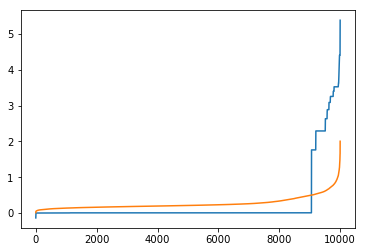

In [29]:
testsort = sort(testy4)
predsort = sort(predy4)
plt.plot(testsort)
plt.plot(predsort)

In [32]:
print(len(features4))
newentro4 = []
for x in range (0, len(features4)):
    newentro4.append(entro4[x])
    
print(len(newentro4))

20000
20000


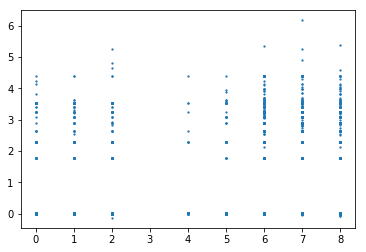

In [33]:
#average
#max 
#min
#features4.appenddir[b],liststdir[c],liststdir[d]])
aveloop4 = []
maxloop4 = []
minloop4 = []

avesymm4 = []
maxsymm4 = []
minsymm4 = []


avestrate4 = []
maxstrate4 = []
minstrate4 = []
difstrate4 = []

avestdir4 = []
maxstdir4 = []
minstdir4 = []


for x in range (0, len(features4)):
    a1,b1,c1,d1,a2,b2,c2,d2,a3,b3,c3,d3,a4,b4,c4,d4 = features4[x]
    aveloop4.append((max([a1,b1,c1,d1])- min([a1,b1,c1,d1])))
    #print(x, max([a1,b1,c1,d1]),min([a1,b1,c1,d1]))
    avesymm4.append((a2+b2+c2+d2)/4)
    difstrate4.append((max([a3,b3,c3,d3])- min([a3,b3,c3,d3])))
    maxstrate4.append(max([a3,b3,c3,d3]))
    avestrate4.append((a3+b3+c3+d3)/4)
    avestdir4.append((a4+b4+c4+d4)/4)

#plt.scatter(listloop, newentro4, s = 1.5)
#range between max and min
plt.scatter(aveloop4, newentro4, s = 1.5)


In [91]:
print(features4[10])
print(entro4)

[1.999999999303721, 4.000000031008008, 10.000000205586595, 4.000000096501042, 0.0, 1.0, 0.0, 1.0, 18.9088552621, 0.819955853357, 7.18624190864, 17.3763400504, 2.0185954828253925, 3.369921372298512, 4.638922858158629, -0.8894951745970242]
[0.0053017257681189584, 0.0053013397620350023, 0.0053123534486241349, 0.0053308381771763457, 0.0053190432873110463, 0.0, 0.0, 0.0053045533098298884, 0.0052566764264606013, 0.0052867242112636138, 0.0053105036976238279, 0.0053308551284236508, 0.0053171959331003594, 0.0053358920403600582, 3.5254943170495787, 0.0052658075115438272, 0.0053039116293184816, 0.0053241027256907009, 2.2924317081286607, 2.2924302738196478, 3.5254942647243341, 0.0052653241730214757, 0.0053245755806531842, 0.0, 1.7627427425068374, 0.0053321290514991302, 0.00533224764225676, 0.0053141306356030869, 0.0052772136778116924, 0.0, 0.0052950732213868854, 0.0053180949029614077, 0.0053206666970400099, 0.005286226901204184, 0.0, 1.7627308056053426, 0.0051287397479371291, 0.0052056193695460889

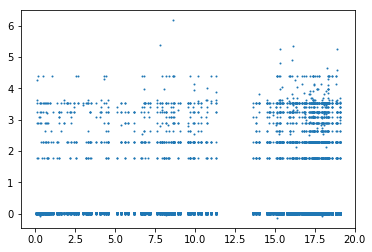

In [34]:
plt.scatter(maxstrate4, newentro4, s = 1)


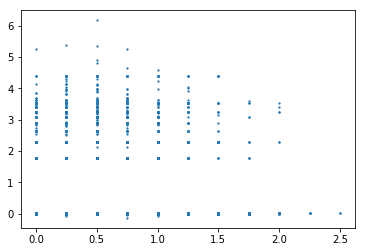

In [84]:
plt.scatter(avesymm4, newentro4, s = 1.5)



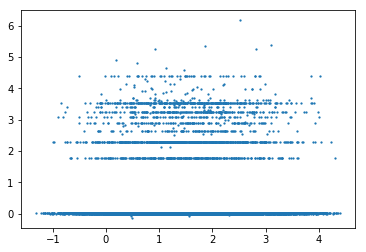

In [85]:
plt.scatter(avestdir4, newentro4, s = 1.5)


In [17]:
#use the linear model in sklearn to fit the data
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
#lasso performs feature selection so we can see the coefficients to learn which features are important
from sklearn import linear_model
#create a model
clf = linear_model.Lasso(alpha=0.1)
#fit the data
clf.fit(trainx, trainy)
#get prediction for test set
pred = clf.predict(testx)
#get the number of correct predictions
print(((testy-pred)<0.001).sum()/len(testy))



0.94292109681


In [11]:
#add more information to the x features, such as the initial position
entro3 = readsingle("ent3.txt")
print(len(entro3))

21444


In [16]:
print(len(testx[5]),len(trainx[5]))

12 12


In [19]:
clfall = linear_model.Lasso(alpha=0.1)
clfall.fit(trainx+testx, trainy+testy)
print(clfall.coef_)
print(clf.coef_)


[ 0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0.]
[ 0. -0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0.]


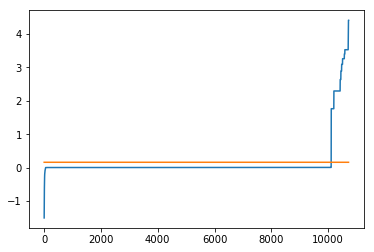

In [20]:
testsort33 = sort(testy)
predsort33 = sort(pred)
plt.plot(testsort33)
plt.plot(predsort33)